In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import RMSprop

from sklearn.model_selection import train_test_split

In [2]:
from IPython.display import Audio, display

# Definisci una funzione per riprodurre un suono
def play_sound():
    sound_file = "C:\Windows\Media\Alarm01.wav"  # Sostituisci con il percorso del tuo file audio
    display(Audio(filename=sound_file, autoplay=True))

### Regressore

In [3]:
class RegressorNNVar(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNNVar, self).__init__()
        
        # input layer
        self.layers=[nn.Linear(input_size, hidden_size[0])]
        
        # hidden layers
        i=0
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob)) #disattiva casualmente un'insieme di unità
            i+=1
        
        # output layers
        self.layers.append(nn.Linear(hidden_size[i], output_size))
        
        self.model=nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

### Training model e grid search

In [48]:
def training_model(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size,
                   reg_coeff, activation_function, num_layers, dropout, decay, mom_decay, epoch_decay, min_lr, min_mom, optimizer, num_epochs=1000, plot_curves=False, 
                   return_history=False):
   
    hidden_size =[]
    for j in range(num_layers):
        hidden_size.append(0)
    
    for i in range(len(proportions)):
        hidden_size[i] = int(proportions[i]*neuron_number)  
        
    #creo l'oggetto regerssore
    model=RegressorNNVar(hidden_size, activation_function, num_layers, dropout)
    
    #definisco la funzione di loss e l'optimizer
    criterion=nn.MSELoss()
    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum, weight_decay=reg_coeff)
        
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=reg_coeff)
        
    if optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)
        
    #preprocessing dataset    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train) #crea un tensor dataset
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True) #dataloader che suddivide il set di dati in batch più piccoli, per il minibatch
    
    #liste per raggruppare le metriche
    train_losses, test_losses, train_mees, test_mees, train_maes, test_maes, train_mses, test_mses = [], [], [], [], [], [], [], []
    
    #parametri per fermare l'addestramento alla concergenza
    min_mee=float("inf") #min_mee=infinito
    patience_counter, patience = 0, 20

    
    
    #addestramento per ogni epoca
    for epoch in range(num_epochs):
        model.train() #setto il modello per l'addestramento
        #i=1
        for inputs, labels in train_dataloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels) #computo la loss
            optimizer.zero_grad() #azzera i gradienti accumulati nelle variabili dei parametri del modello (necessario prima di ogni passaggio di backward)
            loss.backward() #backward pass
            optimizer.step() #update weights
        
        for param_group in optimizer.param_groups:
            lr_att=param_group['lr']
            if type(optimizer) == torch.optim.SGD:
                mom_att=param_group['momentum']
            if type(optimizer) == torch.optim.RMSprop:
                mom_att=param_group['alpha']
            else:
                mom_att=0
        
        
        if (epoch%epoch_decay)==0:
            for param_group in optimizer.param_groups:
                if lr_att>min_lr:
                    param_group['lr'] *= decay
                if mom_att>min_mom:
                    if type(optimizer) == torch.optim.SGD:
                        param_group['momentum'] = max(initial_momentum, param_group['momentum'] * mom_decay)
                    if type(optimizer) == torch.optim.RMSprop:
                        param_group['alpha'] *= mom_decay

                    
            
        model.eval() #setto il modello per l'evaluation
        
        #calcolo la loss
        y_pred=model(x_train)
        train_loss=criterion(y_pred, y_train)
        #calcolo mee, mae e mse
        train_mee, train_mae, train_mse = metrics(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)
        train_maes.append(train_mae)
        train_mses.append(train_mse)
        
        #evaluation sul validation/test set
        with torch.no_grad():
            test_outputs=model(x_test)
            test_loss=criterion(test_outputs, y_test)
            
            #calcolo mee, mae e mse
            test_mee, test_mae, test_mse = metrics(test_outputs,y_test)
            test_mees.append(test_mee)
            test_maes.append(test_mae)
            test_mses.append(test_mse)
            test_losses.append(test_loss.item())
            
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MAE: {train_mae:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MSE: {train_mse:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')
        
        #controllo la presenza di convergenza
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter=0
            min_mee=train_mee
        else:
            patience_counter +=1
            
        if patience_counter==patience:
            break
        
    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - MEE (train | test) = ({train_mee} | {test_mee}) - MAE (train | test) = ({train_mae} | {test_mae} - MSE (train | test) = ({train_mse} | {test_mse}))')
    
    if plot_curves:
        hyperparams=[hidden_size, learning_rate, momentum, batch_size, reg_coeff, activation_function, num_layers, dropout, decay, mom_decay, epoch_decay, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams)
    
    if return_history:
        return model, epoch+1, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees), np.array(train_mae), np.array(test_mae), np.array(train_mse), np.array(test_mse)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, train_mae, test_mae, train_mse, test_mse

In [51]:
def perform_grid_search_kfold(proportionss, neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, 
                              activations, layerss, dropouts, decays, mom_decays, epoch_decays, min_lrs, min_moms, optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000, N=1):
          
        
    best_mee=float('inf') #setto la migliore mee come infinito
    best_loss=float('inf')
    best_hyperparameters=[]
    finale="\n----- RISULTATI -----\n"
    
    count=1
    tot_modelli=len(proportionss)*len(neuron_numbers)*len(learning_rates)*len(momentums)*len(batch_sizes)*len(reg_coeffs)*len(activations)*len(decays)*len(mom_decays)*len(epoch_decays)*len(dropouts)*len(min_lrs)*len(min_moms)
    
    tot_iniz=k_folds*N
    
    for proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, decay, mom_decay, epoch_decay, min_lr, min_mom, dropout in product(proportionss, neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, decays, mom_decays, epoch_decays, min_lrs, min_moms, dropouts):
        print("\nModello "+str(count)+"\\"+str(tot_modelli))
        print(f'activation={activation}; layers={layers}; proportions={proportions}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {batch_size}; lambda = {reg_coeff}; optim = {optimiz}; decay = {decay}; epoch decay = {epoch_decay}; minimum learning rate = {min_lr}; minimum momentum = {min_mom}')
        
        iniz=1
        
        kf=KFold(n_splits=k_folds, shuffle=True, random_state=42)

        train_losses, val_losses, train_mees, val_mees, train_maes, val_maes, train_mses, val_mses, max_epochs = [], [], [], [], [], [], [], [], []

        #perform crossvalidation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            
            #divido in test e validation
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

             #trainings
            for i in range (0,N):
                
                print("\nInizializzazione "+str(iniz)+"\\"+str(tot_iniz))
                _, max_epoch, train_loss, val_loss, train_mee, val_mee, train_mae, val_mae, train_mse, val_mse = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val, proportions=proportions, neuron_number=neuron_number, 
                learning_rate=learning_rate, momentum=momentum, batch_size=batch_size, reg_coeff=reg_coeff, activation_function=activation, 
                num_layers=layers, dropout=dropout, decay=decay, mom_decay=mom_decay, epoch_decay=epoch_decay, min_lr=min_lr, min_mom=min_mom, optimizer=optimiz, num_epochs=num_epochs, plot_curves=plot_curves)
                
                #risultati training
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_mees.append(train_mee)
                val_mees.append(val_mee)
                train_maes.append(train_mae)
                val_maes.append(val_mae)
                train_mses.append(train_mse)
                val_mses.append(val_mse)
                max_epochs.append(max_epoch)
                iniz=iniz+1

                
        out=f'Final Results: activation={activation}; layers={layers}; proportions = {proportions}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {batch_size}; lambda = {reg_coeff}; optim = {optimiz}; learning rate decay = {decay}; momentum decay = {mom_decay}; epoch decay = {epoch_decay}; minimum learning rate = {min_lr}; minimum momentum = {min_mom} \n--> train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4} \ntrain_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4} \ntrain_mae = {np.mean(train_maes):.4} +- {np.std(train_maes):.4} | val_mae = {np.mean(val_maes):.4} +- {np.std(val_maes):.4} \ntrain_mse = {np.mean(train_mses):.4} +- {np.std(train_mses):.4} | val_mse = {np.mean(val_mses):.4} +- {np.std(val_mses):.4}\nmean max epoch = {round(np.mean(max_epochs))}\n\n'
        count=count+1
        finale=finale+out
        #aggiungi iperparametri

        if np.mean(val_mees)<best_mee:
            best_mee_out=out
            best_mee=np.mean(val_mees)
            best_hyperparams=[proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, dropout, decay, mom_decay, epoch_decay, min_lr, min_mom]
        if np.mean(val_losses)<best_loss:
            best_loss_out=out
            best_loss=np.mean(val_losses)
            best_hyperparams_loss=[proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, dropout, decay, mom_decay, epoch_decay, min_lr, min_mom] 
            #fallo anche per loss 
    
    finale=finale+"\n---- MIGLIORI RISULTATI MEE ----\n"+best_mee_out+"\n---- MIGLIORI RISULTATI LOSS ----\n"+best_loss_out
    print(finale)
    print(best_hyperparams)
    return best_hyperparams

In [33]:
def train_with_different_initializations(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, 
                                         momentum, batch_size, reg_coeff, activation, layers, dropout, decay, mom_decay, epoch_decay, min_lr, min_mom, optimiz, 
                                         max_num_epochs=1000, plot_curves=False, N=5):
   
    train_losses, test_losses, train_mees, test_mees, train_maes, test_maes, train_mses, test_mses = [], [], [], [], [], [], [], []
    print(f'activation={activation}; layers={layers}; proportions={proportions}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {batch_size}; lambda = {reg_coeff}; optim = {optimiz}; learning rate decay = {decay}; momentum decay = {mom_decay}; epoch decay = {epoch_decay}; minimum learning rate = {min_lr}; minimum momentum = {min_mom}\n')
    
    #trainings
    for i in range (0,N):
        _, epoch, train_loss, test_loss, train_mee, test_mee, train_mae, test_mae, train_mse, test_mse = training_model(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, dropout, decay, mom_decay, epoch_decay, min_lr, min_mom, optimiz, max_num_epochs, plot_curves, return_history=False)
        train_losses.append(train_loss)
        train_maes.append(train_mae)
        train_mses.append(train_mse)
        train_mees.append(train_mee)
        test_losses.append(test_loss)
        test_mees.append(test_mee)
        test_maes.append(test_mae)
        test_mses.append(test_mse)

    
    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test MEE: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train MEE: {np.mean(train_mees):.4} +- {np.std(train_mees):.4}')
    print(f'Test MEE: {np.mean(test_mees):.4} +- {np.std(test_mees):.4}')
    print(f'Train MAE: {np.mean(train_maes):.4} +- {np.std(train_maes):.4}')
    print(f'Test MAE: {np.mean(test_maes):.4} +- {np.std(test_maes):.4}')
    print(f'Train MSE: {np.mean(train_mses):.4} +- {np.std(train_mses):.4}')
    print(f'Test MSE: {np.mean(test_mses):.4} +- {np.std(test_mses):.4}')


### Funzioni ausiliarie

In [7]:
def plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams):
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    plt.tight_layout()

    plt.show()

In [8]:
#questa devo ancora rivederla

def plot_mean_std(N,train_hist, test_hist,label):
    
    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(9, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,1)
    plt.legend()
    plt.show()


In [9]:
def metrics(y_pred, y_true):
    
    # Check if the tensors have the correct shape
    if y_pred.shape[1] != 3 or y_true.shape[1] != 3 or y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(y_pred - y_true, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)
    
    
    # Calcolo della Mean Absolute Error (MAE)
    mae = F.l1_loss(y_pred, y_true)

    # Calcolo della Mean Squared Error (MSE)
    mse = F.mse_loss(y_pred, y_true)


    return mean_error.item(), mae.item(), mse.item()

In [10]:
def reshape_history(N, hist):
    min_len=float("inf")
    for i in range(0,N):
        if len(hist[i])<min_len:
            min_len=len(hist[i])
            
    for i in range(0,N):
        hist[i]=hist[i][:min_len]
    
    return hist

### Preprocessing dataset

In [11]:
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Adam senza decay, prova layers

In [40]:
proportionss = [[0.2, 0.3, 0.5], [0.25, 0.3, 0.45], [0.27, 0.3, 0.43], [0.25, 0.35, 0.4], [0.2, 0.35, 0.45]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] #if optimiz = 'Adam' it doesn't matter # Non importa che ci sia o che valore ci metti?
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays=[1]
epoch_decays = [10000]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\5
activation=Tanh(); layers=3; proportions=[0.2, 0.3, 0.5]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 1; epoch decay = 10000

Inizializzazione 1\9
Training - Epoch [1584/5000], Loss: 0.0825, MEE: 0.4154 | Test - Epoch [1584/5000], Loss: 0.3093 MEE: 0.6482     
 N. Epochs = 1584 - Loss (train | test)= (0.08252 | 0.3093) - MEE (train | test) = (0.41538843512535095 | 0.6482466459274292) - MAE (train | test) = (0.20943178236484528 | 0.32223305106163025 - MSE (train | test) = (0.0825229287147522 | 0.3093147575855255))

Inizializzazione 2\9
Training - Epoch [1846/5000], Loss: 0.0574, MEE: 0.3456 | Test - Epoch [1846/5000], Loss: 0.2738 MEE: 0.6092     
 N. Epochs = 1846 - Loss (train | test)= (0.05738 | 0.2738) - MEE (train | test) = (0.3456195890903473 | 0.60915207862854) - MAE (train | test) = (0.17428521811962128 | 0.3050846755504608 - MSE (train | test) = (0.0573803149163723 | 0.27375683188438416))

Inizializzazione 3\9
T

Training - Epoch [1456/5000], Loss: 0.1092, MEE: 0.4271 | Test - Epoch [1456/5000], Loss: 0.3547 MEE: 0.6689     
 N. Epochs = 1456 - Loss (train | test)= (0.1092 | 0.3547) - MEE (train | test) = (0.4271189570426941 | 0.6689369678497314) - MAE (train | test) = (0.2161334604024887 | 0.33756330609321594 - MSE (train | test) = (0.10919951647520065 | 0.3547402024269104))

Inizializzazione 4\9
Training - Epoch [1658/5000], Loss: 0.0585, MEE: 0.3441 | Test - Epoch [1658/5000], Loss: 0.4509 MEE: 0.7762     
 N. Epochs = 1658 - Loss (train | test)= (0.05851 | 0.4509) - MEE (train | test) = (0.34413740038871765 | 0.7761778831481934) - MAE (train | test) = (0.1741943359375 | 0.3777327835559845 - MSE (train | test) = (0.05851348116993904 | 0.4508889615535736))

Inizializzazione 5\9
Training - Epoch [1517/5000], Loss: 0.1377, MEE: 0.4143 | Test - Epoch [1517/5000], Loss: 0.6270 MEE: 0.8297     
 N. Epochs = 1517 - Loss (train | test)= (0.1377 | 0.627) - MEE (train | test) = (0.41430506110191345 | 

Training - Epoch [1548/5000], Loss: 0.0927, MEE: 0.4051 | Test - Epoch [1548/5000], Loss: 0.5588 MEE: 0.8398     
 N. Epochs = 1548 - Loss (train | test)= (0.09267 | 0.5588) - MEE (train | test) = (0.40514007210731506 | 0.839755654335022) - MAE (train | test) = (0.20389845967292786 | 0.41744956374168396 - MSE (train | test) = (0.09266890585422516 | 0.5588443279266357))

Inizializzazione 6\9
Training - Epoch [1607/5000], Loss: 0.0715, MEE: 0.3716 | Test - Epoch [1607/5000], Loss: 0.5230 MEE: 0.8051     
 N. Epochs = 1607 - Loss (train | test)= (0.07154 | 0.523) - MEE (train | test) = (0.3715914189815521 | 0.805096447467804) - MAE (train | test) = (0.18844974040985107 | 0.3986997902393341 - MSE (train | test) = (0.07154418528079987 | 0.5230159163475037))

Inizializzazione 7\9
Training - Epoch [1549/5000], Loss: 0.1350, MEE: 0.3980 | Test - Epoch [1549/5000], Loss: 0.4754 MEE: 0.8371     
 N. Epochs = 1549 - Loss (train | test)= (0.135 | 0.4754) - MEE (train | test) = (0.39801615476608276

In [11]:
proportionss = [[0.27, 0.3, 0.43], [0.28, 0.3, 0.42], [0.26, 0.3, 0.44], [0.26, 0.32, 0.42]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] #if optimiz = 'Adam' it doesn't matter # Non importa che ci sia o che valore ci metti?
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays=[1]
epoch_decays = [10000]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\4
activation=Tanh(); layers=3; proportions=[0.27, 0.3, 0.43]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 1; epoch decay = 10000

Inizializzazione 1\9
Training - Epoch [1684/5000], Loss: 0.0546, MEE: 0.3352 | Test - Epoch [1684/5000], Loss: 0.2571 MEE: 0.5960     
 N. Epochs = 1684 - Loss (train | test)= (0.05464 | 0.2571) - MEE (train | test) = (0.335225373506546 | 0.5959795117378235) - MAE (train | test) = (0.1709439903497696 | 0.3027932941913605 - MSE (train | test) = (0.05464306101202965 | 0.2571074366569519))

Inizializzazione 2\9
Training - Epoch [1569/5000], Loss: 0.0828, MEE: 0.3821 | Test - Epoch [1569/5000], Loss: 0.3238 MEE: 0.6524     
 N. Epochs = 1569 - Loss (train | test)= (0.0828 | 0.3238) - MEE (train | test) = (0.38208428025245667 | 0.6523811221122742) - MAE (train | test) = (0.19311679899692535 | 0.3259675204753876 - MSE (train | test) = (0.08280190825462341 | 0.32379022240638733))

Inizializzazione 3\9

Training - Epoch [1755/5000], Loss: 0.0598, MEE: 0.3326 | Test - Epoch [1755/5000], Loss: 0.2991 MEE: 0.6354     
 N. Epochs = 1755 - Loss (train | test)= (0.05981 | 0.2991) - MEE (train | test) = (0.3326345384120941 | 0.6354362368583679) - MAE (train | test) = (0.16777564585208893 | 0.31761667132377625 - MSE (train | test) = (0.059805355966091156 | 0.2990649938583374))

Inizializzazione 4\9
Training - Epoch [1768/5000], Loss: 0.0559, MEE: 0.3036 | Test - Epoch [1768/5000], Loss: 0.4912 MEE: 0.7677     
 N. Epochs = 1768 - Loss (train | test)= (0.05592 | 0.4912) - MEE (train | test) = (0.3035748302936554 | 0.767721951007843) - MAE (train | test) = (0.1533929854631424 | 0.37861397862434387 - MSE (train | test) = (0.05592450127005577 | 0.491180956363678))

Inizializzazione 5\9
Training - Epoch [1445/5000], Loss: 0.0902, MEE: 0.3962 | Test - Epoch [1445/5000], Loss: 0.5148 MEE: 0.8221     
 N. Epochs = 1445 - Loss (train | test)= (0.09019 | 0.5148) - MEE (train | test) = (0.39624002575874

In [43]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04, 2e-04, 3e-04, 1e-5, 2e-5, 3e-5]
momentums = [0.9, 0.85, 0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9, 0.95, 0.93, 0.85]
mom_decays = [0.9, 0.8]
epoch_decays = [100, 150, 50, 200]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=2)


Modello 1\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [1832/5000], Loss: 0.2363, MEE: 0.4263 | Test - Epoch [1832/5000], Loss: 0.3096 MEE: 0.6385     
 N. Epochs = 1832 - Loss (train | test)= (0.2363 | 0.3096) - MEE (train | test) = (0.4263085424900055 | 0.6384857892990112) - MAE (train | test) = (0.21746329963207245 | 0.3206673860549927 - MSE (train | test) = (0.23626559972763062 | 0.3095863461494446))

Inizializzazione 2\6
Training - Epoch [1739/5000], Loss: 0.1080, MEE: 0.4054 | Test - Epoch [1739/5000], Loss: 0.3533 MEE: 0.6516     
 N. Epochs = 1739 - Loss (train | test)= (0.108 | 0.3533) - MEE (train | test) = (0.4053749740123749 | 0.6516406536102295) - MAE (train | test) = (0.2075657993555069 | 0.3338460326194763 - MSE (train | test) = (0.107981927692890

Training - Epoch [1183/5000], Loss: 0.1623, MEE: 0.4775 | Test - Epoch [1183/5000], Loss: 0.3279 MEE: 0.6986     
 N. Epochs = 1183 - Loss (train | test)= (0.1623 | 0.3279) - MEE (train | test) = (0.4775345027446747 | 0.6986224055290222) - MAE (train | test) = (0.24285520613193512 | 0.3554917573928833 - MSE (train | test) = (0.1623455435037613 | 0.32789522409439087))

Inizializzazione 3\6
Training - Epoch [999/5000], Loss: 0.1721, MEE: 0.4987 | Test - Epoch [999/5000], Loss: 0.7942 MEE: 0.9894   9 6 
 N. Epochs = 999 - Loss (train | test)= (0.1721 | 0.7942) - MEE (train | test) = (0.4987327456474304 | 0.9894033074378967) - MAE (train | test) = (0.2538814842700958 | 0.4881151616573334 - MSE (train | test) = (0.1721070408821106 | 0.7941749691963196))

Inizializzazione 4\6
Training - Epoch [1101/5000], Loss: 0.1559, MEE: 0.4489 | Test - Epoch [1101/5000], Loss: 0.7353 MEE: 0.9177   7 
 N. Epochs = 1101 - Loss (train | test)= (0.1559 | 0.7353) - MEE (train | test) = (0.4488765001296997 | 0

Training - Epoch [975/5000], Loss: 0.1289, MEE: 0.4467 | Test - Epoch [975/5000], Loss: 0.7207 MEE: 0.9408       
 N. Epochs = 975 - Loss (train | test)= (0.1289 | 0.7207) - MEE (train | test) = (0.4466952085494995 | 0.9407978653907776) - MAE (train | test) = (0.22571778297424316 | 0.46545520424842834 - MSE (train | test) = (0.1289064884185791 | 0.7207129001617432))

Inizializzazione 5\6
Training - Epoch [811/5000], Loss: 0.4314, MEE: 0.6258 | Test - Epoch [811/5000], Loss: 1.0805 MEE: 1.1423       
 N. Epochs = 811 - Loss (train | test)= (0.4314 | 1.081) - MEE (train | test) = (0.6258252859115601 | 1.1423274278640747) - MAE (train | test) = (0.3146359622478485 | 0.5806021094322205 - MSE (train | test) = (0.43137186765670776 | 1.080546259880066))

Inizializzazione 6\6
Training - Epoch [946/5000], Loss: 0.3230, MEE: 0.6201 | Test - Epoch [946/5000], Loss: 0.8083 MEE: 1.0610       
 N. Epochs = 946 - Loss (train | test)= (0.323 | 0.8083) - MEE (train | test) = (0.6200527548789978 | 1.060

Training - Epoch [860/5000], Loss: 0.2982, MEE: 0.5519 | Test - Epoch [860/5000], Loss: 0.8332 MEE: 1.0537       
 N. Epochs = 860 - Loss (train | test)= (0.2982 | 0.8332) - MEE (train | test) = (0.5519397854804993 | 1.0537267923355103) - MAE (train | test) = (0.2782628834247589 | 0.5333720445632935 - MSE (train | test) = (0.2982012629508972 | 0.8332470059394836))

Modello 17\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [1094/5000], Loss: 0.4904, MEE: 0.6219 | Test - Epoch [1094/5000], Loss: 0.4124 MEE: 0.7546     
 N. Epochs = 1094 - Loss (train | test)= (0.4904 | 0.4124) - MEE (train | test) = (0.6218928098678589 | 0.7546493411064148) - MAE (train | test) = (0.3179783523082733 | 0.37910977005958557 - MSE (train | test) = (0.49038103222846985 | 0.41240939497947

Training - Epoch [978/5000], Loss: 0.2915, MEE: 0.5594 | Test - Epoch [978/5000], Loss: 0.3118 MEE: 0.7298       
 N. Epochs = 978 - Loss (train | test)= (0.2915 | 0.3118) - MEE (train | test) = (0.5593999624252319 | 0.7297637462615967) - MAE (train | test) = (0.2842397093772888 | 0.37101036310195923 - MSE (train | test) = (0.2914694547653198 | 0.31176212430000305))

Inizializzazione 2\6
Training - Epoch [1031/5000], Loss: 0.1737, MEE: 0.5036 | Test - Epoch [1031/5000], Loss: 0.3775 MEE: 0.7486     
 N. Epochs = 1031 - Loss (train | test)= (0.1737 | 0.3775) - MEE (train | test) = (0.5036323666572571 | 0.7486103177070618) - MAE (train | test) = (0.25513070821762085 | 0.3806261718273163 - MSE (train | test) = (0.17370283603668213 | 0.37745070457458496))

Inizializzazione 3\6
Training - Epoch [1071/5000], Loss: 0.1282, MEE: 0.4727 | Test - Epoch [1071/5000], Loss: 0.7560 MEE: 0.9930   0 
 N. Epochs = 1071 - Loss (train | test)= (0.1282 | 0.756) - MEE (train | test) = (0.4726506173610687 |

Training - Epoch [1826/5000], Loss: 0.1829, MEE: 0.4209 | Test - Epoch [1826/5000], Loss: 0.8073 MEE: 0.9240     
 N. Epochs = 1826 - Loss (train | test)= (0.1829 | 0.8073) - MEE (train | test) = (0.4209415018558502 | 0.9240081310272217) - MAE (train | test) = (0.21540038287639618 | 0.46054592728614807 - MSE (train | test) = (0.18285426497459412 | 0.8073295950889587))

Inizializzazione 4\6
Training - Epoch [1784/5000], Loss: 0.0872, MEE: 0.3645 | Test - Epoch [1784/5000], Loss: 0.6728 MEE: 0.8929     
 N. Epochs = 1784 - Loss (train | test)= (0.08724 | 0.6728) - MEE (train | test) = (0.36446118354797363 | 0.8929442763328552) - MAE (train | test) = (0.18595482409000397 | 0.44103315472602844 - MSE (train | test) = (0.08724267780780792 | 0.6727517247200012))

Inizializzazione 5\6
Training - Epoch [1641/5000], Loss: 0.1314, MEE: 0.3865 | Test - Epoch [1641/5000], Loss: 0.5263 MEE: 0.8770     
 N. Epochs = 1641 - Loss (train | test)= (0.1314 | 0.5263) - MEE (train | test) = (0.3864596486091

Training - Epoch [1399/5000], Loss: 0.1830, MEE: 0.4109 | Test - Epoch [1399/5000], Loss: 0.6792 MEE: 0.9432     
 N. Epochs = 1399 - Loss (train | test)= (0.183 | 0.6792) - MEE (train | test) = (0.4109201431274414 | 0.9432000517845154) - MAE (train | test) = (0.20820365846157074 | 0.4773879945278168 - MSE (train | test) = (0.18301653861999512 | 0.6792216897010803))

Inizializzazione 6\6
Training - Epoch [1279/5000], Loss: 0.2978, MEE: 0.4578 | Test - Epoch [1279/5000], Loss: 0.8991 MEE: 1.0210     
 N. Epochs = 1279 - Loss (train | test)= (0.2978 | 0.8991) - MEE (train | test) = (0.4578281342983246 | 1.020998477935791) - MAE (train | test) = (0.23389025032520294 | 0.5216789245605469 - MSE (train | test) = (0.29780691862106323 | 0.8991312980651855))

Modello 33\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay 

Training - Epoch [2731/5000], Loss: 4.2956, MEE: 2.0217 | Test - Epoch [2731/5000], Loss: 2.8949 MEE: 1.8279     
 N. Epochs = 2731 - Loss (train | test)= (4.296 | 2.895) - MEE (train | test) = (2.021742820739746 | 1.82792067527771) - MAE (train | test) = (1.0442445278167725 | 0.9300413727760315 - MSE (train | test) = (4.295586585998535 | 2.894897222518921))

Inizializzazione 2\6
Training - Epoch [2680/5000], Loss: 3.8882, MEE: 1.9445 | Test - Epoch [2680/5000], Loss: 2.6468 MEE: 1.7811     
 N. Epochs = 2680 - Loss (train | test)= (3.888 | 2.647) - MEE (train | test) = (1.9445102214813232 | 1.781096339225769) - MAE (train | test) = (1.0069196224212646 | 0.9063529968261719 - MSE (train | test) = (3.8882029056549072 | 2.646754503250122))

Inizializzazione 3\6
Training - Epoch [2643/5000], Loss: 3.3092, MEE: 1.7619 | Test - Epoch [2643/5000], Loss: 5.0110 MEE: 2.3313     
 N. Epochs = 2643 - Loss (train | test)= (3.309 | 5.011) - MEE (train | test) = (1.7618783712387085 | 2.3313438892364

Training - Epoch [978/5000], Loss: 0.2344, MEE: 0.6105 | Test - Epoch [978/5000], Loss: 0.9735 MEE: 1.1206       
 N. Epochs = 978 - Loss (train | test)= (0.2344 | 0.9735) - MEE (train | test) = (0.610480010509491 | 1.1205668449401855) - MAE (train | test) = (0.3068658709526062 | 0.5565524101257324 - MSE (train | test) = (0.23438432812690735 | 0.9735499024391174))

Inizializzazione 4\6
Training - Epoch [972/5000], Loss: 0.1783, MEE: 0.5553 | Test - Epoch [972/5000], Loss: 0.8114 MEE: 1.0458     1 
 N. Epochs = 972 - Loss (train | test)= (0.1783 | 0.8114) - MEE (train | test) = (0.5552944540977478 | 1.0457603931427002) - MAE (train | test) = (0.2813771069049835 | 0.5250778198242188 - MSE (train | test) = (0.1783301681280136 | 0.8113682866096497))

Inizializzazione 5\6
Training - Epoch [949/5000], Loss: 0.3205, MEE: 0.5046 | Test - Epoch [949/5000], Loss: 0.8915 MEE: 1.0466       
 N. Epochs = 949 - Loss (train | test)= (0.3205 | 0.8915) - MEE (train | test) = (0.5046419501304626 | 1.046

Training - Epoch [2510/5000], Loss: 0.3166, MEE: 0.4682 | Test - Epoch [2510/5000], Loss: 0.9156 MEE: 1.0141     
 N. Epochs = 2510 - Loss (train | test)= (0.3166 | 0.9156) - MEE (train | test) = (0.4681571424007416 | 1.014062762260437) - MAE (train | test) = (0.24057601392269135 | 0.5184857845306396 - MSE (train | test) = (0.3165509104728699 | 0.915570855140686))

Inizializzazione 6\6
Training - Epoch [2556/5000], Loss: 0.3591, MEE: 0.4996 | Test - Epoch [2556/5000], Loss: 1.0129 MEE: 1.0786     
 N. Epochs = 2556 - Loss (train | test)= (0.3591 | 1.013) - MEE (train | test) = (0.4995870292186737 | 1.0786077976226807) - MAE (train | test) = (0.25644418597221375 | 0.554531455039978 - MSE (train | test) = (0.3590734004974365 | 1.0128847360610962))

Modello 52\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 2

Training - Epoch [2033/5000], Loss: 0.2828, MEE: 0.4414 | Test - Epoch [2033/5000], Loss: 0.3265 MEE: 0.6554     
 N. Epochs = 2033 - Loss (train | test)= (0.2828 | 0.3265) - MEE (train | test) = (0.4414304792881012 | 0.6554365158081055) - MAE (train | test) = (0.2267424315214157 | 0.3319767713546753 - MSE (train | test) = (0.28276097774505615 | 0.3264753818511963))

Inizializzazione 2\6
Training - Epoch [2281/5000], Loss: 0.2400, MEE: 0.4275 | Test - Epoch [2281/5000], Loss: 0.3683 MEE: 0.6665     
 N. Epochs = 2281 - Loss (train | test)= (0.24 | 0.3683) - MEE (train | test) = (0.4274677038192749 | 0.6664875745773315) - MAE (train | test) = (0.2182036191225052 | 0.34302374720573425 - MSE (train | test) = (0.24000395834445953 | 0.36831584572792053))

Inizializzazione 3\6
Training - Epoch [1906/5000], Loss: 0.1179, MEE: 0.3873 | Test - Epoch [1906/5000], Loss: 0.7683 MEE: 0.9287     
 N. Epochs = 1906 - Loss (train | test)= (0.1179 | 0.7683) - MEE (train | test) = (0.3873465657234192 | 

Training - Epoch [1258/5000], Loss: 0.2037, MEE: 0.4688 | Test - Epoch [1258/5000], Loss: 0.8876 MEE: 0.9755     
 N. Epochs = 1258 - Loss (train | test)= (0.2037 | 0.8876) - MEE (train | test) = (0.4687950909137726 | 0.9754905104637146) - MAE (train | test) = (0.23794880509376526 | 0.4855990409851074 - MSE (train | test) = (0.2037007361650467 | 0.8876402974128723))

Inizializzazione 4\6
Training - Epoch [1403/5000], Loss: 0.1262, MEE: 0.3968 | Test - Epoch [1403/5000], Loss: 0.7096 MEE: 0.9066   0 
 N. Epochs = 1403 - Loss (train | test)= (0.1262 | 0.7096) - MEE (train | test) = (0.39680397510528564 | 0.9065679907798767) - MAE (train | test) = (0.20254823565483093 | 0.4488796591758728 - MSE (train | test) = (0.12615570425987244 | 0.7096038460731506))

Inizializzazione 5\6
Training - Epoch [1411/5000], Loss: 0.1622, MEE: 0.3788 | Test - Epoch [1411/5000], Loss: 0.6187 MEE: 0.9174     
 N. Epochs = 1411 - Loss (train | test)= (0.1622 | 0.6187) - MEE (train | test) = (0.3787560760974884 

Training - Epoch [1311/5000], Loss: 0.1725, MEE: 0.3823 | Test - Epoch [1311/5000], Loss: 0.6466 MEE: 0.9322     
 N. Epochs = 1311 - Loss (train | test)= (0.1725 | 0.6466) - MEE (train | test) = (0.3822513222694397 | 0.9321632385253906) - MAE (train | test) = (0.1956372708082199 | 0.4700874984264374 - MSE (train | test) = (0.17252379655838013 | 0.6465637683868408))

Inizializzazione 6\6
Training - Epoch [1165/5000], Loss: 0.2494, MEE: 0.4412 | Test - Epoch [1165/5000], Loss: 0.7654 MEE: 0.9891     
 N. Epochs = 1165 - Loss (train | test)= (0.2494 | 0.7654) - MEE (train | test) = (0.441232293844223 | 0.9890696406364441) - MAE (train | test) = (0.22389103472232819 | 0.5004833340644836 - MSE (train | test) = (0.24938258528709412 | 0.7654339671134949))

Modello 71\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay =

Training - Epoch [1016/5000], Loss: 0.4254, MEE: 0.6019 | Test - Epoch [1016/5000], Loss: 0.3495 MEE: 0.7371     
 N. Epochs = 1016 - Loss (train | test)= (0.4254 | 0.3495) - MEE (train | test) = (0.60191810131073 | 0.7370867729187012) - MAE (train | test) = (0.30743321776390076 | 0.37479743361473083 - MSE (train | test) = (0.4253629446029663 | 0.34954118728637695))

Inizializzazione 2\6
Training - Epoch [1102/5000], Loss: 0.2443, MEE: 0.4937 | Test - Epoch [1102/5000], Loss: 0.3186 MEE: 0.7172     
 N. Epochs = 1102 - Loss (train | test)= (0.2443 | 0.3186) - MEE (train | test) = (0.493740975856781 | 0.7171543836593628) - MAE (train | test) = (0.25210437178611755 | 0.36734506487846375 - MSE (train | test) = (0.24433356523513794 | 0.3185560703277588))

Inizializzazione 3\6
Training - Epoch [1017/5000], Loss: 0.1480, MEE: 0.4531 | Test - Epoch [1017/5000], Loss: 0.8300 MEE: 0.9868     
 N. Epochs = 1017 - Loss (train | test)= (0.148 | 0.83) - MEE (train | test) = (0.45306602120399475 | 0

Training - Epoch [2812/5000], Loss: 0.2727, MEE: 0.4942 | Test - Epoch [2812/5000], Loss: 0.9916 MEE: 1.0245     
 N. Epochs = 2812 - Loss (train | test)= (0.2727 | 0.9916) - MEE (train | test) = (0.49419140815734863 | 1.0244979858398438) - MAE (train | test) = (0.2507976293563843 | 0.5091500282287598 - MSE (train | test) = (0.27270522713661194 | 0.9916086792945862))

Inizializzazione 4\6
Training - Epoch [2720/5000], Loss: 0.2598, MEE: 0.4973 | Test - Epoch [2720/5000], Loss: 1.0137 MEE: 1.0311     
 N. Epochs = 2720 - Loss (train | test)= (0.2598 | 1.014) - MEE (train | test) = (0.49725142121315 | 1.031085729598999) - MAE (train | test) = (0.2532384991645813 | 0.512351393699646 - MSE (train | test) = (0.25983133912086487 | 1.013656735420227))

Inizializzazione 5\6
Training - Epoch [2296/5000], Loss: 0.2735, MEE: 0.4633 | Test - Epoch [2296/5000], Loss: 0.7849 MEE: 0.9956     
 N. Epochs = 2296 - Loss (train | test)= (0.2735 | 0.7849) - MEE (train | test) = (0.46328267455101013 | 0.99

Training - Epoch [2538/5000], Loss: 0.7110, MEE: 0.7107 | Test - Epoch [2538/5000], Loss: 1.5349 MEE: 1.2576     
 N. Epochs = 2538 - Loss (train | test)= (0.711 | 1.535) - MEE (train | test) = (0.7107162475585938 | 1.257569670677185) - MAE (train | test) = (0.3655918538570404 | 0.6405953764915466 - MSE (train | test) = (0.7110469937324524 | 1.534870982170105))

Inizializzazione 6\6
Training - Epoch [2617/5000], Loss: 0.8553, MEE: 0.7798 | Test - Epoch [2617/5000], Loss: 1.8612 MEE: 1.3613     
 N. Epochs = 2617 - Loss (train | test)= (0.8553 | 1.861) - MEE (train | test) = (0.7797560691833496 | 1.361285924911499) - MAE (train | test) = (0.40387046337127686 | 0.6951521039009094 - MSE (train | test) = (0.855309784412384 | 1.861167073249817))

Modello 90\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 150

In

Training - Epoch [1535/5000], Loss: 0.2484, MEE: 0.4349 | Test - Epoch [1535/5000], Loss: 0.3134 MEE: 0.6470     
 N. Epochs = 1535 - Loss (train | test)= (0.2484 | 0.3134) - MEE (train | test) = (0.4349111020565033 | 0.6469914317131042) - MAE (train | test) = (0.22264400124549866 | 0.3274053931236267 - MSE (train | test) = (0.2484414428472519 | 0.3133505582809448))

Inizializzazione 2\6
Training - Epoch [1434/5000], Loss: 0.2314, MEE: 0.4443 | Test - Epoch [1434/5000], Loss: 0.3834 MEE: 0.6787     
 N. Epochs = 1434 - Loss (train | test)= (0.2314 | 0.3834) - MEE (train | test) = (0.44430088996887207 | 0.678692638874054) - MAE (train | test) = (0.22764992713928223 | 0.3471418023109436 - MSE (train | test) = (0.23135323822498322 | 0.3834425210952759))

Inizializzazione 3\6
Training - Epoch [1402/5000], Loss: 0.1703, MEE: 0.4293 | Test - Epoch [1402/5000], Loss: 0.8305 MEE: 0.9481     
 N. Epochs = 1402 - Loss (train | test)= (0.1703 | 0.8305) - MEE (train | test) = (0.4293239712715149 |

Training - Epoch [566/5000], Loss: 0.2195, MEE: 0.6412 | Test - Epoch [566/5000], Loss: 0.8029 MEE: 1.0746     5 
 N. Epochs = 566 - Loss (train | test)= (0.2195 | 0.8029) - MEE (train | test) = (0.6411737203598022 | 1.0745558738708496) - MAE (train | test) = (0.3264733552932739 | 0.5313690304756165 - MSE (train | test) = (0.21947026252746582 | 0.8029173016548157))

Inizializzazione 4\6
Training - Epoch [546/5000], Loss: 0.2613, MEE: 0.6815 | Test - Epoch [546/5000], Loss: 0.9496 MEE: 1.1391       
 N. Epochs = 546 - Loss (train | test)= (0.2613 | 0.9496) - MEE (train | test) = (0.6814915537834167 | 1.1391491889953613) - MAE (train | test) = (0.3460123538970947 | 0.5682160258293152 - MSE (train | test) = (0.261258602142334 | 0.9496484994888306))

Inizializzazione 5\6
Training - Epoch [542/5000], Loss: 0.3139, MEE: 0.6602 | Test - Epoch [542/5000], Loss: 0.8549 MEE: 1.1256       
 N. Epochs = 542 - Loss (train | test)= (0.3139 | 0.8549) - MEE (train | test) = (0.6602047085762024 | 1.125

Training - Epoch [430/5000], Loss: 0.4229, MEE: 0.6720 | Test - Epoch [430/5000], Loss: 1.0470 MEE: 1.1896       
 N. Epochs = 430 - Loss (train | test)= (0.4229 | 1.047) - MEE (train | test) = (0.6720015406608582 | 1.1896077394485474) - MAE (train | test) = (0.3389742374420166 | 0.5999500155448914 - MSE (train | test) = (0.42285698652267456 | 1.0470014810562134))

Inizializzazione 6\6
Training - Epoch [483/5000], Loss: 0.4124, MEE: 0.8147 | Test - Epoch [483/5000], Loss: 0.9910 MEE: 1.2745       
 N. Epochs = 483 - Loss (train | test)= (0.4124 | 0.991) - MEE (train | test) = (0.8147321343421936 | 1.2744648456573486) - MAE (train | test) = (0.42116090655326843 | 0.6494132280349731 - MSE (train | test) = (0.4124411344528198 | 0.991010844707489))

Modello 109\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 10

Training - Epoch [629/5000], Loss: 0.2254, MEE: 0.5930 | Test - Epoch [629/5000], Loss: 0.3375 MEE: 0.7679       
 N. Epochs = 629 - Loss (train | test)= (0.2254 | 0.3375) - MEE (train | test) = (0.5929601788520813 | 0.7679272890090942) - MAE (train | test) = (0.2983715534210205 | 0.38871222734451294 - MSE (train | test) = (0.22535346448421478 | 0.33745065331459045))

Inizializzazione 2\6
Training - Epoch [669/5000], Loss: 0.3169, MEE: 0.5788 | Test - Epoch [669/5000], Loss: 0.3377 MEE: 0.7315       
 N. Epochs = 669 - Loss (train | test)= (0.3169 | 0.3377) - MEE (train | test) = (0.5787987112998962 | 0.7314990758895874) - MAE (train | test) = (0.2933850884437561 | 0.3693768382072449 - MSE (train | test) = (0.31687960028648376 | 0.3376563787460327))

Inizializzazione 3\6
Training - Epoch [585/5000], Loss: 0.3135, MEE: 0.6201 | Test - Epoch [585/5000], Loss: 0.9972 MEE: 1.0846       
 N. Epochs = 585 - Loss (train | test)= (0.3135 | 0.9972) - MEE (train | test) = (0.6200703978538513 | 1

Training - Epoch [751/5000], Loss: 0.1496, MEE: 0.4676 | Test - Epoch [751/5000], Loss: 0.8366 MEE: 0.9857     9 
 N. Epochs = 751 - Loss (train | test)= (0.1496 | 0.8366) - MEE (train | test) = (0.46760374307632446 | 0.9857180118560791) - MAE (train | test) = (0.2385447770357132 | 0.4868631064891815 - MSE (train | test) = (0.1495838314294815 | 0.8365577459335327))

Inizializzazione 4\6
Training - Epoch [762/5000], Loss: 0.1614, MEE: 0.5255 | Test - Epoch [762/5000], Loss: 0.7576 MEE: 0.9985     1 
 N. Epochs = 762 - Loss (train | test)= (0.1614 | 0.7576) - MEE (train | test) = (0.5254806876182556 | 0.9985367655754089) - MAE (train | test) = (0.26767411828041077 | 0.49799981713294983 - MSE (train | test) = (0.16144044697284698 | 0.7576096653938293))

Inizializzazione 5\6
Training - Epoch [842/5000], Loss: 0.1641, MEE: 0.4141 | Test - Epoch [842/5000], Loss: 0.5757 MEE: 0.9109       
 N. Epochs = 842 - Loss (train | test)= (0.1641 | 0.5757) - MEE (train | test) = (0.4141046702861786 | 0

Training - Epoch [1571/5000], Loss: 0.9781, MEE: 0.7775 | Test - Epoch [1571/5000], Loss: 2.0765 MEE: 1.3657     
 N. Epochs = 1571 - Loss (train | test)= (0.9781 | 2.077) - MEE (train | test) = (0.7774866223335266 | 1.3657034635543823) - MAE (train | test) = (0.4018770754337311 | 0.6981712579727173 - MSE (train | test) = (0.9780710339546204 | 2.0765089988708496))

Inizializzazione 6\6
Training - Epoch [1572/5000], Loss: 0.8376, MEE: 0.7849 | Test - Epoch [1572/5000], Loss: 1.8179 MEE: 1.3588     
 N. Epochs = 1572 - Loss (train | test)= (0.8376 | 1.818) - MEE (train | test) = (0.7848889827728271 | 1.3588454723358154) - MAE (train | test) = (0.4050060510635376 | 0.6983596682548523 - MSE (train | test) = (0.8375599980354309 | 1.8179067373275757))

Modello 128\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 2

Training - Epoch [576/5000], Loss: 0.3626, MEE: 0.6389 | Test - Epoch [576/5000], Loss: 0.3338 MEE: 0.7398       
 N. Epochs = 576 - Loss (train | test)= (0.3626 | 0.3338) - MEE (train | test) = (0.6389296650886536 | 0.7397782802581787) - MAE (train | test) = (0.3224005699157715 | 0.3757462799549103 - MSE (train | test) = (0.3626299798488617 | 0.33378639817237854))

Inizializzazione 2\6
Training - Epoch [412/5000], Loss: 1.0989, MEE: 1.1856 | Test - Epoch [412/5000], Loss: 0.8545 MEE: 1.2372       
 N. Epochs = 412 - Loss (train | test)= (1.099 | 0.8545) - MEE (train | test) = (1.1856427192687988 | 1.237249493598938) - MAE (train | test) = (0.5989291071891785 | 0.6160992980003357 - MSE (train | test) = (1.0988705158233643 | 0.8545067310333252))

Inizializzazione 3\6
Training - Epoch [595/5000], Loss: 0.2123, MEE: 0.6049 | Test - Epoch [595/5000], Loss: 0.8870 MEE: 1.0950   0 9 
 N. Epochs = 595 - Loss (train | test)= (0.2123 | 0.887) - MEE (train | test) = (0.6048939824104309 | 1.09495

Training - Epoch [460/5000], Loss: 0.3791, MEE: 0.7820 | Test - Epoch [460/5000], Loss: 1.0809 MEE: 1.2285       
 N. Epochs = 460 - Loss (train | test)= (0.3791 | 1.081) - MEE (train | test) = (0.7820156216621399 | 1.228513240814209) - MAE (train | test) = (0.38546741008758545 | 0.6042941212654114 - MSE (train | test) = (0.37911200523376465 | 1.0808593034744263))

Inizializzazione 4\6
Training - Epoch [421/5000], Loss: 0.4342, MEE: 0.8972 | Test - Epoch [421/5000], Loss: 1.1172 MEE: 1.2883   1 4 
 N. Epochs = 421 - Loss (train | test)= (0.4342 | 1.117) - MEE (train | test) = (0.8971643447875977 | 1.2883070707321167) - MAE (train | test) = (0.44902798533439636 | 0.6417372822761536 - MSE (train | test) = (0.4342418909072876 | 1.1171802282333374))

Inizializzazione 5\6
Training - Epoch [489/5000], Loss: 0.3674, MEE: 0.6672 | Test - Epoch [489/5000], Loss: 0.8827 MEE: 1.1025       
 N. Epochs = 489 - Loss (train | test)= (0.3674 | 0.8827) - MEE (train | test) = (0.6671613454818726 | 1.102

Training - Epoch [491/5000], Loss: 0.3093, MEE: 0.6615 | Test - Epoch [491/5000], Loss: 0.8431 MEE: 1.1340       
 N. Epochs = 491 - Loss (train | test)= (0.3093 | 0.8431) - MEE (train | test) = (0.6615267395973206 | 1.133955955505371) - MAE (train | test) = (0.3331339955329895 | 0.5723746418952942 - MSE (train | test) = (0.30929115414619446 | 0.8431043028831482))

Inizializzazione 6\6
Training - Epoch [487/5000], Loss: 0.4143, MEE: 0.7267 | Test - Epoch [487/5000], Loss: 1.0831 MEE: 1.2371       
 N. Epochs = 487 - Loss (train | test)= (0.4143 | 1.083) - MEE (train | test) = (0.7267399430274963 | 1.2371137142181396) - MAE (train | test) = (0.36447039246559143 | 0.6213854551315308 - MSE (train | test) = (0.414283812046051 | 1.0830684900283813))

Modello 147\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 5

Training - Epoch [852/5000], Loss: 0.2695, MEE: 0.5459 | Test - Epoch [852/5000], Loss: 0.3646 MEE: 0.7743       
 N. Epochs = 852 - Loss (train | test)= (0.2695 | 0.3646) - MEE (train | test) = (0.5459200143814087 | 0.7742603421211243) - MAE (train | test) = (0.2768353521823883 | 0.39707955718040466 - MSE (train | test) = (0.2694922983646393 | 0.3645736575126648))

Inizializzazione 2\6
Training - Epoch [848/5000], Loss: 0.2451, MEE: 0.5044 | Test - Epoch [848/5000], Loss: 0.3644 MEE: 0.7086       
 N. Epochs = 848 - Loss (train | test)= (0.2451 | 0.3644) - MEE (train | test) = (0.5043768286705017 | 0.7086372971534729) - MAE (train | test) = (0.25493231415748596 | 0.3583725392818451 - MSE (train | test) = (0.24510671198368073 | 0.36442863941192627))

Inizializzazione 3\6
Training - Epoch [736/5000], Loss: 0.1827, MEE: 0.4782 | Test - Epoch [736/5000], Loss: 0.8814 MEE: 1.0062     6 
 N. Epochs = 736 - Loss (train | test)= (0.1827 | 0.8814) - MEE (train | test) = (0.4782423675060272 | 1

Training - Epoch [1607/5000], Loss: 0.9537, MEE: 0.8985 | Test - Epoch [1607/5000], Loss: 1.9933 MEE: 1.3778   6 
 N. Epochs = 1607 - Loss (train | test)= (0.9537 | 1.993) - MEE (train | test) = (0.8984853625297546 | 1.377781629562378) - MAE (train | test) = (0.4633897542953491 | 0.6922901272773743 - MSE (train | test) = (0.9537394642829895 | 1.9932934045791626))

Inizializzazione 4\6
Training - Epoch [1643/5000], Loss: 0.9506, MEE: 0.9371 | Test - Epoch [1643/5000], Loss: 1.9930 MEE: 1.4321     
 N. Epochs = 1643 - Loss (train | test)= (0.9506 | 1.993) - MEE (train | test) = (0.937056839466095 | 1.4321140050888062) - MAE (train | test) = (0.48304998874664307 | 0.7149919271469116 - MSE (train | test) = (0.9505699276924133 | 1.9929677248001099))

Inizializzazione 5\6
Training - Epoch [1581/5000], Loss: 0.8749, MEE: 0.8471 | Test - Epoch [1581/5000], Loss: 1.8573 MEE: 1.4185     
 N. Epochs = 1581 - Loss (train | test)= (0.8749 | 1.857) - MEE (train | test) = (0.8471277356147766 | 1.4184

Training - Epoch [574/5000], Loss: 0.3808, MEE: 0.6429 | Test - Epoch [574/5000], Loss: 0.9902 MEE: 1.1502       
 N. Epochs = 574 - Loss (train | test)= (0.3808 | 0.9902) - MEE (train | test) = (0.6428778171539307 | 1.15023934841156) - MAE (train | test) = (0.32411229610443115 | 0.5840969681739807 - MSE (train | test) = (0.38075268268585205 | 0.990189254283905))

Inizializzazione 6\6
Training - Epoch [587/5000], Loss: 0.2923, MEE: 0.5663 | Test - Epoch [587/5000], Loss: 0.8386 MEE: 1.0835       
 N. Epochs = 587 - Loss (train | test)= (0.2923 | 0.8386) - MEE (train | test) = (0.5663349032402039 | 1.083488941192627) - MAE (train | test) = (0.28500279784202576 | 0.5452877283096313 - MSE (train | test) = (0.29234832525253296 | 0.8385918140411377))

Modello 166\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 15

Training - Epoch [575/5000], Loss: 0.3199, MEE: 0.7267 | Test - Epoch [575/5000], Loss: 0.3936 MEE: 0.8767       
 N. Epochs = 575 - Loss (train | test)= (0.3199 | 0.3936) - MEE (train | test) = (0.7266820669174194 | 0.8767458200454712) - MAE (train | test) = (0.3614864647388458 | 0.4398992359638214 - MSE (train | test) = (0.3198833167552948 | 0.39364758133888245))

Inizializzazione 2\6
Training - Epoch [504/5000], Loss: 0.3830, MEE: 0.7974 | Test - Epoch [504/5000], Loss: 0.4087 MEE: 0.9304       
 N. Epochs = 504 - Loss (train | test)= (0.383 | 0.4087) - MEE (train | test) = (0.7974013686180115 | 0.9304121732711792) - MAE (train | test) = (0.40586185455322266 | 0.4729938507080078 - MSE (train | test) = (0.3830301761627197 | 0.4087221026420593))

Inizializzazione 3\6
Training - Epoch [494/5000], Loss: 0.3446, MEE: 0.8168 | Test - Epoch [494/5000], Loss: 1.0761 MEE: 1.2806       
 N. Epochs = 494 - Loss (train | test)= (0.3446 | 1.076) - MEE (train | test) = (0.8167626857757568 | 1.280

Training - Epoch [430/5000], Loss: 0.4995, MEE: 0.8655 | Test - Epoch [430/5000], Loss: 1.4041 MEE: 1.3623   8 9 
 N. Epochs = 430 - Loss (train | test)= (0.4995 | 1.404) - MEE (train | test) = (0.8654894828796387 | 1.3622872829437256) - MAE (train | test) = (0.42848142981529236 | 0.6740858554840088 - MSE (train | test) = (0.4995163083076477 | 1.4040998220443726))

Inizializzazione 4\6
Training - Epoch [489/5000], Loss: 0.4163, MEE: 0.8463 | Test - Epoch [489/5000], Loss: 1.1876 MEE: 1.2912   3 5 
 N. Epochs = 489 - Loss (train | test)= (0.4163 | 1.188) - MEE (train | test) = (0.8463078737258911 | 1.291194200515747) - MAE (train | test) = (0.4182877838611603 | 0.6301736831665039 - MSE (train | test) = (0.4162871837615967 | 1.1876239776611328))

Inizializzazione 5\6
Training - Epoch [446/5000], Loss: 0.4495, MEE: 0.8144 | Test - Epoch [446/5000], Loss: 1.0317 MEE: 1.2458       
 N. Epochs = 446 - Loss (train | test)= (0.4495 | 1.032) - MEE (train | test) = (0.8144314289093018 | 1.245847

Training - Epoch [369/5000], Loss: 0.7774, MEE: 1.1443 | Test - Epoch [369/5000], Loss: 1.4277 MEE: 1.5236       
 N. Epochs = 369 - Loss (train | test)= (0.7774 | 1.428) - MEE (train | test) = (1.144333004951477 | 1.523551344871521) - MAE (train | test) = (0.5776176452636719 | 0.7660841941833496 - MSE (train | test) = (0.7774450182914734 | 1.4276623725891113))

Inizializzazione 6\6
Training - Epoch [474/5000], Loss: 0.3886, MEE: 0.6572 | Test - Epoch [474/5000], Loss: 1.0037 MEE: 1.1811       
 N. Epochs = 474 - Loss (train | test)= (0.3886 | 1.004) - MEE (train | test) = (0.6571823954582214 | 1.1810550689697266) - MAE (train | test) = (0.33190903067588806 | 0.594327986240387 - MSE (train | test) = (0.38859081268310547 | 1.003700613975525))

Modello 185\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 100



Training - Epoch [1600/5000], Loss: 1.3381, MEE: 0.9691 | Test - Epoch [1600/5000], Loss: 0.8302 MEE: 1.0258     
 N. Epochs = 1600 - Loss (train | test)= (1.338 | 0.8302) - MEE (train | test) = (0.9690550565719604 | 1.0258384943008423) - MAE (train | test) = (0.5064162015914917 | 0.5260156989097595 - MSE (train | test) = (1.3381009101867676 | 0.8302237391471863))

Inizializzazione 2\6
Training - Epoch [1662/5000], Loss: 1.2316, MEE: 1.0365 | Test - Epoch [1662/5000], Loss: 0.8948 MEE: 1.0919     
 N. Epochs = 1662 - Loss (train | test)= (1.232 | 0.8948) - MEE (train | test) = (1.0365428924560547 | 1.091880440711975) - MAE (train | test) = (0.5370959043502808 | 0.5575600266456604 - MSE (train | test) = (1.2315785884857178 | 0.8947903513908386))

Inizializzazione 3\6
Training - Epoch [1622/5000], Loss: 0.8988, MEE: 0.8875 | Test - Epoch [1622/5000], Loss: 1.9133 MEE: 1.3769   6 
 N. Epochs = 1622 - Loss (train | test)= (0.8988 | 1.913) - MEE (train | test) = (0.8875386118888855 | 1.3769

Training - Epoch [389/5000], Loss: 0.4419, MEE: 0.9344 | Test - Epoch [389/5000], Loss: 1.1536 MEE: 1.3568     
 N. Epochs = 389 - Loss (train | test)= (0.4419 | 1.154) - MEE (train | test) = (0.9344033598899841 | 1.3567862510681152) - MAE (train | test) = (0.4712250828742981 | 0.6763612031936646 - MSE (train | test) = (0.44186678528785706 | 1.153589129447937))

Inizializzazione 4\6
Training - Epoch [286/5000], Loss: 1.0280, MEE: 1.2513 | Test - Epoch [286/5000], Loss: 2.0511 MEE: 1.7172   7 
 N. Epochs = 286 - Loss (train | test)= (1.028 | 2.051) - MEE (train | test) = (1.2512977123260498 | 1.7171999216079712) - MAE (train | test) = (0.6321759819984436 | 0.8580295443534851 - MSE (train | test) = (1.0279531478881836 | 2.051089286804199))

Inizializzazione 5\6
Training - Epoch [387/5000], Loss: 0.6395, MEE: 1.1146 | Test - Epoch [387/5000], Loss: 1.1881 MEE: 1.4964     
 N. Epochs = 387 - Loss (train | test)= (0.6395 | 1.188) - MEE (train | test) = (1.1145905256271362 | 1.49640929698944

Training - Epoch [391/5000], Loss: 0.3939, MEE: 0.8501 | Test - Epoch [391/5000], Loss: 0.8858 MEE: 1.2711     
 N. Epochs = 391 - Loss (train | test)= (0.3939 | 0.8858) - MEE (train | test) = (0.850109338760376 | 1.2710762023925781) - MAE (train | test) = (0.44116196036338806 | 0.6521706581115723 - MSE (train | test) = (0.3938601613044739 | 0.885769784450531))

Inizializzazione 6\6
Training - Epoch [306/5000], Loss: 0.7965, MEE: 1.1599 | Test - Epoch [306/5000], Loss: 1.4998 MEE: 1.6015     
 N. Epochs = 306 - Loss (train | test)= (0.7965 | 1.5) - MEE (train | test) = (1.1599061489105225 | 1.6015124320983887) - MAE (train | test) = (0.566231906414032 | 0.7970435619354248 - MSE (train | test) = (0.7964909672737122 | 1.4997848272323608))

Modello 201\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 100

Inizi

Training - Epoch [391/5000], Loss: 0.4620, MEE: 0.8062 | Test - Epoch [391/5000], Loss: 0.5398 MEE: 0.9654     
 N. Epochs = 391 - Loss (train | test)= (0.462 | 0.5398) - MEE (train | test) = (0.8062189221382141 | 0.9653679132461548) - MAE (train | test) = (0.4029363989830017 | 0.47876957058906555 - MSE (train | test) = (0.46197158098220825 | 0.5397825837135315))

Inizializzazione 2\6
Training - Epoch [315/5000], Loss: 0.7119, MEE: 1.0555 | Test - Epoch [315/5000], Loss: 0.6497 MEE: 1.1243     
 N. Epochs = 315 - Loss (train | test)= (0.7119 | 0.6497) - MEE (train | test) = (1.0555120706558228 | 1.1243258714675903) - MAE (train | test) = (0.5362456440925598 | 0.5733424425125122 - MSE (train | test) = (0.7119492292404175 | 0.6497417092323303))

Inizializzazione 3\6
Training - Epoch [284/5000], Loss: 0.8650, MEE: 1.0263 | Test - Epoch [284/5000], Loss: 1.8259 MEE: 1.4256   0 
 N. Epochs = 284 - Loss (train | test)= (0.865 | 1.826) - MEE (train | test) = (1.026330828666687 | 1.42557621002

Training - Epoch [372/5000], Loss: 0.3242, MEE: 0.8276 | Test - Epoch [372/5000], Loss: 0.9522 MEE: 1.2498   0 
 N. Epochs = 372 - Loss (train | test)= (0.3242 | 0.9522) - MEE (train | test) = (0.8275941610336304 | 1.2497780323028564) - MAE (train | test) = (0.41764193773269653 | 0.612743079662323 - MSE (train | test) = (0.3242075741291046 | 0.9521704316139221))

Inizializzazione 4\6
Training - Epoch [396/5000], Loss: 0.4002, MEE: 0.8698 | Test - Epoch [396/5000], Loss: 1.0832 MEE: 1.2807   2 
 N. Epochs = 396 - Loss (train | test)= (0.4002 | 1.083) - MEE (train | test) = (0.8698103427886963 | 1.280693769454956) - MAE (train | test) = (0.4507390260696411 | 0.6441193222999573 - MSE (train | test) = (0.400153785943985 | 1.0832422971725464))

Inizializzazione 5\6
Training - Epoch [351/5000], Loss: 0.3305, MEE: 0.6843 | Test - Epoch [351/5000], Loss: 0.8437 MEE: 1.1413     
 N. Epochs = 351 - Loss (train | test)= (0.3305 | 0.8437) - MEE (train | test) = (0.6842640042304993 | 1.141300320625

Training - Epoch [330/5000], Loss: 0.7185, MEE: 1.1329 | Test - Epoch [330/5000], Loss: 1.4163 MEE: 1.5796     
 N. Epochs = 330 - Loss (train | test)= (0.7185 | 1.416) - MEE (train | test) = (1.1329244375228882 | 1.5796488523483276) - MAE (train | test) = (0.5562275052070618 | 0.7914809584617615 - MSE (train | test) = (0.7184849977493286 | 1.416300654411316))

Inizializzazione 6\6
Training - Epoch [368/5000], Loss: 0.4267, MEE: 0.7864 | Test - Epoch [368/5000], Loss: 0.9570 MEE: 1.2049     
 N. Epochs = 368 - Loss (train | test)= (0.4267 | 0.957) - MEE (train | test) = (0.7863763570785522 | 1.204909086227417) - MAE (train | test) = (0.39370548725128174 | 0.6035439372062683 - MSE (train | test) = (0.4266645312309265 | 0.9570232033729553))

Modello 211\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 50

Iniz

Training - Epoch [323/5000], Loss: 0.7044, MEE: 1.0193 | Test - Epoch [323/5000], Loss: 0.6197 MEE: 1.0672     
 N. Epochs = 323 - Loss (train | test)= (0.7044 | 0.6197) - MEE (train | test) = (1.0192773342132568 | 1.067196011543274) - MAE (train | test) = (0.506011426448822 | 0.5289327502250671 - MSE (train | test) = (0.7044304609298706 | 0.6196538805961609))

Inizializzazione 2\6
Training - Epoch [413/5000], Loss: 0.3705, MEE: 0.8242 | Test - Epoch [413/5000], Loss: 0.4528 MEE: 0.9694     
 N. Epochs = 413 - Loss (train | test)= (0.3705 | 0.4528) - MEE (train | test) = (0.8242482542991638 | 0.9694206118583679) - MAE (train | test) = (0.4184216856956482 | 0.4943045675754547 - MSE (train | test) = (0.37053316831588745 | 0.45279544591903687))

Inizializzazione 3\6
Training - Epoch [329/5000], Loss: 0.6662, MEE: 0.9690 | Test - Epoch [329/5000], Loss: 1.4679 MEE: 1.3559   8 
 N. Epochs = 329 - Loss (train | test)= (0.6662 | 1.468) - MEE (train | test) = (0.9690244793891907 | 1.3559495210

Training - Epoch [442/5000], Loss: 0.2386, MEE: 0.6340 | Test - Epoch [442/5000], Loss: 0.8232 MEE: 1.0535   0 
 N. Epochs = 442 - Loss (train | test)= (0.2386 | 0.8232) - MEE (train | test) = (0.6339969038963318 | 1.0535072088241577) - MAE (train | test) = (0.3239569067955017 | 0.5250301361083984 - MSE (train | test) = (0.23864904046058655 | 0.8232279419898987))

Inizializzazione 4\6
Training - Epoch [363/5000], Loss: 0.5769, MEE: 0.8422 | Test - Epoch [363/5000], Loss: 1.4281 MEE: 1.3069   3 
 N. Epochs = 363 - Loss (train | test)= (0.5769 | 1.428) - MEE (train | test) = (0.8421667218208313 | 1.3069343566894531) - MAE (train | test) = (0.428438276052475 | 0.6536180377006531 - MSE (train | test) = (0.5768962502479553 | 1.4280803203582764))

Inizializzazione 5\6
Training - Epoch [482/5000], Loss: 0.2883, MEE: 0.5777 | Test - Epoch [482/5000], Loss: 0.7940 MEE: 1.0560     
 N. Epochs = 482 - Loss (train | test)= (0.2883 | 0.794) - MEE (train | test) = (0.5776599049568176 | 1.05595088005

Training - Epoch [951/5000], Loss: 0.2044, MEE: 0.3832 | Test - Epoch [951/5000], Loss: 0.6436 MEE: 0.8943     
 N. Epochs = 951 - Loss (train | test)= (0.2044 | 0.6436) - MEE (train | test) = (0.38323938846588135 | 0.8943029642105103) - MAE (train | test) = (0.19398120045661926 | 0.4500848948955536 - MSE (train | test) = (0.20437271893024445 | 0.6436036229133606))

Inizializzazione 6\6
Training - Epoch [897/5000], Loss: 0.1600, MEE: 0.3626 | Test - Epoch [897/5000], Loss: 0.6021 MEE: 0.8939     
 N. Epochs = 897 - Loss (train | test)= (0.16 | 0.6021) - MEE (train | test) = (0.3626434803009033 | 0.8938648700714111) - MAE (train | test) = (0.1842266172170639 | 0.446258008480072 - MSE (train | test) = (0.1599578708410263 | 0.6021021604537964))

Modello 224\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 200



Training - Epoch [524/5000], Loss: 0.2041, MEE: 0.5619 | Test - Epoch [524/5000], Loss: 0.3009 MEE: 0.7297     
 N. Epochs = 524 - Loss (train | test)= (0.2041 | 0.3009) - MEE (train | test) = (0.5618671774864197 | 0.7296575307846069) - MAE (train | test) = (0.28351008892059326 | 0.3688065707683563 - MSE (train | test) = (0.20408201217651367 | 0.3008667528629303))

Inizializzazione 2\6
Training - Epoch [445/5000], Loss: 0.3832, MEE: 0.7326 | Test - Epoch [445/5000], Loss: 0.4181 MEE: 0.8689     
 N. Epochs = 445 - Loss (train | test)= (0.3832 | 0.4181) - MEE (train | test) = (0.7325578927993774 | 0.8688705563545227) - MAE (train | test) = (0.3692188858985901 | 0.4404396414756775 - MSE (train | test) = (0.383230060338974 | 0.41814708709716797))

Inizializzazione 3\6
Training - Epoch [480/5000], Loss: 0.1477, MEE: 0.4960 | Test - Epoch [480/5000], Loss: 0.7139 MEE: 0.9903   7 
 N. Epochs = 480 - Loss (train | test)= (0.1477 | 0.7139) - MEE (train | test) = (0.4960233271121979 | 0.9903075

Training - Epoch [366/5000], Loss: 0.4088, MEE: 0.8797 | Test - Epoch [366/5000], Loss: 0.9723 MEE: 1.2395   4 
 N. Epochs = 366 - Loss (train | test)= (0.4088 | 0.9723) - MEE (train | test) = (0.8796552419662476 | 1.239518642425537) - MAE (train | test) = (0.4435095489025116 | 0.6085303425788879 - MSE (train | test) = (0.40882158279418945 | 0.9723013043403625))

Inizializzazione 5\6
Training - Epoch [317/5000], Loss: 0.6920, MEE: 1.0857 | Test - Epoch [317/5000], Loss: 1.4375 MEE: 1.5602     
 N. Epochs = 317 - Loss (train | test)= (0.692 | 1.437) - MEE (train | test) = (1.0856579542160034 | 1.56019926071167) - MAE (train | test) = (0.5335809588432312 | 0.7793497443199158 - MSE (train | test) = (0.6920295357704163 | 1.4374510049819946))

Inizializzazione 6\6
Training - Epoch [297/5000], Loss: 0.7514, MEE: 1.0767 | Test - Epoch [297/5000], Loss: 1.4839 MEE: 1.5649     
 N. Epochs = 297 - Loss (train | test)= (0.7514 | 1.484) - MEE (train | test) = (1.0766657590866089 | 1.56486165523529

Training - Epoch [274/5000], Loss: 0.8355, MEE: 1.0619 | Test - Epoch [274/5000], Loss: 1.6891 MEE: 1.5694     
 N. Epochs = 274 - Loss (train | test)= (0.8355 | 1.689) - MEE (train | test) = (1.0619475841522217 | 1.5694259405136108) - MAE (train | test) = (0.5309560894966125 | 0.7839720845222473 - MSE (train | test) = (0.835457444190979 | 1.6891021728515625))

Modello 237\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [361/5000], Loss: 0.7342, MEE: 1.1903 | Test - Epoch [361/5000], Loss: 0.7080 MEE: 1.2109     
 N. Epochs = 361 - Loss (train | test)= (0.7342 | 0.708) - MEE (train | test) = (1.1902698278427124 | 1.2109131813049316) - MAE (train | test) = (0.5863301157951355 | 0.6016685962677002 - MSE (train | test) = (0.7341943979263306 | 0.7079798579216003))

In

Training - Epoch [340/5000], Loss: 0.6310, MEE: 1.0211 | Test - Epoch [340/5000], Loss: 0.6295 MEE: 1.1278     
 N. Epochs = 340 - Loss (train | test)= (0.631 | 0.6295) - MEE (train | test) = (1.021098017692566 | 1.1277819871902466) - MAE (train | test) = (0.5219716429710388 | 0.5765132308006287 - MSE (train | test) = (0.6309804320335388 | 0.6295074820518494))

Inizializzazione 2\6
Training - Epoch [282/5000], Loss: 1.0890, MEE: 1.3117 | Test - Epoch [282/5000], Loss: 0.9169 MEE: 1.4051     
 N. Epochs = 282 - Loss (train | test)= (1.089 | 0.9169) - MEE (train | test) = (1.3116737604141235 | 1.4050617218017578) - MAE (train | test) = (0.6790133118629456 | 0.721429705619812 - MSE (train | test) = (1.088951826095581 | 0.9168606400489807))

Inizializzazione 3\6
Training - Epoch [267/5000], Loss: 1.0220, MEE: 1.2875 | Test - Epoch [267/5000], Loss: 2.0650 MEE: 1.7669     
 N. Epochs = 267 - Loss (train | test)= (1.022 | 2.065) - MEE (train | test) = (1.2874867916107178 | 1.7669451236724854

Training - Epoch [465/5000], Loss: 0.2196, MEE: 0.6455 | Test - Epoch [465/5000], Loss: 0.8358 MEE: 1.1045     
 N. Epochs = 465 - Loss (train | test)= (0.2196 | 0.8358) - MEE (train | test) = (0.645517885684967 | 1.1045103073120117) - MAE (train | test) = (0.3254643380641937 | 0.5454442501068115 - MSE (train | test) = (0.21963025629520416 | 0.8358004093170166))

Inizializzazione 4\6
Training - Epoch [499/5000], Loss: 0.2861, MEE: 0.7199 | Test - Epoch [499/5000], Loss: 0.8925 MEE: 1.1434   6 
 N. Epochs = 499 - Loss (train | test)= (0.2861 | 0.8925) - MEE (train | test) = (0.7198694348335266 | 1.14338219165802) - MAE (train | test) = (0.36678236722946167 | 0.5679214000701904 - MSE (train | test) = (0.2860758900642395 | 0.8925444483757019))

Inizializzazione 5\6
Training - Epoch [395/5000], Loss: 0.3790, MEE: 0.6467 | Test - Epoch [395/5000], Loss: 0.9917 MEE: 1.1468     
 N. Epochs = 395 - Loss (train | test)= (0.379 | 0.9917) - MEE (train | test) = (0.6466995477676392 | 1.14682936668

Training - Epoch [241/5000], Loss: 1.4695, MEE: 1.5687 | Test - Epoch [241/5000], Loss: 2.4550 MEE: 1.9629     
 N. Epochs = 241 - Loss (train | test)= (1.47 | 2.455) - MEE (train | test) = (1.568650484085083 | 1.9629161357879639) - MAE (train | test) = (0.7922356128692627 | 0.9879809617996216 - MSE (train | test) = (1.4695041179656982 | 2.454986095428467))

Inizializzazione 6\6
Training - Epoch [318/5000], Loss: 0.8120, MEE: 1.1630 | Test - Epoch [318/5000], Loss: 1.5975 MEE: 1.6180     
 N. Epochs = 318 - Loss (train | test)= (0.812 | 1.597) - MEE (train | test) = (1.1630241870880127 | 1.618037223815918) - MAE (train | test) = (0.5613304376602173 | 0.8009862899780273 - MSE (train | test) = (0.8119592070579529 | 1.5974581241607666))

Modello 247\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 50

Iniziali

Training - Epoch [520/5000], Loss: 0.3145, MEE: 0.7669 | Test - Epoch [520/5000], Loss: 0.4101 MEE: 0.9312     
 N. Epochs = 520 - Loss (train | test)= (0.3145 | 0.4101) - MEE (train | test) = (0.7668507099151611 | 0.9312149882316589) - MAE (train | test) = (0.39207813143730164 | 0.4744751751422882 - MSE (train | test) = (0.31451278924942017 | 0.4101463854312897))

Inizializzazione 2\6
Training - Epoch [449/5000], Loss: 0.4445, MEE: 0.8076 | Test - Epoch [449/5000], Loss: 0.4646 MEE: 0.8709     
 N. Epochs = 449 - Loss (train | test)= (0.4445 | 0.4646) - MEE (train | test) = (0.807614803314209 | 0.8709220290184021) - MAE (train | test) = (0.4064368009567261 | 0.44062498211860657 - MSE (train | test) = (0.4444582462310791 | 0.46455517411231995))

Inizializzazione 3\6
Training - Epoch [424/5000], Loss: 0.2876, MEE: 0.6666 | Test - Epoch [424/5000], Loss: 1.0174 MEE: 1.1511   6 
 N. Epochs = 424 - Loss (train | test)= (0.2876 | 1.017) - MEE (train | test) = (0.6665908098220825 | 1.1511228

Training - Epoch [362/5000], Loss: 0.3520, MEE: 0.7884 | Test - Epoch [362/5000], Loss: 1.0933 MEE: 1.2738   8 
 N. Epochs = 362 - Loss (train | test)= (0.352 | 1.093) - MEE (train | test) = (0.7884125709533691 | 1.2737690210342407) - MAE (train | test) = (0.39326414465904236 | 0.6347635984420776 - MSE (train | test) = (0.3520420789718628 | 1.0933480262756348))

Inizializzazione 4\6
Training - Epoch [320/5000], Loss: 0.5677, MEE: 0.9093 | Test - Epoch [320/5000], Loss: 1.4329 MEE: 1.3608     
 N. Epochs = 320 - Loss (train | test)= (0.5677 | 1.433) - MEE (train | test) = (0.9092575907707214 | 1.3608438968658447) - MAE (train | test) = (0.4625886082649231 | 0.6811461448669434 - MSE (train | test) = (0.5676794648170471 | 1.4328995943069458))

Inizializzazione 5\6
Training - Epoch [385/5000], Loss: 0.4363, MEE: 0.8692 | Test - Epoch [385/5000], Loss: 0.9150 MEE: 1.2752     
 N. Epochs = 385 - Loss (train | test)= (0.4363 | 0.915) - MEE (train | test) = (0.8692092299461365 | 1.275188326835

Training - Epoch [290/5000], Loss: 0.8266, MEE: 1.0466 | Test - Epoch [290/5000], Loss: 1.6632 MEE: 1.5416     
 N. Epochs = 290 - Loss (train | test)= (0.8266 | 1.663) - MEE (train | test) = (1.0466039180755615 | 1.5416241884231567) - MAE (train | test) = (0.5279892683029175 | 0.7739959955215454 - MSE (train | test) = (0.826583981513977 | 1.6632474660873413))

Inizializzazione 6\6
Training - Epoch [290/5000], Loss: 0.8696, MEE: 1.0672 | Test - Epoch [290/5000], Loss: 1.7426 MEE: 1.5767     
 N. Epochs = 290 - Loss (train | test)= (0.8696 | 1.743) - MEE (train | test) = (1.067168116569519 | 1.5766512155532837) - MAE (train | test) = (0.5388170480728149 | 0.799045979976654 - MSE (train | test) = (0.8696158528327942 | 1.7425649166107178))

Modello 263\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Inizial

Training - Epoch [370/5000], Loss: 0.3881, MEE: 0.8399 | Test - Epoch [370/5000], Loss: 0.4985 MEE: 0.9877     
 N. Epochs = 370 - Loss (train | test)= (0.3881 | 0.4985) - MEE (train | test) = (0.83990079164505 | 0.9877326488494873) - MAE (train | test) = (0.41853970289230347 | 0.5005879998207092 - MSE (train | test) = (0.3881073594093323 | 0.49854692816734314))

Inizializzazione 2\6
Training - Epoch [321/5000], Loss: 0.8204, MEE: 1.1147 | Test - Epoch [321/5000], Loss: 0.7451 MEE: 1.2256     
 N. Epochs = 321 - Loss (train | test)= (0.8204 | 0.7451) - MEE (train | test) = (1.1147069931030273 | 1.2255525588989258) - MAE (train | test) = (0.5516412258148193 | 0.6089800596237183 - MSE (train | test) = (0.8204144239425659 | 0.7450666427612305))

Inizializzazione 3\6
Training - Epoch [353/5000], Loss: 0.4640, MEE: 0.9287 | Test - Epoch [353/5000], Loss: 1.1448 MEE: 1.3176     
 N. Epochs = 353 - Loss (train | test)= (0.464 | 1.145) - MEE (train | test) = (0.9286786913871765 | 1.31758558750

Training - Epoch [332/5000], Loss: 0.3354, MEE: 0.7759 | Test - Epoch [332/5000], Loss: 1.0766 MEE: 1.2382   0 
 N. Epochs = 332 - Loss (train | test)= (0.3354 | 1.077) - MEE (train | test) = (0.7759227752685547 | 1.2382034063339233) - MAE (train | test) = (0.3912387788295746 | 0.6153193712234497 - MSE (train | test) = (0.3354337513446808 | 1.0765925645828247))

Inizializzazione 4\6
Training - Epoch [372/5000], Loss: 0.4307, MEE: 0.9416 | Test - Epoch [372/5000], Loss: 1.1568 MEE: 1.4053   5 
 N. Epochs = 372 - Loss (train | test)= (0.4307 | 1.157) - MEE (train | test) = (0.9416314959526062 | 1.4052741527557373) - MAE (train | test) = (0.468937486410141 | 0.6926956176757812 - MSE (train | test) = (0.4306780695915222 | 1.1568348407745361))

Inizializzazione 5\6
Training - Epoch [304/5000], Loss: 0.5505, MEE: 0.8484 | Test - Epoch [304/5000], Loss: 1.2421 MEE: 1.3613     
 N. Epochs = 304 - Loss (train | test)= (0.5505 | 1.242) - MEE (train | test) = (0.8483671545982361 | 1.3613318204879

Training - Epoch [422/5000], Loss: 0.3293, MEE: 0.7022 | Test - Epoch [422/5000], Loss: 0.7885 MEE: 1.1468     
 N. Epochs = 422 - Loss (train | test)= (0.3293 | 0.7885) - MEE (train | test) = (0.7022465467453003 | 1.1467900276184082) - MAE (train | test) = (0.351047158241272 | 0.5695785284042358 - MSE (train | test) = (0.32929179072380066 | 0.7885408997535706))

Modello 276\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 200

Inizializzazione 1\6
Training - Epoch [348/5000], Loss: 0.5799, MEE: 0.9492 | Test - Epoch [348/5000], Loss: 0.5708 MEE: 1.0536     
 N. Epochs = 348 - Loss (train | test)= (0.5799 | 0.5708) - MEE (train | test) = (0.9492006301879883 | 1.0536013841629028) - MAE (train | test) = (0.4677743911743164 | 0.5209185481071472 - MSE (train | test) = (0.5799010992050171 | 0.5708120465278625))



Training - Epoch [345/5000], Loss: 0.8006, MEE: 0.9843 | Test - Epoch [345/5000], Loss: 0.5998 MEE: 1.0305     
 N. Epochs = 345 - Loss (train | test)= (0.8006 | 0.5998) - MEE (train | test) = (0.9843270182609558 | 1.030473232269287) - MAE (train | test) = (0.5004704594612122 | 0.5218304991722107 - MSE (train | test) = (0.8005754947662354 | 0.5997505187988281))

Inizializzazione 2\6
Training - Epoch [481/5000], Loss: 0.3212, MEE: 0.7008 | Test - Epoch [481/5000], Loss: 0.3661 MEE: 0.8398     
 N. Epochs = 481 - Loss (train | test)= (0.3212 | 0.3661) - MEE (train | test) = (0.7008134722709656 | 0.8397749662399292) - MAE (train | test) = (0.35172414779663086 | 0.4225800931453705 - MSE (train | test) = (0.3211641013622284 | 0.3661268651485443))

Inizializzazione 3\6
Training - Epoch [432/5000], Loss: 0.2609, MEE: 0.6647 | Test - Epoch [432/5000], Loss: 0.9729 MEE: 1.1197     
 N. Epochs = 432 - Loss (train | test)= (0.2609 | 0.9729) - MEE (train | test) = (0.6646846532821655 | 1.119707822

Training - Epoch [465/5000], Loss: 0.2704, MEE: 0.7008 | Test - Epoch [465/5000], Loss: 0.8999 MEE: 1.1300     
 N. Epochs = 465 - Loss (train | test)= (0.2704 | 0.8999) - MEE (train | test) = (0.7008047699928284 | 1.1300383806228638) - MAE (train | test) = (0.3550932705402374 | 0.5581972002983093 - MSE (train | test) = (0.27039793133735657 | 0.8999354243278503))

Inizializzazione 4\6
Training - Epoch [493/5000], Loss: 0.2891, MEE: 0.6767 | Test - Epoch [493/5000], Loss: 0.9839 MEE: 1.1153   4 
 N. Epochs = 493 - Loss (train | test)= (0.2891 | 0.9839) - MEE (train | test) = (0.6766631603240967 | 1.1152621507644653) - MAE (train | test) = (0.3385118246078491 | 0.5554874539375305 - MSE (train | test) = (0.2891453206539154 | 0.9839254021644592))

Inizializzazione 5\6
Training - Epoch [444/5000], Loss: 0.3448, MEE: 0.5923 | Test - Epoch [444/5000], Loss: 0.8932 MEE: 1.0815     
 N. Epochs = 444 - Loss (train | test)= (0.3448 | 0.8932) - MEE (train | test) = (0.5922748446464539 | 1.08145987

Training - Epoch [2674/5000], Loss: 404.3781, MEE: 29.1626 | Test - Epoch [2674/5000], Loss: 458.9008 MEE: 31.8385 
 N. Epochs = 2674 - Loss (train | test)= (404.4 | 458.9) - MEE (train | test) = (29.162614822387695 | 31.838544845581055) - MAE (train | test) = (13.844749450683594 | 15.044109344482422 - MSE (train | test) = (404.37811279296875 | 458.90081787109375))

Inizializzazione 6\6
Training - Epoch [2659/5000], Loss: 401.1121, MEE: 29.0464 | Test - Epoch [2659/5000], Loss: 454.9202 MEE: 31.6966 
 N. Epochs = 2659 - Loss (train | test)= (401.1 | 454.9) - MEE (train | test) = (29.046417236328125 | 31.69655418395996) - MAE (train | test) = (13.820534706115723 | 15.012822151184082 - MSE (train | test) = (401.11212158203125 | 454.92022705078125))

Modello 292\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 20

Training - Epoch [5000/5000], Loss: 76.7812, MEE: 11.3114 | Test - Epoch [5000/5000], Loss: 65.1729 MEE: 10.0259   
 N. Epochs = 5000 - Loss (train | test)= (76.78 | 65.17) - MEE (train | test) = (11.31136417388916 | 10.02588176727295) - MAE (train | test) = (5.6808881759643555 | 5.000917911529541 - MSE (train | test) = (76.78125 | 65.17292785644531))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 81.7285, MEE: 11.6478 | Test - Epoch [5000/5000], Loss: 69.1684 MEE: 10.3401   
 N. Epochs = 5000 - Loss (train | test)= (81.73 | 69.17) - MEE (train | test) = (11.647764205932617 | 10.340139389038086) - MAE (train | test) = (5.876094818115234 | 5.192177772521973 - MSE (train | test) = (81.72848510742188 | 69.1684341430664))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 75.9579, MEE: 11.1165 | Test - Epoch [5000/5000], Loss: 77.1304 MEE: 11.1899   
 N. Epochs = 5000 - Loss (train | test)= (75.96 | 77.13) - MEE (train | test) = (11.116486549377441 | 11.189864158630371) -

Training - Epoch [5000/5000], Loss: 141.6704, MEE: 16.4634 | Test - Epoch [5000/5000], Loss: 141.1963 MEE: 16.3770 
 N. Epochs = 5000 - Loss (train | test)= (141.7 | 141.2) - MEE (train | test) = (16.46343994140625 | 16.37703514099121) - MAE (train | test) = (8.087760925292969 | 8.072131156921387 - MSE (train | test) = (141.67044067382812 | 141.19630432128906))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 145.4026, MEE: 16.7786 | Test - Epoch [5000/5000], Loss: 145.2711 MEE: 16.6863 
 N. Epochs = 5000 - Loss (train | test)= (145.4 | 145.3) - MEE (train | test) = (16.77861976623535 | 16.686298370361328) - MAE (train | test) = (8.303723335266113 | 8.278474807739258 - MSE (train | test) = (145.40257263183594 | 145.27110290527344))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 138.9700, MEE: 15.7345 | Test - Epoch [5000/5000], Loss: 161.5572 MEE: 17.7016 
 N. Epochs = 5000 - Loss (train | test)= (139.0 | 161.6) - MEE (train | test) = (15.73448657989502 | 17.7016334

Training - Epoch [5000/5000], Loss: 47.2161, MEE: 7.9844 | Test - Epoch [5000/5000], Loss: 56.8515 MEE: 9.3909     
 N. Epochs = 5000 - Loss (train | test)= (47.22 | 56.85) - MEE (train | test) = (7.984403133392334 | 9.390892028808594) - MAE (train | test) = (4.050135612487793 | 4.797360420227051 - MSE (train | test) = (47.21611785888672 | 56.85154342651367))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 48.9712, MEE: 8.1210 | Test - Epoch [5000/5000], Loss: 58.8620 MEE: 9.5587     
 N. Epochs = 5000 - Loss (train | test)= (48.97 | 58.86) - MEE (train | test) = (8.12100601196289 | 9.55868148803711) - MAE (train | test) = (4.1329026222229 | 4.880128860473633 - MSE (train | test) = (48.971214294433594 | 58.86198806762695))

Modello 305\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 100

Inizializz

Training - Epoch [3744/5000], Loss: 370.2945, MEE: 28.0429 | Test - Epoch [3744/5000], Loss: 332.1326 MEE: 26.2064 
 N. Epochs = 3744 - Loss (train | test)= (370.3 | 332.1) - MEE (train | test) = (28.04292869567871 | 26.206449508666992) - MAE (train | test) = (13.342328071594238 | 12.480507850646973 - MSE (train | test) = (370.2945251464844 | 332.1325988769531))

Inizializzazione 2\6
Training - Epoch [3760/5000], Loss: 372.2494, MEE: 28.0121 | Test - Epoch [3760/5000], Loss: 333.6741 MEE: 26.1131 
 N. Epochs = 3760 - Loss (train | test)= (372.2 | 333.7) - MEE (train | test) = (28.012086868286133 | 26.113136291503906) - MAE (train | test) = (13.338650703430176 | 12.463768005371094 - MSE (train | test) = (372.2493896484375 | 333.67413330078125))

Inizializzazione 3\6
Training - Epoch [3724/5000], Loss: 352.3498, MEE: 27.3491 | Test - Epoch [3724/5000], Loss: 346.0817 MEE: 26.7975 
 N. Epochs = 3724 - Loss (train | test)= (352.3 | 346.1) - MEE (train | test) = (27.349075317382812 | 26.797

Training - Epoch [4973/5000], Loss: 311.2415, MEE: 25.5716 | Test - Epoch [4973/5000], Loss: 305.8460 MEE: 25.0345 
 N. Epochs = 4973 - Loss (train | test)= (311.2 | 305.8) - MEE (train | test) = (25.571630477905273 | 25.0345401763916) - MAE (train | test) = (12.215736389160156 | 12.01942253112793 - MSE (train | test) = (311.2415466308594 | 305.8460388183594))

Inizializzazione 4\6
Training - Epoch [4831/5000], Loss: 310.7793, MEE: 25.4353 | Test - Epoch [4831/5000], Loss: 305.3589 MEE: 24.9121 
 N. Epochs = 4831 - Loss (train | test)= (310.8 | 305.4) - MEE (train | test) = (25.435274124145508 | 24.912086486816406) - MAE (train | test) = (12.158834457397461 | 11.971960067749023 - MSE (train | test) = (310.7792663574219 | 305.35888671875))

Inizializzazione 5\6
Training - Epoch [4823/5000], Loss: 296.6136, MEE: 24.5537 | Test - Epoch [4823/5000], Loss: 338.5826 MEE: 27.0429 
 N. Epochs = 4823 - Loss (train | test)= (296.6 | 338.6) - MEE (train | test) = (24.553747177124023 | 27.04285430

Training - Epoch [5000/5000], Loss: 245.7588, MEE: 22.1143 | Test - Epoch [5000/5000], Loss: 281.7525 MEE: 24.5096 
 N. Epochs = 5000 - Loss (train | test)= (245.8 | 281.8) - MEE (train | test) = (22.114288330078125 | 24.5096492767334) - MAE (train | test) = (10.67355728149414 | 11.832979202270508 - MSE (train | test) = (245.75881958007812 | 281.7525329589844))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 242.7421, MEE: 21.9014 | Test - Epoch [5000/5000], Loss: 278.1940 MEE: 24.2839 
 N. Epochs = 5000 - Loss (train | test)= (242.7 | 278.2) - MEE (train | test) = (21.901397705078125 | 24.283905029296875) - MAE (train | test) = (10.595283508300781 | 11.741229057312012 - MSE (train | test) = (242.7421417236328 | 278.1939697265625))

Modello 321\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

I

Training - Epoch [2669/5000], Loss: 431.8044, MEE: 30.4460 | Test - Epoch [2669/5000], Loss: 388.6637 MEE: 28.5009 
 N. Epochs = 2669 - Loss (train | test)= (431.8 | 388.7) - MEE (train | test) = (30.445999145507812 | 28.500919342041016) - MAE (train | test) = (14.450758934020996 | 13.561936378479004 - MSE (train | test) = (431.80438232421875 | 388.6636962890625))

Inizializzazione 2\6
Training - Epoch [2678/5000], Loss: 434.0557, MEE: 30.5674 | Test - Epoch [2678/5000], Loss: 391.1554 MEE: 28.6371 
 N. Epochs = 2678 - Loss (train | test)= (434.1 | 391.2) - MEE (train | test) = (30.56743621826172 | 28.63713264465332) - MAE (train | test) = (14.492682456970215 | 13.6103515625 - MSE (train | test) = (434.0556640625 | 391.1554260253906))

Inizializzazione 3\6
Training - Epoch [2669/5000], Loss: 424.7090, MEE: 30.2905 | Test - Epoch [2669/5000], Loss: 415.4566 MEE: 29.6336 
 N. Epochs = 2669 - Loss (train | test)= (424.7 | 415.5) - MEE (train | test) = (30.290538787841797 | 29.633588790893

Training - Epoch [5000/5000], Loss: 80.8420, MEE: 11.4340 | Test - Epoch [5000/5000], Loss: 81.8115 MEE: 11.4686   
 N. Epochs = 5000 - Loss (train | test)= (80.84 | 81.81) - MEE (train | test) = (11.434041976928711 | 11.468570709228516) - MAE (train | test) = (5.764425754547119 | 5.752596855163574 - MSE (train | test) = (80.84195709228516 | 81.81150817871094))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 76.7016, MEE: 11.2634 | Test - Epoch [5000/5000], Loss: 77.5367 MEE: 11.3338   
 N. Epochs = 5000 - Loss (train | test)= (76.7 | 77.54) - MEE (train | test) = (11.263434410095215 | 11.333832740783691) - MAE (train | test) = (5.675508975982666 | 5.690777778625488 - MSE (train | test) = (76.70159912109375 | 77.5367431640625))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 75.7463, MEE: 10.7819 | Test - Epoch [5000/5000], Loss: 89.6484 MEE: 12.4472   
 N. Epochs = 5000 - Loss (train | test)= (75.75 | 89.65) - MEE (train | test) = (10.781893730163574 | 12.447203636

Training - Epoch [5000/5000], Loss: 137.5624, MEE: 15.8908 | Test - Epoch [5000/5000], Loss: 159.4705 MEE: 17.8279 
 N. Epochs = 5000 - Loss (train | test)= (137.6 | 159.5) - MEE (train | test) = (15.890822410583496 | 17.82792854309082) - MAE (train | test) = (7.843705654144287 | 8.842317581176758 - MSE (train | test) = (137.56236267089844 | 159.4705047607422))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 137.6163, MEE: 15.8294 | Test - Epoch [5000/5000], Loss: 159.6020 MEE: 17.7742 
 N. Epochs = 5000 - Loss (train | test)= (137.6 | 159.6) - MEE (train | test) = (15.829402923583984 | 17.77424430847168) - MAE (train | test) = (7.793776035308838 | 8.778203010559082 - MSE (train | test) = (137.61630249023438 | 159.60198974609375))

Modello 334\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 150

I

Training - Epoch [5000/5000], Loss: 228.2003, MEE: 21.6114 | Test - Epoch [5000/5000], Loss: 202.3527 MEE: 19.8571 
 N. Epochs = 5000 - Loss (train | test)= (228.2 | 202.4) - MEE (train | test) = (21.611408233642578 | 19.857059478759766) - MAE (train | test) = (10.475918769836426 | 9.584941864013672 - MSE (train | test) = (228.20033264160156 | 202.3527069091797))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 223.2640, MEE: 21.5078 | Test - Epoch [5000/5000], Loss: 197.2791 MEE: 19.8011 
 N. Epochs = 5000 - Loss (train | test)= (223.3 | 197.3) - MEE (train | test) = (21.507814407348633 | 19.80106544494629) - MAE (train | test) = (10.493230819702148 | 9.624753952026367 - MSE (train | test) = (223.26397705078125 | 197.27914428710938))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 217.6389, MEE: 20.9406 | Test - Epoch [5000/5000], Loss: 215.1399 MEE: 20.6486 
 N. Epochs = 5000 - Loss (train | test)= (217.6 | 215.1) - MEE (train | test) = (20.940561294555664 | 20.648

Training - Epoch [3730/5000], Loss: 358.1566, MEE: 27.5046 | Test - Epoch [3730/5000], Loss: 350.8687 MEE: 26.9173 
 N. Epochs = 3730 - Loss (train | test)= (358.2 | 350.9) - MEE (train | test) = (27.504552841186523 | 26.917285919189453) - MAE (train | test) = (13.104382514953613 | 12.866281509399414 - MSE (train | test) = (358.15655517578125 | 350.86865234375))

Inizializzazione 4\6
Training - Epoch [3736/5000], Loss: 359.9106, MEE: 27.6089 | Test - Epoch [3736/5000], Loss: 352.8825 MEE: 27.0336 
 N. Epochs = 3736 - Loss (train | test)= (359.9 | 352.9) - MEE (train | test) = (27.608867645263672 | 27.033632278442383) - MAE (train | test) = (13.161949157714844 | 12.928733825683594 - MSE (train | test) = (359.9106140136719 | 352.8825378417969))

Inizializzazione 5\6
Training - Epoch [3730/5000], Loss: 340.0971, MEE: 26.3857 | Test - Epoch [3730/5000], Loss: 387.2307 MEE: 28.9641 
 N. Epochs = 3730 - Loss (train | test)= (340.1 | 387.2) - MEE (train | test) = (26.385677337646484 | 28.9640

Training - Epoch [3332/5000], Loss: 367.3796, MEE: 27.6547 | Test - Epoch [3332/5000], Loss: 417.6836 MEE: 30.2501 
 N. Epochs = 3332 - Loss (train | test)= (367.4 | 417.7) - MEE (train | test) = (27.65473747253418 | 30.250072479248047) - MAE (train | test) = (13.184330940246582 | 14.358535766601562 - MSE (train | test) = (367.379638671875 | 417.6836242675781))

Inizializzazione 6\6
Training - Epoch [3327/5000], Loss: 368.6672, MEE: 27.6065 | Test - Epoch [3327/5000], Loss: 419.2218 MEE: 30.2340 
 N. Epochs = 3327 - Loss (train | test)= (368.7 | 419.2) - MEE (train | test) = (27.606462478637695 | 30.23396873474121) - MAE (train | test) = (13.144744873046875 | 14.309656143188477 - MSE (train | test) = (368.66717529296875 | 419.2218017578125))

Modello 350\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 150



Training - Epoch [5000/5000], Loss: 161.7911, MEE: 17.6782 | Test - Epoch [5000/5000], Loss: 141.3149 MEE: 16.0844 
 N. Epochs = 5000 - Loss (train | test)= (161.8 | 141.3) - MEE (train | test) = (17.678176879882812 | 16.08436393737793) - MAE (train | test) = (8.691486358642578 | 7.860404968261719 - MSE (train | test) = (161.7911376953125 | 141.3148651123047))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 161.2469, MEE: 17.6744 | Test - Epoch [5000/5000], Loss: 141.0763 MEE: 16.1077 
 N. Epochs = 5000 - Loss (train | test)= (161.2 | 141.1) - MEE (train | test) = (17.674358367919922 | 16.107666015625) - MAE (train | test) = (8.68980884552002 | 7.861018657684326 - MSE (train | test) = (161.24693298339844 | 141.07632446289062))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 155.6986, MEE: 17.5335 | Test - Epoch [5000/5000], Loss: 155.3203 MEE: 17.4535 
 N. Epochs = 5000 - Loss (train | test)= (155.7 | 155.3) - MEE (train | test) = (17.533485412597656 | 17.4535293579

Training - Epoch [2664/5000], Loss: 427.8963, MEE: 30.4183 | Test - Epoch [2664/5000], Loss: 418.5501 MEE: 29.7654 
 N. Epochs = 2664 - Loss (train | test)= (427.9 | 418.6) - MEE (train | test) = (30.418270111083984 | 29.765438079833984) - MAE (train | test) = (14.462545394897461 | 14.164887428283691 - MSE (train | test) = (427.89630126953125 | 418.5501403808594))

Inizializzazione 4\6
Training - Epoch [2675/5000], Loss: 426.5001, MEE: 30.3587 | Test - Epoch [2675/5000], Loss: 416.4853 MEE: 29.7215 
 N. Epochs = 2675 - Loss (train | test)= (426.5 | 416.5) - MEE (train | test) = (30.358732223510742 | 29.721460342407227) - MAE (train | test) = (14.377510070800781 | 14.124670028686523 - MSE (train | test) = (426.5000915527344 | 416.48529052734375))

Inizializzazione 5\6
Training - Epoch [2661/5000], Loss: 398.3721, MEE: 28.9654 | Test - Epoch [2661/5000], Loss: 451.9999 MEE: 31.6071 
 N. Epochs = 2661 - Loss (train | test)= (398.4 | 452.0) - MEE (train | test) = (28.965425491333008 | 31.6

Training - Epoch [5000/5000], Loss: 77.9745, MEE: 10.9187 | Test - Epoch [5000/5000], Loss: 92.3651 MEE: 12.6132   
 N. Epochs = 5000 - Loss (train | test)= (77.97 | 92.37) - MEE (train | test) = (10.918675422668457 | 12.613208770751953) - MAE (train | test) = (5.484477996826172 | 6.3699445724487305 - MSE (train | test) = (77.97454071044922 | 92.36514282226562))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 75.8075, MEE: 10.7732 | Test - Epoch [5000/5000], Loss: 89.6051 MEE: 12.4409   
 N. Epochs = 5000 - Loss (train | test)= (75.81 | 89.61) - MEE (train | test) = (10.773199081420898 | 12.440932273864746) - MAE (train | test) = (5.417263984680176 | 6.288839817047119 - MSE (train | test) = (75.80754852294922 | 89.60506439208984))

Modello 363\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 50

Ini

Training - Epoch [5000/5000], Loss: 80.1997, MEE: 11.6191 | Test - Epoch [5000/5000], Loss: 68.7019 MEE: 10.3892   
 N. Epochs = 5000 - Loss (train | test)= (80.2 | 68.7) - MEE (train | test) = (11.619118690490723 | 10.389188766479492) - MAE (train | test) = (5.850948333740234 | 5.192691326141357 - MSE (train | test) = (80.19974517822266 | 68.70191955566406))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 83.9854, MEE: 11.8195 | Test - Epoch [5000/5000], Loss: 70.9488 MEE: 10.5018   
 N. Epochs = 5000 - Loss (train | test)= (83.99 | 70.95) - MEE (train | test) = (11.819486618041992 | 10.501827239990234) - MAE (train | test) = (5.953444957733154 | 5.266472816467285 - MSE (train | test) = (83.98539733886719 | 70.94876861572266))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 79.9334, MEE: 11.2906 | Test - Epoch [5000/5000], Loss: 80.8480 MEE: 11.3186   
 N. Epochs = 5000 - Loss (train | test)= (79.93 | 80.85) - MEE (train | test) = (11.29056453704834 | 11.3186082839

Training - Epoch [5000/5000], Loss: 218.5650, MEE: 21.1501 | Test - Epoch [5000/5000], Loss: 216.3179 MEE: 20.8069 
 N. Epochs = 5000 - Loss (train | test)= (218.6 | 216.3) - MEE (train | test) = (21.150075912475586 | 20.80692481994629) - MAE (train | test) = (10.321046829223633 | 10.18466567993164 - MSE (train | test) = (218.56504821777344 | 216.31787109375))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 215.4355, MEE: 20.9227 | Test - Epoch [5000/5000], Loss: 212.4469 MEE: 20.5667 
 N. Epochs = 5000 - Loss (train | test)= (215.4 | 212.4) - MEE (train | test) = (20.922657012939453 | 20.566665649414062) - MAE (train | test) = (10.154953002929688 | 10.017023086547852 - MSE (train | test) = (215.43553161621094 | 212.44691467285156))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 208.3075, MEE: 20.2273 | Test - Epoch [5000/5000], Loss: 239.3484 MEE: 22.4958 
 N. Epochs = 5000 - Loss (train | test)= (208.3 | 239.3) - MEE (train | test) = (20.227327346801758 | 22.4958

Training - Epoch [3718/5000], Loss: 345.5218, MEE: 26.5268 | Test - Epoch [3718/5000], Loss: 393.5728 MEE: 29.1475 
 N. Epochs = 3718 - Loss (train | test)= (345.5 | 393.6) - MEE (train | test) = (26.526782989501953 | 29.147451400756836) - MAE (train | test) = (12.638382911682129 | 13.813700675964355 - MSE (train | test) = (345.5217590332031 | 393.57275390625))

Inizializzazione 6\6
Training - Epoch [3731/5000], Loss: 342.1893, MEE: 26.5142 | Test - Epoch [3731/5000], Loss: 389.7472 MEE: 29.0857 
 N. Epochs = 3731 - Loss (train | test)= (342.2 | 389.7) - MEE (train | test) = (26.51423454284668 | 29.085716247558594) - MAE (train | test) = (12.647501945495605 | 13.8065185546875 - MSE (train | test) = (342.18927001953125 | 389.7471923828125))

Modello 376\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 200

Ini

Training - Epoch [4965/5000], Loss: 322.3531, MEE: 26.0375 | Test - Epoch [4965/5000], Loss: 287.4944 MEE: 24.2224 
 N. Epochs = 4965 - Loss (train | test)= (322.4 | 287.5) - MEE (train | test) = (26.03745460510254 | 24.222429275512695) - MAE (train | test) = (12.478079795837402 | 11.625222206115723 - MSE (train | test) = (322.3530578613281 | 287.4944152832031))

Inizializzazione 2\6
Training - Epoch [4827/5000], Loss: 323.4484, MEE: 26.0056 | Test - Epoch [4827/5000], Loss: 289.2152 MEE: 24.2074 
 N. Epochs = 4827 - Loss (train | test)= (323.4 | 289.2) - MEE (train | test) = (26.005556106567383 | 24.207351684570312) - MAE (train | test) = (12.461196899414062 | 11.597475051879883 - MSE (train | test) = (323.4483947753906 | 289.2151794433594))

Inizializzazione 3\6
Training - Epoch [4966/5000], Loss: 310.4704, MEE: 25.4584 | Test - Epoch [4966/5000], Loss: 304.1640 MEE: 24.9042 
 N. Epochs = 4966 - Loss (train | test)= (310.5 | 304.2) - MEE (train | test) = (25.458385467529297 | 24.9042

Training - Epoch [5000/5000], Loss: 133.2242, MEE: 15.9883 | Test - Epoch [5000/5000], Loss: 132.9537 MEE: 15.9648 
 N. Epochs = 5000 - Loss (train | test)= (133.2 | 133.0) - MEE (train | test) = (15.988348960876465 | 15.964831352233887) - MAE (train | test) = (7.885905742645264 | 7.89828634262085 - MSE (train | test) = (133.2242431640625 | 132.95370483398438))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 139.3316, MEE: 16.1863 | Test - Epoch [5000/5000], Loss: 139.0232 MEE: 16.0929 
 N. Epochs = 5000 - Loss (train | test)= (139.3 | 139.0) - MEE (train | test) = (16.18633270263672 | 16.09294891357422) - MAE (train | test) = (8.003581047058105 | 7.968946933746338 - MSE (train | test) = (139.33157348632812 | 139.023193359375))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 132.1060, MEE: 15.2119 | Test - Epoch [5000/5000], Loss: 153.7988 MEE: 17.1847 
 N. Epochs = 5000 - Loss (train | test)= (132.1 | 153.8) - MEE (train | test) = (15.211880683898926 | 17.184661865

Training - Epoch [5000/5000], Loss: 19.8541, MEE: 4.6622 | Test - Epoch [5000/5000], Loss: 24.7359 MEE: 5.6969     
 N. Epochs = 5000 - Loss (train | test)= (19.85 | 24.74) - MEE (train | test) = (4.662230491638184 | 5.6969122886657715) - MAE (train | test) = (2.379227876663208 | 2.9222285747528076 - MSE (train | test) = (19.854061126708984 | 24.73585319519043))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 20.2572, MEE: 4.7036 | Test - Epoch [5000/5000], Loss: 25.1506 MEE: 5.7288     
 N. Epochs = 5000 - Loss (train | test)= (20.26 | 25.15) - MEE (train | test) = (4.703611373901367 | 5.728768348693848) - MAE (train | test) = (2.4000022411346436 | 2.9516236782073975 - MSE (train | test) = (20.257225036621094 | 25.150554656982422))

Modello 389\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

I

Training - Epoch [5000/5000], Loss: 26.5060, MEE: 5.6706 | Test - Epoch [5000/5000], Loss: 21.1855 MEE: 4.8349     
 N. Epochs = 5000 - Loss (train | test)= (26.51 | 21.19) - MEE (train | test) = (5.670609474182129 | 4.834949493408203) - MAE (train | test) = (2.9056880474090576 | 2.4649853706359863 - MSE (train | test) = (26.50600242614746 | 21.18547821044922))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 19.8904, MEE: 4.9137 | Test - Epoch [5000/5000], Loss: 15.8891 MEE: 4.2246     
 N. Epochs = 5000 - Loss (train | test)= (19.89 | 15.89) - MEE (train | test) = (4.9136738777160645 | 4.224587440490723) - MAE (train | test) = (2.523777723312378 | 2.1563267707824707 - MSE (train | test) = (19.890363693237305 | 15.889060020446777))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 17.6883, MEE: 4.5696 | Test - Epoch [5000/5000], Loss: 18.9879 MEE: 4.8947     
 N. Epochs = 5000 - Loss (train | test)= (17.69 | 18.99) - MEE (train | test) = (4.569631099700928 | 4.8946671

Training - Epoch [5000/5000], Loss: 2.7476, MEE: 1.5659 | Test - Epoch [5000/5000], Loss: 4.4477 MEE: 2.1383       
 N. Epochs = 5000 - Loss (train | test)= (2.748 | 4.448) - MEE (train | test) = (1.565893292427063 | 2.13828182220459) - MAE (train | test) = (0.810243546962738 | 1.0808275938034058 - MSE (train | test) = (2.747591018676758 | 4.447748184204102))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 2.4569, MEE: 1.5042 | Test - Epoch [5000/5000], Loss: 4.3228 MEE: 2.1296       
 N. Epochs = 5000 - Loss (train | test)= (2.457 | 4.323) - MEE (train | test) = (1.5041873455047607 | 2.1296019554138184) - MAE (train | test) = (0.7814335823059082 | 1.0869765281677246 - MSE (train | test) = (2.45686936378479 | 4.322783946990967))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 1.9794, MEE: 1.3492 | Test - Epoch [5000/5000], Loss: 3.1926 MEE: 1.8623       
 N. Epochs = 5000 - Loss (train | test)= (1.979 | 3.193) - MEE (train | test) = (1.3491624593734741 | 1.862311601

Training - Epoch [5000/5000], Loss: 2.8354, MEE: 1.6605 | Test - Epoch [5000/5000], Loss: 4.3782 MEE: 2.2015       
 N. Epochs = 5000 - Loss (train | test)= (2.835 | 4.378) - MEE (train | test) = (1.6604677438735962 | 2.201462984085083) - MAE (train | test) = (0.8590105175971985 | 1.1282881498336792 - MSE (train | test) = (2.83541202545166 | 4.378154277801514))

Modello 405\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [5000/5000], Loss: 72.3472, MEE: 10.4484 | Test - Epoch [5000/5000], Loss: 60.4765 MEE: 9.1837    
 N. Epochs = 5000 - Loss (train | test)= (72.35 | 60.48) - MEE (train | test) = (10.448445320129395 | 9.183713912963867) - MAE (train | test) = (5.301151275634766 | 4.660918712615967 - MSE (train | test) = (72.34724426269531 | 60.47652816772461))

Iniz

Training - Epoch [5000/5000], Loss: 4.4218, MEE: 2.0516 | Test - Epoch [5000/5000], Loss: 2.9635 MEE: 1.8478       
 N. Epochs = 5000 - Loss (train | test)= (4.422 | 2.964) - MEE (train | test) = (2.051584005355835 | 1.8478366136550903) - MAE (train | test) = (1.0610754489898682 | 0.943481981754303 - MSE (train | test) = (4.421787738800049 | 2.9635205268859863))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 4.2440, MEE: 2.0174 | Test - Epoch [5000/5000], Loss: 2.9828 MEE: 1.8403       
 N. Epochs = 5000 - Loss (train | test)= (4.244 | 2.983) - MEE (train | test) = (2.017408609390259 | 1.8402554988861084) - MAE (train | test) = (1.038147211074829 | 0.930059552192688 - MSE (train | test) = (4.244013786315918 | 2.982830286026001))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 3.1566, MEE: 1.7221 | Test - Epoch [5000/5000], Loss: 5.0068 MEE: 2.3359       
 N. Epochs = 5000 - Loss (train | test)= (3.157 | 5.007) - MEE (train | test) = (1.7220796346664429 | 2.33588743

Training - Epoch [5000/5000], Loss: 148.1685, MEE: 16.8691 | Test - Epoch [5000/5000], Loss: 147.7909 MEE: 16.8029 
 N. Epochs = 5000 - Loss (train | test)= (148.2 | 147.8) - MEE (train | test) = (16.8691349029541 | 16.802900314331055) - MAE (train | test) = (8.30453872680664 | 8.293922424316406 - MSE (train | test) = (148.16854858398438 | 147.79090881347656))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 149.7841, MEE: 17.1794 | Test - Epoch [5000/5000], Loss: 149.7054 MEE: 17.1386 
 N. Epochs = 5000 - Loss (train | test)= (149.8 | 149.7) - MEE (train | test) = (17.17938232421875 | 17.138561248779297) - MAE (train | test) = (8.461128234863281 | 8.456698417663574 - MSE (train | test) = (149.78407287597656 | 149.70542907714844))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 141.8516, MEE: 16.3165 | Test - Epoch [5000/5000], Loss: 164.3197 MEE: 18.2848 
 N. Epochs = 5000 - Loss (train | test)= (141.9 | 164.3) - MEE (train | test) = (16.31645393371582 | 18.28479003

Training - Epoch [5000/5000], Loss: 21.4701, MEE: 4.8584 | Test - Epoch [5000/5000], Loss: 26.5273 MEE: 5.8886     
 N. Epochs = 5000 - Loss (train | test)= (21.47 | 26.53) - MEE (train | test) = (4.858386993408203 | 5.888648509979248) - MAE (train | test) = (2.4844112396240234 | 3.032604694366455 - MSE (train | test) = (21.470117568969727 | 26.527334213256836))

Modello 421\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [5000/5000], Loss: 141.2274, MEE: 16.4772 | Test - Epoch [5000/5000], Loss: 122.8913 MEE: 14.9812 
 N. Epochs = 5000 - Loss (train | test)= (141.2 | 122.9) - MEE (train | test) = (16.477245330810547 | 14.981167793273926) - MAE (train | test) = (8.176436424255371 | 7.379266738891602 - MSE (train | test) = (141.22735595703125 | 122.89130401611328))



Training - Epoch [5000/5000], Loss: 23.3815, MEE: 5.3148 | Test - Epoch [5000/5000], Loss: 18.5052 MEE: 4.5187     
 N. Epochs = 5000 - Loss (train | test)= (23.38 | 18.51) - MEE (train | test) = (5.314794063568115 | 4.518733024597168) - MAE (train | test) = (2.7252402305603027 | 2.301969528198242 - MSE (train | test) = (23.381534576416016 | 18.50515365600586))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 23.2135, MEE: 5.3220 | Test - Epoch [5000/5000], Loss: 18.4389 MEE: 4.5349     
 N. Epochs = 5000 - Loss (train | test)= (23.21 | 18.44) - MEE (train | test) = (5.3220438957214355 | 4.534850597381592) - MAE (train | test) = (2.7389302253723145 | 2.313206911087036 - MSE (train | test) = (23.21354103088379 | 18.43890380859375))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 16.6345, MEE: 4.4349 | Test - Epoch [5000/5000], Loss: 18.0357 MEE: 4.7738     
 N. Epochs = 5000 - Loss (train | test)= (16.63 | 18.04) - MEE (train | test) = (4.434860706329346 | 4.773805141

Training - Epoch [5000/5000], Loss: 2.8502, MEE: 1.5944 | Test - Epoch [5000/5000], Loss: 4.5444 MEE: 2.1771       
 N. Epochs = 5000 - Loss (train | test)= (2.85 | 4.544) - MEE (train | test) = (1.5944424867630005 | 2.1770665645599365) - MAE (train | test) = (0.8249756693840027 | 1.113749623298645 - MSE (train | test) = (2.8501758575439453 | 4.54438591003418))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 2.3357, MEE: 1.4391 | Test - Epoch [5000/5000], Loss: 3.9607 MEE: 2.0304       
 N. Epochs = 5000 - Loss (train | test)= (2.336 | 3.961) - MEE (train | test) = (1.439123511314392 | 2.0303728580474854) - MAE (train | test) = (0.7435044050216675 | 1.0375126600265503 - MSE (train | test) = (2.3356924057006836 | 3.960700035095215))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 2.1117, MEE: 1.3483 | Test - Epoch [5000/5000], Loss: 3.5577 MEE: 1.8941       
 N. Epochs = 5000 - Loss (train | test)= (2.112 | 3.558) - MEE (train | test) = (1.3483335971832275 | 1.894104

Training - Epoch [5000/5000], Loss: 2.8549, MEE: 1.6324 | Test - Epoch [5000/5000], Loss: 4.5153 MEE: 2.2035       
 N. Epochs = 5000 - Loss (train | test)= (2.855 | 4.515) - MEE (train | test) = (1.6324397325515747 | 2.2034618854522705) - MAE (train | test) = (0.8402757048606873 | 1.1235188245773315 - MSE (train | test) = (2.854851245880127 | 4.515285015106201))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 3.2407, MEE: 1.7162 | Test - Epoch [5000/5000], Loss: 4.9460 MEE: 2.3026       
 N. Epochs = 5000 - Loss (train | test)= (3.241 | 4.946) - MEE (train | test) = (1.7162015438079834 | 2.3025503158569336) - MAE (train | test) = (0.8831283450126648 | 1.183039665222168 - MSE (train | test) = (3.2407493591308594 | 4.946010112762451))

Modello 437\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.93; epoch decay = 100

Training - Epoch [5000/5000], Loss: 4.5100, MEE: 2.1009 | Test - Epoch [5000/5000], Loss: 3.1911 MEE: 1.8980       
 N. Epochs = 5000 - Loss (train | test)= (4.51 | 3.191) - MEE (train | test) = (2.100874662399292 | 1.8979741334915161) - MAE (train | test) = (1.0836682319641113 | 0.9679078459739685 - MSE (train | test) = (4.50999641418457 | 3.1910576820373535))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 4.2816, MEE: 2.0280 | Test - Epoch [5000/5000], Loss: 3.1569 MEE: 1.8596       
 N. Epochs = 5000 - Loss (train | test)= (4.282 | 3.157) - MEE (train | test) = (2.028008222579956 | 1.8596118688583374) - MAE (train | test) = (1.046026349067688 | 0.9381299614906311 - MSE (train | test) = (4.2815656661987305 | 3.1569442749023438))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 2.7889, MEE: 1.5840 | Test - Epoch [5000/5000], Loss: 4.6479 MEE: 2.1929       
 N. Epochs = 5000 - Loss (train | test)= (2.789 | 4.648) - MEE (train | test) = (1.5839879512786865 | 2.192861

Training - Epoch [5000/5000], Loss: 150.1928, MEE: 17.0673 | Test - Epoch [5000/5000], Loss: 149.8197 MEE: 16.9816 
 N. Epochs = 5000 - Loss (train | test)= (150.2 | 149.8) - MEE (train | test) = (17.06730842590332 | 16.98160171508789) - MAE (train | test) = (8.385514259338379 | 8.37130355834961 - MSE (train | test) = (150.19276428222656 | 149.81967163085938))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 149.7693, MEE: 17.0183 | Test - Epoch [5000/5000], Loss: 148.5863 MEE: 16.8845 
 N. Epochs = 5000 - Loss (train | test)= (149.8 | 148.6) - MEE (train | test) = (17.018301010131836 | 16.884450912475586) - MAE (train | test) = (8.376375198364258 | 8.338563919067383 - MSE (train | test) = (149.76927185058594 | 148.5863037109375))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 138.5271, MEE: 15.8227 | Test - Epoch [5000/5000], Loss: 160.4305 MEE: 17.7894 
 N. Epochs = 5000 - Loss (train | test)= (138.5 | 160.4) - MEE (train | test) = (15.822710037231445 | 17.7894134

Training - Epoch [5000/5000], Loss: 130.0441, MEE: 15.1111 | Test - Epoch [5000/5000], Loss: 151.1720 MEE: 17.0716 
 N. Epochs = 5000 - Loss (train | test)= (130.0 | 151.2) - MEE (train | test) = (15.111124038696289 | 17.071603775024414) - MAE (train | test) = (7.444149494171143 | 8.449193954467773 - MSE (train | test) = (130.04412841796875 | 151.17196655273438))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 129.4526, MEE: 15.4014 | Test - Epoch [5000/5000], Loss: 150.2415 MEE: 17.2883 
 N. Epochs = 5000 - Loss (train | test)= (129.5 | 150.2) - MEE (train | test) = (15.401429176330566 | 17.288280487060547) - MAE (train | test) = (7.579244613647461 | 8.553075790405273 - MSE (train | test) = (129.4525604248047 | 150.24154663085938))

Modello 450\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 150

I

Training - Epoch [5000/5000], Loss: 139.5811, MEE: 16.5053 | Test - Epoch [5000/5000], Loss: 121.2452 MEE: 14.9671 
 N. Epochs = 5000 - Loss (train | test)= (139.6 | 121.2) - MEE (train | test) = (16.505273818969727 | 14.96711540222168) - MAE (train | test) = (8.18038272857666 | 7.369345664978027 - MSE (train | test) = (139.58114624023438 | 121.24515533447266))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 143.0347, MEE: 16.6447 | Test - Epoch [5000/5000], Loss: 124.7006 MEE: 15.0451 
 N. Epochs = 5000 - Loss (train | test)= (143.0 | 124.7) - MEE (train | test) = (16.644729614257812 | 15.045071601867676) - MAE (train | test) = (8.141571044921875 | 7.302576541900635 - MSE (train | test) = (143.03468322753906 | 124.70060729980469))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 139.5967, MEE: 16.3979 | Test - Epoch [5000/5000], Loss: 139.6520 MEE: 16.3537 
 N. Epochs = 5000 - Loss (train | test)= (139.6 | 139.7) - MEE (train | test) = (16.39787483215332 | 16.353693

Training - Epoch [5000/5000], Loss: 20.6552, MEE: 4.8813 | Test - Epoch [5000/5000], Loss: 22.3026 MEE: 5.2762     
 N. Epochs = 5000 - Loss (train | test)= (20.66 | 22.3) - MEE (train | test) = (4.881300449371338 | 5.276185512542725) - MAE (train | test) = (2.5071256160736084 | 2.685140371322632 - MSE (train | test) = (20.655189514160156 | 22.30260467529297))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 19.8707, MEE: 4.7787 | Test - Epoch [5000/5000], Loss: 21.6176 MEE: 5.1875     
 N. Epochs = 5000 - Loss (train | test)= (19.87 | 21.62) - MEE (train | test) = (4.778748512268066 | 5.187524318695068) - MAE (train | test) = (2.4610137939453125 | 2.650786876678467 - MSE (train | test) = (19.870697021484375 | 21.617610931396484))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 19.4161, MEE: 4.6106 | Test - Epoch [5000/5000], Loss: 24.2099 MEE: 5.6413     
 N. Epochs = 5000 - Loss (train | test)= (19.42 | 24.21) - MEE (train | test) = (4.610598087310791 | 5.641341686

Training - Epoch [5000/5000], Loss: 2.4171, MEE: 1.4442 | Test - Epoch [5000/5000], Loss: 3.9634 MEE: 2.0095       
 N. Epochs = 5000 - Loss (train | test)= (2.417 | 3.963) - MEE (train | test) = (1.4442417621612549 | 2.0094759464263916) - MAE (train | test) = (0.7409738898277283 | 1.0274556875228882 - MSE (train | test) = (2.4170753955841064 | 3.9633753299713135))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 2.2504, MEE: 1.3791 | Test - Epoch [5000/5000], Loss: 3.8539 MEE: 1.9568       
 N. Epochs = 5000 - Loss (train | test)= (2.25 | 3.854) - MEE (train | test) = (1.3791474103927612 | 1.9567642211914062) - MAE (train | test) = (0.7080439925193787 | 1.001996397972107 - MSE (train | test) = (2.2504210472106934 | 3.8538944721221924))

Modello 463\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 50

Training - Epoch [5000/5000], Loss: 57.9121, MEE: 9.5375 | Test - Epoch [5000/5000], Loss: 48.4147 MEE: 8.3924     
 N. Epochs = 5000 - Loss (train | test)= (57.91 | 48.41) - MEE (train | test) = (9.537474632263184 | 8.392411231994629) - MAE (train | test) = (4.845977783203125 | 4.240469455718994 - MSE (train | test) = (57.91206741333008 | 48.41474914550781))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 61.6729, MEE: 9.7692 | Test - Epoch [5000/5000], Loss: 51.6810 MEE: 8.6013     
 N. Epochs = 5000 - Loss (train | test)= (61.67 | 51.68) - MEE (train | test) = (9.769194602966309 | 8.601348876953125) - MAE (train | test) = (4.970993995666504 | 4.35333251953125 - MSE (train | test) = (61.67290115356445 | 51.68101501464844))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 56.4945, MEE: 9.2524 | Test - Epoch [5000/5000], Loss: 57.8795 MEE: 9.3991     
 N. Epochs = 5000 - Loss (train | test)= (56.49 | 57.88) - MEE (train | test) = (9.252398490905762 | 9.39909744262695

Training - Epoch [5000/5000], Loss: 3.5367, MEE: 1.8191 | Test - Epoch [5000/5000], Loss: 5.2586 MEE: 2.3999     5 
 N. Epochs = 5000 - Loss (train | test)= (3.537 | 5.259) - MEE (train | test) = (1.8190584182739258 | 2.399860143661499) - MAE (train | test) = (0.944499671459198 | 1.2283858060836792 - MSE (train | test) = (3.536675453186035 | 5.258566379547119))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 3.2890, MEE: 1.7585 | Test - Epoch [5000/5000], Loss: 5.1182 MEE: 2.3648       
 N. Epochs = 5000 - Loss (train | test)= (3.289 | 5.118) - MEE (train | test) = (1.7585384845733643 | 2.364776611328125) - MAE (train | test) = (0.9082145094871521 | 1.2044941186904907 - MSE (train | test) = (3.2889678478240967 | 5.118165493011475))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 3.1964, MEE: 1.7361 | Test - Epoch [5000/5000], Loss: 4.8993 MEE: 2.3217       
 N. Epochs = 5000 - Loss (train | test)= (3.196 | 4.899) - MEE (train | test) = (1.7360641956329346 | 2.321724

Training - Epoch [5000/5000], Loss: 143.2438, MEE: 16.1472 | Test - Epoch [5000/5000], Loss: 165.8457 MEE: 18.1165 
 N. Epochs = 5000 - Loss (train | test)= (143.2 | 165.8) - MEE (train | test) = (16.147201538085938 | 18.116535186767578) - MAE (train | test) = (7.961395263671875 | 8.967958450317383 - MSE (train | test) = (143.24378967285156 | 165.84568786621094))

Modello 479\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=2e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 50

Inizializzazione 1\6
Training - Epoch [1920/5000], Loss: 397.0141, MEE: 28.9752 | Test - Epoch [1920/5000], Loss: 356.4927 MEE: 27.0408 
 N. Epochs = 1920 - Loss (train | test)= (397.0 | 356.5) - MEE (train | test) = (28.975217819213867 | 27.040815353393555) - MAE (train | test) = (13.74358081817627 | 12.861617088317871 - MSE (train | test) = (397.0140686035156 | 356.49273681640625))



Training - Epoch [5000/5000], Loss: 8.3784, MEE: 3.0349 | Test - Epoch [5000/5000], Loss: 6.3735 MEE: 2.6131      
 N. Epochs = 5000 - Loss (train | test)= (8.378 | 6.374) - MEE (train | test) = (3.0348989963531494 | 2.6131174564361572) - MAE (train | test) = (1.559531569480896 | 1.3344124555587769 - MSE (train | test) = (8.378398895263672 | 6.373540878295898))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 9.0065, MEE: 3.1156 | Test - Epoch [5000/5000], Loss: 6.8229 MEE: 2.6655      
 N. Epochs = 5000 - Loss (train | test)= (9.006 | 6.823) - MEE (train | test) = (3.1156163215637207 | 2.665459632873535) - MAE (train | test) = (1.6096082925796509 | 1.3663378953933716 - MSE (train | test) = (9.006475448608398 | 6.822867393493652))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 6.3394, MEE: 2.5447 | Test - Epoch [5000/5000], Loss: 8.1011 MEE: 3.0598     2 
 N. Epochs = 5000 - Loss (train | test)= (6.339 | 8.101) - MEE (train | test) = (2.5446505546569824 | 3.05978679

Training - Epoch [5000/5000], Loss: 48.9050, MEE: 8.4474 | Test - Epoch [5000/5000], Loss: 49.8337 MEE: 8.5805     
 N. Epochs = 5000 - Loss (train | test)= (48.91 | 49.83) - MEE (train | test) = (8.447356224060059 | 8.580450057983398) - MAE (train | test) = (4.295019626617432 | 4.350687503814697 - MSE (train | test) = (48.905029296875 | 49.833683013916016))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 45.1826, MEE: 8.2435 | Test - Epoch [5000/5000], Loss: 45.7002 MEE: 8.3440     
 N. Epochs = 5000 - Loss (train | test)= (45.18 | 45.7) - MEE (train | test) = (8.24345874786377 | 8.343986511230469) - MAE (train | test) = (4.180600643157959 | 4.218979358673096 - MSE (train | test) = (45.18257141113281 | 45.70022964477539))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 46.7136, MEE: 8.0348 | Test - Epoch [5000/5000], Loss: 56.3283 MEE: 9.4704     
 N. Epochs = 5000 - Loss (train | test)= (46.71 | 56.33) - MEE (train | test) = (8.034834861755371 | 9.47042179107666) 

Training - Epoch [5000/5000], Loss: 1.6677, MEE: 1.1133 | Test - Epoch [5000/5000], Loss: 3.1547 MEE: 1.7004     
 N. Epochs = 5000 - Loss (train | test)= (1.668 | 3.155) - MEE (train | test) = (1.1132715940475464 | 1.700433373451233) - MAE (train | test) = (0.5697000622749329 | 0.860562264919281 - MSE (train | test) = (1.6677184104919434 | 3.1546919345855713))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 1.7056, MEE: 1.1546 | Test - Epoch [5000/5000], Loss: 3.1176 MEE: 1.7316      
 N. Epochs = 5000 - Loss (train | test)= (1.706 | 3.118) - MEE (train | test) = (1.1546260118484497 | 1.7316014766693115) - MAE (train | test) = (0.5913390517234802 | 0.8829823136329651 - MSE (train | test) = (1.7055981159210205 | 3.1175692081451416))

Modello 489\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 100



Training - Epoch [5000/5000], Loss: 42.8961, MEE: 7.9169 | Test - Epoch [5000/5000], Loss: 35.5688 MEE: 6.9535     
 N. Epochs = 5000 - Loss (train | test)= (42.9 | 35.57) - MEE (train | test) = (7.916900634765625 | 6.953452110290527) - MAE (train | test) = (4.03867244720459 | 3.513197422027588 - MSE (train | test) = (42.896141052246094 | 35.56877136230469))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 42.7622, MEE: 7.9199 | Test - Epoch [5000/5000], Loss: 35.4891 MEE: 6.9580     
 N. Epochs = 5000 - Loss (train | test)= (42.76 | 35.49) - MEE (train | test) = (7.919926643371582 | 6.957980155944824) - MAE (train | test) = (4.039428234100342 | 3.5228750705718994 - MSE (train | test) = (42.76216506958008 | 35.48911666870117))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 38.6469, MEE: 7.3545 | Test - Epoch [5000/5000], Loss: 39.7656 MEE: 7.5280     
 N. Epochs = 5000 - Loss (train | test)= (38.65 | 39.77) - MEE (train | test) = (7.3544816970825195 | 7.527998447418

Training - Epoch [5000/5000], Loss: 8.4505, MEE: 2.9279 | Test - Epoch [5000/5000], Loss: 10.2222 MEE: 3.4273      
 N. Epochs = 5000 - Loss (train | test)= (8.45 | 10.22) - MEE (train | test) = (2.9278814792633057 | 3.4273083209991455) - MAE (train | test) = (1.5141160488128662 | 1.7420774698257446 - MSE (train | test) = (8.45045280456543 | 10.222245216369629))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 8.6463, MEE: 2.9480 | Test - Epoch [5000/5000], Loss: 10.5694 MEE: 3.4632    7 
 N. Epochs = 5000 - Loss (train | test)= (8.646 | 10.57) - MEE (train | test) = (2.9479503631591797 | 3.4632375240325928) - MAE (train | test) = (1.522826910018921 | 1.7614165544509888 - MSE (train | test) = (8.646251678466797 | 10.569445610046387))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 7.6593, MEE: 2.7406 | Test - Epoch [5000/5000], Loss: 9.9720 MEE: 3.4550      
 N. Epochs = 5000 - Loss (train | test)= (7.659 | 9.972) - MEE (train | test) = (2.740631341934204 | 3.4550123

Training - Epoch [1975/5000], Loss: 294.2050, MEE: 24.3334 | Test - Epoch [1975/5000], Loss: 335.8257 MEE: 26.8423 
 N. Epochs = 1975 - Loss (train | test)= (294.2 | 335.8) - MEE (train | test) = (24.3333740234375 | 26.842267990112305) - MAE (train | test) = (11.637615203857422 | 12.78314208984375 - MSE (train | test) = (294.2050476074219 | 335.8256530761719))

Inizializzazione 6\6
Training - Epoch [1975/5000], Loss: 292.5306, MEE: 24.4302 | Test - Epoch [1975/5000], Loss: 333.8340 MEE: 26.8703 
 N. Epochs = 1975 - Loss (train | test)= (292.5 | 333.8) - MEE (train | test) = (24.430177688598633 | 26.870288848876953) - MAE (train | test) = (11.775989532470703 | 12.909346580505371 - MSE (train | test) = (292.53057861328125 | 333.833984375))

Modello 508\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 200

Inizi

Training - Epoch [1978/5000], Loss: 320.9311, MEE: 25.9814 | Test - Epoch [1978/5000], Loss: 286.3934 MEE: 24.1822 
 N. Epochs = 1978 - Loss (train | test)= (320.9 | 286.4) - MEE (train | test) = (25.981382369995117 | 24.182172775268555) - MAE (train | test) = (12.49339771270752 | 11.627513885498047 - MSE (train | test) = (320.93109130859375 | 286.39337158203125))

Inizializzazione 2\6
Training - Epoch [1986/5000], Loss: 316.8590, MEE: 25.8491 | Test - Epoch [1986/5000], Loss: 283.1377 MEE: 24.0913 
 N. Epochs = 1986 - Loss (train | test)= (316.9 | 283.1) - MEE (train | test) = (25.849136352539062 | 24.091293334960938) - MAE (train | test) = (12.440184593200684 | 11.599114418029785 - MSE (train | test) = (316.8590393066406 | 283.1376953125))

Inizializzazione 3\6
Training - Epoch [1969/5000], Loss: 307.3047, MEE: 25.3297 | Test - Epoch [1969/5000], Loss: 302.4389 MEE: 24.8449 
 N. Epochs = 1969 - Loss (train | test)= (307.3 | 302.4) - MEE (train | test) = (25.32971954345703 | 24.844881

Training - Epoch [5000/5000], Loss: 5.8386, MEE: 2.4389 | Test - Epoch [5000/5000], Loss: 7.5764 MEE: 2.9626       
 N. Epochs = 5000 - Loss (train | test)= (5.839 | 7.576) - MEE (train | test) = (2.4388599395751953 | 2.9626057147979736) - MAE (train | test) = (1.251868486404419 | 1.4985040426254272 - MSE (train | test) = (5.83856725692749 | 7.576412677764893))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 8.7337, MEE: 2.9652 | Test - Epoch [5000/5000], Loss: 10.6509 MEE: 3.4710      
 N. Epochs = 5000 - Loss (train | test)= (8.734 | 10.65) - MEE (train | test) = (2.965230941772461 | 3.4709889888763428) - MAE (train | test) = (1.5332907438278198 | 1.7599600553512573 - MSE (train | test) = (8.733675003051758 | 10.650866508483887))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 7.0688, MEE: 2.6620 | Test - Epoch [5000/5000], Loss: 9.2566 MEE: 3.3581       
 N. Epochs = 5000 - Loss (train | test)= (7.069 | 9.257) - MEE (train | test) = (2.661984443664551 | 3.3580558

Training - Epoch [5000/5000], Loss: 49.2275, MEE: 8.1769 | Test - Epoch [5000/5000], Loss: 59.0821 MEE: 9.6234     
 N. Epochs = 5000 - Loss (train | test)= (49.23 | 59.08) - MEE (train | test) = (8.176898956298828 | 9.623373985290527) - MAE (train | test) = (4.158587455749512 | 4.914684295654297 - MSE (train | test) = (49.22749710083008 | 59.082096099853516))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 46.0442, MEE: 8.0327 | Test - Epoch [5000/5000], Loss: 55.3653 MEE: 9.4341     
 N. Epochs = 5000 - Loss (train | test)= (46.04 | 55.37) - MEE (train | test) = (8.032726287841797 | 9.434081077575684) - MAE (train | test) = (4.064199924468994 | 4.795908451080322 - MSE (train | test) = (46.04418182373047 | 55.36532211303711))

Modello 518\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 150

Inizia

Training - Epoch [4195/5000], Loss: 0.1536, MEE: 0.3830 | Test - Epoch [4195/5000], Loss: 0.2877 MEE: 0.6276     
 N. Epochs = 4195 - Loss (train | test)= (0.1536 | 0.2877) - MEE (train | test) = (0.383038192987442 | 0.6276016235351562) - MAE (train | test) = (0.1972266286611557 | 0.3208833932876587 - MSE (train | test) = (0.1536153107881546 | 0.28770574927330017))

Inizializzazione 2\6
Training - Epoch [4458/5000], Loss: 0.1489, MEE: 0.3604 | Test - Epoch [4458/5000], Loss: 0.2827 MEE: 0.6316     
 N. Epochs = 4458 - Loss (train | test)= (0.1489 | 0.2827) - MEE (train | test) = (0.36040693521499634 | 0.6315852999687195) - MAE (train | test) = (0.184517964720726 | 0.32088935375213623 - MSE (train | test) = (0.14892280101776123 | 0.2827118933200836))

Inizializzazione 3\6
Training - Epoch [3901/5000], Loss: 0.1106, MEE: 0.3603 | Test - Epoch [3901/5000], Loss: 0.6905 MEE: 0.8766   7 
 N. Epochs = 3901 - Loss (train | test)= (0.1106 | 0.6905) - MEE (train | test) = (0.3602575957775116 | 

Training - Epoch [5000/5000], Loss: 0.9124, MEE: 0.8618 | Test - Epoch [5000/5000], Loss: 2.0184 MEE: 1.3731     
 N. Epochs = 5000 - Loss (train | test)= (0.9124 | 2.018) - MEE (train | test) = (0.8618482351303101 | 1.3731458187103271) - MAE (train | test) = (0.4450414478778839 | 0.6920462250709534 - MSE (train | test) = (0.9124329686164856 | 2.018374443054199))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 0.8006, MEE: 0.8054 | Test - Epoch [5000/5000], Loss: 1.8603 MEE: 1.3322     
 N. Epochs = 5000 - Loss (train | test)= (0.8006 | 1.86) - MEE (train | test) = (0.8054408431053162 | 1.3321541547775269) - MAE (train | test) = (0.4141070544719696 | 0.6700035333633423 - MSE (train | test) = (0.8005838394165039 | 1.8603330850601196))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 1.0693, MEE: 0.7977 | Test - Epoch [5000/5000], Loss: 2.3543 MEE: 1.3901     
 N. Epochs = 5000 - Loss (train | test)= (1.069 | 2.354) - MEE (train | test) = (0.797703206539154 | 1.3901474

Training - Epoch [5000/5000], Loss: 0.3007, MEE: 0.4375 | Test - Epoch [5000/5000], Loss: 0.9295 MEE: 1.0332     
 N. Epochs = 5000 - Loss (train | test)= (0.3007 | 0.9295) - MEE (train | test) = (0.4375079870223999 | 1.033240556716919) - MAE (train | test) = (0.22455810010433197 | 0.5274064540863037 - MSE (train | test) = (0.30073967576026917 | 0.9295381307601929))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 0.3386, MEE: 0.4516 | Test - Epoch [5000/5000], Loss: 0.9416 MEE: 1.0093     
 N. Epochs = 5000 - Loss (train | test)= (0.3386 | 0.9416) - MEE (train | test) = (0.45159751176834106 | 1.0092945098876953) - MAE (train | test) = (0.23103764653205872 | 0.5167833566665649 - MSE (train | test) = (0.338596910238266 | 0.9415794014930725))

Modello 537\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay

Training - Epoch [5000/5000], Loss: 20.0962, MEE: 4.9613 | Test - Epoch [5000/5000], Loss: 16.0095 MEE: 4.2503     
 N. Epochs = 5000 - Loss (train | test)= (20.1 | 16.01) - MEE (train | test) = (4.961331367492676 | 4.2502760887146) - MAE (train | test) = (2.549480676651001 | 2.169163942337036 - MSE (train | test) = (20.09621238708496 | 16.00946044921875))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 21.1367, MEE: 5.0724 | Test - Epoch [5000/5000], Loss: 16.8161 MEE: 4.3386     
 N. Epochs = 5000 - Loss (train | test)= (21.14 | 16.82) - MEE (train | test) = (5.072364807128906 | 4.338624954223633) - MAE (train | test) = (2.609727382659912 | 2.2136971950531006 - MSE (train | test) = (21.136701583862305 | 16.816125869750977))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 19.7593, MEE: 4.7511 | Test - Epoch [5000/5000], Loss: 21.5508 MEE: 5.1647     
 N. Epochs = 5000 - Loss (train | test)= (19.76 | 21.55) - MEE (train | test) = (4.751117706298828 | 5.1647171974182

Training - Epoch [1970/5000], Loss: 309.1812, MEE: 25.4511 | Test - Epoch [1970/5000], Loss: 303.8392 MEE: 24.9234 
 N. Epochs = 1970 - Loss (train | test)= (309.2 | 303.8) - MEE (train | test) = (25.4510555267334 | 24.92337417602539) - MAE (train | test) = (12.192985534667969 | 11.992424011230469 - MSE (train | test) = (309.18115234375 | 303.8392333984375))

Inizializzazione 4\6
Training - Epoch [1979/5000], Loss: 309.5556, MEE: 25.4458 | Test - Epoch [1979/5000], Loss: 302.9493 MEE: 24.8570 
 N. Epochs = 1979 - Loss (train | test)= (309.6 | 302.9) - MEE (train | test) = (25.4458065032959 | 24.85698127746582) - MAE (train | test) = (12.220443725585938 | 11.984827041625977 - MSE (train | test) = (309.5555725097656 | 302.9493103027344))

Inizializzazione 5\6
Training - Epoch [1975/5000], Loss: 292.4696, MEE: 24.2906 | Test - Epoch [1975/5000], Loss: 333.5704 MEE: 26.7744 
 N. Epochs = 1975 - Loss (train | test)= (292.5 | 333.6) - MEE (train | test) = (24.29057502746582 | 26.774358749389

Training - Epoch [5000/5000], Loss: 8.0630, MEE: 2.8085 | Test - Epoch [5000/5000], Loss: 10.4428 MEE: 3.5500      
 N. Epochs = 5000 - Loss (train | test)= (8.063 | 10.44) - MEE (train | test) = (2.808525562286377 | 3.550028085708618) - MAE (train | test) = (1.446572184562683 | 1.8390449285507202 - MSE (train | test) = (8.062976837158203 | 10.442779541015625))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 7.6620, MEE: 2.7238 | Test - Epoch [5000/5000], Loss: 10.0280 MEE: 3.4730      
 N. Epochs = 5000 - Loss (train | test)= (7.662 | 10.03) - MEE (train | test) = (2.723759889602661 | 3.4729795455932617) - MAE (train | test) = (1.4029775857925415 | 1.7949390411376953 - MSE (train | test) = (7.6620192527771 | 10.027990341186523))

Modello 547\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Inizi

Training - Epoch [5000/5000], Loss: 8.1761, MEE: 2.9559 | Test - Epoch [5000/5000], Loss: 6.1656 MEE: 2.5477      
 N. Epochs = 5000 - Loss (train | test)= (8.176 | 6.166) - MEE (train | test) = (2.9558897018432617 | 2.5477328300476074) - MAE (train | test) = (1.5201616287231445 | 1.2935658693313599 - MSE (train | test) = (8.176082611083984 | 6.1655778884887695))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 9.7288, MEE: 3.2300 | Test - Epoch [5000/5000], Loss: 7.5080 MEE: 2.7974       
 N. Epochs = 5000 - Loss (train | test)= (9.729 | 7.508) - MEE (train | test) = (3.229996919631958 | 2.7974231243133545) - MAE (train | test) = (1.669567346572876 | 1.4327856302261353 - MSE (train | test) = (9.728798866271973 | 7.508027076721191))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 6.8450, MEE: 2.6572 | Test - Epoch [5000/5000], Loss: 8.7319 MEE: 3.1906       
 N. Epochs = 5000 - Loss (train | test)= (6.845 | 8.732) - MEE (train | test) = (2.6572110652923584 | 3.190564

Training - Epoch [5000/5000], Loss: 1.1416, MEE: 0.9979 | Test - Epoch [5000/5000], Loss: 2.3241 MEE: 1.5220     
 N. Epochs = 5000 - Loss (train | test)= (1.142 | 2.324) - MEE (train | test) = (0.9978584051132202 | 1.5220246315002441) - MAE (train | test) = (0.5148041248321533 | 0.770470380783081 - MSE (train | test) = (1.1416170597076416 | 2.324058771133423))

Inizializzazione 4\6
Training - Epoch [5000/5000], Loss: 1.1612, MEE: 0.9921 | Test - Epoch [5000/5000], Loss: 2.5401 MEE: 1.5736     
 N. Epochs = 5000 - Loss (train | test)= (1.161 | 2.54) - MEE (train | test) = (0.9921083450317383 | 1.5736377239227295) - MAE (train | test) = (0.5141051411628723 | 0.7879370450973511 - MSE (train | test) = (1.16119384765625 | 2.5401155948638916))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 1.3848, MEE: 0.9845 | Test - Epoch [5000/5000], Loss: 2.8323 MEE: 1.5904     
 N. Epochs = 5000 - Loss (train | test)= (1.385 | 2.832) - MEE (train | test) = (0.9844726324081421 | 1.59035706520

Training - Epoch [5000/5000], Loss: 35.9246, MEE: 6.9439 | Test - Epoch [5000/5000], Loss: 43.3913 MEE: 8.2279     
 N. Epochs = 5000 - Loss (train | test)= (35.92 | 43.39) - MEE (train | test) = (6.943940162658691 | 8.227860450744629) - MAE (train | test) = (3.5208590030670166 | 4.175548553466797 - MSE (train | test) = (35.92461013793945 | 43.391265869140625))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 37.9473, MEE: 7.1032 | Test - Epoch [5000/5000], Loss: 45.9106 MEE: 8.4273     
 N. Epochs = 5000 - Loss (train | test)= (37.95 | 45.91) - MEE (train | test) = (7.103163719177246 | 8.427302360534668) - MAE (train | test) = (3.610001564025879 | 4.305028915405273 - MSE (train | test) = (37.94733810424805 | 45.910621643066406))

Modello 560\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.95; epoch decay = 200

Iniz

Training - Epoch [5000/5000], Loss: 1.2251, MEE: 1.0029 | Test - Epoch [5000/5000], Loss: 0.8802 MEE: 1.0839     
 N. Epochs = 5000 - Loss (train | test)= (1.225 | 0.8802) - MEE (train | test) = (1.0029429197311401 | 1.0839385986328125) - MAE (train | test) = (0.5208161473274231 | 0.5559820532798767 - MSE (train | test) = (1.2250906229019165 | 0.8802289366722107))

Inizializzazione 2\6
Training - Epoch [5000/5000], Loss: 1.6068, MEE: 1.0120 | Test - Epoch [5000/5000], Loss: 0.8418 MEE: 1.0263     
 N. Epochs = 5000 - Loss (train | test)= (1.607 | 0.8418) - MEE (train | test) = (1.0119611024856567 | 1.0262919664382935) - MAE (train | test) = (0.5294724106788635 | 0.5243588089942932 - MSE (train | test) = (1.6068260669708252 | 0.8418176770210266))

Inizializzazione 3\6
Training - Epoch [5000/5000], Loss: 0.9656, MEE: 0.9189 | Test - Epoch [5000/5000], Loss: 2.1161 MEE: 1.4585     
 N. Epochs = 5000 - Loss (train | test)= (0.9656 | 2.116) - MEE (train | test) = (0.9189491271972656 | 1.458

Training - Epoch [5000/5000], Loss: 20.9593, MEE: 4.8684 | Test - Epoch [5000/5000], Loss: 22.7614 MEE: 5.2899     
 N. Epochs = 5000 - Loss (train | test)= (20.96 | 22.76) - MEE (train | test) = (4.868377685546875 | 5.289888858795166) - MAE (train | test) = (2.5047662258148193 | 2.6858534812927246 - MSE (train | test) = (20.95930290222168 | 22.76141357421875))

Inizializzazione 5\6
Training - Epoch [5000/5000], Loss: 17.5910, MEE: 4.3942 | Test - Epoch [5000/5000], Loss: 21.6693 MEE: 5.3304     
 N. Epochs = 5000 - Loss (train | test)= (17.59 | 21.67) - MEE (train | test) = (4.394196510314941 | 5.330390930175781) - MAE (train | test) = (2.2530405521392822 | 2.7383182048797607 - MSE (train | test) = (17.59103775024414 | 21.669309616088867))

Inizializzazione 6\6
Training - Epoch [5000/5000], Loss: 16.1556, MEE: 4.2408 | Test - Epoch [5000/5000], Loss: 20.3228 MEE: 5.2120     
 N. Epochs = 5000 - Loss (train | test)= (16.16 | 20.32) - MEE (train | test) = (4.240841388702393 | 5.21198797

Training - Epoch [1974/5000], Loss: 294.7677, MEE: 24.4085 | Test - Epoch [1974/5000], Loss: 336.6423 MEE: 26.8848 
 N. Epochs = 1974 - Loss (train | test)= (294.8 | 336.6) - MEE (train | test) = (24.40845489501953 | 26.88475799560547) - MAE (train | test) = (11.749848365783691 | 12.88959789276123 - MSE (train | test) = (294.7677001953125 | 336.64227294921875))

Modello 576\576
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.85; epoch decay = 200

Inizializzazione 1\6
Training - Epoch [5000/5000], Loss: 20.1224, MEE: 4.9861 | Test - Epoch [5000/5000], Loss: 16.0725 MEE: 4.2904     
 N. Epochs = 5000 - Loss (train | test)= (20.12 | 16.07) - MEE (train | test) = (4.986080646514893 | 4.2903733253479) - MAE (train | test) = (2.5653936862945557 | 2.1832821369171143 - MSE (train | test) = (20.122426986694336 | 16.072525024414062))

Ini

In [14]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04, 2e-04, 3e-04]
momentums = [0.9, 0.85] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9, 0.95, 0.85]
mom_decays = [0.9, 1, 0.95]
epoch_decays = [100, 150, 50]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=3000,
                                    plot_curves=False,
                                    N=2)


Modello 1\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [1698/3000], Loss: 0.6673, MEE: 1.2177 | Test - Epoch [1698/3000], Loss: 0.8180 MEE: 1.2949   
 N. Epochs = 1698 - Loss (train | test)= (0.6673 | 0.818) - MEE (train | test) = (1.2177051305770874 | 1.2948558330535889) - MAE (train | test) = (0.6060832738876343 | 0.6359983682632446 - MSE (train | test) = (0.6672706007957458 | 0.8180092573165894))

Inizializzazione 2\6
Training - Epoch [1713/3000], Loss: 0.6926, MEE: 1.2194 | Test - Epoch [1713/3000], Loss: 0.7823 MEE: 1.2764   
 N. Epochs = 1713 - Loss (train | test)= (0.6926 | 0.7823) - MEE (train | test) = (1.2193626165390015 | 1.2764432430267334) - MAE (train | test) = (0.6050993204116821 | 0.6284181475639343 - MSE (train | test) = (0.6925981640815735 | 0.7823

Training - Epoch [1978/3000], Loss: 0.6295, MEE: 1.1907 | Test - Epoch [1978/3000], Loss: 0.7907 MEE: 1.2765 9 
 N. Epochs = 1978 - Loss (train | test)= (0.6295 | 0.7907) - MEE (train | test) = (1.1906750202178955 | 1.2764681577682495) - MAE (train | test) = (0.5929766893386841 | 0.6310185194015503 - MSE (train | test) = (0.6295289397239685 | 0.7906734943389893))

Inizializzazione 3\6
Training - Epoch [2168/3000], Loss: 0.6997, MEE: 1.2125 | Test - Epoch [2168/3000], Loss: 1.1925 MEE: 1.4942 7 
 N. Epochs = 2168 - Loss (train | test)= (0.6997 | 1.193) - MEE (train | test) = (1.2124627828598022 | 1.4941915273666382) - MAE (train | test) = (0.6094755530357361 | 0.7398990988731384 - MSE (train | test) = (0.6997115612030029 | 1.1925339698791504))

Inizializzazione 4\6
Training - Epoch [2091/3000], Loss: 0.6909, MEE: 1.1902 | Test - Epoch [2091/3000], Loss: 1.2383 MEE: 1.4989   
 N. Epochs = 2091 - Loss (train | test)= (0.6909 | 1.238) - MEE (train | test) = (1.1901811361312866 | 1.49894988

Training - Epoch [2250/3000], Loss: 0.6614, MEE: 1.1817 | Test - Epoch [2250/3000], Loss: 1.2317 MEE: 1.5037   
 N. Epochs = 2250 - Loss (train | test)= (0.6614 | 1.232) - MEE (train | test) = (1.1817127466201782 | 1.5036790370941162) - MAE (train | test) = (0.591744065284729 | 0.7414952516555786 - MSE (train | test) = (0.6613739728927612 | 1.2317253351211548))

Inizializzazione 5\6
Training - Epoch [2060/3000], Loss: 0.8883, MEE: 1.2467 | Test - Epoch [2060/3000], Loss: 1.3507 MEE: 1.5507   
 N. Epochs = 2060 - Loss (train | test)= (0.8883 | 1.351) - MEE (train | test) = (1.2467204332351685 | 1.5507348775863647) - MAE (train | test) = (0.6160183548927307 | 0.7838283181190491 - MSE (train | test) = (0.8882800340652466 | 1.3507328033447266))

Inizializzazione 6\6
Training - Epoch [2047/3000], Loss: 0.6982, MEE: 1.1867 | Test - Epoch [2047/3000], Loss: 1.0197 MEE: 1.4555 0 
 N. Epochs = 2047 - Loss (train | test)= (0.6982 | 1.02) - MEE (train | test) = (1.1867039203643799 | 1.45547926425

Training - Epoch [1763/3000], Loss: 0.4461, MEE: 0.9793 | Test - Epoch [1763/3000], Loss: 0.7101 MEE: 1.2436 1 
 N. Epochs = 1763 - Loss (train | test)= (0.4461 | 0.7101) - MEE (train | test) = (0.979290783405304 | 1.2436326742172241) - MAE (train | test) = (0.4839307963848114 | 0.6256623268127441 - MSE (train | test) = (0.446053683757782 | 0.7100895643234253))

Modello 11\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150

Inizializzazione 1\6
Training - Epoch [1986/3000], Loss: 0.3753, MEE: 0.9104 | Test - Epoch [1986/3000], Loss: 0.6061 MEE: 1.0552 5 
 N. Epochs = 1986 - Loss (train | test)= (0.3753 | 0.6061) - MEE (train | test) = (0.910394012928009 | 1.0551854372024536) - MAE (train | test) = (0.45350897312164307 | 0.5174176692962646 - MSE (train | test) = (0.37530848383903503 | 0.6060860753059387))

Iniz

Training - Epoch [2029/3000], Loss: 0.3723, MEE: 0.9148 | Test - Epoch [2029/3000], Loss: 0.5316 MEE: 1.0168   
 N. Epochs = 2029 - Loss (train | test)= (0.3723 | 0.5316) - MEE (train | test) = (0.914804220199585 | 1.0167583227157593) - MAE (train | test) = (0.45484477281570435 | 0.5024003982543945 - MSE (train | test) = (0.37234291434288025 | 0.531610906124115))

Inizializzazione 2\6
Training - Epoch [1997/3000], Loss: 0.3875, MEE: 0.9299 | Test - Epoch [1997/3000], Loss: 0.6109 MEE: 1.0624   
 N. Epochs = 1997 - Loss (train | test)= (0.3875 | 0.6109) - MEE (train | test) = (0.9298908114433289 | 1.0623583793640137) - MAE (train | test) = (0.46142926812171936 | 0.5244442224502563 - MSE (train | test) = (0.3875211477279663 | 0.6108906865119934))

Inizializzazione 3\6
Training - Epoch [2252/3000], Loss: 0.3316, MEE: 0.8578 | Test - Epoch [2252/3000], Loss: 0.6773 MEE: 1.1376   
 N. Epochs = 2252 - Loss (train | test)= (0.3316 | 0.6773) - MEE (train | test) = (0.857824444770813 | 1.137589

Training - Epoch [2250/3000], Loss: 0.7628, MEE: 1.2442 | Test - Epoch [2250/3000], Loss: 1.3414 MEE: 1.5465 2 
 N. Epochs = 2250 - Loss (train | test)= (0.7628 | 1.341) - MEE (train | test) = (1.2441682815551758 | 1.546479344367981) - MAE (train | test) = (0.6257878541946411 | 0.7669601440429688 - MSE (train | test) = (0.7628464102745056 | 1.3413695096969604))

Inizializzazione 5\6
Training - Epoch [2179/3000], Loss: 0.7434, MEE: 1.2146 | Test - Epoch [2179/3000], Loss: 1.0782 MEE: 1.4865 3 
 N. Epochs = 2179 - Loss (train | test)= (0.7434 | 1.078) - MEE (train | test) = (1.2145878076553345 | 1.4865241050720215) - MAE (train | test) = (0.6002095937728882 | 0.7534074187278748 - MSE (train | test) = (0.7434333562850952 | 1.0782021284103394))

Inizializzazione 6\6
Training - Epoch [1804/3000], Loss: 0.6975, MEE: 1.2088 | Test - Epoch [1804/3000], Loss: 0.9801 MEE: 1.4552 9 
 N. Epochs = 1804 - Loss (train | test)= (0.6975 | 0.9801) - MEE (train | test) = (1.2088348865509033 | 1.455239892

Training - Epoch [2174/3000], Loss: 0.7352, MEE: 1.2270 | Test - Epoch [2174/3000], Loss: 1.0668 MEE: 1.4964 1 
 N. Epochs = 2174 - Loss (train | test)= (0.7352 | 1.067) - MEE (train | test) = (1.2269880771636963 | 1.4963515996932983) - MAE (train | test) = (0.6054738163948059 | 0.7531095743179321 - MSE (train | test) = (0.7351542711257935 | 1.066834568977356))

Modello 24\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.85; epoch decay = 50

Inizializzazione 1\6
Training - Epoch [1222/3000], Loss: 3.4536, MEE: 2.4404 | Test - Epoch [1222/3000], Loss: 2.1437 MEE: 2.1633   
 N. Epochs = 1222 - Loss (train | test)= (3.454 | 2.144) - MEE (train | test) = (2.440424680709839 | 2.1632766723632812) - MAE (train | test) = (1.2305017709732056 | 1.1040406227111816 - MSE (train | test) = (3.4535624980926514 | 2.1437442302703857))

Inizializ

Training - Epoch [1294/3000], Loss: 3.4066, MEE: 2.4296 | Test - Epoch [1294/3000], Loss: 2.1906 MEE: 2.1639 0 
 N. Epochs = 1294 - Loss (train | test)= (3.407 | 2.191) - MEE (train | test) = (2.4296324253082275 | 2.1639044284820557) - MAE (train | test) = (1.2203774452209473 | 1.1034032106399536 - MSE (train | test) = (3.406557083129883 | 2.1906473636627197))

Inizializzazione 2\6
Training - Epoch [1438/3000], Loss: 3.2864, MEE: 2.3920 | Test - Epoch [1438/3000], Loss: 2.0865 MEE: 2.1297 3 
 N. Epochs = 1438 - Loss (train | test)= (3.286 | 2.087) - MEE (train | test) = (2.3920087814331055 | 2.12965726852417) - MAE (train | test) = (1.2013218402862549 | 1.0828185081481934 - MSE (train | test) = (3.2863526344299316 | 2.0865328311920166))

Inizializzazione 3\6
Training - Epoch [1159/3000], Loss: 2.8785, MEE: 2.2506 | Test - Epoch [1159/3000], Loss: 4.7066 MEE: 2.7285 8 
 N. Epochs = 1159 - Loss (train | test)= (2.878 | 4.707) - MEE (train | test) = (2.2505640983581543 | 2.728508949279785

Training - Epoch [1435/3000], Loss: 2.8816, MEE: 2.2256 | Test - Epoch [1435/3000], Loss: 4.7162 MEE: 2.7273   
 N. Epochs = 1435 - Loss (train | test)= (2.882 | 4.716) - MEE (train | test) = (2.2256035804748535 | 2.727337121963501) - MAE (train | test) = (1.136283040046692 | 1.372144341468811 - MSE (train | test) = (2.88162899017334 | 4.716235637664795))

Inizializzazione 4\6
Training - Epoch [1654/3000], Loss: 2.6077, MEE: 2.1343 | Test - Epoch [1654/3000], Loss: 4.3203 MEE: 2.6161   
 N. Epochs = 1654 - Loss (train | test)= (2.608 | 4.32) - MEE (train | test) = (2.1343092918395996 | 2.6160738468170166) - MAE (train | test) = (1.0868486166000366 | 1.3058935403823853 - MSE (train | test) = (2.6076674461364746 | 4.320301532745361))

Inizializzazione 5\6
Training - Epoch [1465/3000], Loss: 2.7402, MEE: 2.1608 | Test - Epoch [1465/3000], Loss: 3.8445 MEE: 2.5057 7 
 N. Epochs = 1465 - Loss (train | test)= (2.74 | 3.844) - MEE (train | test) = (2.160789966583252 | 2.5057060718536377) - MA

Training - Epoch [1654/3000], Loss: 2.8721, MEE: 2.1944 | Test - Epoch [1654/3000], Loss: 4.0955 MEE: 2.5403   
 N. Epochs = 1654 - Loss (train | test)= (2.872 | 4.095) - MEE (train | test) = (2.1943752765655518 | 2.5403289794921875) - MAE (train | test) = (1.1035059690475464 | 1.2843705415725708 - MSE (train | test) = (2.8720738887786865 | 4.095477104187012))

Inizializzazione 6\6
Training - Epoch [1741/3000], Loss: 2.7079, MEE: 2.1577 | Test - Epoch [1741/3000], Loss: 3.7856 MEE: 2.4877   
 N. Epochs = 1741 - Loss (train | test)= (2.708 | 3.786) - MEE (train | test) = (2.15773344039917 | 2.487665891647339) - MAE (train | test) = (1.0850179195404053 | 1.2597832679748535 - MSE (train | test) = (2.7078652381896973 | 3.7855656147003174))

Modello 34\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 100

Inizializza

Training - Epoch [2362/3000], Loss: 0.5687, MEE: 1.1276 | Test - Epoch [2362/3000], Loss: 0.7591 MEE: 1.2270   
 N. Epochs = 2362 - Loss (train | test)= (0.5687 | 0.7591) - MEE (train | test) = (1.1275813579559326 | 1.2270210981369019) - MAE (train | test) = (0.561855673789978 | 0.6065487265586853 - MSE (train | test) = (0.5687312483787537 | 0.7590805888175964))

Inizializzazione 2\6
Training - Epoch [2508/3000], Loss: 0.5520, MEE: 1.1129 | Test - Epoch [2508/3000], Loss: 0.7396 MEE: 1.2112   
 N. Epochs = 2508 - Loss (train | test)= (0.552 | 0.7396) - MEE (train | test) = (1.1129333972930908 | 1.211246371269226) - MAE (train | test) = (0.5531942844390869 | 0.5969282984733582 - MSE (train | test) = (0.5520275831222534 | 0.7395566701889038))

Inizializzazione 3\6
Training - Epoch [2587/3000], Loss: 0.5900, MEE: 1.1160 | Test - Epoch [2587/3000], Loss: 1.0756 MEE: 1.4095 8 
 N. Epochs = 2587 - Loss (train | test)= (0.59 | 1.076) - MEE (train | test) = (1.1160000562667847 | 1.409519553184

Training - Epoch [2619/3000], Loss: 0.5588, MEE: 1.0948 | Test - Epoch [2619/3000], Loss: 1.0298 MEE: 1.3966   
 N. Epochs = 2619 - Loss (train | test)= (0.5588 | 1.03) - MEE (train | test) = (1.09479558467865 | 1.3966174125671387) - MAE (train | test) = (0.5466992855072021 | 0.6904021501541138 - MSE (train | test) = (0.558752715587616 | 1.0297939777374268))

Inizializzazione 4\6
Training - Epoch [2441/3000], Loss: 0.5503, MEE: 1.0948 | Test - Epoch [2441/3000], Loss: 1.0131 MEE: 1.4039 7 
 N. Epochs = 2441 - Loss (train | test)= (0.5503 | 1.013) - MEE (train | test) = (1.0947867631912231 | 1.4039243459701538) - MAE (train | test) = (0.5474148392677307 | 0.6941136717796326 - MSE (train | test) = (0.5503449440002441 | 1.0130983591079712))

Inizializzazione 5\6
Training - Epoch [3000/3000], Loss: 0.5190, MEE: 1.0534 | Test - Epoch [3000/3000], Loss: 0.7958 MEE: 1.3153   
 N. Epochs = 3000 - Loss (train | test)= (0.519 | 0.7958) - MEE (train | test) = (1.0533703565597534 | 1.3153274059295

Training - Epoch [2735/3000], Loss: 0.5160, MEE: 1.0496 | Test - Epoch [2735/3000], Loss: 0.7964 MEE: 1.3172 6 
 N. Epochs = 2735 - Loss (train | test)= (0.516 | 0.7964) - MEE (train | test) = (1.0495514869689941 | 1.3171522617340088) - MAE (train | test) = (0.5181522369384766 | 0.6672062873840332 - MSE (train | test) = (0.5160294771194458 | 0.7963675260543823))

Inizializzazione 6\6
Training - Epoch [2982/3000], Loss: 0.5441, MEE: 1.0854 | Test - Epoch [2982/3000], Loss: 0.8370 MEE: 1.3486   
 N. Epochs = 2982 - Loss (train | test)= (0.5441 | 0.837) - MEE (train | test) = (1.0854482650756836 | 1.348576307296753) - MAE (train | test) = (0.5357329845428467 | 0.6874768137931824 - MSE (train | test) = (0.5441484451293945 | 0.8370075225830078))

Modello 44\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150

Inizi

Training - Epoch [2396/3000], Loss: 1.0544, MEE: 1.5001 | Test - Epoch [2396/3000], Loss: 1.0032 MEE: 1.4640   
 N. Epochs = 2396 - Loss (train | test)= (1.054 | 1.003) - MEE (train | test) = (1.5001124143600464 | 1.4640432596206665) - MAE (train | test) = (0.7457742094993591 | 0.7257958054542542 - MSE (train | test) = (1.0544359683990479 | 1.003154993057251))

Inizializzazione 2\6
Training - Epoch [2542/3000], Loss: 0.9945, MEE: 1.4726 | Test - Epoch [2542/3000], Loss: 1.0265 MEE: 1.4889   
 N. Epochs = 2542 - Loss (train | test)= (0.9945 | 1.026) - MEE (train | test) = (1.4725760221481323 | 1.488943099975586) - MAE (train | test) = (0.7348359227180481 | 0.7386825680732727 - MSE (train | test) = (0.9944964647293091 | 1.0264948606491089))

Inizializzazione 3\6
Training - Epoch [2593/3000], Loss: 1.4093, MEE: 1.5626 | Test - Epoch [2593/3000], Loss: 2.3171 MEE: 1.8952   
 N. Epochs = 2593 - Loss (train | test)= (1.409 | 2.317) - MEE (train | test) = (1.562558889389038 | 1.89522695541381

Training - Epoch [2487/3000], Loss: 1.4418, MEE: 1.6121 | Test - Epoch [2487/3000], Loss: 2.4208 MEE: 1.9658   
 N. Epochs = 2487 - Loss (train | test)= (1.442 | 2.421) - MEE (train | test) = (1.612072467803955 | 1.965788722038269) - MAE (train | test) = (0.8172395825386047 | 0.9743170738220215 - MSE (train | test) = (1.4417551755905151 | 2.4208240509033203))

Inizializzazione 4\6
Training - Epoch [2470/3000], Loss: 1.2626, MEE: 1.5297 | Test - Epoch [2470/3000], Loss: 2.1067 MEE: 1.8701 3 
 N. Epochs = 2470 - Loss (train | test)= (1.263 | 2.107) - MEE (train | test) = (1.529744029045105 | 1.8700792789459229) - MAE (train | test) = (0.7720603942871094 | 0.9244899153709412 - MSE (train | test) = (1.2625625133514404 | 2.1066746711730957))

Inizializzazione 5\6
Training - Epoch [2345/3000], Loss: 1.3090, MEE: 1.5152 | Test - Epoch [2345/3000], Loss: 1.9418 MEE: 1.8470 5 
 N. Epochs = 2345 - Loss (train | test)= (1.309 | 1.942) - MEE (train | test) = (1.5152004957199097 | 1.847043752670288

Training - Epoch [2460/3000], Loss: 1.3006, MEE: 1.5206 | Test - Epoch [2460/3000], Loss: 1.9265 MEE: 1.8524   
 N. Epochs = 2460 - Loss (train | test)= (1.301 | 1.926) - MEE (train | test) = (1.5206371545791626 | 1.8524314165115356) - MAE (train | test) = (0.7538118958473206 | 0.9328134655952454 - MSE (train | test) = (1.3005949258804321 | 1.926491379737854))

Inizializzazione 6\6
Training - Epoch [2115/3000], Loss: 1.2254, MEE: 1.5247 | Test - Epoch [2115/3000], Loss: 1.7344 MEE: 1.8177   
 N. Epochs = 2115 - Loss (train | test)= (1.225 | 1.734) - MEE (train | test) = (1.5246659517288208 | 1.8177160024642944) - MAE (train | test) = (0.7557206153869629 | 0.9153409004211426 - MSE (train | test) = (1.2254244089126587 | 1.7344040870666504))

Modello 54\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.85; epoch decay = 50

Iniziali

Training - Epoch [1356/3000], Loss: 0.6534, MEE: 1.1387 | Test - Epoch [1356/3000], Loss: 0.6897 MEE: 1.1989 
 N. Epochs = 1356 - Loss (train | test)= (0.6534 | 0.6897) - MEE (train | test) = (1.1386862993240356 | 1.1988699436187744) - MAE (train | test) = (0.5654077529907227 | 0.5918564796447754 - MSE (train | test) = (0.6534147262573242 | 0.6896633505821228))

Inizializzazione 2\6
Training - Epoch [1380/3000], Loss: 0.6048, MEE: 1.1207 | Test - Epoch [1380/3000], Loss: 0.6681 MEE: 1.1802 
 N. Epochs = 1380 - Loss (train | test)= (0.6048 | 0.6681) - MEE (train | test) = (1.120721459388733 | 1.180187463760376) - MAE (train | test) = (0.5566207766532898 | 0.5842412114143372 - MSE (train | test) = (0.6047540307044983 | 0.6681382656097412))

Inizializzazione 3\6
Training - Epoch [1501/3000], Loss: 0.6483, MEE: 1.1416 | Test - Epoch [1501/3000], Loss: 1.2193 MEE: 1.4598 
 N. Epochs = 1501 - Loss (train | test)= (0.6483 | 1.219) - MEE (train | test) = (1.141631007194519 | 1.45982027053833) 

Training - Epoch [1343/3000], Loss: 0.7209, MEE: 1.1766 | Test - Epoch [1343/3000], Loss: 1.3669 MEE: 1.5184 
 N. Epochs = 1343 - Loss (train | test)= (0.7209 | 1.367) - MEE (train | test) = (1.1765706539154053 | 1.518420934677124) - MAE (train | test) = (0.5881996154785156 | 0.7528656125068665 - MSE (train | test) = (0.7208834290504456 | 1.3669264316558838))

Inizializzazione 4\6
Training - Epoch [1513/3000], Loss: 0.6958, MEE: 1.1698 | Test - Epoch [1513/3000], Loss: 1.3110 MEE: 1.5087 
 N. Epochs = 1513 - Loss (train | test)= (0.6958 | 1.311) - MEE (train | test) = (1.1697801351547241 | 1.5086774826049805) - MAE (train | test) = (0.5874221324920654 | 0.7434350252151489 - MSE (train | test) = (0.6958233714103699 | 1.310969352722168))

Inizializzazione 5\6
Training - Epoch [1274/3000], Loss: 0.6548, MEE: 1.1232 | Test - Epoch [1274/3000], Loss: 0.9716 MEE: 1.3944 
 N. Epochs = 1274 - Loss (train | test)= (0.6548 | 0.9716) - MEE (train | test) = (1.123242735862732 | 1.3943814039230347)

Training - Epoch [1346/3000], Loss: 0.6349, MEE: 1.1218 | Test - Epoch [1346/3000], Loss: 0.9458 MEE: 1.3989 
 N. Epochs = 1346 - Loss (train | test)= (0.6349 | 0.9458) - MEE (train | test) = (1.1217758655548096 | 1.3989144563674927) - MAE (train | test) = (0.550665557384491 | 0.7026254534721375 - MSE (train | test) = (0.6348965167999268 | 0.9458091855049133))

Inizializzazione 6\6
Training - Epoch [1268/3000], Loss: 0.7274, MEE: 1.1546 | Test - Epoch [1268/3000], Loss: 1.0971 MEE: 1.4461 
 N. Epochs = 1268 - Loss (train | test)= (0.7274 | 1.097) - MEE (train | test) = (1.154599666595459 | 1.4461402893066406) - MAE (train | test) = (0.5692533850669861 | 0.726006805896759 - MSE (train | test) = (0.7273858189582825 | 1.0971165895462036))

Modello 64\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 100

Inizializza

Training - Epoch [1281/3000], Loss: 0.3019, MEE: 0.8143 | Test - Epoch [1281/3000], Loss: 0.4631 MEE: 0.9476 
 N. Epochs = 1281 - Loss (train | test)= (0.3019 | 0.4631) - MEE (train | test) = (0.8143169283866882 | 0.9475709199905396) - MAE (train | test) = (0.4055927097797394 | 0.4678490161895752 - MSE (train | test) = (0.30192577838897705 | 0.4631354510784149))

Inizializzazione 2\6
Training - Epoch [1518/3000], Loss: 0.2630, MEE: 0.7620 | Test - Epoch [1518/3000], Loss: 0.4361 MEE: 0.8897 
 N. Epochs = 1518 - Loss (train | test)= (0.263 | 0.4361) - MEE (train | test) = (0.7619646787643433 | 0.8897156715393066) - MAE (train | test) = (0.377534419298172 | 0.44196540117263794 - MSE (train | test) = (0.2630298435688019 | 0.4361400306224823))

Inizializzazione 3\6
Training - Epoch [1446/3000], Loss: 0.2596, MEE: 0.7626 | Test - Epoch [1446/3000], Loss: 0.6113 MEE: 1.0823 
 N. Epochs = 1446 - Loss (train | test)= (0.2596 | 0.6113) - MEE (train | test) = (0.7626199722290039 | 1.082276105880

Training - Epoch [1331/3000], Loss: 0.2662, MEE: 0.7714 | Test - Epoch [1331/3000], Loss: 0.6545 MEE: 1.1041 
 N. Epochs = 1331 - Loss (train | test)= (0.2662 | 0.6545) - MEE (train | test) = (0.771372377872467 | 1.104061245918274) - MAE (train | test) = (0.3842390179634094 | 0.5501047372817993 - MSE (train | test) = (0.26622816920280457 | 0.6545321941375732))

Inizializzazione 4\6
Training - Epoch [1220/3000], Loss: 0.3120, MEE: 0.8237 | Test - Epoch [1220/3000], Loss: 0.6946 MEE: 1.1257 
 N. Epochs = 1220 - Loss (train | test)= (0.312 | 0.6946) - MEE (train | test) = (0.823675274848938 | 1.1256778240203857) - MAE (train | test) = (0.4099745452404022 | 0.561539351940155 - MSE (train | test) = (0.31203487515449524 | 0.6945570111274719))

Inizializzazione 5\6
Training - Epoch [1494/3000], Loss: 0.2486, MEE: 0.7318 | Test - Epoch [1494/3000], Loss: 0.5084 MEE: 1.0291 
 N. Epochs = 1494 - Loss (train | test)= (0.2486 | 0.5084) - MEE (train | test) = (0.731816291809082 | 1.029142141342163)

Training - Epoch [1547/3000], Loss: 0.5476, MEE: 1.0285 | Test - Epoch [1547/3000], Loss: 0.8602 MEE: 1.3174 
 N. Epochs = 1547 - Loss (train | test)= (0.5476 | 0.8602) - MEE (train | test) = (1.0285487174987793 | 1.3174270391464233) - MAE (train | test) = (0.5065061450004578 | 0.6607927680015564 - MSE (train | test) = (0.5476476550102234 | 0.8601635098457336))

Inizializzazione 6\6
Training - Epoch [1527/3000], Loss: 0.5043, MEE: 1.0221 | Test - Epoch [1527/3000], Loss: 0.7658 MEE: 1.2850 
 N. Epochs = 1527 - Loss (train | test)= (0.5043 | 0.7658) - MEE (train | test) = (1.0221407413482666 | 1.2850022315979004) - MAE (train | test) = (0.5072920918464661 | 0.6474031209945679 - MSE (train | test) = (0.5043259263038635 | 0.7658443450927734))

Modello 74\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.85; epoch decay = 150

Inizial

Training - Epoch [1418/3000], Loss: 0.3766, MEE: 0.9183 | Test - Epoch [1418/3000], Loss: 0.5632 MEE: 1.0490 
 N. Epochs = 1418 - Loss (train | test)= (0.3766 | 0.5632) - MEE (train | test) = (0.9183229207992554 | 1.0490068197250366) - MAE (train | test) = (0.45609647035598755 | 0.5171518325805664 - MSE (train | test) = (0.37663692235946655 | 0.563169002532959))

Inizializzazione 2\6
Training - Epoch [956/3000], Loss: 0.4503, MEE: 0.9967 | Test - Epoch [956/3000], Loss: 0.5671 MEE: 1.0735   
 N. Epochs = 956 - Loss (train | test)= (0.4503 | 0.5671) - MEE (train | test) = (0.9967313408851624 | 1.0735129117965698) - MAE (train | test) = (0.49760836362838745 | 0.5311189293861389 - MSE (train | test) = (0.4502928853034973 | 0.5671318769454956))

Inizializzazione 3\6
Training - Epoch [1366/3000], Loss: 0.3888, MEE: 0.9224 | Test - Epoch [1366/3000], Loss: 0.7765 MEE: 1.2124 
 N. Epochs = 1366 - Loss (train | test)= (0.3888 | 0.7765) - MEE (train | test) = (0.9223630428314209 | 1.21241891384

Training - Epoch [1403/3000], Loss: 0.3739, MEE: 0.9025 | Test - Epoch [1403/3000], Loss: 0.7940 MEE: 1.2205 
 N. Epochs = 1403 - Loss (train | test)= (0.3739 | 0.794) - MEE (train | test) = (0.9025071859359741 | 1.2205103635787964) - MAE (train | test) = (0.44839295744895935 | 0.606751561164856 - MSE (train | test) = (0.3738519847393036 | 0.7939866185188293))

Inizializzazione 4\6
Training - Epoch [1699/3000], Loss: 0.3497, MEE: 0.8726 | Test - Epoch [1699/3000], Loss: 0.7576 MEE: 1.1762 
 N. Epochs = 1699 - Loss (train | test)= (0.3497 | 0.7576) - MEE (train | test) = (0.8725544214248657 | 1.1761618852615356) - MAE (train | test) = (0.43554574251174927 | 0.5867255926132202 - MSE (train | test) = (0.3497406840324402 | 0.7575790286064148))

Inizializzazione 5\6
Training - Epoch [1536/3000], Loss: 0.3752, MEE: 0.8776 | Test - Epoch [1536/3000], Loss: 0.6547 MEE: 1.1748 
 N. Epochs = 1536 - Loss (train | test)= (0.3752 | 0.6547) - MEE (train | test) = (0.8775931000709534 | 1.174826860427

Training - Epoch [1941/3000], Loss: 0.3991, MEE: 0.9193 | Test - Epoch [1941/3000], Loss: 0.6658 MEE: 1.1953   
 N. Epochs = 1941 - Loss (train | test)= (0.3991 | 0.6658) - MEE (train | test) = (0.9192718863487244 | 1.1952900886535645) - MAE (train | test) = (0.45403167605400085 | 0.5994250178337097 - MSE (train | test) = (0.39909234642982483 | 0.6657962799072266))

Inizializzazione 6\6
Training - Epoch [1898/3000], Loss: 0.3774, MEE: 0.9056 | Test - Epoch [1898/3000], Loss: 0.6505 MEE: 1.1839 7 
 N. Epochs = 1898 - Loss (train | test)= (0.3774 | 0.6505) - MEE (train | test) = (0.905613899230957 | 1.1839200258255005) - MAE (train | test) = (0.44646626710891724 | 0.5868147611618042 - MSE (train | test) = (0.377401739358902 | 0.6504740118980408))

Modello 84\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 50

Ini

Training - Epoch [1797/3000], Loss: 1.0113, MEE: 1.4268 | Test - Epoch [1797/3000], Loss: 0.9042 MEE: 1.3988  
 N. Epochs = 1797 - Loss (train | test)= (1.011 | 0.9042) - MEE (train | test) = (1.4268498420715332 | 1.3988112211227417) - MAE (train | test) = (0.7126676440238953 | 0.6966105699539185 - MSE (train | test) = (1.0113478899002075 | 0.904233992099762))

Inizializzazione 2\6
Training - Epoch [1470/3000], Loss: 0.8829, MEE: 1.3940 | Test - Epoch [1470/3000], Loss: 0.9147 MEE: 1.4026 5 
 N. Epochs = 1470 - Loss (train | test)= (0.8829 | 0.9147) - MEE (train | test) = (1.3939549922943115 | 1.4026083946228027) - MAE (train | test) = (0.6931628584861755 | 0.6936165690422058 - MSE (train | test) = (0.8828994631767273 | 0.9146820902824402))

Inizializzazione 3\6
Training - Epoch [1676/3000], Loss: 1.1418, MEE: 1.4687 | Test - Epoch [1676/3000], Loss: 1.9290 MEE: 1.7991 6 
 N. Epochs = 1676 - Loss (train | test)= (1.142 | 1.929) - MEE (train | test) = (1.4687371253967285 | 1.79906761646

Training - Epoch [1843/3000], Loss: 0.4713, MEE: 1.0165 | Test - Epoch [1843/3000], Loss: 0.8958 MEE: 1.3274 1 
 N. Epochs = 1843 - Loss (train | test)= (0.4713 | 0.8958) - MEE (train | test) = (1.016451358795166 | 1.327446699142456) - MAE (train | test) = (0.5074362754821777 | 0.6577799916267395 - MSE (train | test) = (0.4713490605354309 | 0.8958261609077454))

Inizializzazione 4\6
Training - Epoch [1860/3000], Loss: 0.4919, MEE: 1.0208 | Test - Epoch [1860/3000], Loss: 0.9787 MEE: 1.3474 9 
 N. Epochs = 1860 - Loss (train | test)= (0.4919 | 0.9787) - MEE (train | test) = (1.020770788192749 | 1.3474085330963135) - MAE (train | test) = (0.5111774206161499 | 0.6689984798431396 - MSE (train | test) = (0.4918968677520752 | 0.978722095489502))

Inizializzazione 5\6
Training - Epoch [1869/3000], Loss: 0.4713, MEE: 1.0119 | Test - Epoch [1869/3000], Loss: 0.7426 MEE: 1.2762 0 
 N. Epochs = 1869 - Loss (train | test)= (0.4713 | 0.7426) - MEE (train | test) = (1.0119203329086304 | 1.2762258052

Training - Epoch [1729/3000], Loss: 0.4954, MEE: 1.0251 | Test - Epoch [1729/3000], Loss: 0.7809 MEE: 1.3004 6 
 N. Epochs = 1729 - Loss (train | test)= (0.4954 | 0.7809) - MEE (train | test) = (1.0251240730285645 | 1.3003544807434082) - MAE (train | test) = (0.5080105662345886 | 0.6581065058708191 - MSE (train | test) = (0.49542897939682007 | 0.7808969616889954))

Inizializzazione 6\6
Training - Epoch [1652/3000], Loss: 0.4990, MEE: 1.0369 | Test - Epoch [1652/3000], Loss: 0.7771 MEE: 1.2977 9 
 N. Epochs = 1652 - Loss (train | test)= (0.499 | 0.7771) - MEE (train | test) = (1.036929726600647 | 1.297659158706665) - MAE (train | test) = (0.5145310163497925 | 0.6558021903038025 - MSE (train | test) = (0.4990079700946808 | 0.7771209478378296))

Modello 97\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 100

Iniz

Training - Epoch [1673/3000], Loss: 0.6862, MEE: 1.2323 | Test - Epoch [1673/3000], Loss: 0.7940 MEE: 1.2886 8 
 N. Epochs = 1673 - Loss (train | test)= (0.6862 | 0.794) - MEE (train | test) = (1.2322566509246826 | 1.2885522842407227) - MAE (train | test) = (0.6105340123176575 | 0.6313548684120178 - MSE (train | test) = (0.686164915561676 | 0.7939640283584595))

Inizializzazione 2\6
Training - Epoch [1542/3000], Loss: 0.7585, MEE: 1.2984 | Test - Epoch [1542/3000], Loss: 0.9193 MEE: 1.3591 7 
 N. Epochs = 1542 - Loss (train | test)= (0.7585 | 0.9193) - MEE (train | test) = (1.2984437942504883 | 1.3591058254241943) - MAE (train | test) = (0.6455053687095642 | 0.6679242253303528 - MSE (train | test) = (0.758499026298523 | 0.9192885160446167))

Inizializzazione 3\6
Training - Epoch [1891/3000], Loss: 0.8656, MEE: 1.2989 | Test - Epoch [1891/3000], Loss: 1.5134 MEE: 1.6197 2 
 N. Epochs = 1891 - Loss (train | test)= (0.8656 | 1.513) - MEE (train | test) = (1.2988604307174683 | 1.6196503639

Training - Epoch [1819/3000], Loss: 0.7535, MEE: 1.2649 | Test - Epoch [1819/3000], Loss: 1.2889 MEE: 1.5606 1 
 N. Epochs = 1819 - Loss (train | test)= (0.7535 | 1.289) - MEE (train | test) = (1.2648731470108032 | 1.5606144666671753) - MAE (train | test) = (0.6348832845687866 | 0.7733395099639893 - MSE (train | test) = (0.7535033822059631 | 1.2889328002929688))

Inizializzazione 4\6
Training - Epoch [1904/3000], Loss: 0.9288, MEE: 1.3079 | Test - Epoch [1904/3000], Loss: 1.6368 MEE: 1.6247 8 
 N. Epochs = 1904 - Loss (train | test)= (0.9288 | 1.637) - MEE (train | test) = (1.3079031705856323 | 1.6246799230575562) - MAE (train | test) = (0.6556816101074219 | 0.8098875284194946 - MSE (train | test) = (0.9288336038589478 | 1.6367806196212769))

Inizializzazione 5\6
Training - Epoch [1778/3000], Loss: 0.8215, MEE: 1.2470 | Test - Epoch [1778/3000], Loss: 1.1822 MEE: 1.5263   
 N. Epochs = 1778 - Loss (train | test)= (0.8215 | 1.182) - MEE (train | test) = (1.246954321861267 | 1.5263446569

Training - Epoch [1287/3000], Loss: 0.2489, MEE: 0.7210 | Test - Epoch [1287/3000], Loss: 0.5619 MEE: 1.0537 
 N. Epochs = 1287 - Loss (train | test)= (0.2489 | 0.5619) - MEE (train | test) = (0.7210192084312439 | 1.0536887645721436) - MAE (train | test) = (0.35959136486053467 | 0.5259000658988953 - MSE (train | test) = (0.24887223541736603 | 0.5619166493415833))

Inizializzazione 6\6
Training - Epoch [1133/3000], Loss: 0.2515, MEE: 0.7308 | Test - Epoch [1133/3000], Loss: 0.5572 MEE: 1.0464 
 N. Epochs = 1133 - Loss (train | test)= (0.2515 | 0.5572) - MEE (train | test) = (0.7307824492454529 | 1.0463800430297852) - MAE (train | test) = (0.36185789108276367 | 0.5192433595657349 - MSE (train | test) = (0.2515135109424591 | 0.5571510195732117))

Modello 110\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 150

Iniz

Training - Epoch [1520/3000], Loss: 0.1955, MEE: 0.6656 | Test - Epoch [1520/3000], Loss: 0.3215 MEE: 0.7895 
 N. Epochs = 1520 - Loss (train | test)= (0.1955 | 0.3215) - MEE (train | test) = (0.6655845642089844 | 0.7895253300666809) - MAE (train | test) = (0.3315988779067993 | 0.3903329372406006 - MSE (train | test) = (0.19550812244415283 | 0.32153576612472534))

Inizializzazione 2\6
Training - Epoch [1354/3000], Loss: 0.2157, MEE: 0.6937 | Test - Epoch [1354/3000], Loss: 0.3604 MEE: 0.8278 
 N. Epochs = 1354 - Loss (train | test)= (0.2157 | 0.3604) - MEE (train | test) = (0.6936778426170349 | 0.8278102278709412) - MAE (train | test) = (0.34549903869628906 | 0.41265541315078735 - MSE (train | test) = (0.21565204858779907 | 0.36038631200790405))

Inizializzazione 3\6
Training - Epoch [1096/3000], Loss: 0.2296, MEE: 0.7170 | Test - Epoch [1096/3000], Loss: 0.5927 MEE: 1.0444 
 N. Epochs = 1096 - Loss (train | test)= (0.2296 | 0.5927) - MEE (train | test) = (0.7170177102088928 | 1.044371

Training - Epoch [983/3000], Loss: 0.2391, MEE: 0.7289 | Test - Epoch [983/3000], Loss: 0.6129 MEE: 1.0631   
 N. Epochs = 983 - Loss (train | test)= (0.2391 | 0.6129) - MEE (train | test) = (0.7288841605186462 | 1.0630619525909424) - MAE (train | test) = (0.36326712369918823 | 0.527458131313324 - MSE (train | test) = (0.23910169303417206 | 0.6129255294799805))

Inizializzazione 4\6
Training - Epoch [1107/3000], Loss: 0.2260, MEE: 0.7111 | Test - Epoch [1107/3000], Loss: 0.6096 MEE: 1.0543 
 N. Epochs = 1107 - Loss (train | test)= (0.226 | 0.6096) - MEE (train | test) = (0.7110907435417175 | 1.0543400049209595) - MAE (train | test) = (0.3534381091594696 | 0.5240761041641235 - MSE (train | test) = (0.22596731781959534 | 0.609646201133728))

Inizializzazione 5\6
Training - Epoch [1283/3000], Loss: 0.2098, MEE: 0.6773 | Test - Epoch [1283/3000], Loss: 0.4965 MEE: 1.0004 
 N. Epochs = 1283 - Loss (train | test)= (0.2098 | 0.4965) - MEE (train | test) = (0.6772823333740234 | 1.0003714561462

Training - Epoch [1243/3000], Loss: 0.1563, MEE: 0.5833 | Test - Epoch [1243/3000], Loss: 0.4511 MEE: 0.9273 
 N. Epochs = 1243 - Loss (train | test)= (0.1563 | 0.4511) - MEE (train | test) = (0.5832942724227905 | 0.927312433719635) - MAE (train | test) = (0.29053524136543274 | 0.4593125283718109 - MSE (train | test) = (0.15634037554264069 | 0.4510669410228729))

Inizializzazione 6\6
Training - Epoch [1101/3000], Loss: 0.1901, MEE: 0.6396 | Test - Epoch [1101/3000], Loss: 0.4796 MEE: 0.9677 
 N. Epochs = 1101 - Loss (train | test)= (0.1901 | 0.4796) - MEE (train | test) = (0.6395849585533142 | 0.9677059650421143) - MAE (train | test) = (0.3183925449848175 | 0.48077118396759033 - MSE (train | test) = (0.19013150036334991 | 0.4796074628829956))

Modello 120\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 50

Iniz

Training - Epoch [1291/3000], Loss: 0.2361, MEE: 0.7231 | Test - Epoch [1291/3000], Loss: 0.3912 MEE: 0.8577 
 N. Epochs = 1291 - Loss (train | test)= (0.2361 | 0.3912) - MEE (train | test) = (0.7231336236000061 | 0.8577463626861572) - MAE (train | test) = (0.357759028673172 | 0.42390820384025574 - MSE (train | test) = (0.23613108694553375 | 0.3912089467048645))

Inizializzazione 2\6
Training - Epoch [1361/3000], Loss: 0.2420, MEE: 0.7370 | Test - Epoch [1361/3000], Loss: 0.3855 MEE: 0.8469 
 N. Epochs = 1361 - Loss (train | test)= (0.242 | 0.3855) - MEE (train | test) = (0.7369676232337952 | 0.8469398021697998) - MAE (train | test) = (0.36693304777145386 | 0.41825297474861145 - MSE (train | test) = (0.24201494455337524 | 0.38554179668426514))

Inizializzazione 3\6
Training - Epoch [1226/3000], Loss: 0.2418, MEE: 0.7290 | Test - Epoch [1226/3000], Loss: 0.6365 MEE: 1.0689 
 N. Epochs = 1226 - Loss (train | test)= (0.2418 | 0.6365) - MEE (train | test) = (0.7289537787437439 | 1.06885647

Training - Epoch [1097/3000], Loss: 0.2466, MEE: 0.7384 | Test - Epoch [1097/3000], Loss: 0.6389 MEE: 1.0811 
 N. Epochs = 1097 - Loss (train | test)= (0.2466 | 0.6389) - MEE (train | test) = (0.7384411096572876 | 1.081064224243164) - MAE (train | test) = (0.3671771287918091 | 0.5401472449302673 - MSE (train | test) = (0.2466168850660324 | 0.6388886570930481))

Inizializzazione 4\6
Training - Epoch [1191/3000], Loss: 0.2458, MEE: 0.7375 | Test - Epoch [1191/3000], Loss: 0.6259 MEE: 1.0671 
 N. Epochs = 1191 - Loss (train | test)= (0.2458 | 0.6259) - MEE (train | test) = (0.7375054359436035 | 1.0670623779296875) - MAE (train | test) = (0.36489221453666687 | 0.5306977033615112 - MSE (train | test) = (0.24577587842941284 | 0.6258528232574463))

Inizializzazione 5\6
Training - Epoch [1275/3000], Loss: 0.2491, MEE: 0.7328 | Test - Epoch [1275/3000], Loss: 0.5213 MEE: 1.0379 
 N. Epochs = 1275 - Loss (train | test)= (0.2491 | 0.5213) - MEE (train | test) = (0.7328293919563293 | 1.03786432743

Training - Epoch [1071/3000], Loss: 0.8923, MEE: 1.2016 | Test - Epoch [1071/3000], Loss: 1.4168 MEE: 1.5316 
 N. Epochs = 1071 - Loss (train | test)= (0.8923 | 1.417) - MEE (train | test) = (1.201614260673523 | 1.53156316280365) - MAE (train | test) = (0.5948886871337891 | 0.7688866853713989 - MSE (train | test) = (0.8923102617263794 | 1.4168486595153809))

Inizializzazione 6\6
Training - Epoch [916/3000], Loss: 0.7486, MEE: 1.1539 | Test - Epoch [916/3000], Loss: 1.1702 MEE: 1.4588 4 
 N. Epochs = 916 - Loss (train | test)= (0.7486 | 1.17) - MEE (train | test) = (1.1539090871810913 | 1.4588475227355957) - MAE (train | test) = (0.5689862370491028 | 0.7311136722564697 - MSE (train | test) = (0.7485701441764832 | 1.1701607704162598))

Modello 130\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.85; epoch decay = 100

Inizializzazi

Training - Epoch [1134/3000], Loss: 0.3356, MEE: 0.8590 | Test - Epoch [1134/3000], Loss: 0.4811 MEE: 0.9763 
 N. Epochs = 1134 - Loss (train | test)= (0.3356 | 0.4811) - MEE (train | test) = (0.8590157628059387 | 0.976298451423645) - MAE (train | test) = (0.42657509446144104 | 0.4819369316101074 - MSE (train | test) = (0.3355826735496521 | 0.4811248183250427))

Inizializzazione 2\6
Training - Epoch [1045/3000], Loss: 0.3473, MEE: 0.8696 | Test - Epoch [1045/3000], Loss: 0.4771 MEE: 0.9805 
 N. Epochs = 1045 - Loss (train | test)= (0.3473 | 0.4771) - MEE (train | test) = (0.8696476817131042 | 0.9805483222007751) - MAE (train | test) = (0.4330003559589386 | 0.4819362461566925 - MSE (train | test) = (0.3473457396030426 | 0.4770655930042267))

Inizializzazione 3\6
Training - Epoch [1077/3000], Loss: 0.3292, MEE: 0.8480 | Test - Epoch [1077/3000], Loss: 0.7443 MEE: 1.1742 
 N. Epochs = 1077 - Loss (train | test)= (0.3292 | 0.7443) - MEE (train | test) = (0.8480309247970581 | 1.174159884452

Training - Epoch [1169/3000], Loss: 0.3850, MEE: 0.9196 | Test - Epoch [1169/3000], Loss: 0.8151 MEE: 1.2477 
 N. Epochs = 1169 - Loss (train | test)= (0.385 | 0.8151) - MEE (train | test) = (0.919624924659729 | 1.2476961612701416) - MAE (train | test) = (0.45890092849731445 | 0.6193850040435791 - MSE (train | test) = (0.38503503799438477 | 0.8150679469108582))

Inizializzazione 4\6
Training - Epoch [1323/3000], Loss: 0.3673, MEE: 0.8995 | Test - Epoch [1323/3000], Loss: 0.7939 MEE: 1.2378 
 N. Epochs = 1323 - Loss (train | test)= (0.3673 | 0.7939) - MEE (train | test) = (0.8995044231414795 | 1.2378113269805908) - MAE (train | test) = (0.449236661195755 | 0.6166877746582031 - MSE (train | test) = (0.3673269748687744 | 0.793911874294281))

Inizializzazione 5\6
Training - Epoch [1487/3000], Loss: 0.3613, MEE: 0.8818 | Test - Epoch [1487/3000], Loss: 0.6477 MEE: 1.1769 
 N. Epochs = 1487 - Loss (train | test)= (0.3613 | 0.6477) - MEE (train | test) = (0.8818050622940063 | 1.17694735527038

Training - Epoch [1601/3000], Loss: 0.3381, MEE: 0.8532 | Test - Epoch [1601/3000], Loss: 0.6026 MEE: 1.1423 
 N. Epochs = 1601 - Loss (train | test)= (0.3381 | 0.6026) - MEE (train | test) = (0.8531509637832642 | 1.1422630548477173) - MAE (train | test) = (0.42272016406059265 | 0.5705841183662415 - MSE (train | test) = (0.3380953371524811 | 0.6025623679161072))

Inizializzazione 6\6
Training - Epoch [1214/3000], Loss: 0.4119, MEE: 0.9315 | Test - Epoch [1214/3000], Loss: 0.6723 MEE: 1.1944 
 N. Epochs = 1214 - Loss (train | test)= (0.4119 | 0.6723) - MEE (train | test) = (0.9314824938774109 | 1.194442868232727) - MAE (train | test) = (0.4608757793903351 | 0.6013874411582947 - MSE (train | test) = (0.41192349791526794 | 0.6722979545593262))

Modello 140\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 150

Inizi

Training - Epoch [1505/3000], Loss: 0.3006, MEE: 0.8197 | Test - Epoch [1505/3000], Loss: 0.4859 MEE: 0.9448 
 N. Epochs = 1505 - Loss (train | test)= (0.3006 | 0.4859) - MEE (train | test) = (0.8197470307350159 | 0.9447959065437317) - MAE (train | test) = (0.40760600566864014 | 0.4669637084007263 - MSE (train | test) = (0.30064889788627625 | 0.48585179448127747))

Inizializzazione 2\6
Training - Epoch [1374/3000], Loss: 0.3328, MEE: 0.8608 | Test - Epoch [1374/3000], Loss: 0.5641 MEE: 1.0083 
 N. Epochs = 1374 - Loss (train | test)= (0.3328 | 0.5641) - MEE (train | test) = (0.8607848286628723 | 1.008345365524292) - MAE (train | test) = (0.42742934823036194 | 0.4995572566986084 - MSE (train | test) = (0.3327749967575073 | 0.5640857815742493))

Inizializzazione 3\6
Training - Epoch [1230/3000], Loss: 0.3206, MEE: 0.8409 | Test - Epoch [1230/3000], Loss: 0.7056 MEE: 1.1568 
 N. Epochs = 1230 - Loss (train | test)= (0.3206 | 0.7056) - MEE (train | test) = (0.8408660888671875 | 1.156821012

Training - Epoch [1418/3000], Loss: 0.2408, MEE: 0.7361 | Test - Epoch [1418/3000], Loss: 0.5810 MEE: 1.0577 
 N. Epochs = 1418 - Loss (train | test)= (0.2408 | 0.581) - MEE (train | test) = (0.7360504865646362 | 1.057723879814148) - MAE (train | test) = (0.36554062366485596 | 0.5229732990264893 - MSE (train | test) = (0.24078525602817535 | 0.5810248255729675))

Inizializzazione 4\6
Training - Epoch [1448/3000], Loss: 0.2341, MEE: 0.7261 | Test - Epoch [1448/3000], Loss: 0.5687 MEE: 1.0369 
 N. Epochs = 1448 - Loss (train | test)= (0.2341 | 0.5687) - MEE (train | test) = (0.7260843515396118 | 1.0368720293045044) - MAE (train | test) = (0.36118772625923157 | 0.5181901454925537 - MSE (train | test) = (0.2340743988752365 | 0.5687211155891418))

Inizializzazione 5\6
Training - Epoch [1564/3000], Loss: 0.2347, MEE: 0.6987 | Test - Epoch [1564/3000], Loss: 0.5019 MEE: 1.0121 
 N. Epochs = 1564 - Loss (train | test)= (0.2347 | 0.5019) - MEE (train | test) = (0.698692798614502 | 1.012052297592

Training - Epoch [1628/3000], Loss: 0.2201, MEE: 0.7041 | Test - Epoch [1628/3000], Loss: 0.4701 MEE: 0.9906 
 N. Epochs = 1628 - Loss (train | test)= (0.2201 | 0.4701) - MEE (train | test) = (0.7041242122650146 | 0.9906156063079834) - MAE (train | test) = (0.3479219675064087 | 0.4903116226196289 - MSE (train | test) = (0.2201390117406845 | 0.4701474606990814))

Inizializzazione 6\6
Training - Epoch [1677/3000], Loss: 0.2119, MEE: 0.6858 | Test - Epoch [1677/3000], Loss: 0.4770 MEE: 0.9825 
 N. Epochs = 1677 - Loss (train | test)= (0.2119 | 0.477) - MEE (train | test) = (0.6857895851135254 | 0.9825002551078796) - MAE (train | test) = (0.338161438703537 | 0.48872578144073486 - MSE (train | test) = (0.21193861961364746 | 0.4770020842552185))

Modello 150\162
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 50

Inizia

Training - Epoch [1221/3000], Loss: 1.0698, MEE: 1.4826 | Test - Epoch [1221/3000], Loss: 0.9713 MEE: 1.4421 
 N. Epochs = 1221 - Loss (train | test)= (1.07 | 0.9713) - MEE (train | test) = (1.4826135635375977 | 1.4421286582946777) - MAE (train | test) = (0.7361246943473816 | 0.7158061265945435 - MSE (train | test) = (1.069841742515564 | 0.971346914768219))

Inizializzazione 2\6
Training - Epoch [1220/3000], Loss: 1.0889, MEE: 1.4579 | Test - Epoch [1220/3000], Loss: 0.9430 MEE: 1.4283 
 N. Epochs = 1220 - Loss (train | test)= (1.089 | 0.943) - MEE (train | test) = (1.4579498767852783 | 1.4283207654953003) - MAE (train | test) = (0.7208209037780762 | 0.7090879082679749 - MSE (train | test) = (1.0888540744781494 | 0.9430112838745117))

Inizializzazione 3\6
Training - Epoch [1184/3000], Loss: 1.4174, MEE: 1.5474 | Test - Epoch [1184/3000], Loss: 2.3994 MEE: 1.9073 
 N. Epochs = 1184 - Loss (train | test)= (1.417 | 2.399) - MEE (train | test) = (1.547412395477295 | 1.9072821140289307) - M

Training - Epoch [1312/3000], Loss: 1.1628, MEE: 1.4726 | Test - Epoch [1312/3000], Loss: 1.9576 MEE: 1.7993 
 N. Epochs = 1312 - Loss (train | test)= (1.163 | 1.958) - MEE (train | test) = (1.4726231098175049 | 1.799308180809021) - MAE (train | test) = (0.742331326007843 | 0.8871591091156006 - MSE (train | test) = (1.1628025770187378 | 1.95756995677948))

Inizializzazione 4\6
Training - Epoch [1277/3000], Loss: 1.2669, MEE: 1.4965 | Test - Epoch [1277/3000], Loss: 2.1544 MEE: 1.8390 
 N. Epochs = 1277 - Loss (train | test)= (1.267 | 2.154) - MEE (train | test) = (1.496476173400879 | 1.8389757871627808) - MAE (train | test) = (0.754673957824707 | 0.9058722853660583 - MSE (train | test) = (1.2669323682785034 | 2.154352903366089))

Inizializzazione 5\6
Training - Epoch [1134/3000], Loss: 1.1440, MEE: 1.4443 | Test - Epoch [1134/3000], Loss: 1.6809 MEE: 1.7519 
 N. Epochs = 1134 - Loss (train | test)= (1.144 | 1.681) - MEE (train | test) = (1.4443130493164062 | 1.7518986463546753) - MAE (

Training - Epoch [1149/3000], Loss: 1.2637, MEE: 1.4935 | Test - Epoch [1149/3000], Loss: 1.8649 MEE: 1.8067 
 N. Epochs = 1149 - Loss (train | test)= (1.264 | 1.865) - MEE (train | test) = (1.493496298789978 | 1.8067089319229126) - MAE (train | test) = (0.7400438189506531 | 0.907593309879303 - MSE (train | test) = (1.263711929321289 | 1.8648896217346191))

Inizializzazione 6\6
Training - Epoch [1229/3000], Loss: 1.1674, MEE: 1.4396 | Test - Epoch [1229/3000], Loss: 1.7291 MEE: 1.7406 
 N. Epochs = 1229 - Loss (train | test)= (1.167 | 1.729) - MEE (train | test) = (1.4396225214004517 | 1.7406147718429565) - MAE (train | test) = (0.7111150622367859 | 0.8771544098854065 - MSE (train | test) = (1.1673599481582642 | 1.7291319370269775))

----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; learning rate decay = 0

In [16]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04, 2e-04, 3e-04]
momentums = [0] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9, 0.95, 0.85]
mom_decays = [1]
epoch_decays = [100, 150, 50, 200]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=4000,
                                    plot_curves=False,
                                    N=2)


Modello 1\36
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 0.9; epoch decay = 100

Inizializzazione 1\6
Training - Epoch [3817/4000], Loss: 0.3150, MEE: 0.6092 | Test - Epoch [3817/4000], Loss: 0.3452 MEE: 0.7474     
 N. Epochs = 3817 - Loss (train | test)= (0.315 | 0.3452) - MEE (train | test) = (0.6092028617858887 | 0.74735027551651) - MAE (train | test) = (0.3122957646846771 | 0.3779284656047821 - MSE (train | test) = (0.31497514247894287 | 0.3452319800853729))

Inizializzazione 2\6
Training - Epoch [3557/4000], Loss: 0.3620, MEE: 0.6088 | Test - Epoch [3557/4000], Loss: 0.3728 MEE: 0.7513     
 N. Epochs = 3557 - Loss (train | test)= (0.362 | 0.3728) - MEE (train | test) = (0.6087710857391357 | 0.751346230506897) - MAE (train | test) = (0.30754417181015015 | 0.3784219026565552 - MSE (train | test) = (0.36200374364852905 | 0.372

Training - Epoch [2379/4000], Loss: 0.0646, MEE: 0.3411 | Test - Epoch [2379/4000], Loss: 0.2844 MEE: 0.6178     
 N. Epochs = 2379 - Loss (train | test)= (0.06461 | 0.2844) - MEE (train | test) = (0.34106481075286865 | 0.617791473865509) - MAE (train | test) = (0.17415326833724976 | 0.31341060996055603 - MSE (train | test) = (0.06460747122764587 | 0.2844040095806122))

Inizializzazione 3\6
Training - Epoch [2436/4000], Loss: 0.0671, MEE: 0.3196 | Test - Epoch [2436/4000], Loss: 0.5770 MEE: 0.8336     
 N. Epochs = 2436 - Loss (train | test)= (0.06707 | 0.577) - MEE (train | test) = (0.31964775919914246 | 0.8335623145103455) - MAE (train | test) = (0.16242024302482605 | 0.4112411141395569 - MSE (train | test) = (0.06707438826560974 | 0.5769820213317871))

Inizializzazione 4\6
Training - Epoch [2382/4000], Loss: 0.0605, MEE: 0.3147 | Test - Epoch [2382/4000], Loss: 0.5691 MEE: 0.8357     
 N. Epochs = 2382 - Loss (train | test)= (0.06049 | 0.5691) - MEE (train | test) = (0.3146662414073

Training - Epoch [3714/4000], Loss: 0.2321, MEE: 0.5063 | Test - Epoch [3714/4000], Loss: 0.8356 MEE: 0.9555     
 N. Epochs = 3714 - Loss (train | test)= (0.2321 | 0.8356) - MEE (train | test) = (0.5062794089317322 | 0.9555091261863708) - MAE (train | test) = (0.2569642663002014 | 0.4742664098739624 - MSE (train | test) = (0.23212958872318268 | 0.8355939388275146))

Inizializzazione 4\6
Training - Epoch [3623/4000], Loss: 0.1853, MEE: 0.4895 | Test - Epoch [3623/4000], Loss: 0.7762 MEE: 0.9693     
 N. Epochs = 3623 - Loss (train | test)= (0.1853 | 0.7762) - MEE (train | test) = (0.4894550144672394 | 0.9693080186843872) - MAE (train | test) = (0.24810361862182617 | 0.4865839183330536 - MSE (train | test) = (0.18531298637390137 | 0.7762014269828796))

Inizializzazione 5\6
Training - Epoch [3111/4000], Loss: 0.2803, MEE: 0.5046 | Test - Epoch [3111/4000], Loss: 0.7789 MEE: 1.0006     
 N. Epochs = 3111 - Loss (train | test)= (0.2803 | 0.7789) - MEE (train | test) = (0.5046080946922302 |

Training - Epoch [1629/4000], Loss: 0.1632, MEE: 0.3833 | Test - Epoch [1629/4000], Loss: 0.5645 MEE: 0.8750     
 N. Epochs = 1629 - Loss (train | test)= (0.1632 | 0.5645) - MEE (train | test) = (0.3833143711090088 | 0.8749904036521912) - MAE (train | test) = (0.19407182931900024 | 0.4417264461517334 - MSE (train | test) = (0.1632111668586731 | 0.564467191696167))

Inizializzazione 6\6
Training - Epoch [1515/4000], Loss: 0.1721, MEE: 0.3992 | Test - Epoch [1515/4000], Loss: 0.6324 MEE: 0.9193     
 N. Epochs = 1515 - Loss (train | test)= (0.1721 | 0.6324) - MEE (train | test) = (0.39922815561294556 | 0.9192886352539062) - MAE (train | test) = (0.20249105989933014 | 0.4691616892814636 - MSE (train | test) = (0.17207090556621552 | 0.6324222087860107))

Modello 14\36
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 0.9; epoch decay = 150


Training - Epoch [1276/4000], Loss: 0.0929, MEE: 0.3433 | Test - Epoch [1276/4000], Loss: 0.3028 MEE: 0.6148     
 N. Epochs = 1276 - Loss (train | test)= (0.0929 | 0.3028) - MEE (train | test) = (0.3432803153991699 | 0.6147693991661072) - MAE (train | test) = (0.17326319217681885 | 0.31028440594673157 - MSE (train | test) = (0.092901311814785 | 0.3028438687324524))

Inizializzazione 2\6
Training - Epoch [1196/4000], Loss: 0.0929, MEE: 0.3553 | Test - Epoch [1196/4000], Loss: 0.2867 MEE: 0.6011     
 N. Epochs = 1196 - Loss (train | test)= (0.09294 | 0.2867) - MEE (train | test) = (0.35528311133384705 | 0.6011313796043396) - MAE (train | test) = (0.18048937618732452 | 0.30123838782310486 - MSE (train | test) = (0.09294440597295761 | 0.286709725856781))

Inizializzazione 3\6
Training - Epoch [1050/4000], Loss: 0.1469, MEE: 0.4351 | Test - Epoch [1050/4000], Loss: 0.6326 MEE: 0.8857     
 N. Epochs = 1050 - Loss (train | test)= (0.1469 | 0.6326) - MEE (train | test) = (0.4350559115409851

Training - Epoch [1082/4000], Loss: 0.0835, MEE: 0.3310 | Test - Epoch [1082/4000], Loss: 0.6195 MEE: 0.8450   
 N. Epochs = 1082 - Loss (train | test)= (0.08352 | 0.6195) - MEE (train | test) = (0.3310381770133972 | 0.8450332283973694) - MAE (train | test) = (0.16784845292568207 | 0.41658011078834534 - MSE (train | test) = (0.08351531624794006 | 0.6194628477096558))

Inizializzazione 4\6
Training - Epoch [1053/4000], Loss: 0.0919, MEE: 0.3537 | Test - Epoch [1053/4000], Loss: 0.5709 MEE: 0.8298   
 N. Epochs = 1053 - Loss (train | test)= (0.09186 | 0.5709) - MEE (train | test) = (0.353731632232666 | 0.829800009727478) - MAE (train | test) = (0.17982511222362518 | 0.4079984128475189 - MSE (train | test) = (0.09185966849327087 | 0.5708504319190979))

Inizializzazione 5\6
Training - Epoch [1002/4000], Loss: 0.1734, MEE: 0.3813 | Test - Epoch [1002/4000], Loss: 0.5885 MEE: 0.8825   
 N. Epochs = 1002 - Loss (train | test)= (0.1734 | 0.5885) - MEE (train | test) = (0.3813254237174988 | 0.8

Training - Epoch [743/4000], Loss: 0.3831, MEE: 0.5119 | Test - Epoch [743/4000], Loss: 0.9905 MEE: 1.0356     
 N. Epochs = 743 - Loss (train | test)= (0.3831 | 0.9905) - MEE (train | test) = (0.5119080543518066 | 1.0355924367904663) - MAE (train | test) = (0.2585310637950897 | 0.5173912048339844 - MSE (train | test) = (0.3830912113189697 | 0.9905305504798889))

Inizializzazione 6\6
Training - Epoch [827/4000], Loss: 0.2403, MEE: 0.5301 | Test - Epoch [827/4000], Loss: 0.7049 MEE: 1.0222     
 N. Epochs = 827 - Loss (train | test)= (0.2403 | 0.7049) - MEE (train | test) = (0.5301359295845032 | 1.0222219228744507) - MAE (train | test) = (0.2659274935722351 | 0.5179682970046997 - MSE (train | test) = (0.2402835190296173 | 0.704862117767334))

Modello 33\36
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 0.85; epoch decay = 100

Iniziali

In [17]:
#[[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 1000, 0.0002, 0.8, 128, 0.001, Tanh(), 3, 0, 0.9, 0.9, 50]
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04, 2e-04, 3e-04]
momentums = [0.9, 0.85, 0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9, 1]
epoch_decays = [100, 150, 50, 200]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=4000,
                                    plot_curves=False,
                                    N=3)


Modello 1\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

Inizializzazione 1\9
Training - Epoch [2125/4000], Loss: 0.0761, MEE: 0.3448 | Test - Epoch [2125/4000], Loss: 0.2810 MEE: 0.6006     
 N. Epochs = 2125 - Loss (train | test)= (0.0761 | 0.281) - MEE (train | test) = (0.3447871208190918 | 0.6006000638008118) - MAE (train | test) = (0.17527544498443604 | 0.30529311299324036 - MSE (train | test) = (0.0761011466383934 | 0.280999094247818))

Inizializzazione 2\9
Training - Epoch [2200/4000], Loss: 0.2334, MEE: 0.4100 | Test - Epoch [2200/4000], Loss: 0.3340 MEE: 0.6536     
 N. Epochs = 2200 - Loss (train | test)= (0.2334 | 0.334) - MEE (train | test) = (0.41004878282546997 | 0.6535592079162598) - MAE (train | test) = (0.20853395760059357 | 0.33070895075798035 - MSE (train | test) = (0.233398318290710

Training - Epoch [1794/4000], Loss: 0.0728, MEE: 0.3271 | Test - Epoch [1794/4000], Loss: 0.6361 MEE: 0.8664     
 N. Epochs = 1794 - Loss (train | test)= (0.07283 | 0.6361) - MEE (train | test) = (0.3270840048789978 | 0.8663890361785889) - MAE (train | test) = (0.16739331185817719 | 0.429870069026947 - MSE (train | test) = (0.07283347100019455 | 0.6360740065574646))

Inizializzazione 5\9
Training - Epoch [1679/4000], Loss: 0.0823, MEE: 0.3609 | Test - Epoch [1679/4000], Loss: 0.5621 MEE: 0.8578     
 N. Epochs = 1679 - Loss (train | test)= (0.08233 | 0.5621) - MEE (train | test) = (0.36093929409980774 | 0.8578429222106934) - MAE (train | test) = (0.1845606416463852 | 0.42191049456596375 - MSE (train | test) = (0.08233373612165451 | 0.5621422529220581))

Inizializzazione 6\9
Training - Epoch [1865/4000], Loss: 0.1295, MEE: 0.3601 | Test - Epoch [1865/4000], Loss: 0.7942 MEE: 0.9049     
 N. Epochs = 1865 - Loss (train | test)= (0.1295 | 0.7942) - MEE (train | test) = (0.360124051570892

Training - Epoch [2689/4000], Loss: 3.5146, MEE: 1.8437 | Test - Epoch [2689/4000], Loss: 5.1668 MEE: 2.3794   0 
 N. Epochs = 2689 - Loss (train | test)= (3.515 | 5.167) - MEE (train | test) = (1.8437037467956543 | 2.3794069290161133) - MAE (train | test) = (0.9517057538032532 | 1.213391661643982 - MSE (train | test) = (3.5146420001983643 | 5.166765213012695))

Inizializzazione 7\9
Training - Epoch [2597/4000], Loss: 2.6092, MEE: 1.5982 | Test - Epoch [2597/4000], Loss: 3.9107 MEE: 2.0656     
 N. Epochs = 2597 - Loss (train | test)= (2.609 | 3.911) - MEE (train | test) = (1.5982275009155273 | 2.0655691623687744) - MAE (train | test) = (0.8291784524917603 | 1.052912950515747 - MSE (train | test) = (2.609192371368408 | 3.910708427429199))

Inizializzazione 8\9
Training - Epoch [2644/4000], Loss: 2.7335, MEE: 1.6009 | Test - Epoch [2644/4000], Loss: 4.3575 MEE: 2.1357     
 N. Epochs = 2644 - Loss (train | test)= (2.733 | 4.358) - MEE (train | test) = (1.60085928440094 | 2.1357100009918

Training - Epoch [1839/4000], Loss: 0.1365, MEE: 0.3434 | Test - Epoch [1839/4000], Loss: 0.5508 MEE: 0.8696     
 N. Epochs = 1839 - Loss (train | test)= (0.1365 | 0.5508) - MEE (train | test) = (0.3434068560600281 | 0.8695954084396362) - MAE (train | test) = (0.1751905381679535 | 0.4410158395767212 - MSE (train | test) = (0.13650164008140564 | 0.5508252382278442))

Inizializzazione 9\9
Training - Epoch [1789/4000], Loss: 0.2045, MEE: 0.3939 | Test - Epoch [1789/4000], Loss: 0.7139 MEE: 0.9453     
 N. Epochs = 1789 - Loss (train | test)= (0.2045 | 0.7139) - MEE (train | test) = (0.39389610290527344 | 0.9453379511833191) - MAE (train | test) = (0.20032978057861328 | 0.477923721075058 - MSE (train | test) = (0.2044721096754074 | 0.7138903737068176))

Modello 10\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay =

Training - Epoch [1076/4000], Loss: 0.2834, MEE: 0.6077 | Test - Epoch [1076/4000], Loss: 0.3147 MEE: 0.7537     
 N. Epochs = 1076 - Loss (train | test)= (0.2834 | 0.3147) - MEE (train | test) = (0.6076632142066956 | 0.7536914944648743) - MAE (train | test) = (0.3060336410999298 | 0.3818177282810211 - MSE (train | test) = (0.28343963623046875 | 0.3147430121898651))

Inizializzazione 2\9
Training - Epoch [1255/4000], Loss: 0.2307, MEE: 0.4697 | Test - Epoch [1255/4000], Loss: 0.3040 MEE: 0.6691     
 N. Epochs = 1255 - Loss (train | test)= (0.2307 | 0.304) - MEE (train | test) = (0.4696664810180664 | 0.6690701246261597) - MAE (train | test) = (0.23868083953857422 | 0.3410528302192688 - MSE (train | test) = (0.23072215914726257 | 0.3040115237236023))

Inizializzazione 3\9
Training - Epoch [1182/4000], Loss: 0.2084, MEE: 0.4940 | Test - Epoch [1182/4000], Loss: 0.3070 MEE: 0.7170     
 N. Epochs = 1182 - Loss (train | test)= (0.2084 | 0.307) - MEE (train | test) = (0.49403128027915955 | 

Training - Epoch [1255/4000], Loss: 0.1244, MEE: 0.4404 | Test - Epoch [1255/4000], Loss: 0.3219 MEE: 0.6866     
 N. Epochs = 1255 - Loss (train | test)= (0.1244 | 0.3219) - MEE (train | test) = (0.4404202401638031 | 0.6866114139556885) - MAE (train | test) = (0.2248729020357132 | 0.3527359664440155 - MSE (train | test) = (0.12435859441757202 | 0.32187148928642273))

Inizializzazione 4\9
Training - Epoch [1239/4000], Loss: 0.1138, MEE: 0.3980 | Test - Epoch [1239/4000], Loss: 0.6744 MEE: 0.8910     
 N. Epochs = 1239 - Loss (train | test)= (0.1138 | 0.6744) - MEE (train | test) = (0.3980385363101959 | 0.8910257816314697) - MAE (train | test) = (0.20269781351089478 | 0.4400593936443329 - MSE (train | test) = (0.11375460773706436 | 0.6743817329406738))

Inizializzazione 5\9
Training - Epoch [1083/4000], Loss: 0.3413, MEE: 0.5572 | Test - Epoch [1083/4000], Loss: 1.1536 MEE: 1.0819     
 N. Epochs = 1083 - Loss (train | test)= (0.3413 | 1.154) - MEE (train | test) = (0.5571790337562561 |

Training - Epoch [1165/4000], Loss: 0.1020, MEE: 0.4070 | Test - Epoch [1165/4000], Loss: 0.6892 MEE: 0.9137   2 
 N. Epochs = 1165 - Loss (train | test)= (0.102 | 0.6892) - MEE (train | test) = (0.4069698750972748 | 0.9137189388275146) - MAE (train | test) = (0.20695528388023376 | 0.4564199149608612 - MSE (train | test) = (0.10196609795093536 | 0.6891545653343201))

Inizializzazione 6\9
Training - Epoch [1030/4000], Loss: 0.2494, MEE: 0.5300 | Test - Epoch [1030/4000], Loss: 1.0072 MEE: 1.0540 7   
 N. Epochs = 1030 - Loss (train | test)= (0.2494 | 1.007) - MEE (train | test) = (0.5299610495567322 | 1.0540406703948975) - MAE (train | test) = (0.26782867312431335 | 0.5248582363128662 - MSE (train | test) = (0.24940697848796844 | 1.0071656703948975))

Inizializzazione 7\9
Training - Epoch [1065/4000], Loss: 0.2818, MEE: 0.4593 | Test - Epoch [1065/4000], Loss: 0.8191 MEE: 0.9898     
 N. Epochs = 1065 - Loss (train | test)= (0.2818 | 0.8191) - MEE (train | test) = (0.45925962924957275 |

Training - Epoch [1273/4000], Loss: 0.2274, MEE: 0.4030 | Test - Epoch [1273/4000], Loss: 0.7348 MEE: 0.9513     
 N. Epochs = 1273 - Loss (train | test)= (0.2274 | 0.7348) - MEE (train | test) = (0.402955561876297 | 0.9512549042701721) - MAE (train | test) = (0.2052694857120514 | 0.4834381341934204 - MSE (train | test) = (0.22737492620944977 | 0.7347500920295715))

Inizializzazione 8\9
Training - Epoch [1244/4000], Loss: 0.1995, MEE: 0.4239 | Test - Epoch [1244/4000], Loss: 0.6329 MEE: 0.9135     
 N. Epochs = 1244 - Loss (train | test)= (0.1995 | 0.6329) - MEE (train | test) = (0.423900842666626 | 0.9134885668754578) - MAE (train | test) = (0.21491320431232452 | 0.4625914990901947 - MSE (train | test) = (0.19945910573005676 | 0.6328557133674622))

Inizializzazione 9\9
Training - Epoch [1241/4000], Loss: 0.2102, MEE: 0.4487 | Test - Epoch [1241/4000], Loss: 0.6692 MEE: 0.9464     
 N. Epochs = 1241 - Loss (train | test)= (0.2102 | 0.6692) - MEE (train | test) = (0.44868943095207214 | 

Training - Epoch [1022/4000], Loss: 0.3199, MEE: 0.4994 | Test - Epoch [1022/4000], Loss: 0.8929 MEE: 1.0554     
 N. Epochs = 1022 - Loss (train | test)= (0.3199 | 0.8929) - MEE (train | test) = (0.4993618130683899 | 1.0554265975952148) - MAE (train | test) = (0.2533241808414459 | 0.5339546203613281 - MSE (train | test) = (0.3198564946651459 | 0.8928949236869812))

Modello 21\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 100

Inizializzazione 1\9
Training - Epoch [1847/4000], Loss: 0.0585, MEE: 0.3329 | Test - Epoch [1847/4000], Loss: 0.3450 MEE: 0.6366     
 N. Epochs = 1847 - Loss (train | test)= (0.05851 | 0.345) - MEE (train | test) = (0.3329383432865143 | 0.6366351842880249) - MAE (train | test) = (0.170270636677742 | 0.3230970799922943 - MSE (train | test) = (0.05850769206881523 | 0.34501001238822937

Training - Epoch [643/4000], Loss: 0.3185, MEE: 0.6615 | Test - Epoch [643/4000], Loss: 0.3315 MEE: 0.7790       
 N. Epochs = 643 - Loss (train | test)= (0.3185 | 0.3315) - MEE (train | test) = (0.6615039110183716 | 0.7790133357048035) - MAE (train | test) = (0.33509576320648193 | 0.39778295159339905 - MSE (train | test) = (0.31851184368133545 | 0.33154717087745667))

Inizializzazione 4\9
Training - Epoch [639/4000], Loss: 0.1473, MEE: 0.5004 | Test - Epoch [639/4000], Loss: 0.6994 MEE: 0.9755   5 8 
 N. Epochs = 639 - Loss (train | test)= (0.1473 | 0.6994) - MEE (train | test) = (0.5003930926322937 | 0.9754734635353088) - MAE (train | test) = (0.25664034485816956 | 0.4862231910228729 - MSE (train | test) = (0.14729520678520203 | 0.6994376182556152))

Inizializzazione 5\9
Training - Epoch [492/4000], Loss: 0.4501, MEE: 0.7357 | Test - Epoch [492/4000], Loss: 1.2897 MEE: 1.2435     7 
 N. Epochs = 492 - Loss (train | test)= (0.4501 | 1.29) - MEE (train | test) = (0.7357292175292969 | 1

Training - Epoch [894/4000], Loss: 0.1119, MEE: 0.4308 | Test - Epoch [894/4000], Loss: 0.6600 MEE: 0.9076   1 4 
 N. Epochs = 894 - Loss (train | test)= (0.1119 | 0.66) - MEE (train | test) = (0.430846244096756 | 0.9076029062271118) - MAE (train | test) = (0.2202974110841751 | 0.446836918592453 - MSE (train | test) = (0.11186980456113815 | 0.6599893569946289))

Inizializzazione 6\9
Training - Epoch [1038/4000], Loss: 0.1484, MEE: 0.4067 | Test - Epoch [1038/4000], Loss: 0.7677 MEE: 0.9195   6 
 N. Epochs = 1038 - Loss (train | test)= (0.1484 | 0.7677) - MEE (train | test) = (0.4066576063632965 | 0.9194654822349548) - MAE (train | test) = (0.20615312457084656 | 0.45639654994010925 - MSE (train | test) = (0.1483970433473587 | 0.7677229642868042))

Inizializzazione 7\9
Training - Epoch [899/4000], Loss: 0.1851, MEE: 0.4184 | Test - Epoch [899/4000], Loss: 0.6448 MEE: 0.9352       
 N. Epochs = 899 - Loss (train | test)= (0.1851 | 0.6448) - MEE (train | test) = (0.4183990955352783 | 0.935

Training - Epoch [501/4000], Loss: 0.5677, MEE: 0.8458 | Test - Epoch [501/4000], Loss: 1.2828 MEE: 1.3477       
 N. Epochs = 501 - Loss (train | test)= (0.5677 | 1.283) - MEE (train | test) = (0.8457889556884766 | 1.3477025032043457) - MAE (train | test) = (0.4268002510070801 | 0.6850951313972473 - MSE (train | test) = (0.5677081346511841 | 1.2828415632247925))

Inizializzazione 8\9
Training - Epoch [561/4000], Loss: 0.2871, MEE: 0.6045 | Test - Epoch [561/4000], Loss: 0.7773 MEE: 1.0829       
 N. Epochs = 561 - Loss (train | test)= (0.2871 | 0.7773) - MEE (train | test) = (0.6044682860374451 | 1.0828814506530762) - MAE (train | test) = (0.302270770072937 | 0.543610155582428 - MSE (train | test) = (0.2870907187461853 | 0.7772946357727051))

Inizializzazione 9\9
Training - Epoch [599/4000], Loss: 0.2479, MEE: 0.4949 | Test - Epoch [599/4000], Loss: 0.7191 MEE: 0.9916       
 N. Epochs = 599 - Loss (train | test)= (0.2479 | 0.7191) - MEE (train | test) = (0.49485841393470764 | 0.99161

Training - Epoch [1151/4000], Loss: 0.2142, MEE: 0.3728 | Test - Epoch [1151/4000], Loss: 0.6672 MEE: 0.8958     
 N. Epochs = 1151 - Loss (train | test)= (0.2142 | 0.6672) - MEE (train | test) = (0.3728158175945282 | 0.8957626223564148) - MAE (train | test) = (0.19026948511600494 | 0.4570060074329376 - MSE (train | test) = (0.21420063078403473 | 0.6672470569610596))

Modello 32\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 200

Inizializzazione 1\9
Training - Epoch [465/4000], Loss: 0.6740, MEE: 0.8653 | Test - Epoch [465/4000], Loss: 0.5329 MEE: 0.9347       
 N. Epochs = 465 - Loss (train | test)= (0.674 | 0.5329) - MEE (train | test) = (0.8652785420417786 | 0.9347103238105774) - MAE (train | test) = (0.43523409962654114 | 0.4755609333515167 - MSE (train | test) = (0.6739599108695984 | 0.5328649282455444

Training - Epoch [541/4000], Loss: 0.2589, MEE: 0.6183 | Test - Epoch [541/4000], Loss: 0.4499 MEE: 0.8121       
 N. Epochs = 541 - Loss (train | test)= (0.2589 | 0.4499) - MEE (train | test) = (0.6183037757873535 | 0.8121427893638611) - MAE (train | test) = (0.31216734647750854 | 0.4094541668891907 - MSE (train | test) = (0.2589188814163208 | 0.44993463158607483))

Inizializzazione 4\9
Training - Epoch [522/4000], Loss: 0.1908, MEE: 0.5551 | Test - Epoch [522/4000], Loss: 0.7926 MEE: 1.0295       
 N. Epochs = 522 - Loss (train | test)= (0.1908 | 0.7926) - MEE (train | test) = (0.5550711750984192 | 1.0295161008834839) - MAE (train | test) = (0.28181129693984985 | 0.5143404006958008 - MSE (train | test) = (0.19084107875823975 | 0.7925734519958496))

Inizializzazione 5\9
Training - Epoch [508/4000], Loss: 0.2759, MEE: 0.6655 | Test - Epoch [508/4000], Loss: 0.9867 MEE: 1.1616     5 
 N. Epochs = 508 - Loss (train | test)= (0.2759 | 0.9867) - MEE (train | test) = (0.665505588054657 | 1.

Training - Epoch [578/4000], Loss: 0.2362, MEE: 0.7015 | Test - Epoch [578/4000], Loss: 0.8275 MEE: 1.1468     5 
 N. Epochs = 578 - Loss (train | test)= (0.2362 | 0.8275) - MEE (train | test) = (0.7014861702919006 | 1.1467989683151245) - MAE (train | test) = (0.3406858444213867 | 0.5616073608398438 - MSE (train | test) = (0.23617015779018402 | 0.827494740486145))

Inizializzazione 6\9
Training - Epoch [602/4000], Loss: 0.2110, MEE: 0.5219 | Test - Epoch [602/4000], Loss: 0.8823 MEE: 1.0017       
 N. Epochs = 602 - Loss (train | test)= (0.211 | 0.8823) - MEE (train | test) = (0.5219488143920898 | 1.0017439126968384) - MAE (train | test) = (0.26508212089538574 | 0.4972987473011017 - MSE (train | test) = (0.21103349328041077 | 0.882321298122406))

Inizializzazione 7\9
Training - Epoch [563/4000], Loss: 0.2445, MEE: 0.6372 | Test - Epoch [563/4000], Loss: 0.6837 MEE: 1.0823       
 N. Epochs = 563 - Loss (train | test)= (0.2445 | 0.6837) - MEE (train | test) = (0.6372314095497131 | 1.082

Training - Epoch [525/4000], Loss: 0.3069, MEE: 0.5845 | Test - Epoch [525/4000], Loss: 0.8255 MEE: 1.0669       
 N. Epochs = 525 - Loss (train | test)= (0.3069 | 0.8255) - MEE (train | test) = (0.5845136046409607 | 1.0668625831604004) - MAE (train | test) = (0.29488852620124817 | 0.535402238368988 - MSE (train | test) = (0.3068901598453522 | 0.8254789113998413))

Inizializzazione 8\9
Training - Epoch [489/4000], Loss: 0.4291, MEE: 0.7191 | Test - Epoch [489/4000], Loss: 1.0680 MEE: 1.2125       
 N. Epochs = 489 - Loss (train | test)= (0.4291 | 1.068) - MEE (train | test) = (0.7191253304481506 | 1.2125355005264282) - MAE (train | test) = (0.36369237303733826 | 0.6130079030990601 - MSE (train | test) = (0.42906931042671204 | 1.0680153369903564))

Inizializzazione 9\9
Training - Epoch [466/4000], Loss: 0.5194, MEE: 0.9074 | Test - Epoch [466/4000], Loss: 1.1296 MEE: 1.3499       
 N. Epochs = 466 - Loss (train | test)= (0.5194 | 1.13) - MEE (train | test) = (0.9074326753616333 | 1.3499

Training - Epoch [452/4000], Loss: 0.6535, MEE: 0.7510 | Test - Epoch [452/4000], Loss: 1.4299 MEE: 1.2680       
 N. Epochs = 452 - Loss (train | test)= (0.6535 | 1.43) - MEE (train | test) = (0.7509509921073914 | 1.2679948806762695) - MAE (train | test) = (0.382332444190979 | 0.646234393119812 - MSE (train | test) = (0.6535036563873291 | 1.4299170970916748))

Modello 43\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Inizializzazione 1\9
Training - Epoch [1442/4000], Loss: 0.0785, MEE: 0.3393 | Test - Epoch [1442/4000], Loss: 0.2727 MEE: 0.5806     
 N. Epochs = 1442 - Loss (train | test)= (0.07846 | 0.2727) - MEE (train | test) = (0.3392677903175354 | 0.5805935263633728) - MAE (train | test) = (0.1728271096944809 | 0.29709354043006897 - MSE (train | test) = (0.07845647633075714 | 0.2726733386516571))



Training - Epoch [960/4000], Loss: 0.1607, MEE: 0.4287 | Test - Epoch [960/4000], Loss: 0.3308 MEE: 0.6702       
 N. Epochs = 960 - Loss (train | test)= (0.1607 | 0.3308) - MEE (train | test) = (0.4286873936653137 | 0.6701787114143372) - MAE (train | test) = (0.2174084484577179 | 0.34046685695648193 - MSE (train | test) = (0.1606697291135788 | 0.3307526111602783))

Inizializzazione 4\9
Training - Epoch [1457/4000], Loss: 0.0537, MEE: 0.2968 | Test - Epoch [1457/4000], Loss: 0.5925 MEE: 0.8575 1 9 
 N. Epochs = 1457 - Loss (train | test)= (0.05373 | 0.5925) - MEE (train | test) = (0.29684025049209595 | 0.8575204014778137) - MAE (train | test) = (0.15112073719501495 | 0.42362314462661743 - MSE (train | test) = (0.05372978001832962 | 0.5924502015113831))

Inizializzazione 5\9
Training - Epoch [1162/4000], Loss: 0.1256, MEE: 0.3667 | Test - Epoch [1162/4000], Loss: 0.7244 MEE: 0.8721     
 N. Epochs = 1162 - Loss (train | test)= (0.1256 | 0.7244) - MEE (train | test) = (0.3666532635688782

Training - Epoch [287/4000], Loss: 0.9123, MEE: 1.0547 | Test - Epoch [287/4000], Loss: 2.0437 MEE: 1.5499   6 
 N. Epochs = 287 - Loss (train | test)= (0.9123 | 2.044) - MEE (train | test) = (1.0546846389770508 | 1.549933671951294) - MAE (train | test) = (0.5385087728500366 | 0.7711344957351685 - MSE (train | test) = (0.9122580885887146 | 2.0437042713165283))

Inizializzazione 6\9
Training - Epoch [456/4000], Loss: 0.1766, MEE: 0.5787 | Test - Epoch [456/4000], Loss: 0.7086 MEE: 1.0164     
 N. Epochs = 456 - Loss (train | test)= (0.1766 | 0.7086) - MEE (train | test) = (0.5787302851676941 | 1.016371488571167) - MAE (train | test) = (0.29658132791519165 | 0.5036325454711914 - MSE (train | test) = (0.1765918880701065 | 0.7085666060447693))

Inizializzazione 7\9
Training - Epoch [390/4000], Loss: 0.4870, MEE: 0.9197 | Test - Epoch [390/4000], Loss: 1.0576 MEE: 1.3395     
 N. Epochs = 390 - Loss (train | test)= (0.487 | 1.058) - MEE (train | test) = (0.9196808338165283 | 1.3394569158554

Training - Epoch [385/4000], Loss: 0.5609, MEE: 0.8022 | Test - Epoch [385/4000], Loss: 1.2792 MEE: 1.3095     
 N. Epochs = 385 - Loss (train | test)= (0.5609 | 1.279) - MEE (train | test) = (0.8021968007087708 | 1.309470772743225) - MAE (train | test) = (0.41099879145622253 | 0.6652443408966064 - MSE (train | test) = (0.5608627796173096 | 1.2791882753372192))

Inizializzazione 8\9
Training - Epoch [486/4000], Loss: 0.2181, MEE: 0.5423 | Test - Epoch [486/4000], Loss: 0.6800 MEE: 1.0069     
 N. Epochs = 486 - Loss (train | test)= (0.2181 | 0.68) - MEE (train | test) = (0.542316198348999 | 1.0069193840026855) - MAE (train | test) = (0.27191925048828125 | 0.5079854130744934 - MSE (train | test) = (0.21806514263153076 | 0.6799876093864441))

Inizializzazione 9\9
Training - Epoch [503/4000], Loss: 0.2056, MEE: 0.5073 | Test - Epoch [503/4000], Loss: 0.6768 MEE: 1.0009     
 N. Epochs = 503 - Loss (train | test)= (0.2056 | 0.6768) - MEE (train | test) = (0.5072945952415466 | 1.00088620185

Training - Epoch [441/4000], Loss: 0.4351, MEE: 0.8827 | Test - Epoch [441/4000], Loss: 0.9612 MEE: 1.3104     
 N. Epochs = 441 - Loss (train | test)= (0.4351 | 0.9612) - MEE (train | test) = (0.8827356100082397 | 1.310428500175476) - MAE (train | test) = (0.4534115791320801 | 0.670900285243988 - MSE (train | test) = (0.43513527512550354 | 0.961166501045227))

Modello 54\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 150

Inizializzazione 1\9
Training - Epoch [325/4000], Loss: 1.1756, MEE: 1.4055 | Test - Epoch [325/4000], Loss: 0.9724 MEE: 1.4721     
 N. Epochs = 325 - Loss (train | test)= (1.176 | 0.9724) - MEE (train | test) = (1.4054878950119019 | 1.4721328020095825) - MAE (train | test) = (0.7298619151115417 | 0.7564161419868469 - MSE (train | test) = (1.175588607788086 | 0.9724087715148926))

Inizial

Training - Epoch [360/4000], Loss: 0.5452, MEE: 0.9712 | Test - Epoch [360/4000], Loss: 0.5607 MEE: 1.1189     
 N. Epochs = 360 - Loss (train | test)= (0.5452 | 0.5607) - MEE (train | test) = (0.9711906313896179 | 1.1188745498657227) - MAE (train | test) = (0.4787391424179077 | 0.5537909269332886 - MSE (train | test) = (0.5452130436897278 | 0.5606710910797119))

Inizializzazione 3\9
Training - Epoch [355/4000], Loss: 0.3619, MEE: 0.8126 | Test - Epoch [355/4000], Loss: 0.5021 MEE: 0.9717     
 N. Epochs = 355 - Loss (train | test)= (0.3619 | 0.5021) - MEE (train | test) = (0.8126282691955566 | 0.9716643691062927) - MAE (train | test) = (0.4111856520175934 | 0.4927208125591278 - MSE (train | test) = (0.3618834614753723 | 0.5021129846572876))

Inizializzazione 4\9
Training - Epoch [298/4000], Loss: 0.8403, MEE: 1.0393 | Test - Epoch [298/4000], Loss: 1.9452 MEE: 1.5383     
 N. Epochs = 298 - Loss (train | test)= (0.8403 | 1.945) - MEE (train | test) = (1.039305567741394 | 1.53831863403

Training - Epoch [433/4000], Loss: 0.2624, MEE: 0.6850 | Test - Epoch [433/4000], Loss: 0.8769 MEE: 1.1180   9 
 N. Epochs = 433 - Loss (train | test)= (0.2624 | 0.8769) - MEE (train | test) = (0.6850265860557556 | 1.1179940700531006) - MAE (train | test) = (0.34666550159454346 | 0.5574175119400024 - MSE (train | test) = (0.2623666822910309 | 0.8769218325614929))

Inizializzazione 5\9
Training - Epoch [278/4000], Loss: 1.0423, MEE: 1.2687 | Test - Epoch [278/4000], Loss: 2.2297 MEE: 1.7558   1 
 N. Epochs = 278 - Loss (train | test)= (1.042 | 2.23) - MEE (train | test) = (1.2686847448349 | 1.7558379173278809) - MAE (train | test) = (0.6471375823020935 | 0.8814188838005066 - MSE (train | test) = (1.042251467704773 | 2.22969913482666))

Inizializzazione 6\9
Training - Epoch [269/4000], Loss: 1.0586, MEE: 1.1656 | Test - Epoch [269/4000], Loss: 2.1569 MEE: 1.6011   3 
 N. Epochs = 269 - Loss (train | test)= (1.059 | 2.157) - MEE (train | test) = (1.1656426191329956 | 1.601097583770752) - 

Training - Epoch [301/4000], Loss: 0.8033, MEE: 1.1651 | Test - Epoch [301/4000], Loss: 1.7412 MEE: 1.5996   8 
 N. Epochs = 301 - Loss (train | test)= (0.8033 | 1.741) - MEE (train | test) = (1.1651098728179932 | 1.5995792150497437) - MAE (train | test) = (0.5876878499984741 | 0.7965714335441589 - MSE (train | test) = (0.8032881617546082 | 1.74117112159729))

Inizializzazione 7\9
Training - Epoch [334/4000], Loss: 0.5478, MEE: 0.8857 | Test - Epoch [334/4000], Loss: 1.1951 MEE: 1.3608     
 N. Epochs = 334 - Loss (train | test)= (0.5478 | 1.195) - MEE (train | test) = (0.8857420086860657 | 1.3607604503631592) - MAE (train | test) = (0.43886950612068176 | 0.6789897084236145 - MSE (train | test) = (0.5477536916732788 | 1.195086121559143))

Inizializzazione 8\9
Training - Epoch [387/4000], Loss: 0.2970, MEE: 0.6450 | Test - Epoch [387/4000], Loss: 0.8391 MEE: 1.1423     
 N. Epochs = 387 - Loss (train | test)= (0.297 | 0.8391) - MEE (train | test) = (0.6450477838516235 | 1.14227402210235

Training - Epoch [395/4000], Loss: 0.3476, MEE: 0.7610 | Test - Epoch [395/4000], Loss: 0.8345 MEE: 1.2177     
 N. Epochs = 395 - Loss (train | test)= (0.3476 | 0.8345) - MEE (train | test) = (0.7609710097312927 | 1.2177108526229858) - MAE (train | test) = (0.38402992486953735 | 0.6145480275154114 - MSE (train | test) = (0.3476470708847046 | 0.8344576358795166))

Inizializzazione 9\9
Training - Epoch [255/4000], Loss: 1.3415, MEE: 1.4966 | Test - Epoch [255/4000], Loss: 2.3970 MEE: 1.9955     
 N. Epochs = 255 - Loss (train | test)= (1.341 | 2.397) - MEE (train | test) = (1.4965647459030151 | 1.9955494403839111) - MAE (train | test) = (0.7438928484916687 | 0.9965642690658569 - MSE (train | test) = (1.3414816856384277 | 2.3970389366149902))

Modello 63\72
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Iniz

Training - Epoch [369/4000], Loss: 0.5941, MEE: 0.8263 | Test - Epoch [369/4000], Loss: 0.5476 MEE: 0.9604     
 N. Epochs = 369 - Loss (train | test)= (0.5941 | 0.5476) - MEE (train | test) = (0.826278805732727 | 0.9603605270385742) - MAE (train | test) = (0.41538363695144653 | 0.49033087491989136 - MSE (train | test) = (0.5941404700279236 | 0.5475935339927673))

Inizializzazione 2\9
Training - Epoch [309/4000], Loss: 1.0654, MEE: 1.2435 | Test - Epoch [309/4000], Loss: 0.9530 MEE: 1.3515     
 N. Epochs = 309 - Loss (train | test)= (1.065 | 0.953) - MEE (train | test) = (1.2434909343719482 | 1.351542592048645) - MAE (train | test) = (0.64052414894104 | 0.6869767308235168 - MSE (train | test) = (1.0654308795928955 | 0.9529985189437866))

Inizializzazione 3\9
Training - Epoch [474/4000], Loss: 0.3439, MEE: 0.7372 | Test - Epoch [474/4000], Loss: 0.4108 MEE: 0.8622     
 N. Epochs = 474 - Loss (train | test)= (0.3439 | 0.4108) - MEE (train | test) = (0.7372103929519653 | 0.8622475862503

Training - Epoch [590/4000], Loss: 0.2117, MEE: 0.5472 | Test - Epoch [590/4000], Loss: 0.3100 MEE: 0.6924     
 N. Epochs = 590 - Loss (train | test)= (0.2117 | 0.31) - MEE (train | test) = (0.5472261309623718 | 0.6923612952232361) - MAE (train | test) = (0.27585574984550476 | 0.34912917017936707 - MSE (train | test) = (0.21170897781848907 | 0.3100407123565674))

Inizializzazione 4\9
Training - Epoch [504/4000], Loss: 0.1705, MEE: 0.5737 | Test - Epoch [504/4000], Loss: 0.8499 MEE: 1.0822     
 N. Epochs = 504 - Loss (train | test)= (0.1705 | 0.8499) - MEE (train | test) = (0.5737013816833496 | 1.082205891609192) - MAE (train | test) = (0.29129961133003235 | 0.5308766961097717 - MSE (train | test) = (0.1704591065645218 | 0.8498910069465637))

Inizializzazione 5\9
Training - Epoch [494/4000], Loss: 0.1825, MEE: 0.5182 | Test - Epoch [494/4000], Loss: 0.8286 MEE: 1.0023     
 N. Epochs = 494 - Loss (train | test)= (0.1825 | 0.8286) - MEE (train | test) = (0.5181506276130676 | 1.00230586

Training - Epoch [432/4000], Loss: 0.2469, MEE: 0.5832 | Test - Epoch [432/4000], Loss: 0.9695 MEE: 1.1056   7 
 N. Epochs = 432 - Loss (train | test)= (0.2469 | 0.9695) - MEE (train | test) = (0.5831946730613708 | 1.1056365966796875) - MAE (train | test) = (0.2950343191623688 | 0.544328510761261 - MSE (train | test) = (0.2468745857477188 | 0.9694958329200745))

Inizializzazione 6\9
Training - Epoch [378/4000], Loss: 0.4868, MEE: 0.7755 | Test - Epoch [378/4000], Loss: 1.2297 MEE: 1.1840   0 
 N. Epochs = 378 - Loss (train | test)= (0.4868 | 1.23) - MEE (train | test) = (0.7755034565925598 | 1.1840296983718872) - MAE (train | test) = (0.39663323760032654 | 0.5926315188407898 - MSE (train | test) = (0.48682472109794617 | 1.2297438383102417))

Inizializzazione 7\9
Training - Epoch [406/4000], Loss: 0.3667, MEE: 0.7374 | Test - Epoch [406/4000], Loss: 0.8880 MEE: 1.1681     
 N. Epochs = 406 - Loss (train | test)= (0.3667 | 0.888) - MEE (train | test) = (0.737351655960083 | 1.168092012405

Training - Epoch [546/4000], Loss: 0.2001, MEE: 0.4900 | Test - Epoch [546/4000], Loss: 0.6311 MEE: 0.9330     
 N. Epochs = 546 - Loss (train | test)= (0.2001 | 0.6311) - MEE (train | test) = (0.48995867371559143 | 0.9330158233642578) - MAE (train | test) = (0.24716734886169434 | 0.47675007581710815 - MSE (train | test) = (0.2001231461763382 | 0.6310713887214661))

Inizializzazione 8\9
Training - Epoch [425/4000], Loss: 0.4341, MEE: 0.7412 | Test - Epoch [425/4000], Loss: 1.0453 MEE: 1.2059     
 N. Epochs = 425 - Loss (train | test)= (0.4341 | 1.045) - MEE (train | test) = (0.7412024140357971 | 1.2058823108673096) - MAE (train | test) = (0.3814133107662201 | 0.6140949130058289 - MSE (train | test) = (0.4340549409389496 | 1.04533851146698))

Inizializzazione 9\9
Training - Epoch [493/4000], Loss: 0.3054, MEE: 0.5469 | Test - Epoch [493/4000], Loss: 0.8249 MEE: 1.0489     
 N. Epochs = 493 - Loss (train | test)= (0.3054 | 0.8249) - MEE (train | test) = (0.5469160079956055 | 1.048853635

In [12]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [2e-04]
momentums = [0.85, 0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9]
epoch_decays = [50]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=5)


Modello 1\2
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.85; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Inizializzazione 1\15
Training - Epoch [1147/5000], Loss: 0.1981, MEE: 0.4171 | Test - Epoch [1147/5000], Loss: 0.3191 MEE: 0.6516     
 N. Epochs = 1147 - Loss (train | test)= (0.1981 | 0.3191) - MEE (train | test) = (0.4171491861343384 | 0.6515862345695496) - MAE (train | test) = (0.2139057070016861 | 0.333835244178772 - MSE (train | test) = (0.19810371100902557 | 0.3191157877445221))

Inizializzazione 2\15
Training - Epoch [1045/5000], Loss: 0.2613, MEE: 0.4921 | Test - Epoch [1045/5000], Loss: 0.2936 MEE: 0.6752     
 N. Epochs = 1045 - Loss (train | test)= (0.2613 | 0.2936) - MEE (train | test) = (0.4921063184738159 | 0.6751760244369507) - MAE (train | test) = (0.25065115094184875 | 0.34089842438697815 - MSE (train | test) = (0.26132592558860

Training - Epoch [1170/5000], Loss: 0.0773, MEE: 0.3408 | Test - Epoch [1170/5000], Loss: 0.6614 MEE: 0.8661   5 
 N. Epochs = 1170 - Loss (train | test)= (0.07728 | 0.6614) - MEE (train | test) = (0.34082964062690735 | 0.8661112189292908) - MAE (train | test) = (0.17300280928611755 | 0.4255985915660858 - MSE (train | test) = (0.07728268206119537 | 0.6613750457763672))

Inizializzazione 7\15
Training - Epoch [985/5000], Loss: 0.0967, MEE: 0.3991 | Test - Epoch [985/5000], Loss: 0.6360 MEE: 0.8925   5 3 
 N. Epochs = 985 - Loss (train | test)= (0.09675 | 0.636) - MEE (train | test) = (0.39911115169525146 | 0.8925406336784363) - MAE (train | test) = (0.20353493094444275 | 0.43898260593414307 - MSE (train | test) = (0.09674888849258423 | 0.6360161304473877))

Inizializzazione 8\15
Training - Epoch [1208/5000], Loss: 0.0643, MEE: 0.3260 | Test - Epoch [1208/5000], Loss: 0.5721 MEE: 0.8526   8 
 N. Epochs = 1208 - Loss (train | test)= (0.06428 | 0.5721) - MEE (train | test) = (0.32602992653

In [13]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [2e-04, 3e-04]
momentums = [0.85, 0.8, 0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9, 0.95]
mom_decays = [0.9, 0.95]
epoch_decays = [50, 150]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\48
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 50

Inizializzazione 1\9
Training - Epoch [1540/5000], Loss: 0.9002, MEE: 1.3940 | Test - Epoch [1540/5000], Loss: 0.9500 MEE: 1.4323 1 
 N. Epochs = 1540 - Loss (train | test)= (0.9002 | 0.95) - MEE (train | test) = (1.3939570188522339 | 1.4323261976242065) - MAE (train | test) = (0.6955645084381104 | 0.714532196521759 - MSE (train | test) = (0.9002398252487183 | 0.9499911069869995))

Inizializzazione 2\9
Training - Epoch [1529/5000], Loss: 0.9055, MEE: 1.4040 | Test - Epoch [1529/5000], Loss: 0.9193 MEE: 1.4146 1 
 N. Epochs = 1529 - Loss (train | test)= (0.9055 | 0.9193) - MEE (train | test) = (1.4040112495422363 | 1.4146225452423096) - MAE (train | test) = (0.696342408657074 | 0.7025094628334045 - MSE (train | test) = (0.9054868817329407 | 0.91931891

Training - Epoch [1786/5000], Loss: 0.4731, MEE: 1.0183 | Test - Epoch [1786/5000], Loss: 0.8832 MEE: 1.3102  
 N. Epochs = 1786 - Loss (train | test)= (0.4731 | 0.8832) - MEE (train | test) = (1.0182507038116455 | 1.3101592063903809) - MAE (train | test) = (0.5086212754249573 | 0.6512944102287292 - MSE (train | test) = (0.4730723798274994 | 0.8831761479377747))

Inizializzazione 5\9
Training - Epoch [1592/5000], Loss: 0.5011, MEE: 1.0462 | Test - Epoch [1592/5000], Loss: 0.9330 MEE: 1.3494 4 
 N. Epochs = 1592 - Loss (train | test)= (0.5011 | 0.933) - MEE (train | test) = (1.046226143836975 | 1.3494348526000977) - MAE (train | test) = (0.5257191061973572 | 0.6725452542304993 - MSE (train | test) = (0.5011191964149475 | 0.9330172538757324))

Inizializzazione 6\9
Training - Epoch [1635/5000], Loss: 0.5070, MEE: 1.0495 | Test - Epoch [1635/5000], Loss: 0.9408 MEE: 1.3350  
 N. Epochs = 1635 - Loss (train | test)= (0.507 | 0.9408) - MEE (train | test) = (1.049470067024231 | 1.334961414337

Training - Epoch [1300/5000], Loss: 0.5837, MEE: 1.1211 | Test - Epoch [1300/5000], Loss: 1.0760 MEE: 1.4109 6 
 N. Epochs = 1300 - Loss (train | test)= (0.5837 | 1.076) - MEE (train | test) = (1.12105131149292 | 1.4108752012252808) - MAE (train | test) = (0.5610420107841492 | 0.6979401111602783 - MSE (train | test) = (0.5836634635925293 | 1.0759705305099487))

Inizializzazione 7\9
Training - Epoch [1881/5000], Loss: 0.4830, MEE: 1.0148 | Test - Epoch [1881/5000], Loss: 0.7558 MEE: 1.2775 4 
 N. Epochs = 1881 - Loss (train | test)= (0.483 | 0.7558) - MEE (train | test) = (1.0148138999938965 | 1.2775373458862305) - MAE (train | test) = (0.5011446475982666 | 0.6453590989112854 - MSE (train | test) = (0.48297378420829773 | 0.7557859420776367))

Inizializzazione 8\9
Training - Epoch [1994/5000], Loss: 0.4420, MEE: 0.9725 | Test - Epoch [1994/5000], Loss: 0.7291 MEE: 1.2568 3 
 N. Epochs = 1994 - Loss (train | test)= (0.442 | 0.7291) - MEE (train | test) = (0.9725378155708313 | 1.2567831277

Training - Epoch [1548/5000], Loss: 1.5873, MEE: 1.6836 | Test - Epoch [1548/5000], Loss: 2.3427 MEE: 2.0283 8 
 N. Epochs = 1548 - Loss (train | test)= (1.587 | 2.343) - MEE (train | test) = (1.683593511581421 | 2.028336763381958) - MAE (train | test) = (0.836514949798584 | 1.0207912921905518 - MSE (train | test) = (1.5872609615325928 | 2.342733860015869))

Inizializzazione 9\9
Training - Epoch [1753/5000], Loss: 1.6928, MEE: 1.6958 | Test - Epoch [1753/5000], Loss: 2.4861 MEE: 2.0211 4 
 N. Epochs = 1753 - Loss (train | test)= (1.693 | 2.486) - MEE (train | test) = (1.6958484649658203 | 2.0211496353149414) - MAE (train | test) = (0.8459094166755676 | 1.0187420845031738 - MSE (train | test) = (1.6927686929702759 | 2.486133575439453))

Modello 10\48
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 150

Inizializzazio

Training - Epoch [2020/5000], Loss: 0.5166, MEE: 1.0764 | Test - Epoch [2020/5000], Loss: 0.7071 MEE: 1.1716   
 N. Epochs = 2020 - Loss (train | test)= (0.5166 | 0.7071) - MEE (train | test) = (1.0763673782348633 | 1.1715604066848755) - MAE (train | test) = (0.5347646474838257 | 0.5763704180717468 - MSE (train | test) = (0.5166293382644653 | 0.7070575952529907))

Inizializzazione 2\9
Training - Epoch [1911/5000], Loss: 0.5229, MEE: 1.0799 | Test - Epoch [1911/5000], Loss: 0.6943 MEE: 1.1682 3 
 N. Epochs = 1911 - Loss (train | test)= (0.5229 | 0.6943) - MEE (train | test) = (1.0798742771148682 | 1.1681667566299438) - MAE (train | test) = (0.5373976230621338 | 0.5747444033622742 - MSE (train | test) = (0.5228688716888428 | 0.6942935585975647))

Inizializzazione 3\9
Training - Epoch [1816/5000], Loss: 0.5248, MEE: 1.0774 | Test - Epoch [1816/5000], Loss: 0.6924 MEE: 1.1614   
 N. Epochs = 1816 - Loss (train | test)= (0.5248 | 0.6924) - MEE (train | test) = (1.0774288177490234 | 1.161383

Training - Epoch [2031/5000], Loss: 0.3757, MEE: 0.9194 | Test - Epoch [2031/5000], Loss: 0.6031 MEE: 1.0403   
 N. Epochs = 2031 - Loss (train | test)= (0.3757 | 0.6031) - MEE (train | test) = (0.91935133934021 | 1.0403351783752441) - MAE (train | test) = (0.4569985866546631 | 0.5157196521759033 - MSE (train | test) = (0.3756752908229828 | 0.6031384468078613))

Inizializzazione 4\9
Training - Epoch [1897/5000], Loss: 0.3864, MEE: 0.9353 | Test - Epoch [1897/5000], Loss: 0.7691 MEE: 1.2438   
 N. Epochs = 1897 - Loss (train | test)= (0.3864 | 0.7691) - MEE (train | test) = (0.9353406429290771 | 1.2438020706176758) - MAE (train | test) = (0.465835303068161 | 0.6145034432411194 - MSE (train | test) = (0.3863816559314728 | 0.7691083550453186))

Inizializzazione 5\9
Training - Epoch [2050/5000], Loss: 0.3649, MEE: 0.9018 | Test - Epoch [2050/5000], Loss: 0.7921 MEE: 1.2381 0 
 N. Epochs = 2050 - Loss (train | test)= (0.3649 | 0.7921) - MEE (train | test) = (0.9017894268035889 | 1.238061070

Training - Epoch [1977/5000], Loss: 0.3691, MEE: 0.9142 | Test - Epoch [1977/5000], Loss: 0.7616 MEE: 1.2374   
 N. Epochs = 1977 - Loss (train | test)= (0.3691 | 0.7616) - MEE (train | test) = (0.9141631722450256 | 1.2373931407928467) - MAE (train | test) = (0.45642730593681335 | 0.6088496446609497 - MSE (train | test) = (0.36913779377937317 | 0.7615561485290527))

Inizializzazione 6\9
Training - Epoch [1966/5000], Loss: 0.3691, MEE: 0.8940 | Test - Epoch [1966/5000], Loss: 0.7800 MEE: 1.2151 4 
 N. Epochs = 1966 - Loss (train | test)= (0.3691 | 0.78) - MEE (train | test) = (0.8940344452857971 | 1.215145468711853) - MAE (train | test) = (0.4452379047870636 | 0.6027906537055969 - MSE (train | test) = (0.3691120743751526 | 0.7799999713897705))

Inizializzazione 7\9
Training - Epoch [1896/5000], Loss: 0.3741, MEE: 0.8993 | Test - Epoch [1896/5000], Loss: 0.6540 MEE: 1.1831   
 N. Epochs = 1896 - Loss (train | test)= (0.3741 | 0.654) - MEE (train | test) = (0.8993220329284668 | 1.18306112

Training - Epoch [1580/5000], Loss: 0.2815, MEE: 0.7709 | Test - Epoch [1580/5000], Loss: 0.5516 MEE: 1.0745 
 N. Epochs = 1580 - Loss (train | test)= (0.2815 | 0.5516) - MEE (train | test) = (0.7708669900894165 | 1.0744563341140747) - MAE (train | test) = (0.38175642490386963 | 0.5371242165565491 - MSE (train | test) = (0.28147199749946594 | 0.5516480803489685))

Modello 21\48
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 50

Inizializzazione 1\9
Training - Epoch [1532/5000], Loss: 0.3230, MEE: 0.8459 | Test - Epoch [1532/5000], Loss: 0.4481 MEE: 0.9439 
 N. Epochs = 1532 - Loss (train | test)= (0.323 | 0.4481) - MEE (train | test) = (0.8459063768386841 | 0.9438736438751221) - MAE (train | test) = (0.421480655670166 | 0.46915605664253235 - MSE (train | test) = (0.3229948878288269 | 0.44805580377578735))

Inizial

Training - Epoch [1288/5000], Loss: 0.3662, MEE: 0.8906 | Test - Epoch [1288/5000], Loss: 0.4947 MEE: 0.9805 
 N. Epochs = 1288 - Loss (train | test)= (0.3662 | 0.4947) - MEE (train | test) = (0.890625 | 0.9804899096488953) - MAE (train | test) = (0.44307297468185425 | 0.4836508333683014 - MSE (train | test) = (0.36624467372894287 | 0.494714617729187))

Inizializzazione 3\9
Training - Epoch [1670/5000], Loss: 0.3156, MEE: 0.8439 | Test - Epoch [1670/5000], Loss: 0.4601 MEE: 0.9474 
 N. Epochs = 1670 - Loss (train | test)= (0.3156 | 0.4601) - MEE (train | test) = (0.843887984752655 | 0.9473837018013) - MAE (train | test) = (0.4210040867328644 | 0.4694681465625763 - MSE (train | test) = (0.3156045973300934 | 0.4600527584552765))

Inizializzazione 4\9
Training - Epoch [1729/5000], Loss: 0.3214, MEE: 0.8440 | Test - Epoch [1729/5000], Loss: 0.7211 MEE: 1.1587 
 N. Epochs = 1729 - Loss (train | test)= (0.3214 | 0.7211) - MEE (train | test) = (0.8439655900001526 | 1.1587275266647339) - MAE (

Training - Epoch [1477/5000], Loss: 0.5828, MEE: 1.1289 | Test - Epoch [1477/5000], Loss: 1.0680 MEE: 1.4281 
 N. Epochs = 1477 - Loss (train | test)= (0.5828 | 1.068) - MEE (train | test) = (1.1288853883743286 | 1.4281355142593384) - MAE (train | test) = (0.5645067691802979 | 0.7067781090736389 - MSE (train | test) = (0.5827633142471313 | 1.067976713180542))

Inizializzazione 7\9
Training - Epoch [1377/5000], Loss: 0.6482, MEE: 1.1570 | Test - Epoch [1377/5000], Loss: 0.9377 MEE: 1.4172 
 N. Epochs = 1377 - Loss (train | test)= (0.6482 | 0.9377) - MEE (train | test) = (1.1569850444793701 | 1.4172414541244507) - MAE (train | test) = (0.5713942050933838 | 0.7196829915046692 - MSE (train | test) = (0.648187518119812 | 0.9376596212387085))

Inizializzazione 8\9
Training - Epoch [1298/5000], Loss: 0.6221, MEE: 1.1393 | Test - Epoch [1298/5000], Loss: 0.9154 MEE: 1.4012 
 N. Epochs = 1298 - Loss (train | test)= (0.6221 | 0.9154) - MEE (train | test) = (1.139252781867981 | 1.4011805057525635

Training - Epoch [1525/5000], Loss: 0.3388, MEE: 0.8498 | Test - Epoch [1525/5000], Loss: 0.6315 MEE: 1.1528 
 N. Epochs = 1525 - Loss (train | test)= (0.3388 | 0.6315) - MEE (train | test) = (0.8497833609580994 | 1.1528270244598389) - MAE (train | test) = (0.42026081681251526 | 0.5748931169509888 - MSE (train | test) = (0.3387778401374817 | 0.6314811706542969))

Inizializzazione 9\9
Training - Epoch [1552/5000], Loss: 0.3357, MEE: 0.8507 | Test - Epoch [1552/5000], Loss: 0.6184 MEE: 1.1401 
 N. Epochs = 1552 - Loss (train | test)= (0.3357 | 0.6184) - MEE (train | test) = (0.8506835699081421 | 1.1400742530822754) - MAE (train | test) = (0.42007678747177124 | 0.5703423023223877 - MSE (train | test) = (0.3357464075088501 | 0.6183865070343018))

Modello 30\48
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.85; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150

Inizi

Training - Epoch [1261/5000], Loss: 0.2756, MEE: 0.7855 | Test - Epoch [1261/5000], Loss: 0.4905 MEE: 0.9321 
 N. Epochs = 1261 - Loss (train | test)= (0.2756 | 0.4905) - MEE (train | test) = (0.7854782342910767 | 0.9321396350860596) - MAE (train | test) = (0.38951021432876587 | 0.4612981975078583 - MSE (train | test) = (0.2756364345550537 | 0.49054402112960815))

Inizializzazione 2\9
Training - Epoch [1184/5000], Loss: 0.2955, MEE: 0.8163 | Test - Epoch [1184/5000], Loss: 0.4811 MEE: 0.9521 
 N. Epochs = 1184 - Loss (train | test)= (0.2955 | 0.4811) - MEE (train | test) = (0.8162575960159302 | 0.9520910382270813) - MAE (train | test) = (0.40667155385017395 | 0.4708467125892639 - MSE (train | test) = (0.295479953289032 | 0.4810574948787689))

Inizializzazione 3\9
Training - Epoch [1661/5000], Loss: 0.2283, MEE: 0.7164 | Test - Epoch [1661/5000], Loss: 0.3898 MEE: 0.8522 
 N. Epochs = 1661 - Loss (train | test)= (0.2283 | 0.3898) - MEE (train | test) = (0.7164188027381897 | 0.8522009849

Training - Epoch [1379/5000], Loss: 0.3916, MEE: 0.9283 | Test - Epoch [1379/5000], Loss: 0.7914 MEE: 1.2386 
 N. Epochs = 1379 - Loss (train | test)= (0.3916 | 0.7914) - MEE (train | test) = (0.9282968044281006 | 1.2386287450790405) - MAE (train | test) = (0.46391913294792175 | 0.6149056553840637 - MSE (train | test) = (0.3916136622428894 | 0.7914016246795654))

Inizializzazione 6\9
Training - Epoch [2041/5000], Loss: 0.3384, MEE: 0.8720 | Test - Epoch [2041/5000], Loss: 0.7488 MEE: 1.2064 
 N. Epochs = 2041 - Loss (train | test)= (0.3384 | 0.7488) - MEE (train | test) = (0.8720110058784485 | 1.2063982486724854) - MAE (train | test) = (0.4334218204021454 | 0.5952997207641602 - MSE (train | test) = (0.33837005496025085 | 0.7487742900848389))

Inizializzazione 7\9
Training - Epoch [1807/5000], Loss: 0.3664, MEE: 0.8874 | Test - Epoch [1807/5000], Loss: 0.6193 MEE: 1.1488 
 N. Epochs = 1807 - Loss (train | test)= (0.3664 | 0.6193) - MEE (train | test) = (0.8873648047447205 | 1.1488388776

Training - Epoch [1722/5000], Loss: 0.2656, MEE: 0.7679 | Test - Epoch [1722/5000], Loss: 0.5318 MEE: 1.0512 
 N. Epochs = 1722 - Loss (train | test)= (0.2656 | 0.5318) - MEE (train | test) = (0.7678593397140503 | 1.051243782043457) - MAE (train | test) = (0.3799065947532654 | 0.5229551792144775 - MSE (train | test) = (0.26556020975112915 | 0.5318341255187988))

Inizializzazione 8\9
Training - Epoch [1851/5000], Loss: 0.2541, MEE: 0.7443 | Test - Epoch [1851/5000], Loss: 0.5234 MEE: 1.0415 
 N. Epochs = 1851 - Loss (train | test)= (0.2541 | 0.5234) - MEE (train | test) = (0.7443251013755798 | 1.041480541229248) - MAE (train | test) = (0.36768874526023865 | 0.5203154683113098 - MSE (train | test) = (0.2541499733924866 | 0.5234264731407166))

Inizializzazione 9\9
Training - Epoch [1461/5000], Loss: 0.3156, MEE: 0.8216 | Test - Epoch [1461/5000], Loss: 0.5923 MEE: 1.1135 
 N. Epochs = 1461 - Loss (train | test)= (0.3156 | 0.5923) - MEE (train | test) = (0.8215919137001038 | 1.113462924957

Training - Epoch [1526/5000], Loss: 0.3070, MEE: 0.8061 | Test - Epoch [1526/5000], Loss: 0.5787 MEE: 1.1007 
 N. Epochs = 1526 - Loss (train | test)= (0.307 | 0.5787) - MEE (train | test) = (0.8060721158981323 | 1.100746750831604) - MAE (train | test) = (0.3989960253238678 | 0.5473220348358154 - MSE (train | test) = (0.30704015493392944 | 0.5787206888198853))

Modello 41\48
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.9; epoch decay = 50

Inizializzazione 1\9
Training - Epoch [1138/5000], Loss: 0.4455, MEE: 0.9669 | Test - Epoch [1138/5000], Loss: 0.5291 MEE: 1.0538 
 N. Epochs = 1138 - Loss (train | test)= (0.4455 | 0.5291) - MEE (train | test) = (0.9668861031532288 | 1.0538352727890015) - MAE (train | test) = (0.4789726138114929 | 0.5209257006645203 - MSE (train | test) = (0.445518434047699 | 0.5291492938995361))

Inizializzaz

Training - Epoch [1184/5000], Loss: 0.4166, MEE: 0.9402 | Test - Epoch [1184/5000], Loss: 0.5084 MEE: 1.0335 
 N. Epochs = 1184 - Loss (train | test)= (0.4166 | 0.5084) - MEE (train | test) = (0.9401977062225342 | 1.0334727764129639) - MAE (train | test) = (0.46466413140296936 | 0.509196400642395 - MSE (train | test) = (0.41663724184036255 | 0.5084312558174133))

Inizializzazione 3\9
Training - Epoch [1098/5000], Loss: 0.4109, MEE: 0.9335 | Test - Epoch [1098/5000], Loss: 0.5246 MEE: 1.0188 
 N. Epochs = 1098 - Loss (train | test)= (0.4109 | 0.5246) - MEE (train | test) = (0.9334972500801086 | 1.0187627077102661) - MAE (train | test) = (0.4640333354473114 | 0.5023675560951233 - MSE (train | test) = (0.41085609793663025 | 0.5245997905731201))

Inizializzazione 4\9
Training - Epoch [1242/5000], Loss: 0.4073, MEE: 0.9337 | Test - Epoch [1242/5000], Loss: 0.8620 MEE: 1.2452 
 N. Epochs = 1242 - Loss (train | test)= (0.4073 | 0.862) - MEE (train | test) = (0.9337056279182434 | 1.24522495269

Training - Epoch [1127/5000], Loss: 0.2610, MEE: 0.7591 | Test - Epoch [1127/5000], Loss: 0.6632 MEE: 1.0892 
 N. Epochs = 1127 - Loss (train | test)= (0.261 | 0.6632) - MEE (train | test) = (0.7591480016708374 | 1.0892406702041626) - MAE (train | test) = (0.37923943996429443 | 0.544126570224762 - MSE (train | test) = (0.26097914576530457 | 0.6631611585617065))

Inizializzazione 5\9
Training - Epoch [1190/5000], Loss: 0.2391, MEE: 0.7283 | Test - Epoch [1190/5000], Loss: 0.6085 MEE: 1.0586 
 N. Epochs = 1190 - Loss (train | test)= (0.2391 | 0.6085) - MEE (train | test) = (0.7282645106315613 | 1.0586316585540771) - MAE (train | test) = (0.36175063252449036 | 0.5274448394775391 - MSE (train | test) = (0.23914414644241333 | 0.6084946393966675))

Inizializzazione 6\9
Training - Epoch [1224/5000], Loss: 0.2462, MEE: 0.7397 | Test - Epoch [1224/5000], Loss: 0.6286 MEE: 1.0659 
 N. Epochs = 1224 - Loss (train | test)= (0.2462 | 0.6286) - MEE (train | test) = (0.7397149801254272 | 1.0658566951


Inizializzazione 6\9
Training - Epoch [906/5000], Loss: 0.2750, MEE: 0.7694 | Test - Epoch [906/5000], Loss: 0.6915 MEE: 1.1167   
 N. Epochs = 906 - Loss (train | test)= (0.275 | 0.6915) - MEE (train | test) = (0.7694100737571716 | 1.1167227029800415) - MAE (train | test) = (0.38279104232788086 | 0.551895260810852 - MSE (train | test) = (0.27499398589134216 | 0.6914902329444885))

Inizializzazione 7\9
Training - Epoch [1345/5000], Loss: 0.2356, MEE: 0.7128 | Test - Epoch [1345/5000], Loss: 0.5289 MEE: 1.0286 
 N. Epochs = 1345 - Loss (train | test)= (0.2356 | 0.5289) - MEE (train | test) = (0.712805986404419 | 1.0285614728927612) - MAE (train | test) = (0.3513612151145935 | 0.5050275325775146 - MSE (train | test) = (0.2355717122554779 | 0.5288590788841248))

Inizializzazione 8\9
Training - Epoch [1091/5000], Loss: 0.2478, MEE: 0.7300 | Test - Epoch [1091/5000], Loss: 0.5129 MEE: 1.0254 
 N. Epochs = 1091 - Loss (train | test)= (0.2478 | 0.5129) - MEE (train | test) = (0.7300187945365

### Modelli finali


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 0.95; epoch decay = 100

Inizializzazione 1\15
Training - Epoch [2634/5000], Loss: 0.0415, MEE: 0.2800 | Test - Epoch [2634/5000], Loss: 0.3064 MEE: 0.6014     
 N. Epochs = 2634 - Loss (train | test)= (0.04147 | 0.3064) - MEE (train | test) = (0.2800452709197998 | 0.6014436483383179) - MAE (train | test) = (0.14260345697402954 | 0.30238091945648193 - MSE (train | test) = (0.041467420756816864 | 0.3063502907752991))


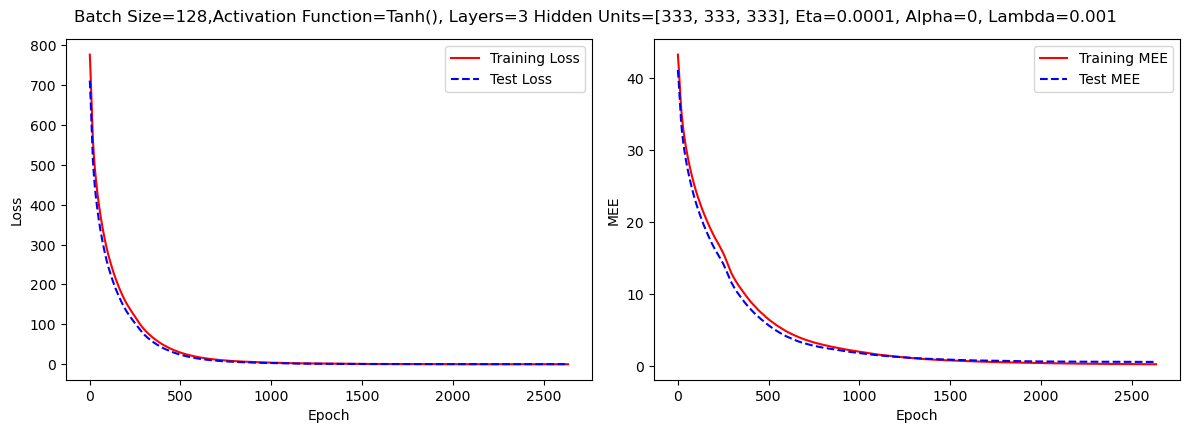


Inizializzazione 2\15
Training - Epoch [2672/5000], Loss: 0.0386, MEE: 0.2692 | Test - Epoch [2672/5000], Loss: 0.2162 MEE: 0.5596     
 N. Epochs = 2672 - Loss (train | test)= (0.03857 | 0.2162) - MEE (train | test) = (0.2691614031791687 | 0.559614896774292) - MAE (train | test) = (0.13661648333072662 | 0.28031718730926514 - MSE (train | test) = (0.038568392395973206 | 0.21622633934020996))


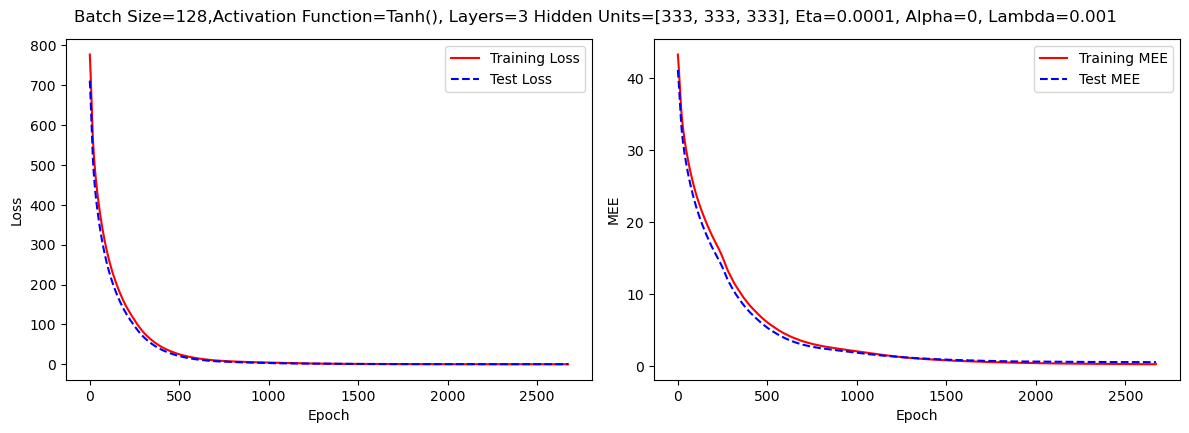


Inizializzazione 3\15
Training - Epoch [2583/5000], Loss: 0.0442, MEE: 0.2918 | Test - Epoch [2583/5000], Loss: 0.2545 MEE: 0.5751     
 N. Epochs = 2583 - Loss (train | test)= (0.04424 | 0.2545) - MEE (train | test) = (0.2918429672718048 | 0.575061559677124) - MAE (train | test) = (0.14965881407260895 | 0.28409329056739807 - MSE (train | test) = (0.04424168914556503 | 0.254507452249527))


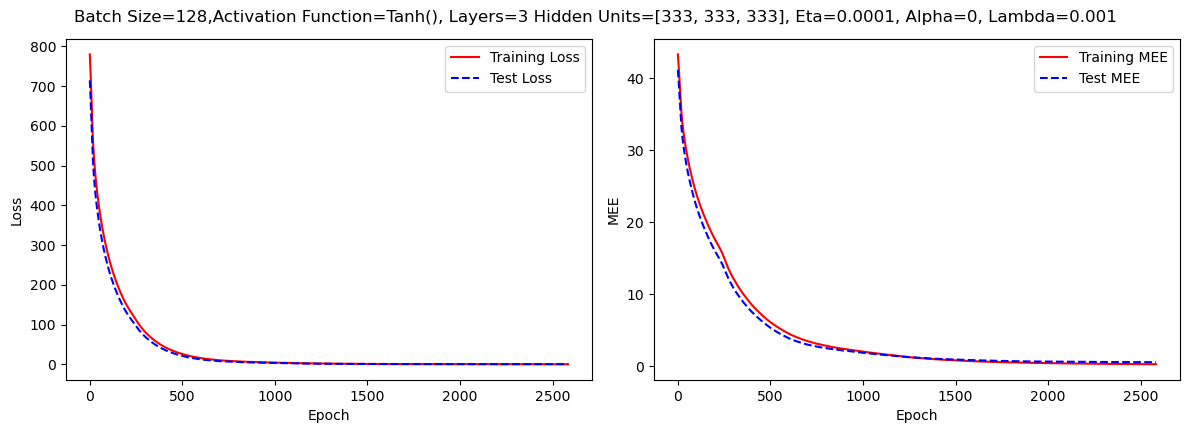


Inizializzazione 4\15
Training - Epoch [2598/5000], Loss: 0.0515, MEE: 0.2942 | Test - Epoch [2598/5000], Loss: 0.2523 MEE: 0.5891     
 N. Epochs = 2598 - Loss (train | test)= (0.0515 | 0.2523) - MEE (train | test) = (0.29419904947280884 | 0.5890843272209167) - MAE (train | test) = (0.15038955211639404 | 0.29023271799087524 - MSE (train | test) = (0.051504991948604584 | 0.2523413598537445))


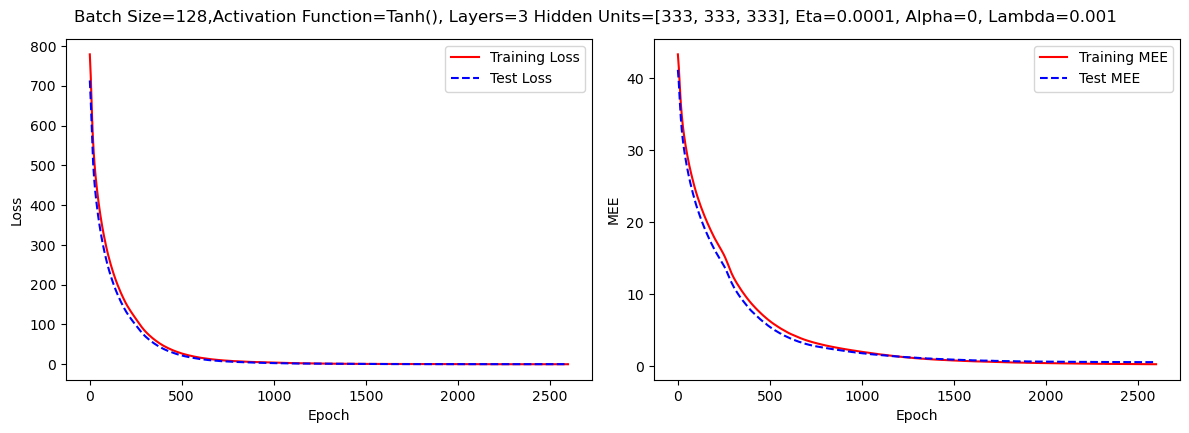


Inizializzazione 5\15
Training - Epoch [2551/5000], Loss: 0.0505, MEE: 0.2935 | Test - Epoch [2551/5000], Loss: 0.2855 MEE: 0.5911     
 N. Epochs = 2551 - Loss (train | test)= (0.05046 | 0.2855) - MEE (train | test) = (0.29352328181266785 | 0.5910861492156982) - MAE (train | test) = (0.15041589736938477 | 0.29550686478614807 - MSE (train | test) = (0.05046335235238075 | 0.2854875922203064))


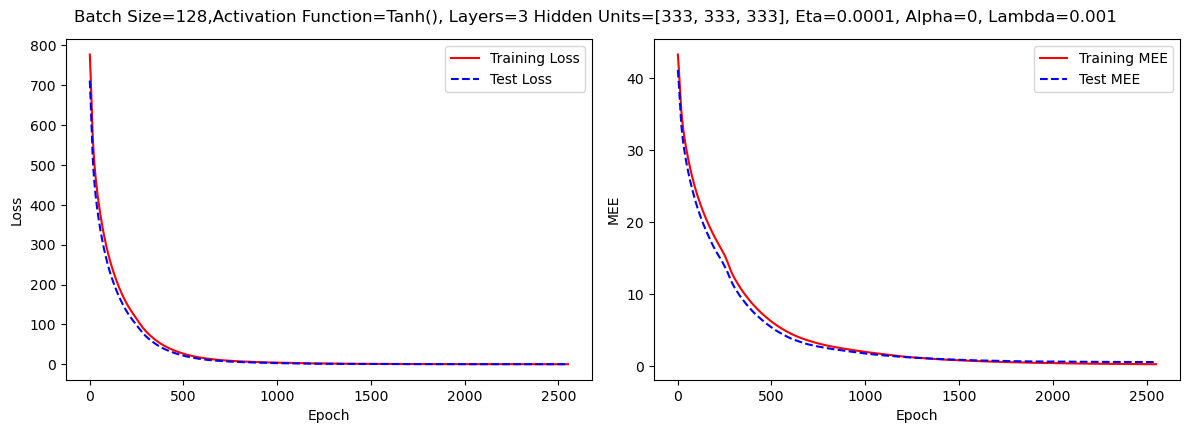


Inizializzazione 6\15
Training - Epoch [2083/5000], Loss: 0.0885, MEE: 0.3462 | Test - Epoch [2083/5000], Loss: 0.5633 MEE: 0.8409     
 N. Epochs = 2083 - Loss (train | test)= (0.08854 | 0.5633) - MEE (train | test) = (0.34624183177948 | 0.8408985137939453) - MAE (train | test) = (0.17614635825157166 | 0.41452500224113464 - MSE (train | test) = (0.08854332566261292 | 0.5632764101028442))


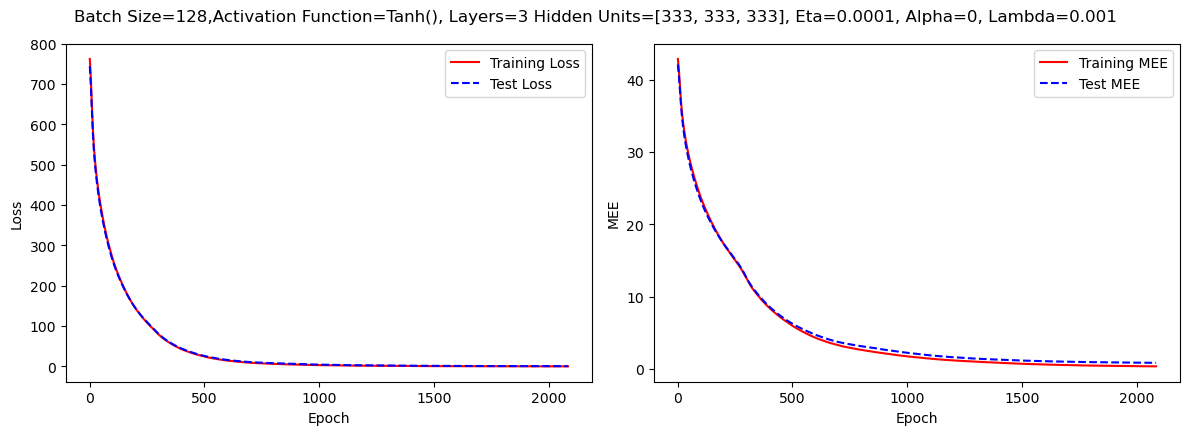


Inizializzazione 7\15
Training - Epoch [2243/5000], Loss: 0.0703, MEE: 0.3268 | Test - Epoch [2243/5000], Loss: 0.5472 MEE: 0.8225     
 N. Epochs = 2243 - Loss (train | test)= (0.07033 | 0.5472) - MEE (train | test) = (0.3267800807952881 | 0.8224786520004272) - MAE (train | test) = (0.1660824865102768 | 0.4044676423072815 - MSE (train | test) = (0.07033146172761917 | 0.5471543073654175))


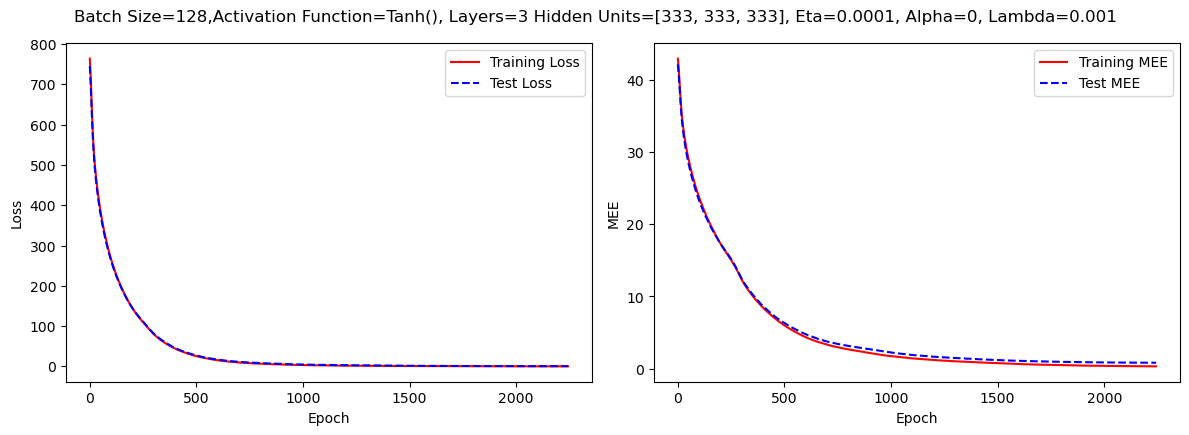


Inizializzazione 8\15
Training - Epoch [2390/5000], Loss: 0.0761, MEE: 0.3102 | Test - Epoch [2390/5000], Loss: 0.5076 MEE: 0.7711     
 N. Epochs = 2390 - Loss (train | test)= (0.07615 | 0.5076) - MEE (train | test) = (0.3101615011692047 | 0.7711440324783325) - MAE (train | test) = (0.1573636531829834 | 0.3767400085926056 - MSE (train | test) = (0.0761452242732048 | 0.5075860023498535))


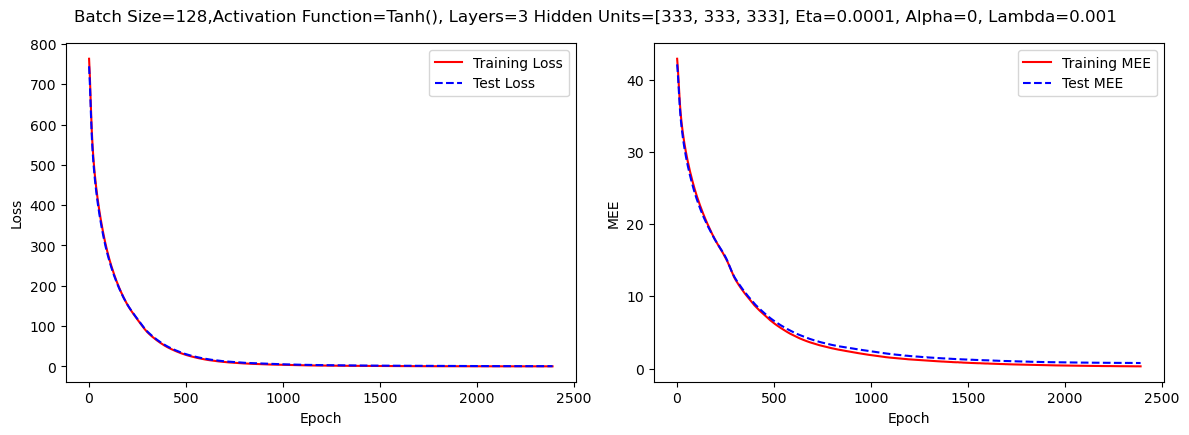


Inizializzazione 9\15
Training - Epoch [2149/5000], Loss: 0.0780, MEE: 0.3375 | Test - Epoch [2149/5000], Loss: 0.5615 MEE: 0.8233     
 N. Epochs = 2149 - Loss (train | test)= (0.07803 | 0.5615) - MEE (train | test) = (0.3375054895877838 | 0.8232607245445251) - MAE (train | test) = (0.1719544529914856 | 0.4010048508644104 - MSE (train | test) = (0.07803221791982651 | 0.5614718794822693))


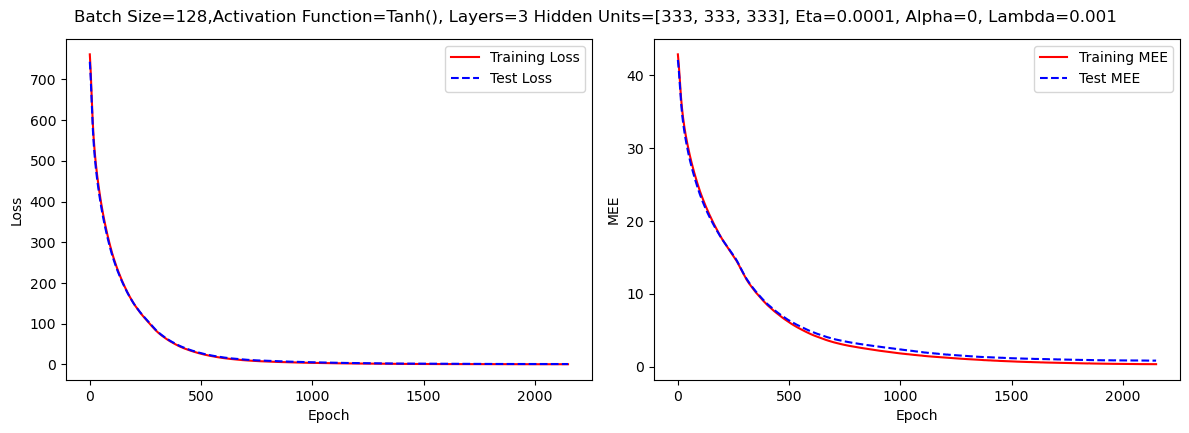


Inizializzazione 10\15
Training - Epoch [2287/5000], Loss: 0.0710, MEE: 0.3205 | Test - Epoch [2287/5000], Loss: 0.6582 MEE: 0.8635     
 N. Epochs = 2287 - Loss (train | test)= (0.07102 | 0.6582) - MEE (train | test) = (0.32046815752983093 | 0.8634913563728333) - MAE (train | test) = (0.16327156126499176 | 0.42150211334228516 - MSE (train | test) = (0.07102392613887787 | 0.6582207083702087))


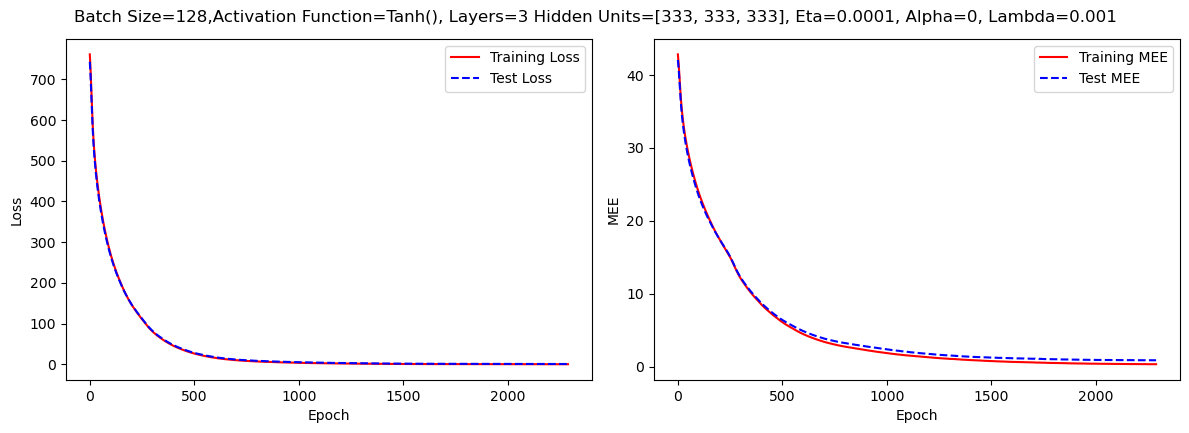


Inizializzazione 11\15
Training - Epoch [2437/5000], Loss: 0.0856, MEE: 0.3102 | Test - Epoch [2437/5000], Loss: 0.4286 MEE: 0.7853     
 N. Epochs = 2437 - Loss (train | test)= (0.08564 | 0.4286) - MEE (train | test) = (0.31020766496658325 | 0.7852638959884644) - MAE (train | test) = (0.15621258318424225 | 0.39654773473739624 - MSE (train | test) = (0.08563748002052307 | 0.42858922481536865))


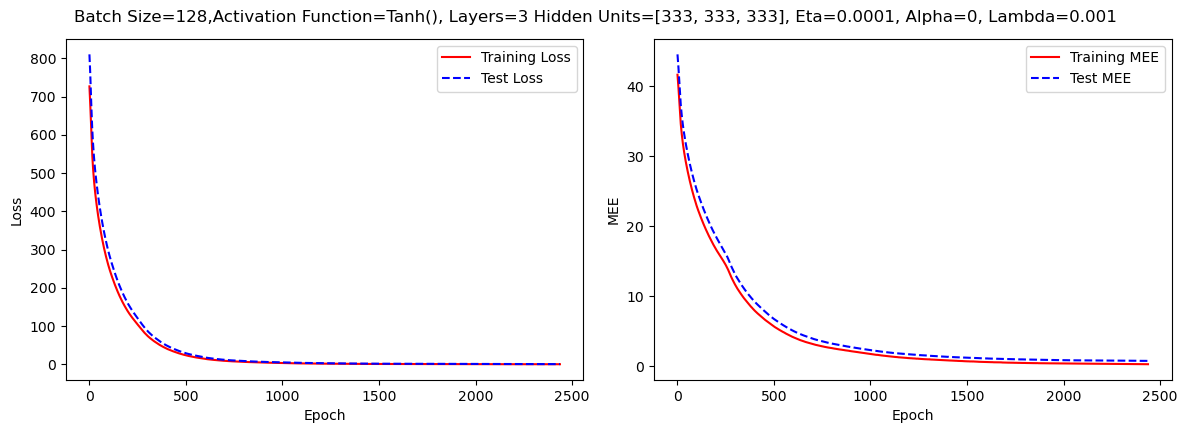


Inizializzazione 12\15
Training - Epoch [2409/5000], Loss: 0.1093, MEE: 0.3092 | Test - Epoch [2409/5000], Loss: 0.4959 MEE: 0.8156     
 N. Epochs = 2409 - Loss (train | test)= (0.1093 | 0.4959) - MEE (train | test) = (0.30915147066116333 | 0.8156386613845825) - MAE (train | test) = (0.15690894424915314 | 0.41052472591400146 - MSE (train | test) = (0.10926554352045059 | 0.4959286153316498))


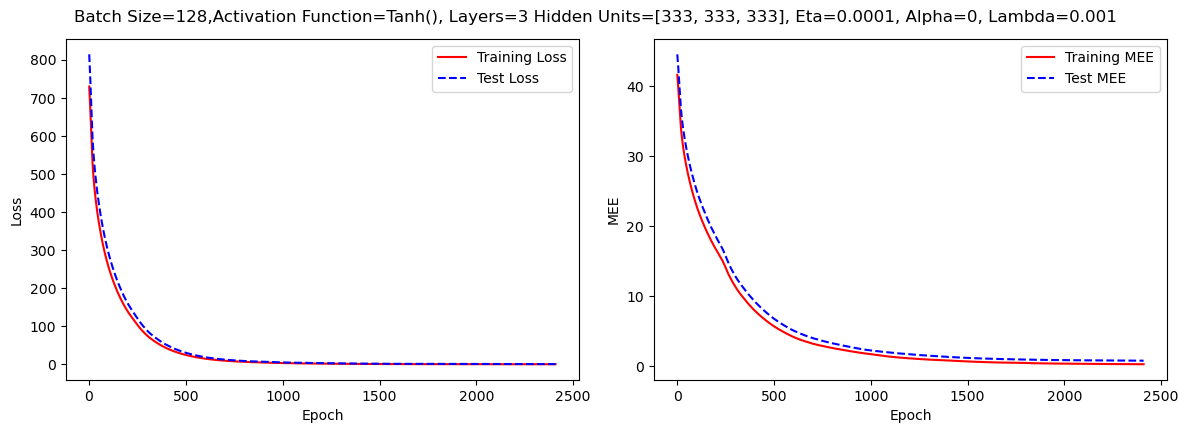


Inizializzazione 13\15
Training - Epoch [2409/5000], Loss: 0.0887, MEE: 0.3097 | Test - Epoch [2409/5000], Loss: 0.4486 MEE: 0.8071     
 N. Epochs = 2409 - Loss (train | test)= (0.08875 | 0.4486) - MEE (train | test) = (0.3096885085105896 | 0.807084321975708) - MAE (train | test) = (0.15755344927310944 | 0.4053047299385071 - MSE (train | test) = (0.0887489840388298 | 0.448625773191452))


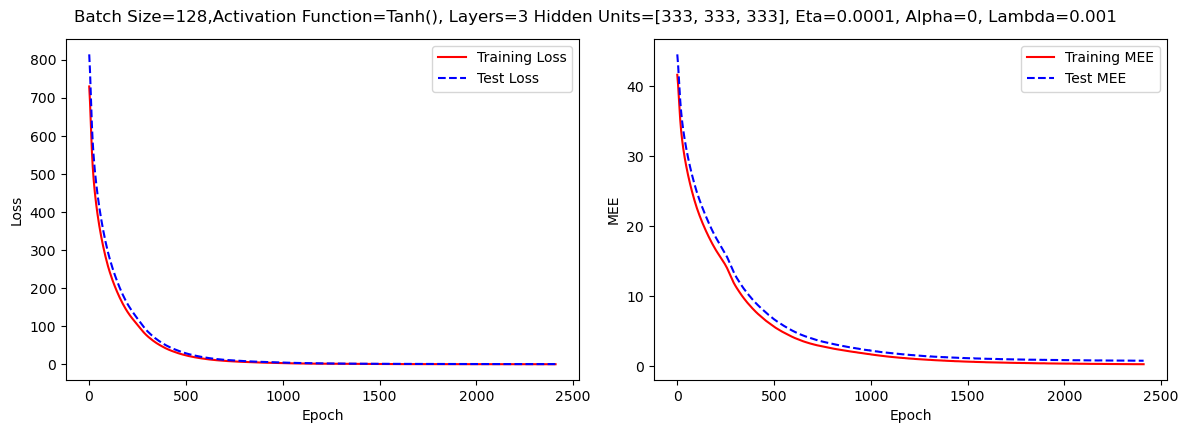


Inizializzazione 14\15
Training - Epoch [2411/5000], Loss: 0.1166, MEE: 0.3265 | Test - Epoch [2411/5000], Loss: 0.4971 MEE: 0.8395     
 N. Epochs = 2411 - Loss (train | test)= (0.1166 | 0.4971) - MEE (train | test) = (0.3265117406845093 | 0.8395478129386902) - MAE (train | test) = (0.1648542433977127 | 0.4232954680919647 - MSE (train | test) = (0.11659896373748779 | 0.4971291422843933))


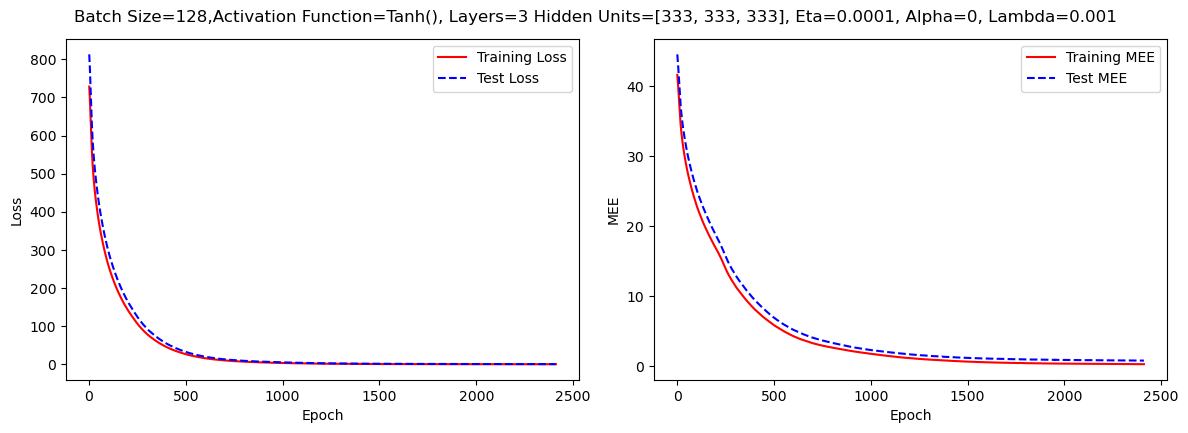


Inizializzazione 15\15
Training - Epoch [2101/5000], Loss: 0.2094, MEE: 0.3786 | Test - Epoch [2101/5000], Loss: 0.6686 MEE: 0.8958     
 N. Epochs = 2101 - Loss (train | test)= (0.2094 | 0.6686) - MEE (train | test) = (0.37862032651901245 | 0.8958198428153992) - MAE (train | test) = (0.19158098101615906 | 0.45432722568511963 - MSE (train | test) = (0.20942148566246033 | 0.6686198115348816))


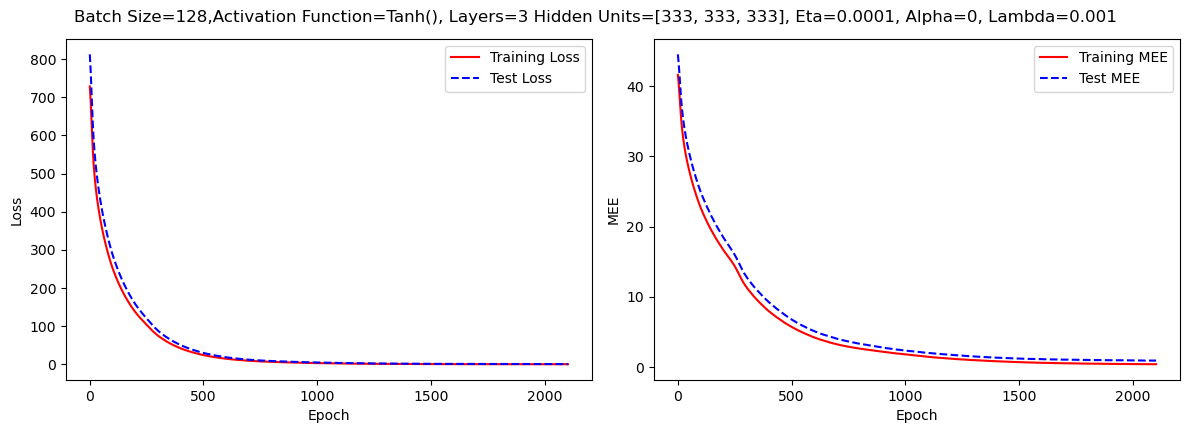


----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; learning rate decay = 0.95; momentum decay = 1; epoch decay = 100 
--> train_loss = 0.08133 +- 0.0412 | val_loss = 0.4461 +- 0.1445 
train_mee = 0.3136 +- 0.02666 | val_mee = 0.7454 +- 0.1183 
train_mae = 0.1594 +- 0.01328 | val_mae = 0.3707 +- 0.05903 
train_mse = 0.08133 +- 0.0412 | val_mse = 0.4461 +- 0.1445
mean max epoch = 2397


---- MIGLIORI RISULTATI MEE ----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; learning rate decay = 0.95; momentum decay = 1; epoch decay = 100 
--> train_loss = 0.08133 +- 0.0412 | val_loss = 0.4461 +- 0.1445 
train_mee = 0.3136 +- 0.02666 | val_mee = 0.7454 +- 0.

In [15]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.95]
mom_decays = [1]
epoch_decays = [100]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=True,
                                    N=5)


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 50

Inizializzazione 1\15
Training - Epoch [1422/5000], Loss: 0.1422, MEE: 0.3557 | Test - Epoch [1422/5000], Loss: 0.3169 MEE: 0.6346     
 N. Epochs = 1422 - Loss (train | test)= (0.1422 | 0.3169) - MEE (train | test) = (0.35567280650138855 | 0.6345632076263428) - MAE (train | test) = (0.18202714622020721 | 0.32505327463150024 - MSE (train | test) = (0.14216558635234833 | 0.3169076144695282))


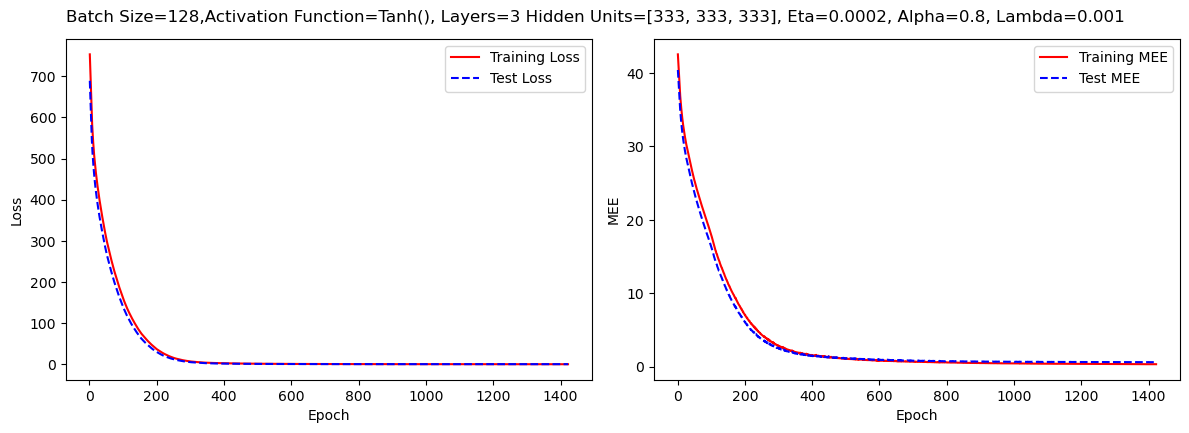


Inizializzazione 2\15
Training - Epoch [1177/5000], Loss: 0.1553, MEE: 0.3953 | Test - Epoch [1177/5000], Loss: 0.2920 MEE: 0.6335     
 N. Epochs = 1177 - Loss (train | test)= (0.1553 | 0.292) - MEE (train | test) = (0.3953166902065277 | 0.6335084438323975) - MAE (train | test) = (0.2018558382987976 | 0.32053980231285095 - MSE (train | test) = (0.15528088808059692 | 0.2920037806034088))


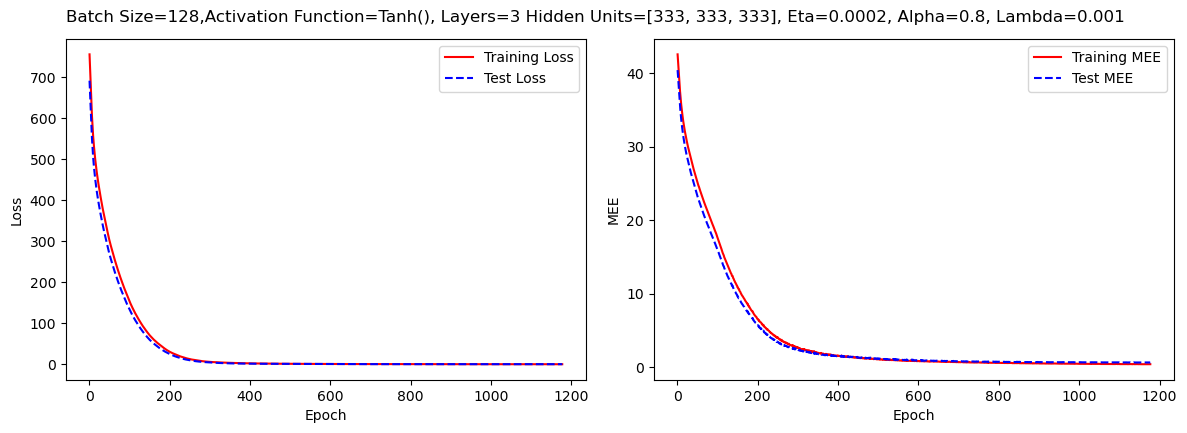


Inizializzazione 3\15
Training - Epoch [1547/5000], Loss: 0.0760, MEE: 0.3344 | Test - Epoch [1547/5000], Loss: 0.3018 MEE: 0.6101     
 N. Epochs = 1547 - Loss (train | test)= (0.07599 | 0.3018) - MEE (train | test) = (0.33444565534591675 | 0.6101268529891968) - MAE (train | test) = (0.17061907052993774 | 0.3114880323410034 - MSE (train | test) = (0.07598788291215897 | 0.3018149733543396))


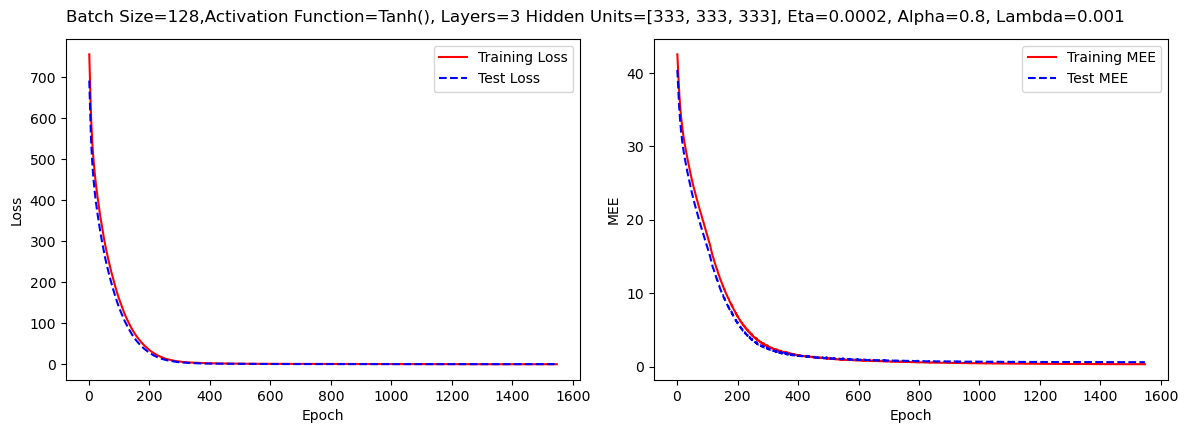


Inizializzazione 4\15
Training - Epoch [1044/5000], Loss: 0.1282, MEE: 0.4124 | Test - Epoch [1044/5000], Loss: 0.2793 MEE: 0.6310     
 N. Epochs = 1044 - Loss (train | test)= (0.1282 | 0.2793) - MEE (train | test) = (0.41235408186912537 | 0.6310376524925232) - MAE (train | test) = (0.20864339172840118 | 0.32470786571502686 - MSE (train | test) = (0.12817586958408356 | 0.27925434708595276))


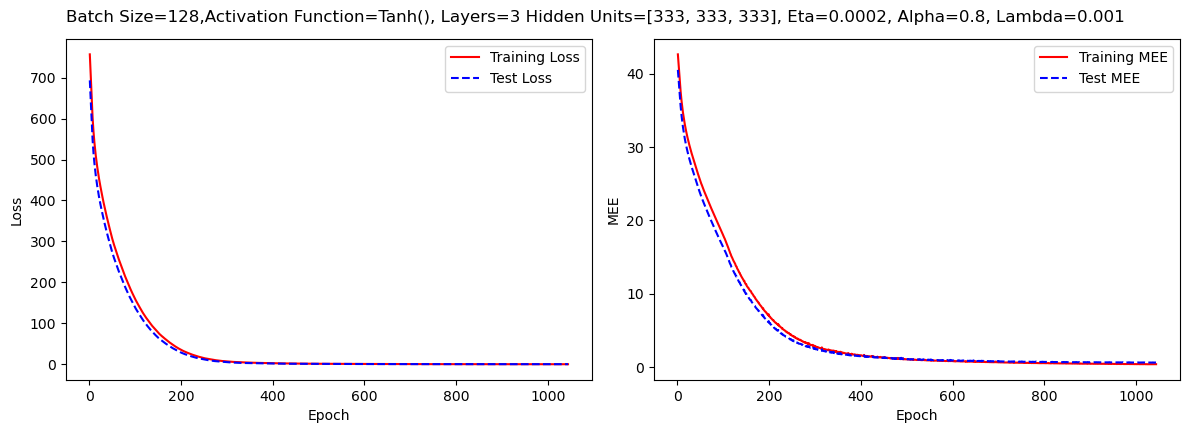


Inizializzazione 5\15
Training - Epoch [1305/5000], Loss: 0.0635, MEE: 0.3472 | Test - Epoch [1305/5000], Loss: 0.2956 MEE: 0.6323     
 N. Epochs = 1305 - Loss (train | test)= (0.06346 | 0.2956) - MEE (train | test) = (0.3472261130809784 | 0.6322541236877441) - MAE (train | test) = (0.1767330765724182 | 0.32123321294784546 - MSE (train | test) = (0.06346037983894348 | 0.29560792446136475))


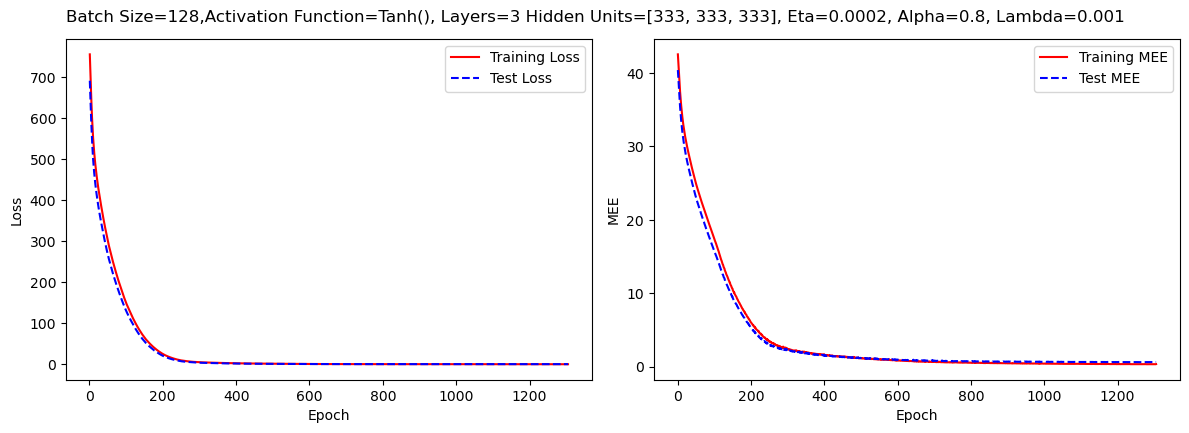


Inizializzazione 6\15
Training - Epoch [1285/5000], Loss: 0.0639, MEE: 0.3069 | Test - Epoch [1285/5000], Loss: 0.5945 MEE: 0.8341   6 
 N. Epochs = 1285 - Loss (train | test)= (0.06393 | 0.5945) - MEE (train | test) = (0.306908518075943 | 0.8341302871704102) - MAE (train | test) = (0.15596425533294678 | 0.41613519191741943 - MSE (train | test) = (0.06392659991979599 | 0.5944958925247192))


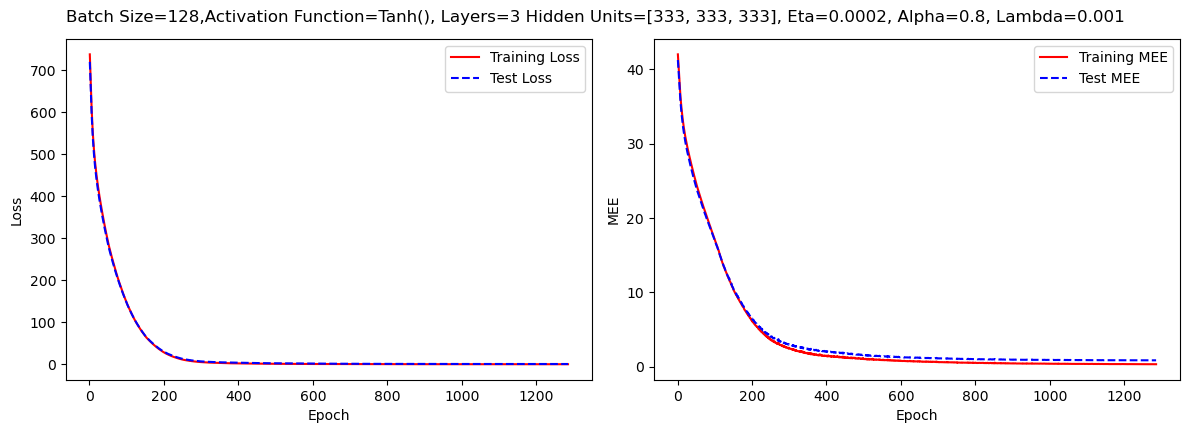


Inizializzazione 7\15
Training - Epoch [1048/5000], Loss: 0.0661, MEE: 0.3359 | Test - Epoch [1048/5000], Loss: 0.6502 MEE: 0.8947   8 
 N. Epochs = 1048 - Loss (train | test)= (0.06613 | 0.6502) - MEE (train | test) = (0.33593571186065674 | 0.8947135806083679) - MAE (train | test) = (0.17015159130096436 | 0.4419489800930023 - MSE (train | test) = (0.066127710044384 | 0.6502092480659485))


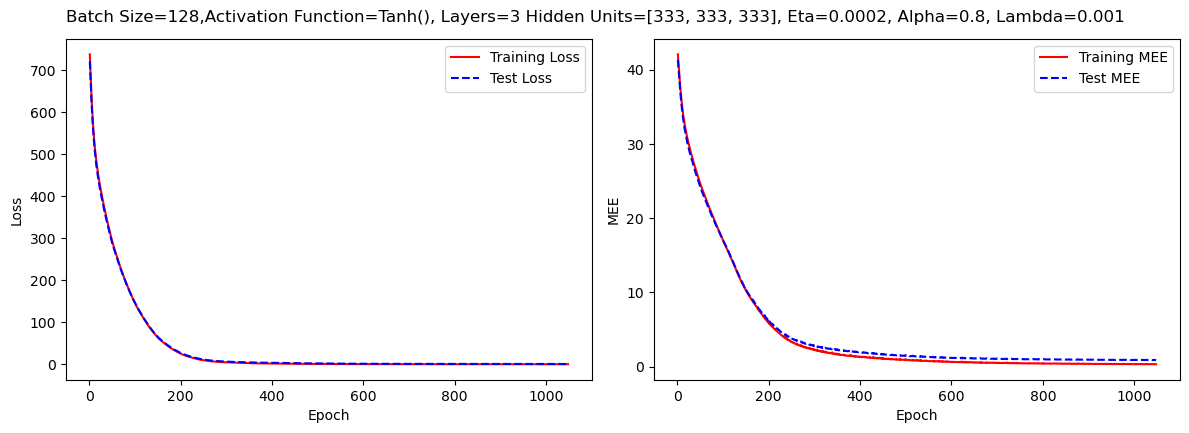


Inizializzazione 8\15
Training - Epoch [1244/5000], Loss: 0.0827, MEE: 0.3321 | Test - Epoch [1244/5000], Loss: 0.6378 MEE: 0.8669   8 
 N. Epochs = 1244 - Loss (train | test)= (0.08265 | 0.6378) - MEE (train | test) = (0.3320592939853668 | 0.8668951392173767) - MAE (train | test) = (0.17006877064704895 | 0.43186208605766296 - MSE (train | test) = (0.0826542004942894 | 0.6377853155136108))


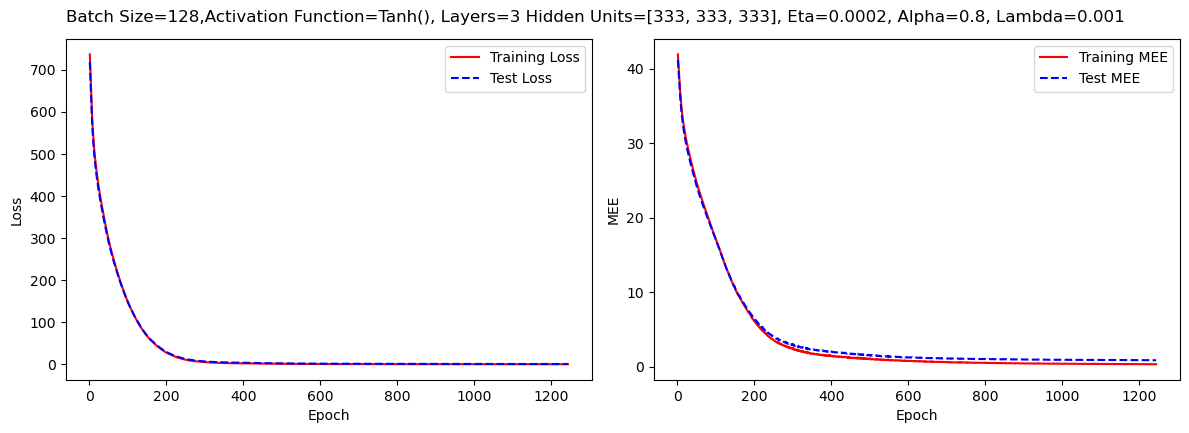


Inizializzazione 9\15
Training - Epoch [1150/5000], Loss: 0.0787, MEE: 0.3485 | Test - Epoch [1150/5000], Loss: 0.6839 MEE: 0.9104     
 N. Epochs = 1150 - Loss (train | test)= (0.07867 | 0.6839) - MEE (train | test) = (0.3484817445278168 | 0.9103742837905884) - MAE (train | test) = (0.1769748479127884 | 0.44636327028274536 - MSE (train | test) = (0.0786660686135292 | 0.6839144229888916))


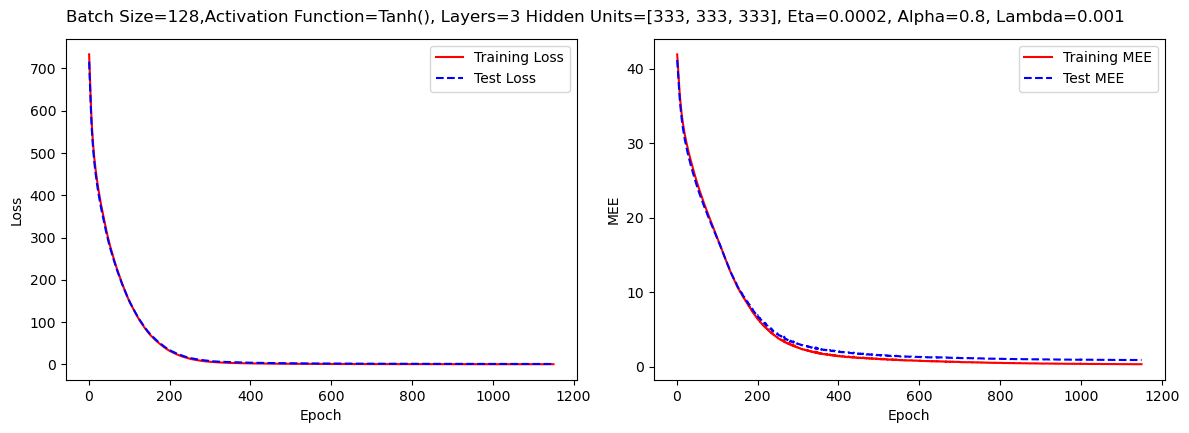


Inizializzazione 10\15
Training - Epoch [1181/5000], Loss: 0.0832, MEE: 0.3553 | Test - Epoch [1181/5000], Loss: 0.6172 MEE: 0.8557     
 N. Epochs = 1181 - Loss (train | test)= (0.08316 | 0.6172) - MEE (train | test) = (0.35529062151908875 | 0.8557414412498474) - MAE (train | test) = (0.1793142706155777 | 0.42520400881767273 - MSE (train | test) = (0.08316481113433838 | 0.6171875596046448))


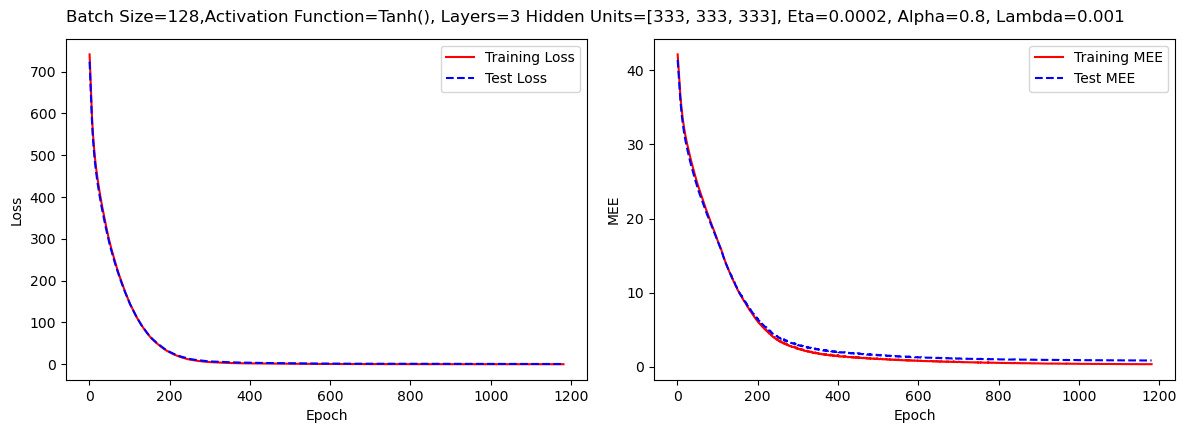


Inizializzazione 11\15
Training - Epoch [1023/5000], Loss: 0.1793, MEE: 0.3702 | Test - Epoch [1023/5000], Loss: 0.5935 MEE: 0.8720     
 N. Epochs = 1023 - Loss (train | test)= (0.1793 | 0.5935) - MEE (train | test) = (0.37022900581359863 | 0.8720445036888123) - MAE (train | test) = (0.18756328523159027 | 0.43796586990356445 - MSE (train | test) = (0.1793496012687683 | 0.5934555530548096))


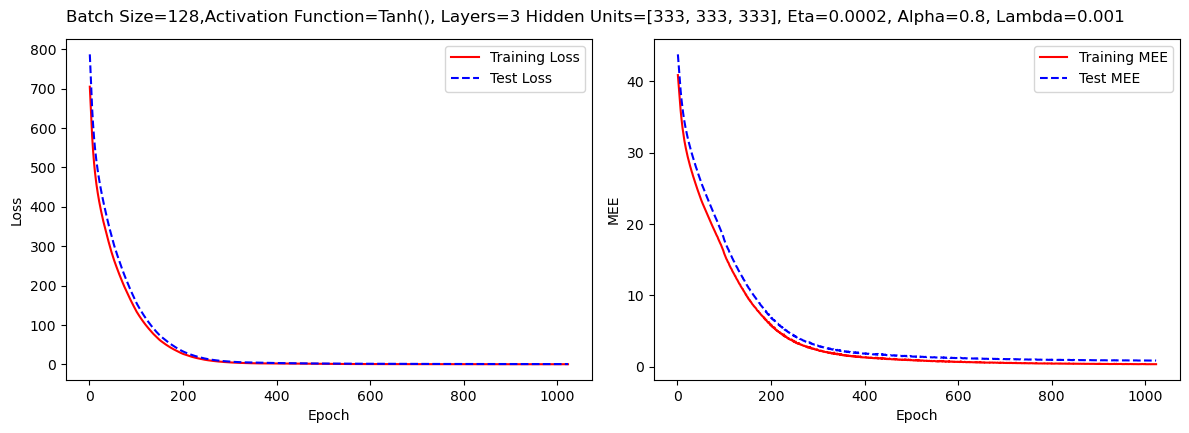


Inizializzazione 12\15
Training - Epoch [1228/5000], Loss: 0.1638, MEE: 0.3670 | Test - Epoch [1228/5000], Loss: 0.6214 MEE: 0.9015     
 N. Epochs = 1228 - Loss (train | test)= (0.1638 | 0.6214) - MEE (train | test) = (0.3669758439064026 | 0.9014859199523926) - MAE (train | test) = (0.1872551292181015 | 0.45845264196395874 - MSE (train | test) = (0.16381807625293732 | 0.6214396953582764))


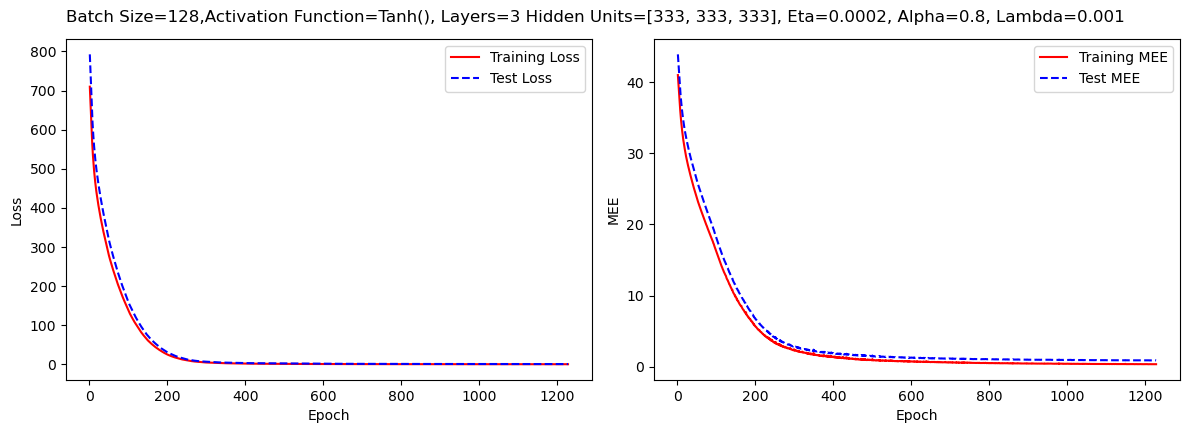


Inizializzazione 13\15
Training - Epoch [720/5000], Loss: 0.3493, MEE: 0.5529 | Test - Epoch [720/5000], Loss: 0.9408 MEE: 1.0854       
 N. Epochs = 720 - Loss (train | test)= (0.3493 | 0.9408) - MEE (train | test) = (0.5529260635375977 | 1.0854394435882568) - MAE (train | test) = (0.28013765811920166 | 0.5573785901069641 - MSE (train | test) = (0.34930965304374695 | 0.9408460855484009))


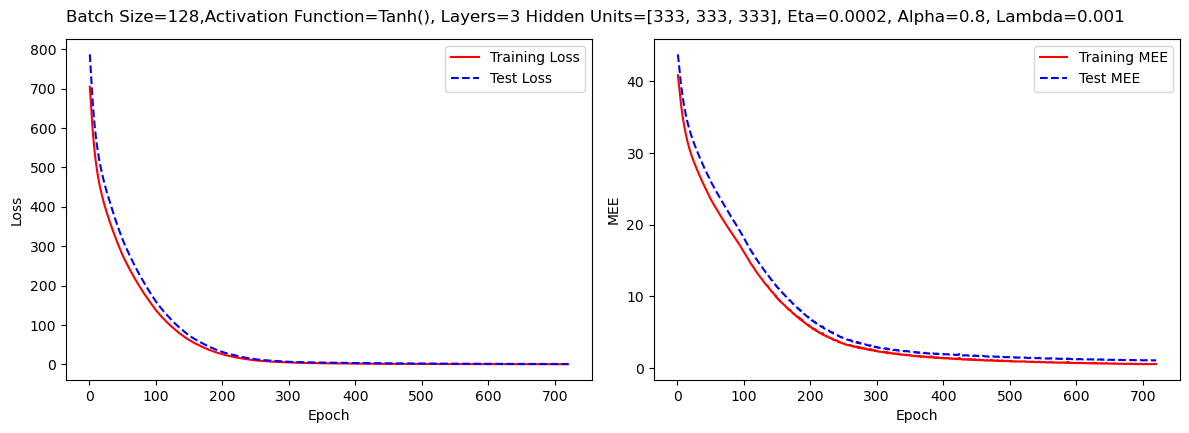


Inizializzazione 14\15
Training - Epoch [1049/5000], Loss: 0.2076, MEE: 0.3666 | Test - Epoch [1049/5000], Loss: 0.6601 MEE: 0.8944     
 N. Epochs = 1049 - Loss (train | test)= (0.2076 | 0.6601) - MEE (train | test) = (0.36658599972724915 | 0.8943516612052917) - MAE (train | test) = (0.18592068552970886 | 0.45281296968460083 - MSE (train | test) = (0.20763379335403442 | 0.6600516438484192))


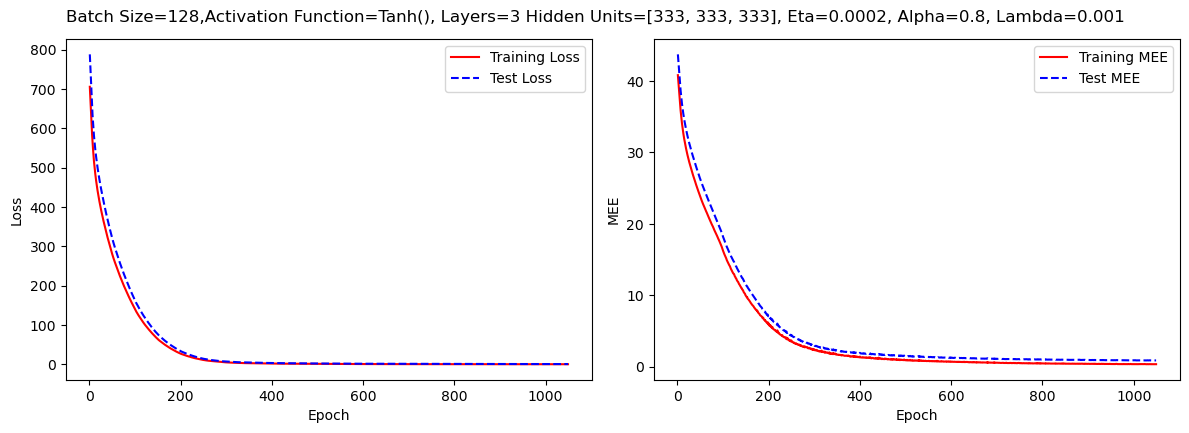


Inizializzazione 15\15
Training - Epoch [906/5000], Loss: 0.2804, MEE: 0.4444 | Test - Epoch [906/5000], Loss: 0.7820 MEE: 0.9637       
 N. Epochs = 906 - Loss (train | test)= (0.2804 | 0.782) - MEE (train | test) = (0.44438594579696655 | 0.9636834859848022) - MAE (train | test) = (0.22578193247318268 | 0.49082091450691223 - MSE (train | test) = (0.28035810589790344 | 0.7820358276367188))


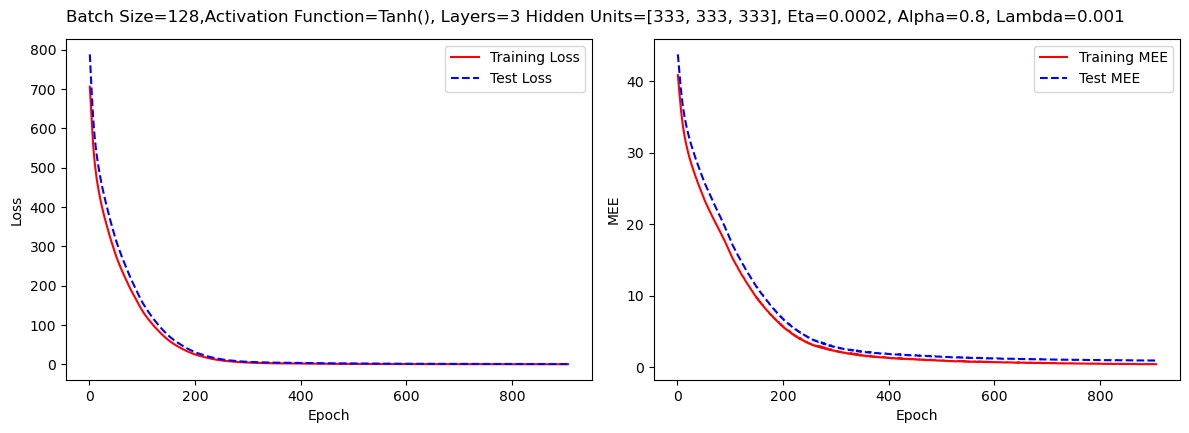


----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; learning rate decay = 0.9; momentum decay = 0.9; epoch decay = 50 
--> train_loss = 0.1413 +- 0.08248 | val_loss = 0.5511 +- 0.1981 
train_mee = 0.375 +- 0.05792 | val_mee = 0.8147 +- 0.1431 
train_mae = 0.1906 +- 0.02917 | val_mae = 0.4108 +- 0.07136 
train_mse = 0.1413 +- 0.08248 | val_mse = 0.5511 +- 0.1981
mean max epoch = 1155


---- MIGLIORI RISULTATI MEE ----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0002; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; learning rate decay = 0.9; momentum decay = 0.9; epoch decay = 50 
--> train_loss = 0.1413 +- 0.08248 | val_loss = 0.5511 +- 0.1981 
train_mee = 0.375 +- 0.05792 | val_mee = 0.81

In [19]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [2e-04]
momentums = [0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9]
epoch_decays = [50]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=True,
                                    N=5)


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150

Inizializzazione 1\15
Training - Epoch [1127/5000], Loss: 0.1956, MEE: 0.6674 | Test - Epoch [1127/5000], Loss: 0.3512 MEE: 0.8056 
 N. Epochs = 1127 - Loss (train | test)= (0.1956 | 0.3512) - MEE (train | test) = (0.6673957705497742 | 0.8056146502494812) - MAE (train | test) = (0.33262741565704346 | 0.401019811630249 - MSE (train | test) = (0.19564035534858704 | 0.3512321710586548))


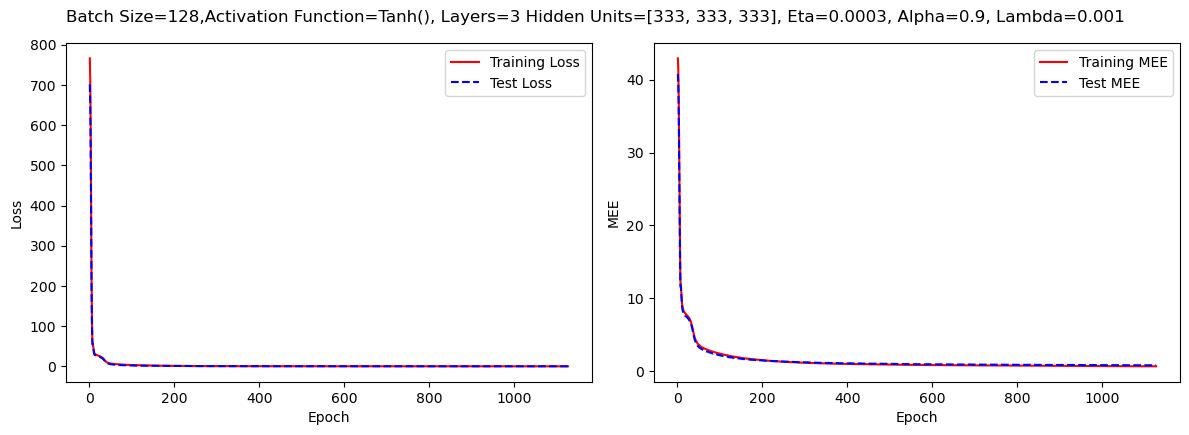


Inizializzazione 2\15
Training - Epoch [1187/5000], Loss: 0.1846, MEE: 0.6448 | Test - Epoch [1187/5000], Loss: 0.3230 MEE: 0.7797 
 N. Epochs = 1187 - Loss (train | test)= (0.1846 | 0.323) - MEE (train | test) = (0.6447950601577759 | 0.779667317867279) - MAE (train | test) = (0.3208243250846863 | 0.3913992941379547 - MSE (train | test) = (0.1846494972705841 | 0.3229551911354065))


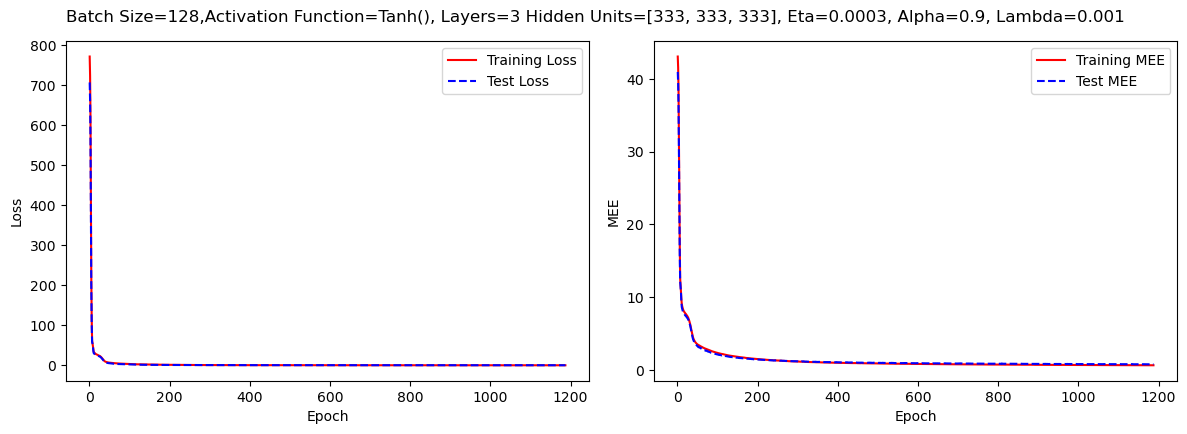


Inizializzazione 3\15
Training - Epoch [1267/5000], Loss: 0.1718, MEE: 0.6227 | Test - Epoch [1267/5000], Loss: 0.3193 MEE: 0.7615 
 N. Epochs = 1267 - Loss (train | test)= (0.1718 | 0.3193) - MEE (train | test) = (0.6227133870124817 | 0.7614576816558838) - MAE (train | test) = (0.31050294637680054 | 0.3775099217891693 - MSE (train | test) = (0.1718108355998993 | 0.31933659315109253))


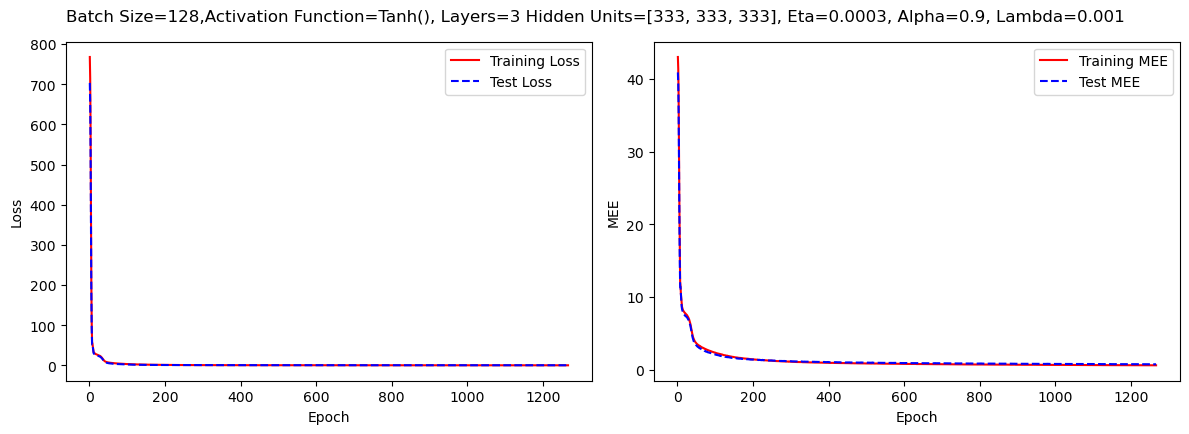


Inizializzazione 4\15
Training - Epoch [1303/5000], Loss: 0.1677, MEE: 0.6158 | Test - Epoch [1303/5000], Loss: 0.3238 MEE: 0.7709 
 N. Epochs = 1303 - Loss (train | test)= (0.1677 | 0.3238) - MEE (train | test) = (0.6158238053321838 | 0.7709400057792664) - MAE (train | test) = (0.30702924728393555 | 0.3815494775772095 - MSE (train | test) = (0.16770733892917633 | 0.3238380253314972))


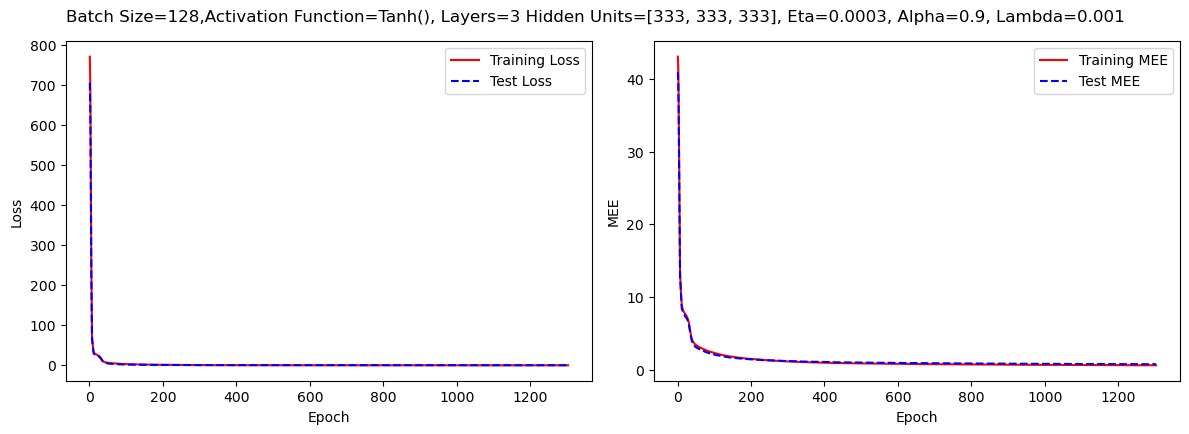


Inizializzazione 5\15
Training - Epoch [1223/5000], Loss: 0.1821, MEE: 0.6435 | Test - Epoch [1223/5000], Loss: 0.3323 MEE: 0.7911 
 N. Epochs = 1223 - Loss (train | test)= (0.1821 | 0.3323) - MEE (train | test) = (0.6434656381607056 | 0.7911168932914734) - MAE (train | test) = (0.3192990720272064 | 0.39444220066070557 - MSE (train | test) = (0.18208566308021545 | 0.33231592178344727))


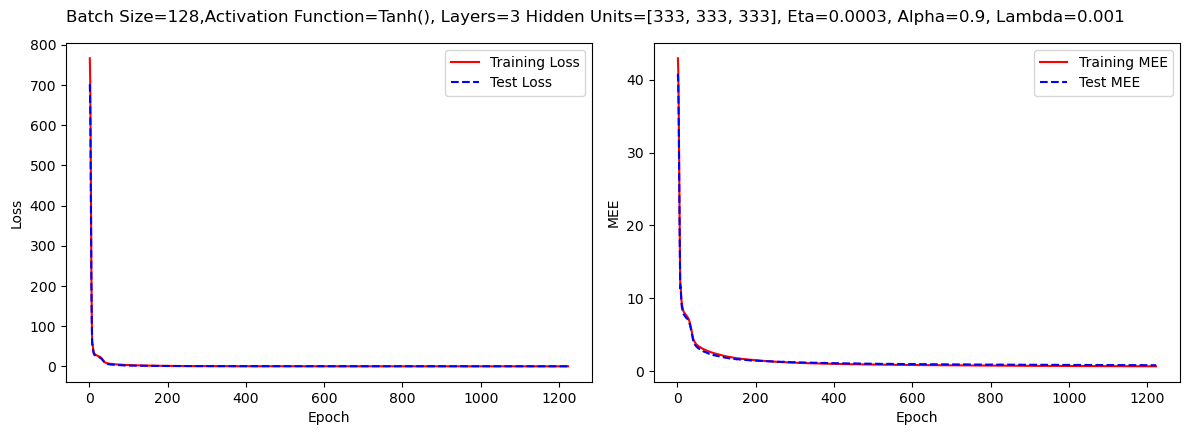


Inizializzazione 6\15
Training - Epoch [1056/5000], Loss: 0.1993, MEE: 0.6718 | Test - Epoch [1056/5000], Loss: 0.5360 MEE: 0.9887 
 N. Epochs = 1056 - Loss (train | test)= (0.1993 | 0.536) - MEE (train | test) = (0.6717832684516907 | 0.9886753559112549) - MAE (train | test) = (0.3360115587711334 | 0.4898393750190735 - MSE (train | test) = (0.19932962954044342 | 0.5360460877418518))


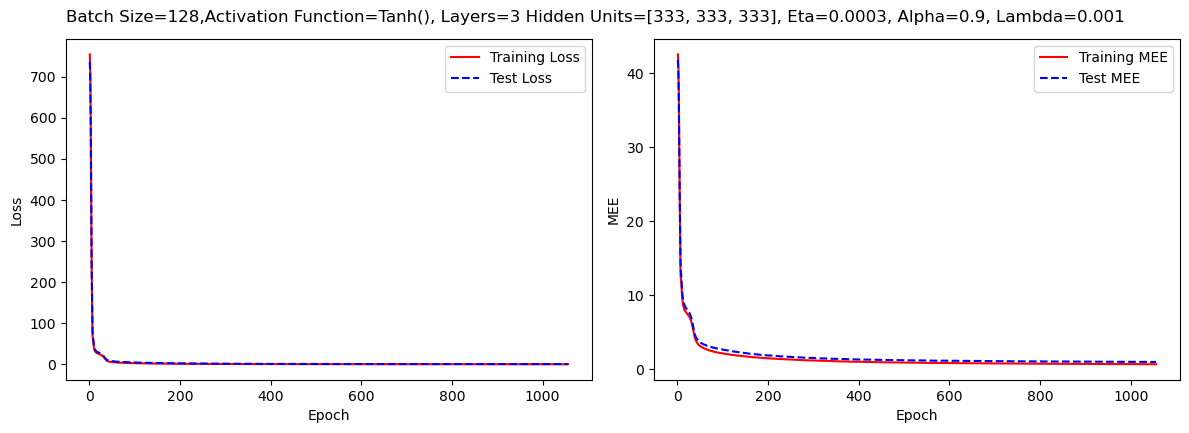


Inizializzazione 7\15
Training - Epoch [1380/5000], Loss: 0.1574, MEE: 0.5937 | Test - Epoch [1380/5000], Loss: 0.4973 MEE: 0.9322 
 N. Epochs = 1380 - Loss (train | test)= (0.1574 | 0.4973) - MEE (train | test) = (0.5936732292175293 | 0.9321951866149902) - MAE (train | test) = (0.2950854003429413 | 0.46441662311553955 - MSE (train | test) = (0.1574394255876541 | 0.4973136782646179))


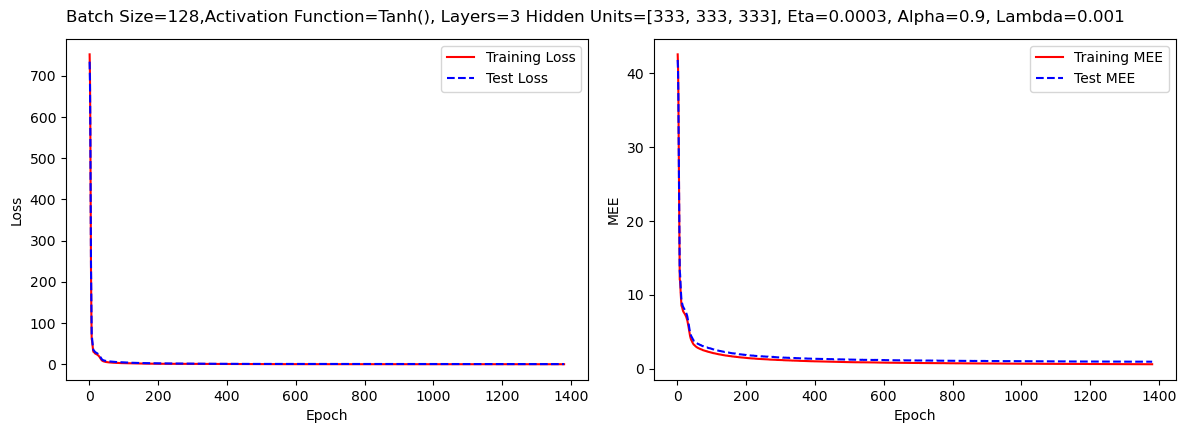


Inizializzazione 8\15
Training - Epoch [911/5000], Loss: 0.2220, MEE: 0.7067 | Test - Epoch [911/5000], Loss: 0.5854 MEE: 1.0316   
 N. Epochs = 911 - Loss (train | test)= (0.222 | 0.5854) - MEE (train | test) = (0.706745445728302 | 1.0315788984298706) - MAE (train | test) = (0.35243797302246094 | 0.5166213512420654 - MSE (train | test) = (0.22200186550617218 | 0.5854442119598389))


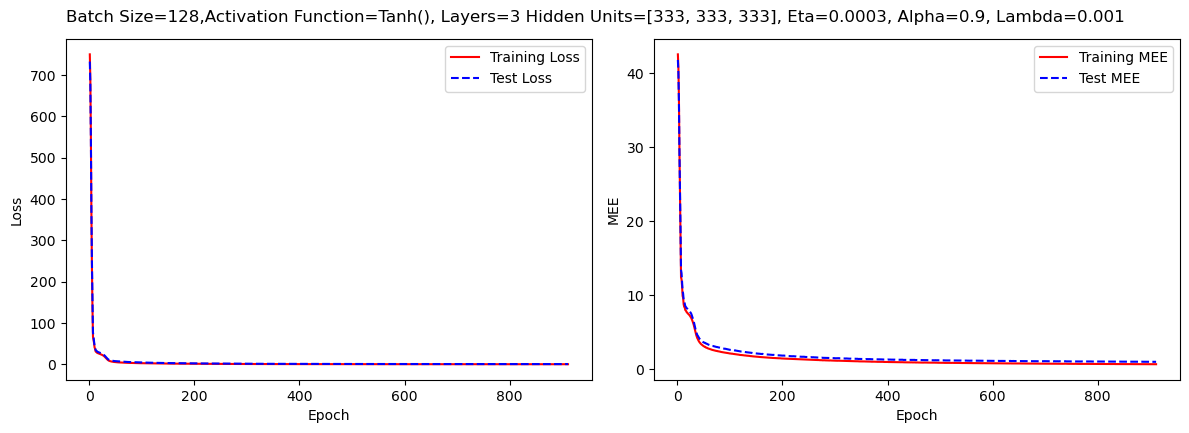


Inizializzazione 9\15
Training - Epoch [1002/5000], Loss: 0.2039, MEE: 0.6779 | Test - Epoch [1002/5000], Loss: 0.5859 MEE: 1.0272 
 N. Epochs = 1002 - Loss (train | test)= (0.2039 | 0.5859) - MEE (train | test) = (0.6778737306594849 | 1.0271815061569214) - MAE (train | test) = (0.33687546849250793 | 0.5101705193519592 - MSE (train | test) = (0.20390065014362335 | 0.5859483480453491))


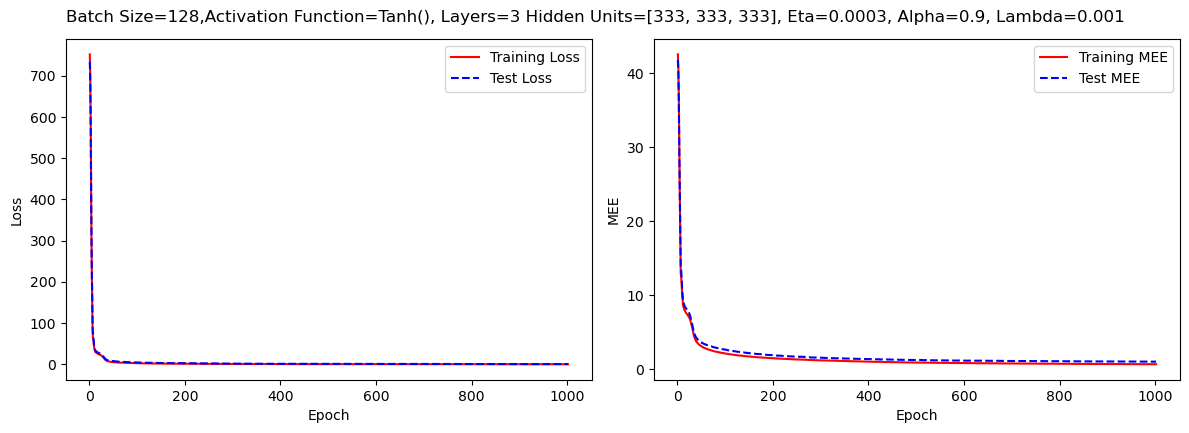


Inizializzazione 10\15
Training - Epoch [1053/5000], Loss: 0.1925, MEE: 0.6595 | Test - Epoch [1053/5000], Loss: 0.5144 MEE: 0.9711 
 N. Epochs = 1053 - Loss (train | test)= (0.1925 | 0.5144) - MEE (train | test) = (0.6595250964164734 | 0.9711483120918274) - MAE (train | test) = (0.32636722922325134 | 0.4824719727039337 - MSE (train | test) = (0.19251665472984314 | 0.5143927335739136))


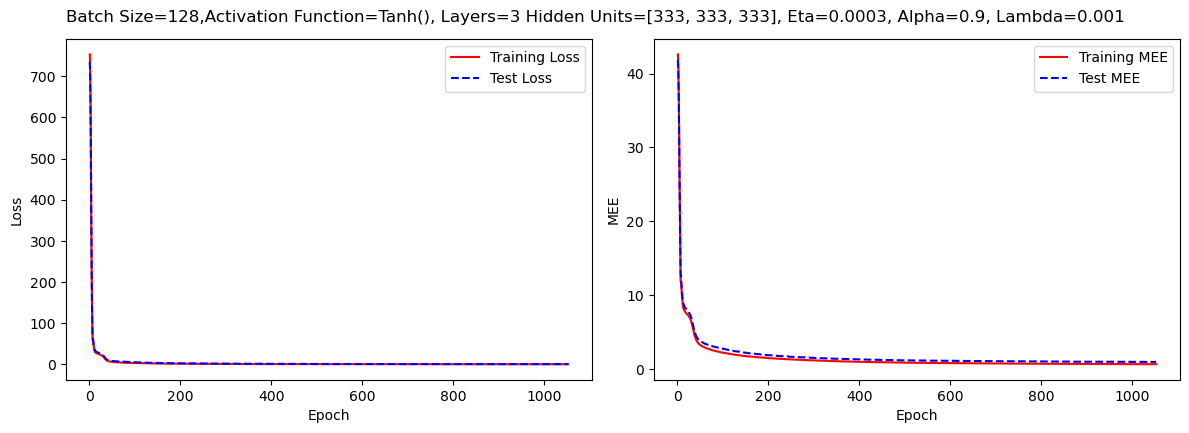


Inizializzazione 11\15
Training - Epoch [1362/5000], Loss: 0.1634, MEE: 0.6025 | Test - Epoch [1362/5000], Loss: 0.4367 MEE: 0.9212 
 N. Epochs = 1362 - Loss (train | test)= (0.1634 | 0.4367) - MEE (train | test) = (0.6025259494781494 | 0.9211692810058594) - MAE (train | test) = (0.3002099394798279 | 0.4560900628566742 - MSE (train | test) = (0.163434699177742 | 0.4367469251155853))


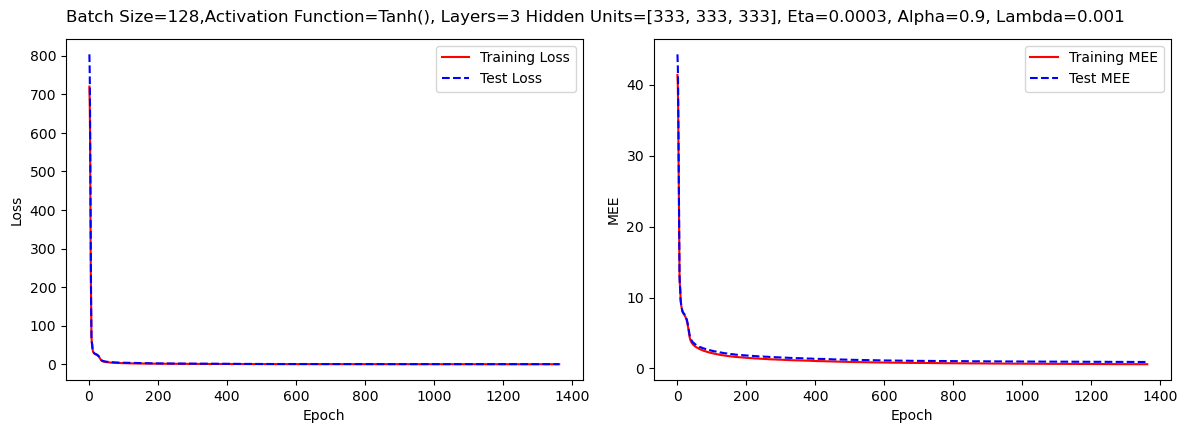


Inizializzazione 12\15
Training - Epoch [1109/5000], Loss: 0.1912, MEE: 0.6484 | Test - Epoch [1109/5000], Loss: 0.4828 MEE: 0.9635 
 N. Epochs = 1109 - Loss (train | test)= (0.1912 | 0.4828) - MEE (train | test) = (0.6483842730522156 | 0.9634754061698914) - MAE (train | test) = (0.32114484906196594 | 0.47349464893341064 - MSE (train | test) = (0.19118471443653107 | 0.48281294107437134))


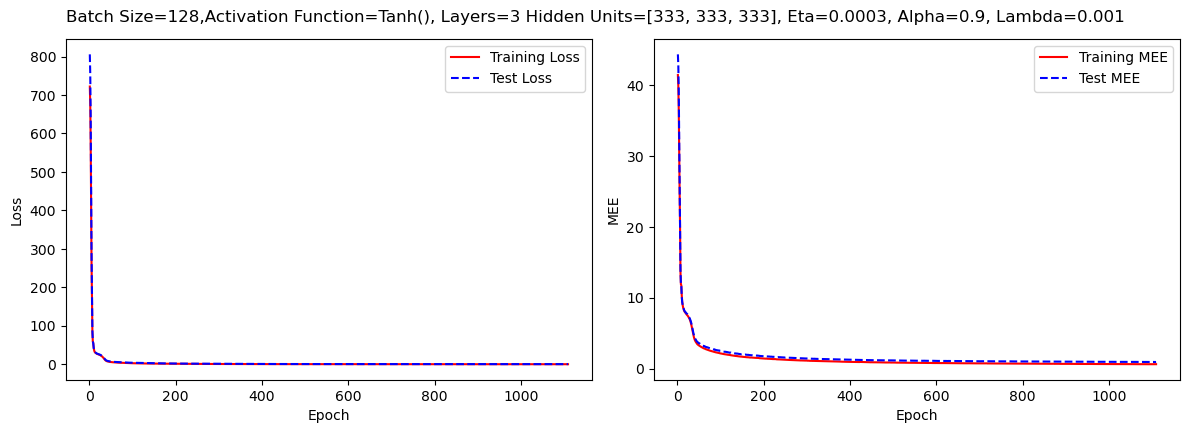


Inizializzazione 13\15
Training - Epoch [1080/5000], Loss: 0.1882, MEE: 0.6410 | Test - Epoch [1080/5000], Loss: 0.4746 MEE: 0.9595 
 N. Epochs = 1080 - Loss (train | test)= (0.1882 | 0.4746) - MEE (train | test) = (0.6409605145454407 | 0.9595175385475159) - MAE (train | test) = (0.31823304295539856 | 0.46996480226516724 - MSE (train | test) = (0.18817327916622162 | 0.47463980317115784))


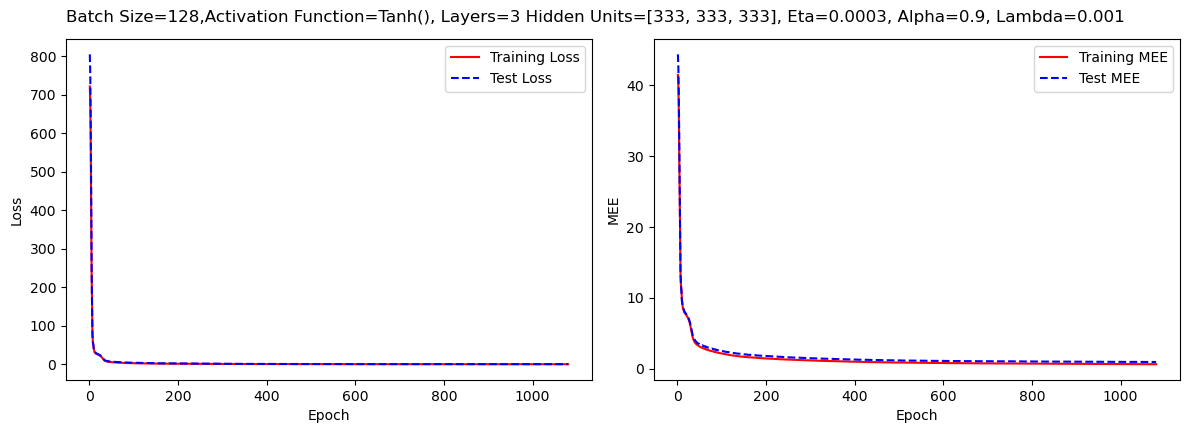


Inizializzazione 14\15
Training - Epoch [1458/5000], Loss: 0.1486, MEE: 0.5789 | Test - Epoch [1458/5000], Loss: 0.4538 MEE: 0.9161 
 N. Epochs = 1458 - Loss (train | test)= (0.1486 | 0.4538) - MEE (train | test) = (0.5789385437965393 | 0.9161354899406433) - MAE (train | test) = (0.28792819380760193 | 0.455247700214386 - MSE (train | test) = (0.14860449731349945 | 0.4537842571735382))


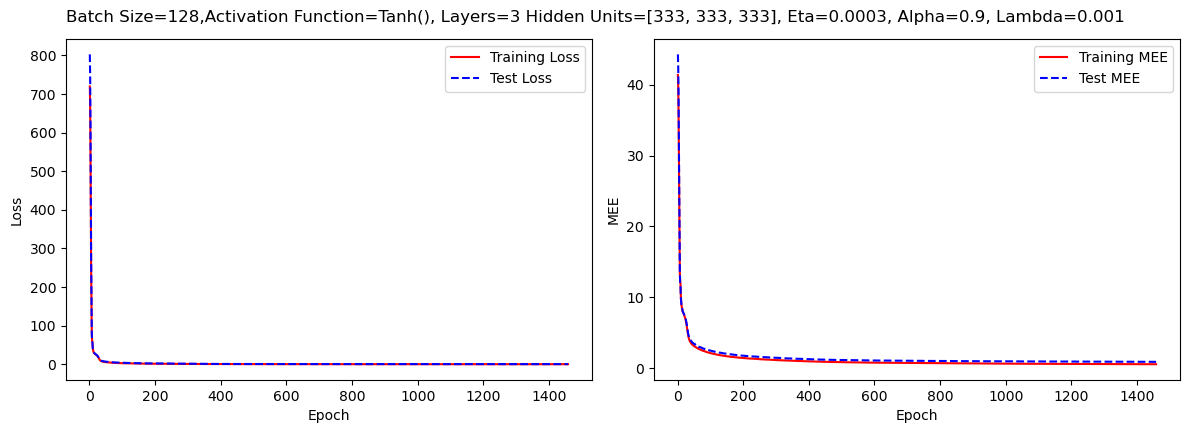


Inizializzazione 15\15
Training - Epoch [883/5000], Loss: 0.2180, MEE: 0.6807 | Test - Epoch [883/5000], Loss: 0.4930 MEE: 0.9953 4 
 N. Epochs = 883 - Loss (train | test)= (0.218 | 0.493) - MEE (train | test) = (0.6806626319885254 | 0.9952977895736694) - MAE (train | test) = (0.33827733993530273 | 0.49545150995254517 - MSE (train | test) = (0.2179504781961441 | 0.49303677678108215))


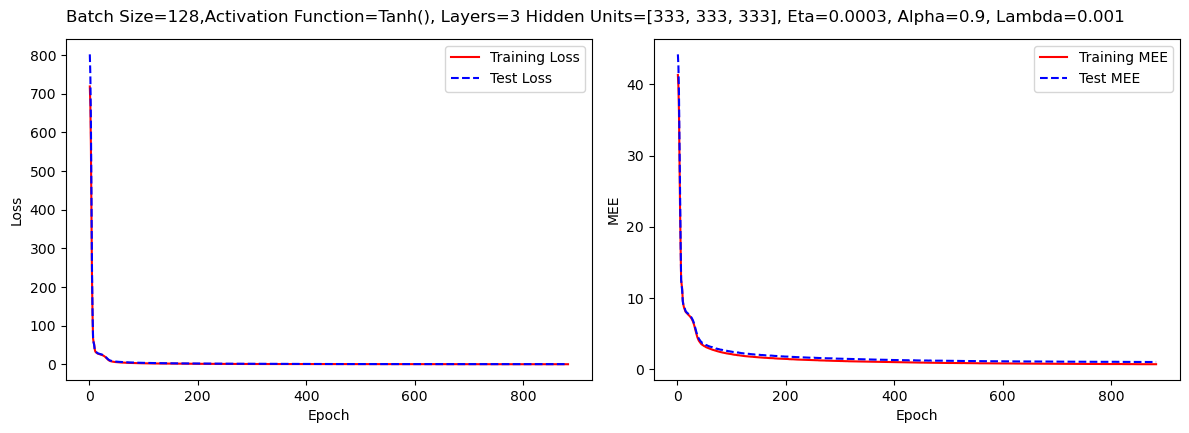


----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; learning rate decay = 0.95; momentum decay = 0.9; epoch decay = 150 
--> train_loss = 0.1858 +- 0.02042 | val_loss = 0.4473 +- 0.092 
train_mee = 0.6437 +- 0.0344 | val_mee = 0.9077 +- 0.09488 
train_mae = 0.3202 +- 0.01719 | val_mae = 0.4506 +- 0.04679 
train_mse = 0.1858 +- 0.02042 | val_mse = 0.4473 +- 0.092
mean max epoch = 1160


---- MIGLIORI RISULTATI MEE ----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; learning rate decay = 0.95; momentum decay = 0.9; epoch decay = 150 
--> train_loss = 0.1858 +- 0.02042 | val_loss = 0.4473 +- 0.092 
train_mee = 0.6437 +- 0.0344 | val_mee = 0.9077 +- 

In [17]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-04]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.95]
mom_decays = [0.9]
epoch_decays = [150]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=True,
                                    N=5)


Modello 1\3
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 300

Inizializzazione 1\9
Training - Epoch [5892/7000], Loss: 0.1652, MEE: 0.4256 | Test - Epoch [5892/7000], Loss: 0.3756 MEE: 0.6799     
 N. Epochs = 5892 - Loss (train | test)= (0.1652 | 0.3756) - MEE (train | test) = (0.4256339967250824 | 0.6799440979957581) - MAE (train | test) = (0.21887697279453278 | 0.34971675276756287 - MSE (train | test) = (0.16520407795906067 | 0.37556686997413635))


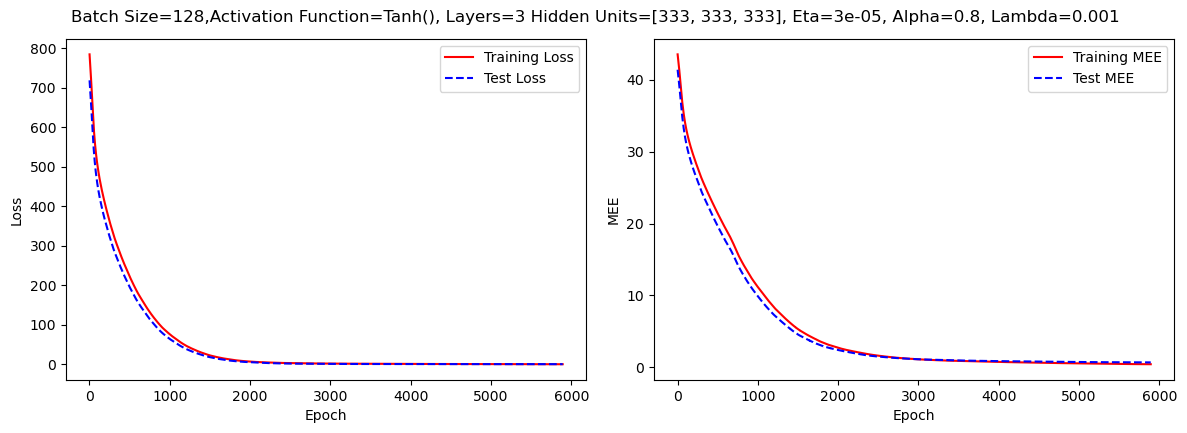


Inizializzazione 2\9
Training - Epoch [6108/7000], Loss: 0.3825, MEE: 0.4839 | Test - Epoch [6108/7000], Loss: 0.3656 MEE: 0.6662     
 N. Epochs = 6108 - Loss (train | test)= (0.3825 | 0.3656) - MEE (train | test) = (0.4839007556438446 | 0.6661670207977295) - MAE (train | test) = (0.2500762939453125 | 0.3405334949493408 - MSE (train | test) = (0.38250404596328735 | 0.3655623197555542))


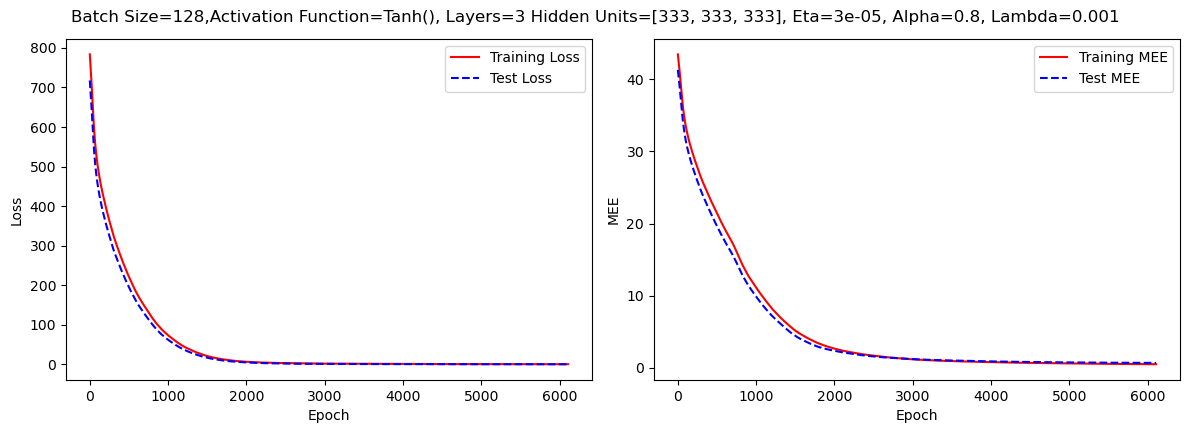


Inizializzazione 3\9
Training - Epoch [6389/7000], Loss: 0.3296, MEE: 0.4513 | Test - Epoch [6389/7000], Loss: 0.3879 MEE: 0.6662     
 N. Epochs = 6389 - Loss (train | test)= (0.3296 | 0.3879) - MEE (train | test) = (0.451333612203598 | 0.6661741137504578) - MAE (train | test) = (0.23143912851810455 | 0.3421165347099304 - MSE (train | test) = (0.32963141798973083 | 0.3878696858882904))


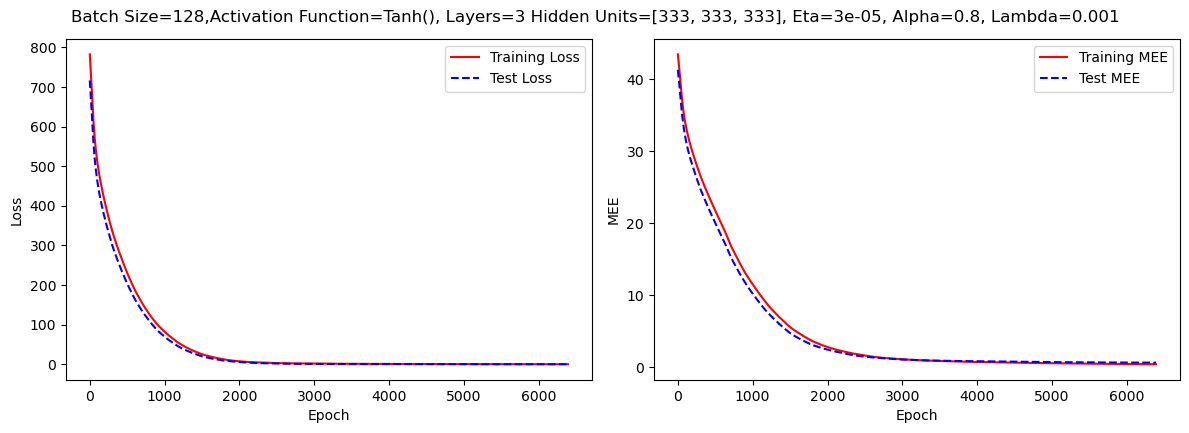


Inizializzazione 4\9
Training - Epoch [5771/7000], Loss: 0.1211, MEE: 0.3721 | Test - Epoch [5771/7000], Loss: 0.7154 MEE: 0.8997     
 N. Epochs = 5771 - Loss (train | test)= (0.1211 | 0.7154) - MEE (train | test) = (0.37208396196365356 | 0.899739146232605) - MAE (train | test) = (0.1899445801973343 | 0.4416407644748688 - MSE (train | test) = (0.1210552379488945 | 0.7153977155685425))


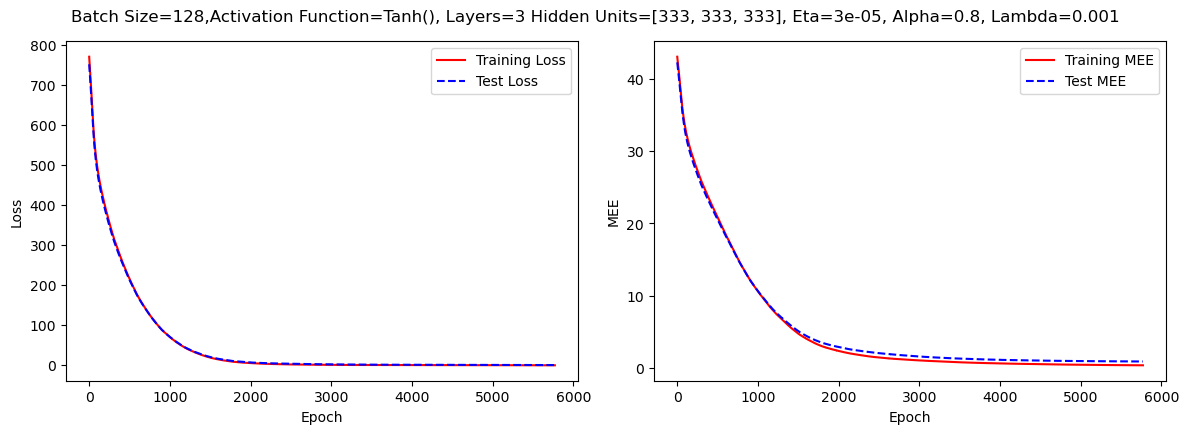


Inizializzazione 5\9
Training - Epoch [5439/7000], Loss: 0.2036, MEE: 0.4238 | Test - Epoch [5439/7000], Loss: 0.9131 MEE: 0.9561     
 N. Epochs = 5439 - Loss (train | test)= (0.2036 | 0.9131) - MEE (train | test) = (0.4237533211708069 | 0.9560534954071045) - MAE (train | test) = (0.21628324687480927 | 0.4773404896259308 - MSE (train | test) = (0.20362095534801483 | 0.913067638874054))


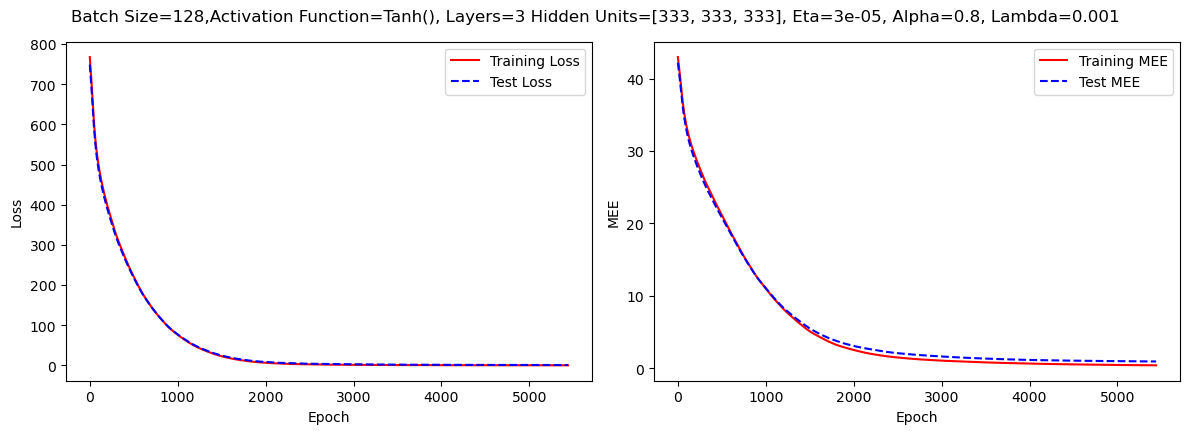


Inizializzazione 6\9
Training - Epoch [5542/7000], Loss: 0.1841, MEE: 0.4010 | Test - Epoch [5542/7000], Loss: 0.8329 MEE: 0.9291     
 N. Epochs = 5542 - Loss (train | test)= (0.1841 | 0.8329) - MEE (train | test) = (0.4009873867034912 | 0.9290844798088074) - MAE (train | test) = (0.20475713908672333 | 0.458448201417923 - MSE (train | test) = (0.18407362699508667 | 0.8328956961631775))


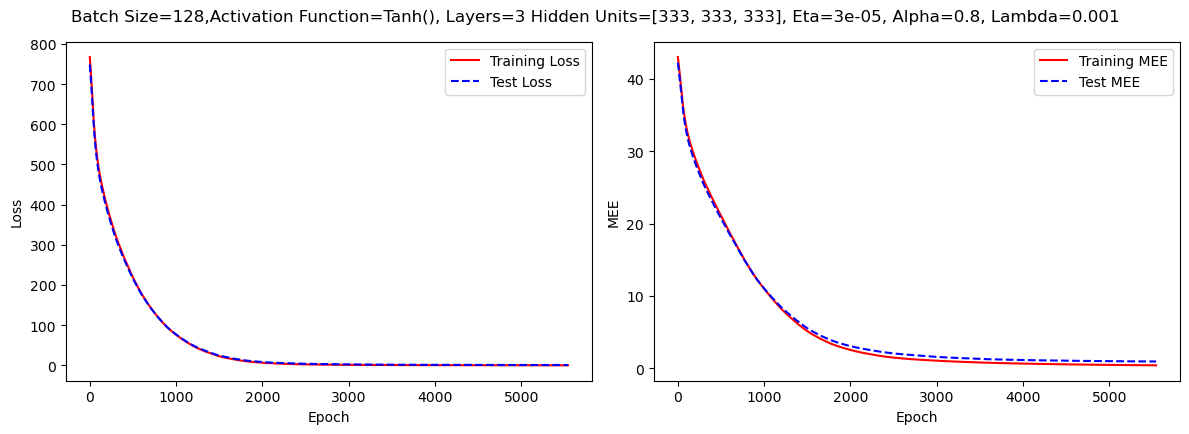


Inizializzazione 7\9
Training - Epoch [4928/7000], Loss: 0.2632, MEE: 0.4189 | Test - Epoch [4928/7000], Loss: 0.8221 MEE: 0.9843     
 N. Epochs = 4928 - Loss (train | test)= (0.2632 | 0.8221) - MEE (train | test) = (0.4188854694366455 | 0.9843199253082275) - MAE (train | test) = (0.21407625079154968 | 0.5043751001358032 - MSE (train | test) = (0.2632356882095337 | 0.8220571875572205))


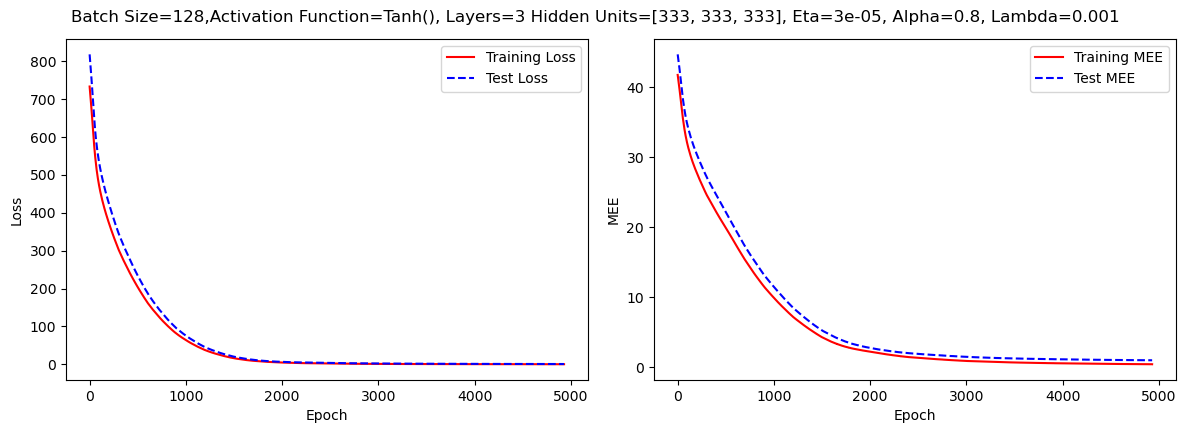


Inizializzazione 8\9
Training - Epoch [5298/7000], Loss: 0.2777, MEE: 0.4291 | Test - Epoch [5298/7000], Loss: 0.8286 MEE: 0.9927     
 N. Epochs = 5298 - Loss (train | test)= (0.2777 | 0.8286) - MEE (train | test) = (0.42910218238830566 | 0.9926891922950745) - MAE (train | test) = (0.21987284719944 | 0.5040730834007263 - MSE (train | test) = (0.2777087986469269 | 0.8285748362541199))


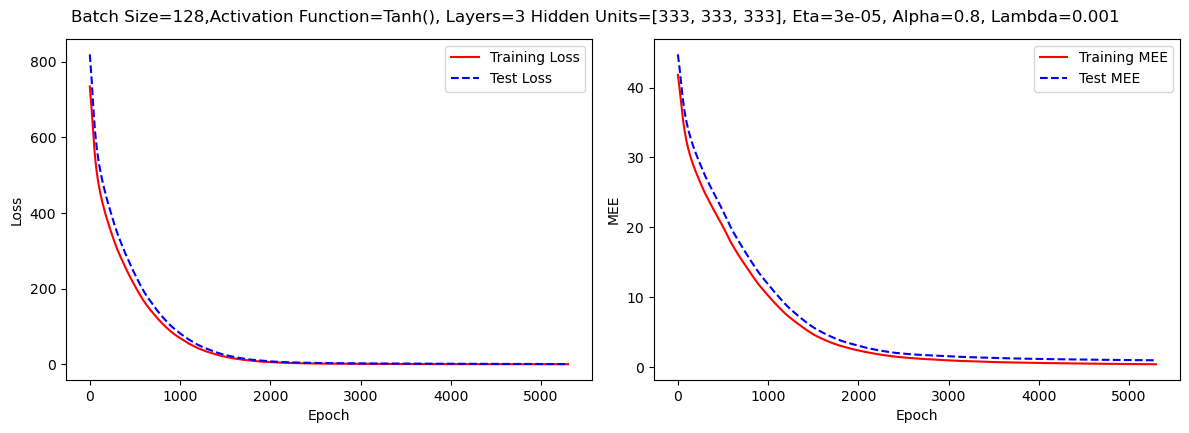


Inizializzazione 9\9
Training - Epoch [4922/7000], Loss: 0.2900, MEE: 0.4229 | Test - Epoch [4922/7000], Loss: 0.8810 MEE: 0.9862     
 N. Epochs = 4922 - Loss (train | test)= (0.29 | 0.881) - MEE (train | test) = (0.4228927493095398 | 0.9862085580825806) - MAE (train | test) = (0.21595297753810883 | 0.5005380511283875 - MSE (train | test) = (0.2900283634662628 | 0.8809584975242615))


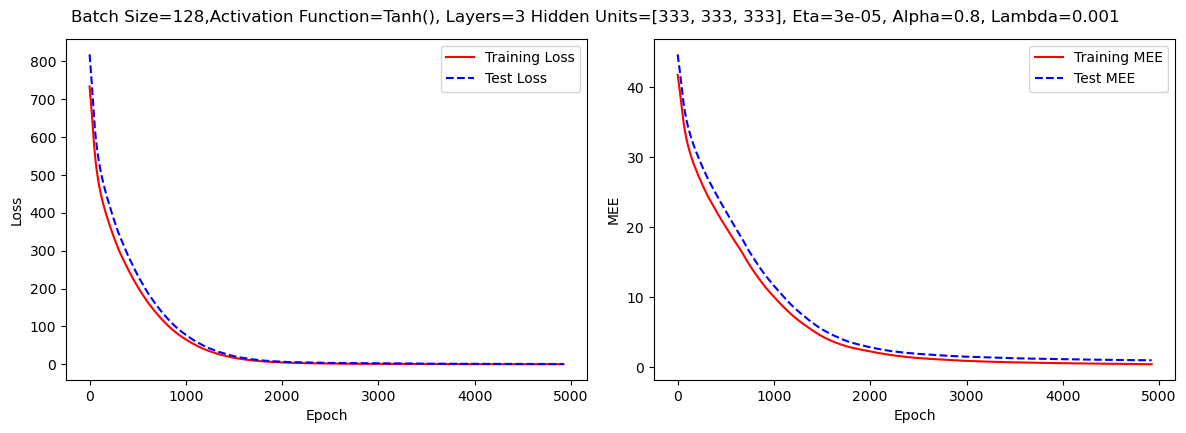


Modello 2\3
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 400

Inizializzazione 1\9
Training - Epoch [5357/7000], Loss: 0.0568, MEE: 0.3101 | Test - Epoch [5357/7000], Loss: 0.3602 MEE: 0.6627     
 N. Epochs = 5357 - Loss (train | test)= (0.05675 | 0.3602) - MEE (train | test) = (0.31006553769111633 | 0.662683367729187) - MAE (train | test) = (0.1593271791934967 | 0.33855244517326355 - MSE (train | test) = (0.05675356462597847 | 0.3602311313152313))


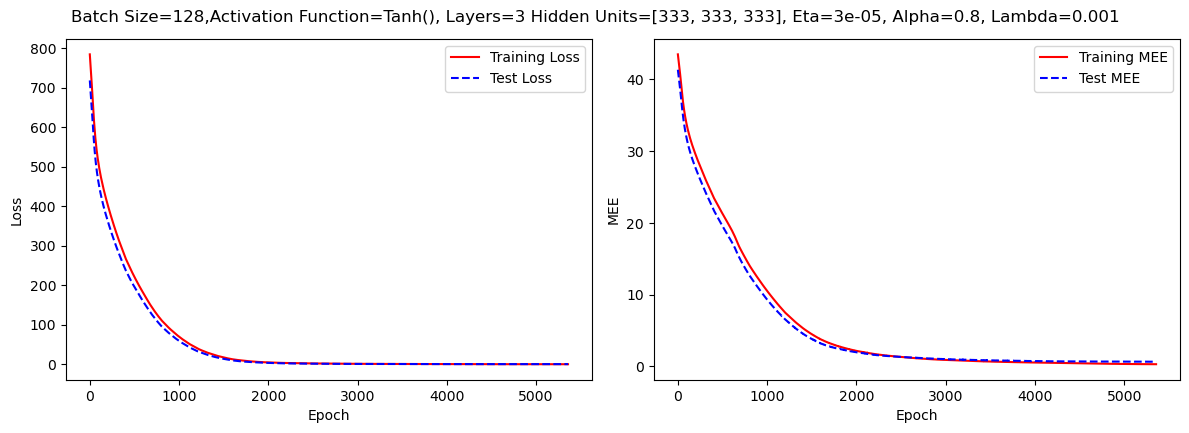


Inizializzazione 2\9
Training - Epoch [4822/7000], Loss: 0.0762, MEE: 0.3217 | Test - Epoch [4822/7000], Loss: 0.2710 MEE: 0.5898     
 N. Epochs = 4822 - Loss (train | test)= (0.07624 | 0.271) - MEE (train | test) = (0.32168859243392944 | 0.5898098945617676) - MAE (train | test) = (0.16473175585269928 | 0.29916030168533325 - MSE (train | test) = (0.07623764872550964 | 0.2709883749485016))


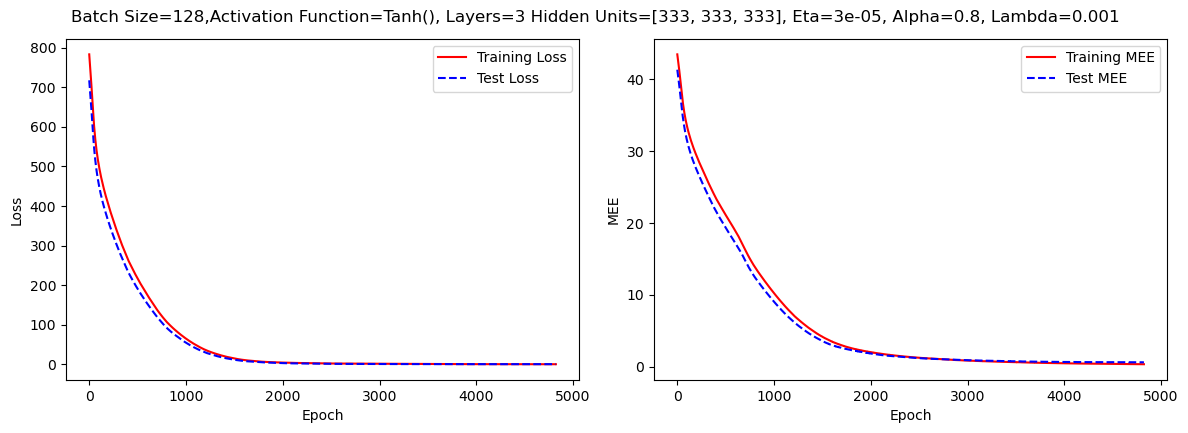


Inizializzazione 3\9
Training - Epoch [4615/7000], Loss: 0.1589, MEE: 0.3751 | Test - Epoch [4615/7000], Loss: 0.3107 MEE: 0.6318     
 N. Epochs = 4615 - Loss (train | test)= (0.1589 | 0.3107) - MEE (train | test) = (0.37511399388313293 | 0.6317961812019348) - MAE (train | test) = (0.19327504932880402 | 0.324309766292572 - MSE (train | test) = (0.15888895094394684 | 0.3106570839881897))


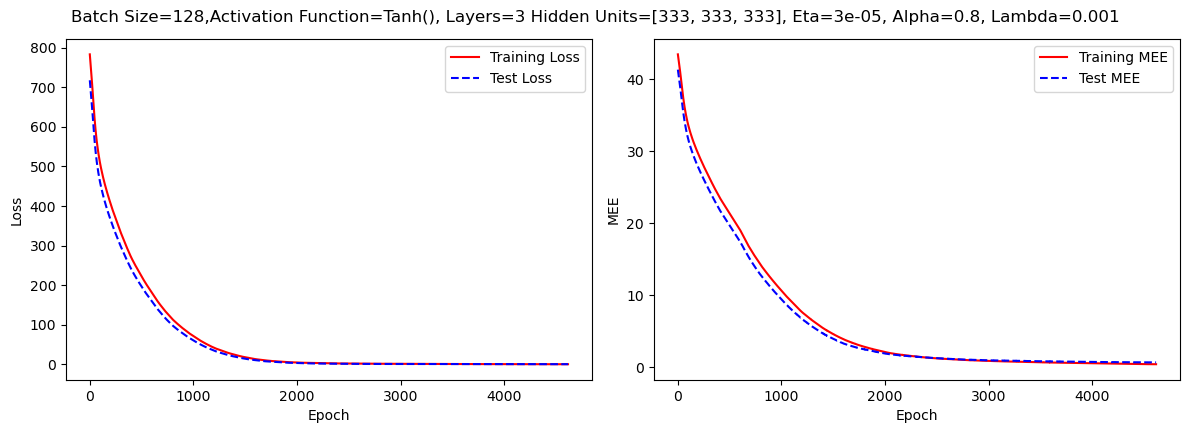


Inizializzazione 4\9
Training - Epoch [4614/7000], Loss: 0.0748, MEE: 0.3185 | Test - Epoch [4614/7000], Loss: 0.6470 MEE: 0.8544     
 N. Epochs = 4614 - Loss (train | test)= (0.0748 | 0.647) - MEE (train | test) = (0.3185121417045593 | 0.8544440865516663) - MAE (train | test) = (0.16244454681873322 | 0.42688772082328796 - MSE (train | test) = (0.07479508966207504 | 0.6469529271125793))


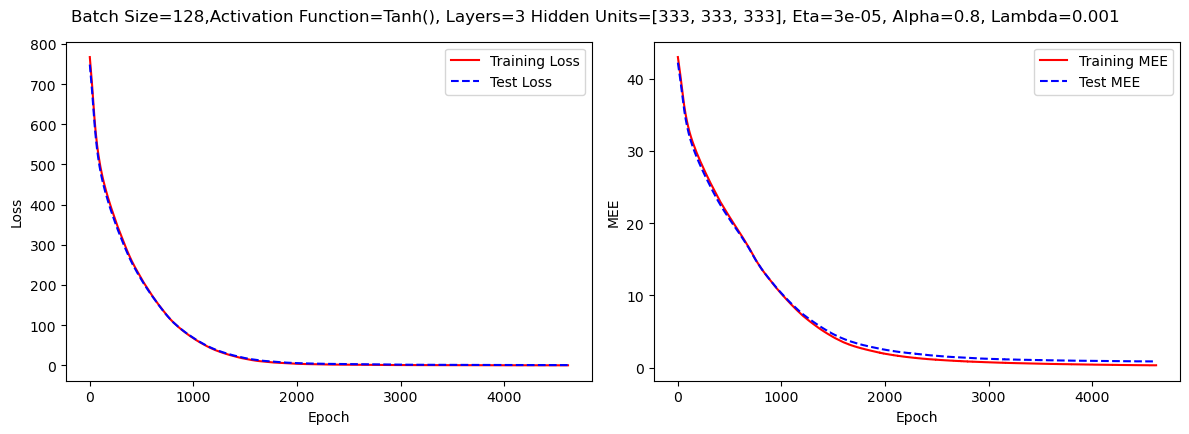


Inizializzazione 5\9
Training - Epoch [4325/7000], Loss: 0.0892, MEE: 0.3414 | Test - Epoch [4325/7000], Loss: 0.6465 MEE: 0.8585     
 N. Epochs = 4325 - Loss (train | test)= (0.08921 | 0.6465) - MEE (train | test) = (0.3413708508014679 | 0.8585257530212402) - MAE (train | test) = (0.17406471073627472 | 0.42465218901634216 - MSE (train | test) = (0.08920632302761078 | 0.6464818716049194))


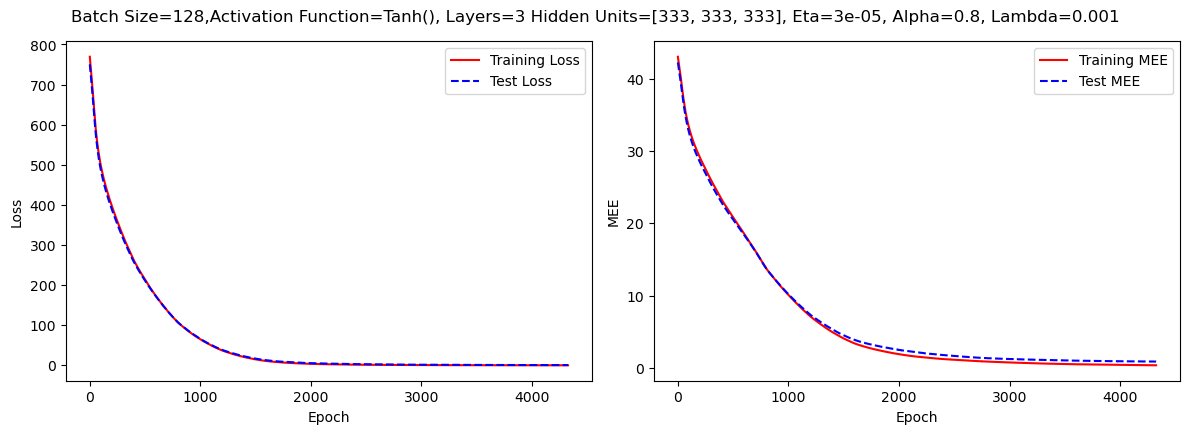


Inizializzazione 6\9
Training - Epoch [4301/7000], Loss: 0.1197, MEE: 0.3640 | Test - Epoch [4301/7000], Loss: 0.7338 MEE: 0.9008     
 N. Epochs = 4301 - Loss (train | test)= (0.1197 | 0.7338) - MEE (train | test) = (0.3640444874763489 | 0.9008092880249023) - MAE (train | test) = (0.1867281049489975 | 0.45280084013938904 - MSE (train | test) = (0.11972515285015106 | 0.7337541580200195))


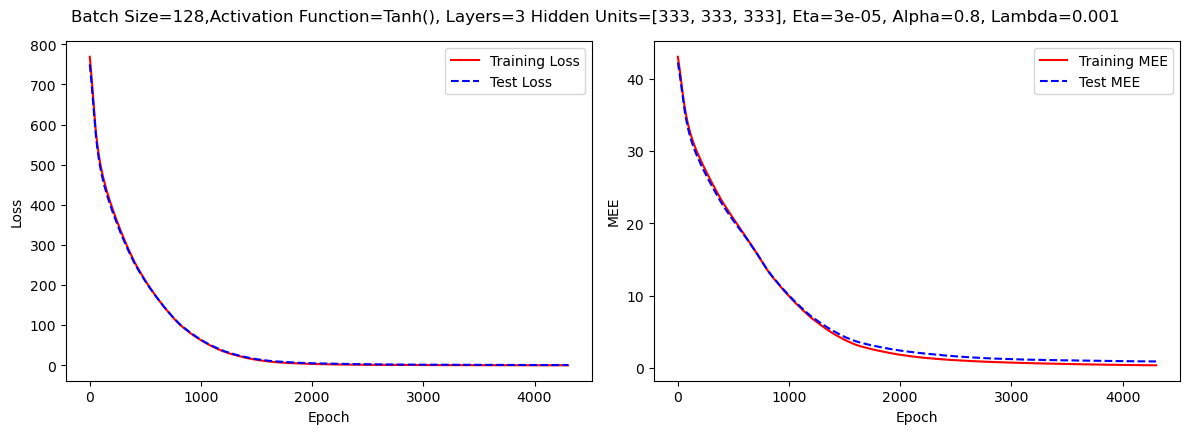


Inizializzazione 7\9
Training - Epoch [4268/7000], Loss: 0.1938, MEE: 0.3731 | Test - Epoch [4268/7000], Loss: 0.6992 MEE: 0.9345     
 N. Epochs = 4268 - Loss (train | test)= (0.1938 | 0.6992) - MEE (train | test) = (0.37313950061798096 | 0.9345205426216125) - MAE (train | test) = (0.19142624735832214 | 0.475297212600708 - MSE (train | test) = (0.19379961490631104 | 0.6991997957229614))


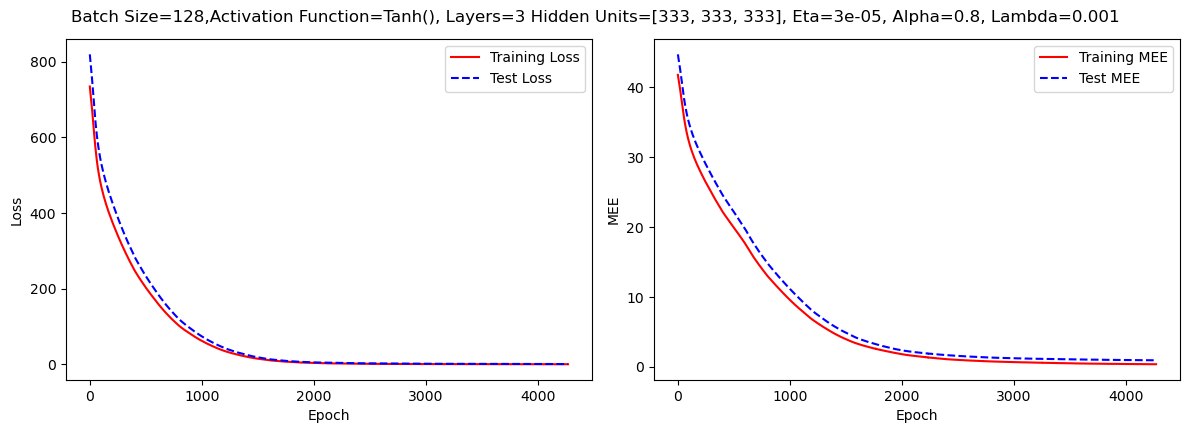


Inizializzazione 8\9
Training - Epoch [3909/7000], Loss: 0.1985, MEE: 0.3662 | Test - Epoch [3909/7000], Loss: 0.6327 MEE: 0.8770     
 N. Epochs = 3909 - Loss (train | test)= (0.1985 | 0.6327) - MEE (train | test) = (0.36618155241012573 | 0.8769639730453491) - MAE (train | test) = (0.18714994192123413 | 0.4474491477012634 - MSE (train | test) = (0.1984565556049347 | 0.6326991319656372))


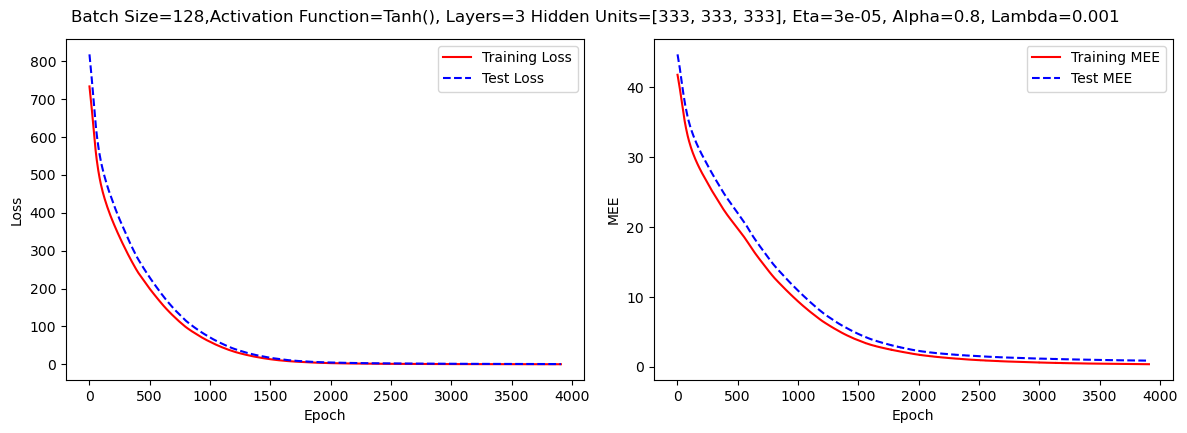


Inizializzazione 9\9
Training - Epoch [4105/7000], Loss: 0.2106, MEE: 0.3708 | Test - Epoch [4105/7000], Loss: 0.7106 MEE: 0.9283     
 N. Epochs = 4105 - Loss (train | test)= (0.2106 | 0.7106) - MEE (train | test) = (0.3708252012729645 | 0.9283487200737) - MAE (train | test) = (0.18991312384605408 | 0.47114500403404236 - MSE (train | test) = (0.21058765053749084 | 0.7106075286865234))


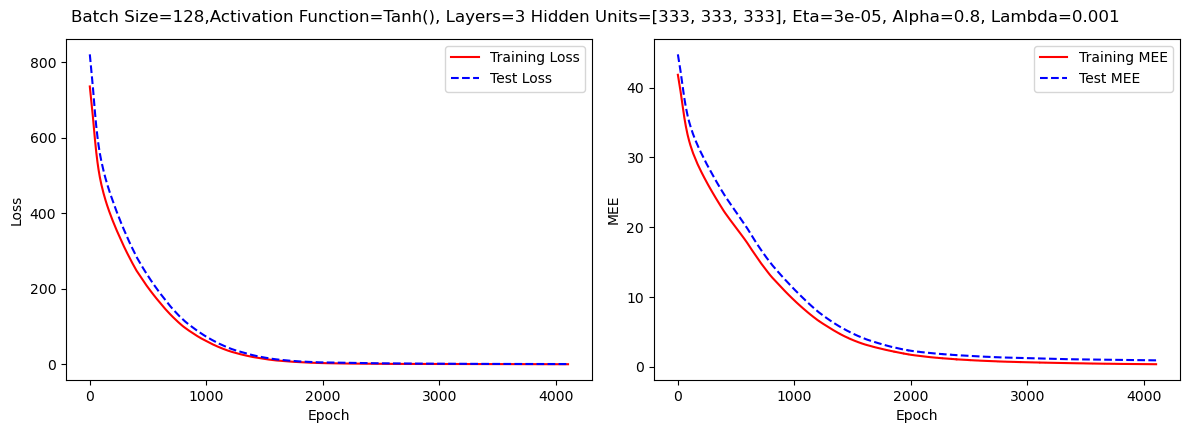


Modello 3\3
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 500

Inizializzazione 1\9
Training - Epoch [3601/7000], Loss: 0.0859, MEE: 0.3817 | Test - Epoch [3601/7000], Loss: 0.3256 MEE: 0.6426     
 N. Epochs = 3601 - Loss (train | test)= (0.08594 | 0.3256) - MEE (train | test) = (0.3817214369773865 | 0.6426302194595337) - MAE (train | test) = (0.1953323632478714 | 0.3286711573600769 - MSE (train | test) = (0.08593675494194031 | 0.32560616731643677))


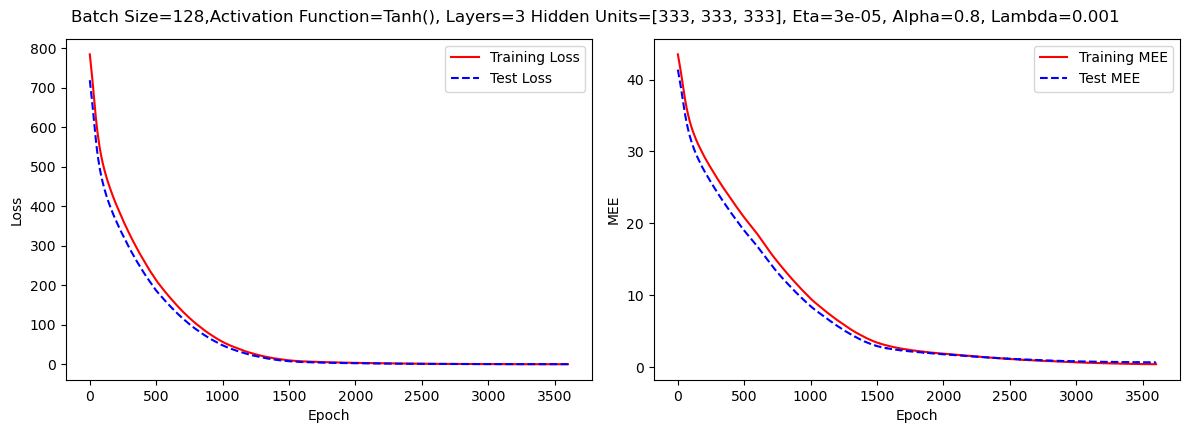


Inizializzazione 2\9
Training - Epoch [4387/7000], Loss: 0.0734, MEE: 0.3147 | Test - Epoch [4387/7000], Loss: 0.3161 MEE: 0.6177     
 N. Epochs = 4387 - Loss (train | test)= (0.0734 | 0.3161) - MEE (train | test) = (0.31473273038864136 | 0.6176547408103943) - MAE (train | test) = (0.16054683923721313 | 0.31572335958480835 - MSE (train | test) = (0.07340309023857117 | 0.3160596787929535))


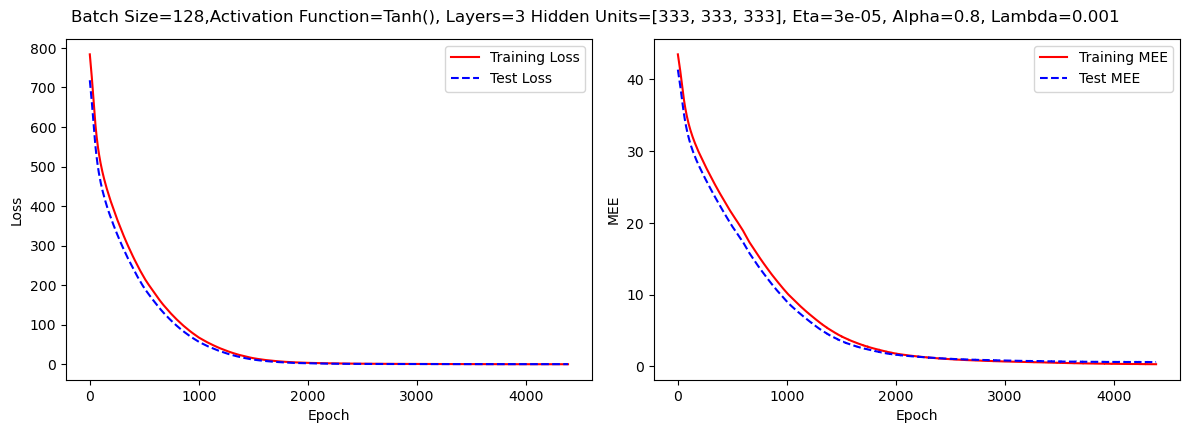


Inizializzazione 3\9
Training - Epoch [3911/7000], Loss: 0.0867, MEE: 0.3715 | Test - Epoch [3911/7000], Loss: 0.3185 MEE: 0.6614     
 N. Epochs = 3911 - Loss (train | test)= (0.08669 | 0.3185) - MEE (train | test) = (0.3714846074581146 | 0.6614189743995667) - MAE (train | test) = (0.18901711702346802 | 0.3387804627418518 - MSE (train | test) = (0.08669070899486542 | 0.3184782862663269))


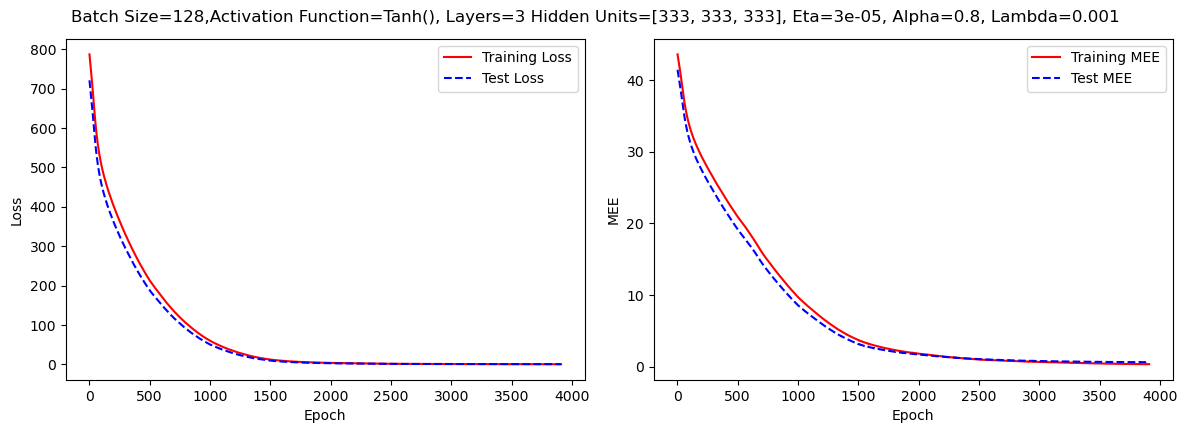


Inizializzazione 4\9
Training - Epoch [3442/7000], Loss: 0.0924, MEE: 0.3651 | Test - Epoch [3442/7000], Loss: 0.6854 MEE: 0.8873   1 
 N. Epochs = 3442 - Loss (train | test)= (0.09241 | 0.6854) - MEE (train | test) = (0.36505287885665894 | 0.8872528672218323) - MAE (train | test) = (0.1877310425043106 | 0.4354264736175537 - MSE (train | test) = (0.0924084261059761 | 0.685430109500885))


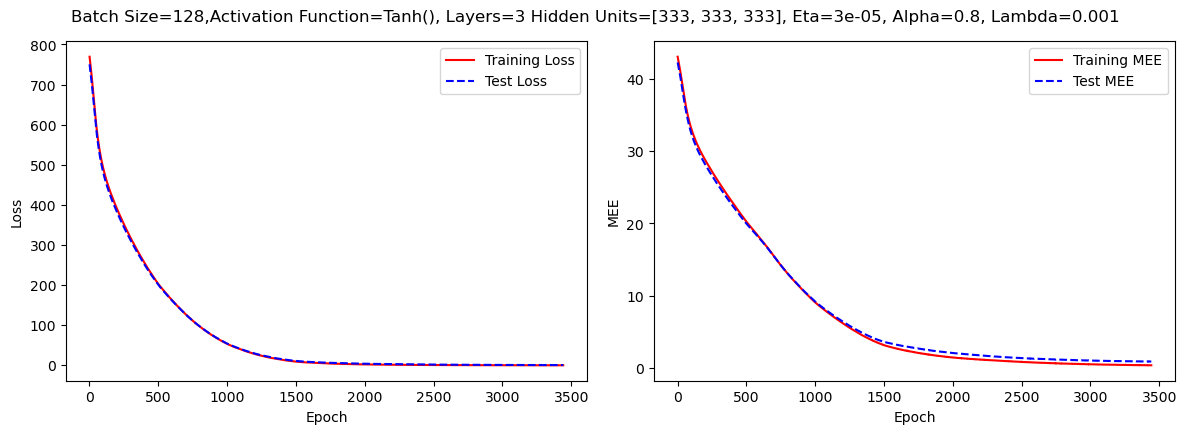


Inizializzazione 5\9
Training - Epoch [3921/7000], Loss: 0.0862, MEE: 0.3356 | Test - Epoch [3921/7000], Loss: 0.7500 MEE: 0.8970     
 N. Epochs = 3921 - Loss (train | test)= (0.08625 | 0.75) - MEE (train | test) = (0.33558908104896545 | 0.8970350623130798) - MAE (train | test) = (0.17121323943138123 | 0.4466288685798645 - MSE (train | test) = (0.08624684810638428 | 0.7500424385070801))


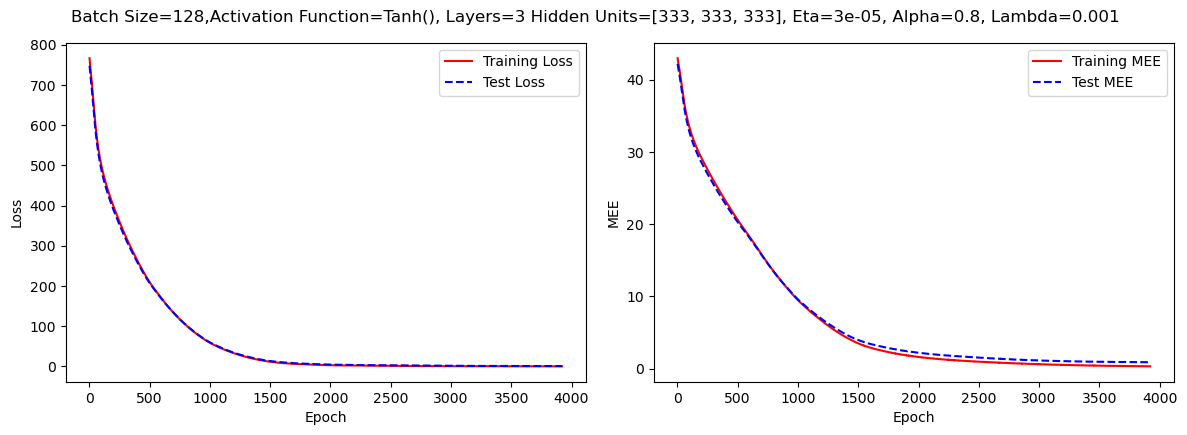


Inizializzazione 6\9
Training - Epoch [3731/7000], Loss: 0.0697, MEE: 0.3265 | Test - Epoch [3731/7000], Loss: 0.6184 MEE: 0.8579     
 N. Epochs = 3731 - Loss (train | test)= (0.06965 | 0.6184) - MEE (train | test) = (0.3265039920806885 | 0.8579463362693787) - MAE (train | test) = (0.16625025868415833 | 0.4245735704898834 - MSE (train | test) = (0.06965042650699615 | 0.6183738708496094))


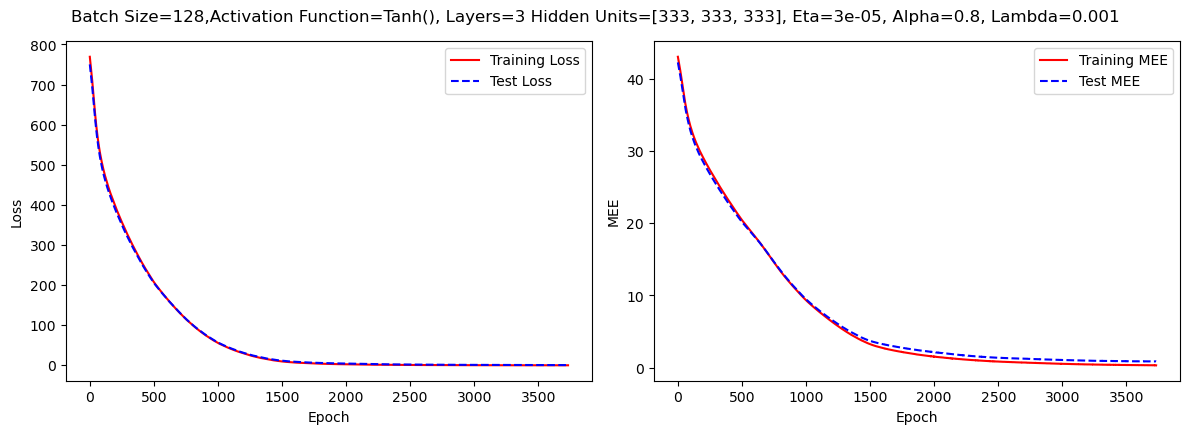


Inizializzazione 7\9
Training - Epoch [3613/7000], Loss: 0.2111, MEE: 0.3697 | Test - Epoch [3613/7000], Loss: 0.7456 MEE: 0.9451     
 N. Epochs = 3613 - Loss (train | test)= (0.2111 | 0.7456) - MEE (train | test) = (0.3697246313095093 | 0.9451349973678589) - MAE (train | test) = (0.1880578100681305 | 0.48577749729156494 - MSE (train | test) = (0.2110772281885147 | 0.745611846446991))


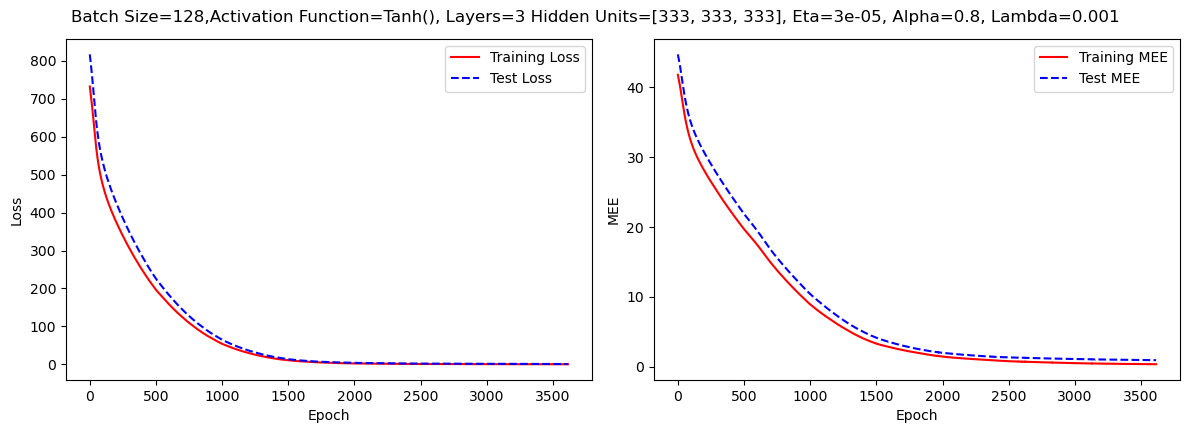


Inizializzazione 8\9
Training - Epoch [3430/7000], Loss: 0.3032, MEE: 0.4355 | Test - Epoch [3430/7000], Loss: 0.8628 MEE: 1.0075     
 N. Epochs = 3430 - Loss (train | test)= (0.3032 | 0.8628) - MEE (train | test) = (0.4354581832885742 | 1.0074619054794312) - MAE (train | test) = (0.2220861315727234 | 0.510357141494751 - MSE (train | test) = (0.3032075762748718 | 0.862790048122406))


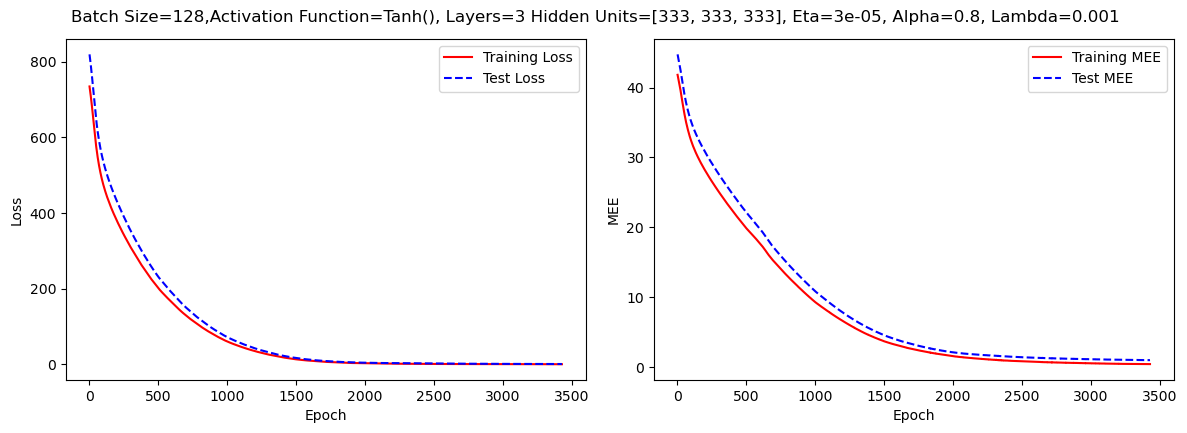


Inizializzazione 9\9
Training - Epoch [3269/7000], Loss: 0.2646, MEE: 0.4430 | Test - Epoch [3269/7000], Loss: 0.8134 MEE: 1.0015     
 N. Epochs = 3269 - Loss (train | test)= (0.2646 | 0.8134) - MEE (train | test) = (0.44303858280181885 | 1.001509666442871) - MAE (train | test) = (0.2256908416748047 | 0.5083780884742737 - MSE (train | test) = (0.2645524740219116 | 0.8133924007415771))


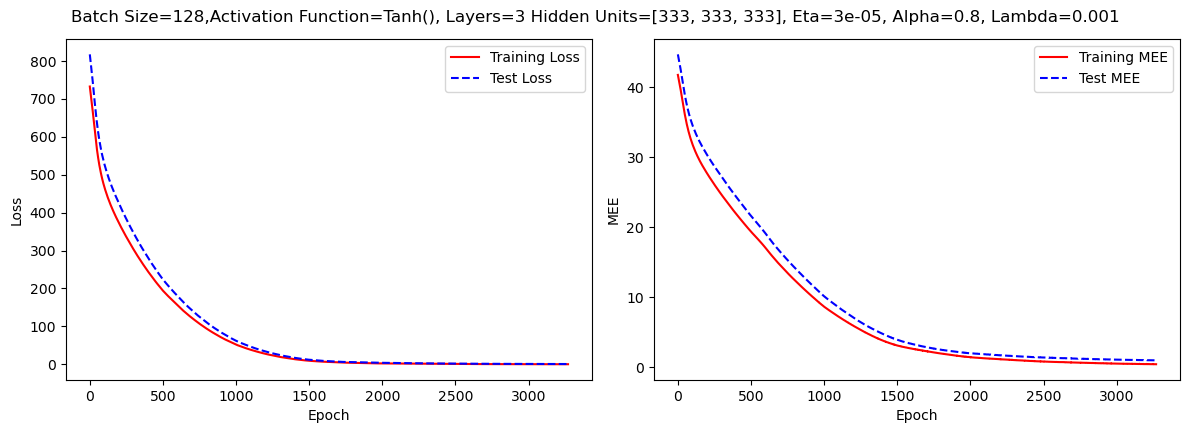


----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; learning rate decay = 0.9; momentum decay = 0.9; epoch decay = 300 
--> train_loss = 0.2463 +- 0.07933 | val_loss = 0.6802 +- 0.2207 
train_mee = 0.4254 +- 0.02906 | val_mee = 0.8623 +- 0.1383 
train_mae = 0.2179 +- 0.01563 | val_mae = 0.4354 +- 0.06757 
train_mse = 0.2463 +- 0.07933 | val_mse = 0.6802 +- 0.2207
mean max epoch = 5588

Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; learning rate decay = 0.9; momentum decay = 0.9; epoch decay = 400 
--> train_loss = 0.1309 +- 0.05691 | val_loss = 0.5568 +- 0.1758 
train_mee = 0.349 +- 0.02475 | val_mee = 0.8042 +- 0.1283 
train_mae = 0.1788 

In [22]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-05]
momentums = [0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9]
epoch_decays = [300, 400, 500]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=7000,
                                    plot_curves=True,
                                    N=3)

In [63]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.95]
mom_decays = [1]
epoch_decays = [100]
min_lrs = [1e-08, 1e-07, 3e-07, 5e-08, 5e-09]
min_moms = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\5
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 0.95; epoch decay = 100; minimum learning rate = 1e-08; minimum momentum = 0

Inizializzazione 1\9
Training - Epoch [2513/5000], Loss: 0.0508, MEE: 0.3084 | Test - Epoch [2513/5000], Loss: 0.2797 MEE: 0.5947     
 N. Epochs = 2513 - Loss (train | test)= (0.0508 | 0.2797) - MEE (train | test) = (0.30844420194625854 | 0.5947481393814087) - MAE (train | test) = (0.1565968543291092 | 0.29364892840385437 - MSE (train | test) = (0.05080054700374603 | 0.2796943485736847))

Inizializzazione 2\9
Training - Epoch [2529/5000], Loss: 0.0516, MEE: 0.2975 | Test - Epoch [2529/5000], Loss: 0.2686 MEE: 0.5832     
 N. Epochs = 2529 - Loss (train | test)= (0.0516 | 0.2686) - MEE (train | test) = (0.2975088953971863 | 0.5831605195999146) - MAE (train | test) = (0.15167179703712463 | 0.29025965

Training - Epoch [2554/5000], Loss: 0.0513, MEE: 0.2963 | Test - Epoch [2554/5000], Loss: 0.3064 MEE: 0.6063     
 N. Epochs = 2554 - Loss (train | test)= (0.05131 | 0.3064) - MEE (train | test) = (0.2963204085826874 | 0.6063496470451355) - MAE (train | test) = (0.15095631778240204 | 0.3040620684623718 - MSE (train | test) = (0.05130632966756821 | 0.30640116333961487))

Inizializzazione 3\9
Training - Epoch [2555/5000], Loss: 0.0455, MEE: 0.2895 | Test - Epoch [2555/5000], Loss: 0.2907 MEE: 0.6037     
 N. Epochs = 2555 - Loss (train | test)= (0.04549 | 0.2907) - MEE (train | test) = (0.28952956199645996 | 0.6036555767059326) - MAE (train | test) = (0.14752496778964996 | 0.3010203540325165 - MSE (train | test) = (0.04549194127321243 | 0.29074349999427795))

Inizializzazione 4\9
Training - Epoch [2338/5000], Loss: 0.0634, MEE: 0.3099 | Test - Epoch [2338/5000], Loss: 0.6121 MEE: 0.8425     
 N. Epochs = 2338 - Loss (train | test)= (0.06342 | 0.6121) - MEE (train | test) = (0.30992630124

Training - Epoch [2365/5000], Loss: 0.0731, MEE: 0.3205 | Test - Epoch [2365/5000], Loss: 0.5747 MEE: 0.8210     
 N. Epochs = 2365 - Loss (train | test)= (0.07314 | 0.5747) - MEE (train | test) = (0.32046276330947876 | 0.8210245966911316) - MAE (train | test) = (0.16278381645679474 | 0.407846063375473 - MSE (train | test) = (0.07313891500234604 | 0.5747100114822388))

Inizializzazione 5\9
Training - Epoch [2417/5000], Loss: 0.0522, MEE: 0.2932 | Test - Epoch [2417/5000], Loss: 0.6213 MEE: 0.8274     
 N. Epochs = 2417 - Loss (train | test)= (0.05217 | 0.6213) - MEE (train | test) = (0.29318690299987793 | 0.8273809552192688) - MAE (train | test) = (0.14858858287334442 | 0.4029144048690796 - MSE (train | test) = (0.0521710030734539 | 0.6213282346725464))

Inizializzazione 6\9
Training - Epoch [2087/5000], Loss: 0.1064, MEE: 0.3586 | Test - Epoch [2087/5000], Loss: 0.6558 MEE: 0.8803     
 N. Epochs = 2087 - Loss (train | test)= (0.1064 | 0.6558) - MEE (train | test) = (0.358648002147674

In [67]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-04]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.95]
mom_decays = [0.9]
epoch_decays = [150]
min_lrs = [1e-08, 1e-09, 5e-08, 5e-09]
min_moms = [0.5, 0.3, 0.6, 0.1]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\16
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150; minimum learning rate = 1e-08; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [1430/5000], Loss: 0.1643, MEE: 0.6114 | Test - Epoch [1430/5000], Loss: 0.3307 MEE: 0.7747 
 N. Epochs = 1430 - Loss (train | test)= (0.1643 | 0.3307) - MEE (train | test) = (0.6114116907119751 | 0.7746782898902893) - MAE (train | test) = (0.30330294370651245 | 0.3878122866153717 - MSE (train | test) = (0.1643381118774414 | 0.3306903839111328))

Inizializzazione 2\9
Training - Epoch [1528/5000], Loss: 0.1497, MEE: 0.5870 | Test - Epoch [1528/5000], Loss: 0.3108 MEE: 0.7499 
 N. Epochs = 1528 - Loss (train | test)= (0.1497 | 0.3108) - MEE (train | test) = (0.587030827999115 | 0.749914824962616) - MAE (train | test) = (0.2913570702075958 | 0.3714649975299835 

Training - Epoch [1293/5000], Loss: 0.1749, MEE: 0.6306 | Test - Epoch [1293/5000], Loss: 0.3205 MEE: 0.7719 
 N. Epochs = 1293 - Loss (train | test)= (0.1749 | 0.3205) - MEE (train | test) = (0.6305909752845764 | 0.771874725818634) - MAE (train | test) = (0.3126772344112396 | 0.3848218619823456 - MSE (train | test) = (0.17485490441322327 | 0.320527046918869))

Inizializzazione 3\9
Training - Epoch [923/5000], Loss: 0.2197, MEE: 0.7030 | Test - Epoch [923/5000], Loss: 0.3701 MEE: 0.8392   
 N. Epochs = 923 - Loss (train | test)= (0.2197 | 0.3701) - MEE (train | test) = (0.7029597759246826 | 0.8391733765602112) - MAE (train | test) = (0.35008981823921204 | 0.4231707453727722 - MSE (train | test) = (0.2196720987558365 | 0.37009477615356445))

Inizializzazione 4\9
Training - Epoch [1244/5000], Loss: 0.1687, MEE: 0.6199 | Test - Epoch [1244/5000], Loss: 0.5114 MEE: 0.9637 
 N. Epochs = 1244 - Loss (train | test)= (0.1687 | 0.5114) - MEE (train | test) = (0.6199142932891846 | 0.963665425777

Training - Epoch [1307/5000], Loss: 0.1659, MEE: 0.6150 | Test - Epoch [1307/5000], Loss: 0.4931 MEE: 0.9463 
 N. Epochs = 1307 - Loss (train | test)= (0.1659 | 0.4931) - MEE (train | test) = (0.614978551864624 | 0.9463452696800232) - MAE (train | test) = (0.30650192499160767 | 0.46963390707969666 - MSE (train | test) = (0.1658848077058792 | 0.49310845136642456))

Inizializzazione 5\9
Training - Epoch [1514/5000], Loss: 0.1443, MEE: 0.5731 | Test - Epoch [1514/5000], Loss: 0.4612 MEE: 0.9029 
 N. Epochs = 1514 - Loss (train | test)= (0.1443 | 0.4612) - MEE (train | test) = (0.5730882883071899 | 0.9028512239456177) - MAE (train | test) = (0.285900741815567 | 0.4469122886657715 - MSE (train | test) = (0.1443362683057785 | 0.4611726403236389))

Inizializzazione 6\9
Training - Epoch [1186/5000], Loss: 0.1793, MEE: 0.6370 | Test - Epoch [1186/5000], Loss: 0.5137 MEE: 0.9696 
 N. Epochs = 1186 - Loss (train | test)= (0.1793 | 0.5137) - MEE (train | test) = (0.6370025277137756 | 0.96964198350

Training - Epoch [1109/5000], Loss: 0.1760, MEE: 0.6306 | Test - Epoch [1109/5000], Loss: 0.4909 MEE: 0.9477 
 N. Epochs = 1109 - Loss (train | test)= (0.176 | 0.4909) - MEE (train | test) = (0.6306220889091492 | 0.9476791620254517) - MAE (train | test) = (0.312834769487381 | 0.4718821942806244 - MSE (train | test) = (0.17603692412376404 | 0.49088340997695923))

Inizializzazione 7\9
Training - Epoch [1207/5000], Loss: 0.1730, MEE: 0.6152 | Test - Epoch [1207/5000], Loss: 0.4671 MEE: 0.9482 
 N. Epochs = 1207 - Loss (train | test)= (0.173 | 0.4671) - MEE (train | test) = (0.6152163147926331 | 0.9481766223907471) - MAE (train | test) = (0.3049944341182709 | 0.4684252440929413 - MSE (train | test) = (0.17303000390529633 | 0.46709561347961426))

Inizializzazione 8\9
Training - Epoch [1254/5000], Loss: 0.1677, MEE: 0.6060 | Test - Epoch [1254/5000], Loss: 0.4456 MEE: 0.9203 
 N. Epochs = 1254 - Loss (train | test)= (0.1677 | 0.4456) - MEE (train | test) = (0.6060201525688171 | 0.92030000686

Training - Epoch [989/5000], Loss: 0.2041, MEE: 0.6670 | Test - Epoch [989/5000], Loss: 0.4921 MEE: 0.9862   
 N. Epochs = 989 - Loss (train | test)= (0.2041 | 0.4921) - MEE (train | test) = (0.6669518351554871 | 0.9861693382263184) - MAE (train | test) = (0.33330705761909485 | 0.48999154567718506 - MSE (train | test) = (0.2040921151638031 | 0.49207621812820435))

Inizializzazione 9\9
Training - Epoch [1437/5000], Loss: 0.1478, MEE: 0.5733 | Test - Epoch [1437/5000], Loss: 0.4179 MEE: 0.8956 
 N. Epochs = 1437 - Loss (train | test)= (0.1478 | 0.4179) - MEE (train | test) = (0.5733493566513062 | 0.8956209421157837) - MAE (train | test) = (0.2856782376766205 | 0.4444596767425537 - MSE (train | test) = (0.1477852612733841 | 0.41790902614593506))

Modello 10\16
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150; minim

Training - Epoch [1476/5000], Loss: 0.1583, MEE: 0.6033 | Test - Epoch [1476/5000], Loss: 0.2898 MEE: 0.7453 
 N. Epochs = 1476 - Loss (train | test)= (0.1583 | 0.2898) - MEE (train | test) = (0.603317379951477 | 0.7453059554100037) - MAE (train | test) = (0.3006780743598938 | 0.37086591124534607 - MSE (train | test) = (0.15829721093177795 | 0.28980645537376404))

Inizializzazione 2\9
Training - Epoch [1158/5000], Loss: 0.1975, MEE: 0.6697 | Test - Epoch [1158/5000], Loss: 0.3640 MEE: 0.8184 
 N. Epochs = 1158 - Loss (train | test)= (0.1975 | 0.364) - MEE (train | test) = (0.6696934700012207 | 0.8183537721633911) - MAE (train | test) = (0.3323354423046112 | 0.40644681453704834 - MSE (train | test) = (0.19751855731010437 | 0.3639508783817291))

Inizializzazione 3\9
Training - Epoch [1070/5000], Loss: 0.2042, MEE: 0.6710 | Test - Epoch [1070/5000], Loss: 0.3887 MEE: 0.8293 
 N. Epochs = 1070 - Loss (train | test)= (0.2042 | 0.3887) - MEE (train | test) = (0.6710445284843445 | 0.829313755

Training - Epoch [1183/5000], Loss: 0.1877, MEE: 0.6533 | Test - Epoch [1183/5000], Loss: 0.3336 MEE: 0.7921 
 N. Epochs = 1183 - Loss (train | test)= (0.1877 | 0.3336) - MEE (train | test) = (0.653251051902771 | 0.7921499013900757) - MAE (train | test) = (0.3254738450050354 | 0.3943597376346588 - MSE (train | test) = (0.18772631883621216 | 0.3336162567138672))

Inizializzazione 4\9
Training - Epoch [1290/5000], Loss: 0.1572, MEE: 0.5964 | Test - Epoch [1290/5000], Loss: 0.4903 MEE: 0.9365 
 N. Epochs = 1290 - Loss (train | test)= (0.1572 | 0.4903) - MEE (train | test) = (0.5963649749755859 | 0.9365098476409912) - MAE (train | test) = (0.29649773240089417 | 0.46544522047042847 - MSE (train | test) = (0.15715636312961578 | 0.4902837574481964))

Inizializzazione 5\9
Training - Epoch [1326/5000], Loss: 0.1675, MEE: 0.6135 | Test - Epoch [1326/5000], Loss: 0.5063 MEE: 0.9499 
 N. Epochs = 1326 - Loss (train | test)= (0.1675 | 0.5063) - MEE (train | test) = (0.6134932041168213 | 0.949941933

Training - Epoch [1080/5000], Loss: 0.1881, MEE: 0.6474 | Test - Epoch [1080/5000], Loss: 0.5461 MEE: 0.9793 
 N. Epochs = 1080 - Loss (train | test)= (0.1881 | 0.5461) - MEE (train | test) = (0.6474435329437256 | 0.9792543053627014) - MAE (train | test) = (0.32328638434410095 | 0.487829327583313 - MSE (train | test) = (0.18810322880744934 | 0.5460972189903259))

Inizializzazione 6\9
Training - Epoch [1222/5000], Loss: 0.1790, MEE: 0.6383 | Test - Epoch [1222/5000], Loss: 0.5214 MEE: 0.9712 
 N. Epochs = 1222 - Loss (train | test)= (0.179 | 0.5214) - MEE (train | test) = (0.6383311152458191 | 0.9712199568748474) - MAE (train | test) = (0.31862613558769226 | 0.4838995635509491 - MSE (train | test) = (0.1790427416563034 | 0.521351158618927))

Inizializzazione 7\9
Training - Epoch [946/5000], Loss: 0.2129, MEE: 0.6759 | Test - Epoch [946/5000], Loss: 0.4984 MEE: 0.9904 7 
 N. Epochs = 946 - Loss (train | test)= (0.2129 | 0.4984) - MEE (train | test) = (0.6758739948272705 | 0.9904369711875

In [69]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-05]
momentums = [0.8] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9, 0.8, 0.95]
epoch_decays = [350, 400, 450, 500]
min_lrs = [1e-08, 1e-09, 5e-09]
min_moms = [0.5, 0.3, 0.6]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=7000,
                                    plot_curves=False,
                                    N=3)


Modello 1\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 350; minimum learning rate = 1e-08; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [4768/7000], Loss: 0.0834, MEE: 0.3595 | Test - Epoch [4768/7000], Loss: 0.3101 MEE: 0.6252     
 N. Epochs = 4768 - Loss (train | test)= (0.08344 | 0.3101) - MEE (train | test) = (0.35948190093040466 | 0.6252031922340393) - MAE (train | test) = (0.18374139070510864 | 0.3183339238166809 - MSE (train | test) = (0.08343590795993805 | 0.3101174533367157))

Inizializzazione 2\9
Training - Epoch [5306/7000], Loss: 0.0626, MEE: 0.3227 | Test - Epoch [5306/7000], Loss: 0.3021 MEE: 0.6107     
 N. Epochs = 5306 - Loss (train | test)= (0.06264 | 0.3021) - MEE (train | test) = (0.322695791721344 | 0.6107189059257507) - MAE (train | test) = (0.16514310240745544 | 0.

Training - Epoch [5357/7000], Loss: 0.1243, MEE: 0.3691 | Test - Epoch [5357/7000], Loss: 0.3065 MEE: 0.6308     
 N. Epochs = 5357 - Loss (train | test)= (0.1243 | 0.3065) - MEE (train | test) = (0.3690970838069916 | 0.630784809589386) - MAE (train | test) = (0.1901368796825409 | 0.320094496011734 - MSE (train | test) = (0.12429799884557724 | 0.30646219849586487))

Inizializzazione 3\9
Training - Epoch [5128/7000], Loss: 0.0709, MEE: 0.3401 | Test - Epoch [5128/7000], Loss: 0.3197 MEE: 0.6292     
 N. Epochs = 5128 - Loss (train | test)= (0.0709 | 0.3197) - MEE (train | test) = (0.34012898802757263 | 0.6291842460632324) - MAE (train | test) = (0.17472101747989655 | 0.31937989592552185 - MSE (train | test) = (0.07090023905038834 | 0.3197103440761566))

Inizializzazione 4\9
Training - Epoch [5365/7000], Loss: 0.1651, MEE: 0.3534 | Test - Epoch [5365/7000], Loss: 0.8457 MEE: 0.9047     
 N. Epochs = 5365 - Loss (train | test)= (0.1651 | 0.8457) - MEE (train | test) = (0.3533833920955658 

Training - Epoch [4708/7000], Loss: 0.0922, MEE: 0.3413 | Test - Epoch [4708/7000], Loss: 0.6670 MEE: 0.8904     
 N. Epochs = 4708 - Loss (train | test)= (0.09222 | 0.667) - MEE (train | test) = (0.3412869870662689 | 0.8903651833534241) - MAE (train | test) = (0.17500534653663635 | 0.4414233863353729 - MSE (train | test) = (0.09221708029508591 | 0.6670386791229248))

Inizializzazione 5\9
Training - Epoch [4587/7000], Loss: 0.1022, MEE: 0.3456 | Test - Epoch [4587/7000], Loss: 0.7616 MEE: 0.8814     
 N. Epochs = 4587 - Loss (train | test)= (0.1022 | 0.7616) - MEE (train | test) = (0.34557121992111206 | 0.8814266920089722) - MAE (train | test) = (0.17602550983428955 | 0.44128796458244324 - MSE (train | test) = (0.10219382494688034 | 0.7615942358970642))

Inizializzazione 6\9
Training - Epoch [5307/7000], Loss: 0.1591, MEE: 0.3637 | Test - Epoch [5307/7000], Loss: 0.7800 MEE: 0.8648     
 N. Epochs = 5307 - Loss (train | test)= (0.1591 | 0.78) - MEE (train | test) = (0.3637259602546692 

Training - Epoch [5368/7000], Loss: 0.1784, MEE: 0.3802 | Test - Epoch [5368/7000], Loss: 0.8235 MEE: 0.9038     
 N. Epochs = 5368 - Loss (train | test)= (0.1784 | 0.8235) - MEE (train | test) = (0.38024795055389404 | 0.9037876725196838) - MAE (train | test) = (0.19352324306964874 | 0.4535817801952362 - MSE (train | test) = (0.17842456698417664 | 0.823526918888092))

Inizializzazione 7\9
Training - Epoch [4359/7000], Loss: 0.1607, MEE: 0.3856 | Test - Epoch [4359/7000], Loss: 0.6144 MEE: 0.9060     
 N. Epochs = 4359 - Loss (train | test)= (0.1607 | 0.6144) - MEE (train | test) = (0.38555464148521423 | 0.9059799909591675) - MAE (train | test) = (0.1965770721435547 | 0.4566947817802429 - MSE (train | test) = (0.16071048378944397 | 0.6143667101860046))

Inizializzazione 8\9
Training - Epoch [4595/7000], Loss: 0.2360, MEE: 0.3879 | Test - Epoch [4595/7000], Loss: 0.7576 MEE: 0.9490     
 N. Epochs = 4595 - Loss (train | test)= (0.236 | 0.7576) - MEE (train | test) = (0.3879040479660034 |

Training - Epoch [4525/7000], Loss: 0.2031, MEE: 0.3786 | Test - Epoch [4525/7000], Loss: 0.6850 MEE: 0.9478     
 N. Epochs = 4525 - Loss (train | test)= (0.2031 | 0.685) - MEE (train | test) = (0.37857380509376526 | 0.9478426575660706) - MAE (train | test) = (0.19363711774349213 | 0.48236316442489624 - MSE (train | test) = (0.2030525803565979 | 0.685008704662323))

Inizializzazione 9\9
Training - Epoch [4330/7000], Loss: 0.2619, MEE: 0.3902 | Test - Epoch [4330/7000], Loss: 0.7631 MEE: 0.9605     
 N. Epochs = 4330 - Loss (train | test)= (0.2619 | 0.7631) - MEE (train | test) = (0.39017918705940247 | 0.9604586362838745) - MAE (train | test) = (0.20009323954582214 | 0.4875759184360504 - MSE (train | test) = (0.2619393467903137 | 0.7631368637084961))

Modello 10\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay =

Training - Epoch [5011/7000], Loss: 0.1408, MEE: 0.3587 | Test - Epoch [5011/7000], Loss: 0.2938 MEE: 0.6089     
 N. Epochs = 5011 - Loss (train | test)= (0.1408 | 0.2938) - MEE (train | test) = (0.3587441146373749 | 0.608859658241272) - MAE (train | test) = (0.185999795794487 | 0.30690574645996094 - MSE (train | test) = (0.14081129431724548 | 0.2937953472137451))

Inizializzazione 2\9
Training - Epoch [4992/7000], Loss: 0.0687, MEE: 0.3175 | Test - Epoch [4992/7000], Loss: 0.3418 MEE: 0.6263     
 N. Epochs = 4992 - Loss (train | test)= (0.06873 | 0.3418) - MEE (train | test) = (0.31745561957359314 | 0.626316487789154) - MAE (train | test) = (0.1618194282054901 | 0.3202008306980133 - MSE (train | test) = (0.0687299594283104 | 0.34181496500968933))

Inizializzazione 3\9
Training - Epoch [4969/7000], Loss: 0.1208, MEE: 0.3553 | Test - Epoch [4969/7000], Loss: 0.3028 MEE: 0.5954     
 N. Epochs = 4969 - Loss (train | test)= (0.1208 | 0.3028) - MEE (train | test) = (0.35533541440963745 |

Training - Epoch [5067/7000], Loss: 0.0803, MEE: 0.3289 | Test - Epoch [5067/7000], Loss: 0.3920 MEE: 0.6296     
 N. Epochs = 5067 - Loss (train | test)= (0.08027 | 0.392) - MEE (train | test) = (0.32888972759246826 | 0.6296290755271912) - MAE (train | test) = (0.16878178715705872 | 0.31915438175201416 - MSE (train | test) = (0.08027243614196777 | 0.39199185371398926))

Inizializzazione 4\9
Training - Epoch [4761/7000], Loss: 0.1001, MEE: 0.3226 | Test - Epoch [4761/7000], Loss: 0.6943 MEE: 0.8621     
 N. Epochs = 4761 - Loss (train | test)= (0.1001 | 0.6943) - MEE (train | test) = (0.3226321339607239 | 0.8620858788490295) - MAE (train | test) = (0.16406533122062683 | 0.4275657832622528 - MSE (train | test) = (0.100091852247715 | 0.6942904591560364))

Inizializzazione 5\9
Training - Epoch [4599/7000], Loss: 0.0700, MEE: 0.3139 | Test - Epoch [4599/7000], Loss: 0.6126 MEE: 0.8207     
 N. Epochs = 4599 - Loss (train | test)= (0.07005 | 0.6126) - MEE (train | test) = (0.313900202512741

Training - Epoch [4218/7000], Loss: 0.0881, MEE: 0.3506 | Test - Epoch [4218/7000], Loss: 0.6025 MEE: 0.8539     
 N. Epochs = 4218 - Loss (train | test)= (0.08806 | 0.6025) - MEE (train | test) = (0.3505704402923584 | 0.8539447784423828) - MAE (train | test) = (0.17902114987373352 | 0.4232187569141388 - MSE (train | test) = (0.08805836737155914 | 0.6024972796440125))

Inizializzazione 6\9
Training - Epoch [4328/7000], Loss: 0.0589, MEE: 0.3127 | Test - Epoch [4328/7000], Loss: 0.5582 MEE: 0.8402     
 N. Epochs = 4328 - Loss (train | test)= (0.05886 | 0.5582) - MEE (train | test) = (0.31271299719810486 | 0.8401709198951721) - MAE (train | test) = (0.15884019434452057 | 0.4157387912273407 - MSE (train | test) = (0.058860354125499725 | 0.5582118630409241))

Inizializzazione 7\9
Training - Epoch [3891/7000], Loss: 0.2584, MEE: 0.3952 | Test - Epoch [3891/7000], Loss: 0.8231 MEE: 0.9690     
 N. Epochs = 3891 - Loss (train | test)= (0.2584 | 0.8231) - MEE (train | test) = (0.3951922357082

Training - Epoch [4138/7000], Loss: 0.2105, MEE: 0.3615 | Test - Epoch [4138/7000], Loss: 0.7344 MEE: 0.9421     
 N. Epochs = 4138 - Loss (train | test)= (0.2105 | 0.7344) - MEE (train | test) = (0.36151912808418274 | 0.942051351070404) - MAE (train | test) = (0.18531489372253418 | 0.47565966844558716 - MSE (train | test) = (0.21047893166542053 | 0.7344401478767395))

Inizializzazione 8\9
Training - Epoch [4083/7000], Loss: 0.2776, MEE: 0.3998 | Test - Epoch [4083/7000], Loss: 0.8611 MEE: 0.9891     
 N. Epochs = 4083 - Loss (train | test)= (0.2776 | 0.8611) - MEE (train | test) = (0.39975500106811523 | 0.9891259670257568) - MAE (train | test) = (0.20515461266040802 | 0.5063707828521729 - MSE (train | test) = (0.27759963274002075 | 0.8610607385635376))

Inizializzazione 9\9
Training - Epoch [4342/7000], Loss: 0.1865, MEE: 0.3528 | Test - Epoch [4342/7000], Loss: 0.6934 MEE: 0.9210     
 N. Epochs = 4342 - Loss (train | test)= (0.1865 | 0.6934) - MEE (train | test) = (0.352785319089889

Training - Epoch [3944/7000], Loss: 0.2510, MEE: 0.3652 | Test - Epoch [3944/7000], Loss: 0.7915 MEE: 0.9494     
 N. Epochs = 3944 - Loss (train | test)= (0.251 | 0.7915) - MEE (train | test) = (0.36518266797065735 | 0.9493697285652161) - MAE (train | test) = (0.18777765333652496 | 0.4828438460826874 - MSE (train | test) = (0.2510257661342621 | 0.7914931178092957))

Modello 21\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 450; minimum learning rate = 1e-08; minimum momentum = 0.6

Inizializzazione 1\9
Training - Epoch [4293/7000], Loss: 0.2088, MEE: 0.3931 | Test - Epoch [4293/7000], Loss: 0.3214 MEE: 0.6482     
 N. Epochs = 4293 - Loss (train | test)= (0.2088 | 0.3214) - MEE (train | test) = (0.3930586278438568 | 0.6481716632843018) - MAE (train | test) = (0.20140208303928375 | 0.3312070071697235 - MSE (

Training - Epoch [4440/7000], Loss: 0.0608, MEE: 0.3231 | Test - Epoch [4440/7000], Loss: 0.3166 MEE: 0.6151     
 N. Epochs = 4440 - Loss (train | test)= (0.06081 | 0.3166) - MEE (train | test) = (0.3231256306171417 | 0.6150649785995483) - MAE (train | test) = (0.16453242301940918 | 0.3108004331588745 - MSE (train | test) = (0.06081298366189003 | 0.3165711760520935))

Inizializzazione 2\9
Training - Epoch [4596/7000], Loss: 0.0582, MEE: 0.3199 | Test - Epoch [4596/7000], Loss: 0.2929 MEE: 0.6094     
 N. Epochs = 4596 - Loss (train | test)= (0.05818 | 0.2929) - MEE (train | test) = (0.31988197565078735 | 0.609419584274292) - MAE (train | test) = (0.16346760094165802 | 0.3090432584285736 - MSE (train | test) = (0.05817903205752373 | 0.2929036021232605))

Inizializzazione 3\9
Training - Epoch [4072/7000], Loss: 0.0650, MEE: 0.3425 | Test - Epoch [4072/7000], Loss: 0.2980 MEE: 0.6145     
 N. Epochs = 4072 - Loss (train | test)= (0.06498 | 0.298) - MEE (train | test) = (0.342534899711608

Training - Epoch [4564/7000], Loss: 0.0702, MEE: 0.3168 | Test - Epoch [4564/7000], Loss: 0.3029 MEE: 0.6143     
 N. Epochs = 4564 - Loss (train | test)= (0.07025 | 0.3029) - MEE (train | test) = (0.3167538642883301 | 0.6143059134483337) - MAE (train | test) = (0.16145244240760803 | 0.30983081459999084 - MSE (train | test) = (0.07024992257356644 | 0.30288296937942505))

Inizializzazione 4\9
Training - Epoch [4340/7000], Loss: 0.0752, MEE: 0.3133 | Test - Epoch [4340/7000], Loss: 0.6724 MEE: 0.8559   9 
 N. Epochs = 4340 - Loss (train | test)= (0.07523 | 0.6724) - MEE (train | test) = (0.3133262097835541 | 0.8558664917945862) - MAE (train | test) = (0.15921691060066223 | 0.4238400161266327 - MSE (train | test) = (0.0752267986536026 | 0.6724490523338318))

Inizializzazione 5\9
Training - Epoch [4553/7000], Loss: 0.0551, MEE: 0.2854 | Test - Epoch [4553/7000], Loss: 0.5904 MEE: 0.8320     
 N. Epochs = 4553 - Loss (train | test)= (0.05505 | 0.5904) - MEE (train | test) = (0.2853539586067

Training - Epoch [4362/7000], Loss: 0.0974, MEE: 0.3275 | Test - Epoch [4362/7000], Loss: 0.6626 MEE: 0.8476     
 N. Epochs = 4362 - Loss (train | test)= (0.09738 | 0.6626) - MEE (train | test) = (0.327510803937912 | 0.8475961089134216) - MAE (train | test) = (0.16780446469783783 | 0.42111867666244507 - MSE (train | test) = (0.09737991541624069 | 0.6626142859458923))

Inizializzazione 6\9
Training - Epoch [4157/7000], Loss: 0.1016, MEE: 0.3525 | Test - Epoch [4157/7000], Loss: 0.7147 MEE: 0.8939     
 N. Epochs = 4157 - Loss (train | test)= (0.1016 | 0.7147) - MEE (train | test) = (0.3524726629257202 | 0.8938539028167725) - MAE (train | test) = (0.17988254129886627 | 0.4479796886444092 - MSE (train | test) = (0.10158704221248627 | 0.7147172689437866))

Inizializzazione 7\9
Training - Epoch [4033/7000], Loss: 0.1954, MEE: 0.3624 | Test - Epoch [4033/7000], Loss: 0.7696 MEE: 0.9743     
 N. Epochs = 4033 - Loss (train | test)= (0.1954 | 0.7696) - MEE (train | test) = (0.3624227643013000

Training - Epoch [3856/7000], Loss: 0.1824, MEE: 0.3425 | Test - Epoch [3856/7000], Loss: 0.6385 MEE: 0.9055     
 N. Epochs = 3856 - Loss (train | test)= (0.1824 | 0.6385) - MEE (train | test) = (0.34253349900245667 | 0.9055092930793762) - MAE (train | test) = (0.17589539289474487 | 0.45505812764167786 - MSE (train | test) = (0.18235944211483002 | 0.6384984254837036))

Inizializzazione 8\9
Training - Epoch [3996/7000], Loss: 0.1830, MEE: 0.3587 | Test - Epoch [3996/7000], Loss: 0.6872 MEE: 0.9373     
 N. Epochs = 3996 - Loss (train | test)= (0.183 | 0.6872) - MEE (train | test) = (0.3586544394493103 | 0.9372538328170776) - MAE (train | test) = (0.1826360672712326 | 0.47336965799331665 - MSE (train | test) = (0.18297716975212097 | 0.6871833801269531))

Inizializzazione 9\9
Training - Epoch [3879/7000], Loss: 0.1857, MEE: 0.3569 | Test - Epoch [3879/7000], Loss: 0.6816 MEE: 0.9185     
 N. Epochs = 3879 - Loss (train | test)= (0.1857 | 0.6816) - MEE (train | test) = (0.3569273948669433

Training - Epoch [3906/7000], Loss: 0.2017, MEE: 0.3443 | Test - Epoch [3906/7000], Loss: 0.6752 MEE: 0.8968     
 N. Epochs = 3906 - Loss (train | test)= (0.2017 | 0.6752) - MEE (train | test) = (0.3443402051925659 | 0.8967660069465637) - MAE (train | test) = (0.17744064331054688 | 0.46225038170814514 - MSE (train | test) = (0.20168793201446533 | 0.6752111911773682))

Modello 32\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 500; minimum learning rate = 1e-09; minimum momentum = 0.3

Inizializzazione 1\9
Training - Epoch [4533/7000], Loss: 0.1136, MEE: 0.3259 | Test - Epoch [4533/7000], Loss: 0.3221 MEE: 0.6007     
 N. Epochs = 4533 - Loss (train | test)= (0.1136 | 0.3221) - MEE (train | test) = (0.32586538791656494 | 0.6006763577461243) - MAE (train | test) = (0.16704389452934265 | 0.30333825945854187 - M

Training - Epoch [4000/7000], Loss: 0.1969, MEE: 0.3942 | Test - Epoch [4000/7000], Loss: 0.2802 MEE: 0.6069     
 N. Epochs = 4000 - Loss (train | test)= (0.1969 | 0.2802) - MEE (train | test) = (0.3941664695739746 | 0.606943666934967) - MAE (train | test) = (0.2014514058828354 | 0.3133711814880371 - MSE (train | test) = (0.19694548845291138 | 0.28018006682395935))

Inizializzazione 2\9
Training - Epoch [4437/7000], Loss: 0.0563, MEE: 0.2981 | Test - Epoch [4437/7000], Loss: 0.3437 MEE: 0.6153     
 N. Epochs = 4437 - Loss (train | test)= (0.05628 | 0.3437) - MEE (train | test) = (0.298067182302475 | 0.6152775287628174) - MAE (train | test) = (0.15122561156749725 | 0.31185266375541687 - MSE (train | test) = (0.05627734214067459 | 0.3436700701713562))

Inizializzazione 3\9
Training - Epoch [3948/7000], Loss: 0.2092, MEE: 0.3942 | Test - Epoch [3948/7000], Loss: 0.2978 MEE: 0.6239     
 N. Epochs = 3948 - Loss (train | test)= (0.2092 | 0.2978) - MEE (train | test) = (0.39424124360084534

Training - Epoch [3600/7000], Loss: 0.0819, MEE: 0.3738 | Test - Epoch [3600/7000], Loss: 0.3712 MEE: 0.6376     
 N. Epochs = 3600 - Loss (train | test)= (0.08188 | 0.3712) - MEE (train | test) = (0.3737529218196869 | 0.6376011371612549) - MAE (train | test) = (0.19084230065345764 | 0.32213371992111206 - MSE (train | test) = (0.08188006281852722 | 0.371237188577652))

Inizializzazione 4\9
Training - Epoch [4042/7000], Loss: 0.0896, MEE: 0.3263 | Test - Epoch [4042/7000], Loss: 0.6676 MEE: 0.8616     
 N. Epochs = 4042 - Loss (train | test)= (0.08959 | 0.6676) - MEE (train | test) = (0.32626643776893616 | 0.8615930080413818) - MAE (train | test) = (0.16663487255573273 | 0.42557448148727417 - MSE (train | test) = (0.08958926796913147 | 0.6675817966461182))

Inizializzazione 5\9
Training - Epoch [3678/7000], Loss: 0.1058, MEE: 0.3646 | Test - Epoch [3678/7000], Loss: 0.6794 MEE: 0.8694     
 N. Epochs = 3678 - Loss (train | test)= (0.1058 | 0.6794) - MEE (train | test) = (0.3645848929882

Training - Epoch [4797/7000], Loss: 0.0714, MEE: 0.3260 | Test - Epoch [4797/7000], Loss: 0.6112 MEE: 0.8457     
 N. Epochs = 4797 - Loss (train | test)= (0.07144 | 0.6112) - MEE (train | test) = (0.32602739334106445 | 0.8457379937171936) - MAE (train | test) = (0.16668590903282166 | 0.41793346405029297 - MSE (train | test) = (0.07144434005022049 | 0.6112183332443237))

Inizializzazione 6\9
Training - Epoch [5363/7000], Loss: 0.1274, MEE: 0.3485 | Test - Epoch [5363/7000], Loss: 0.7527 MEE: 0.8836     
 N. Epochs = 5363 - Loss (train | test)= (0.1274 | 0.7527) - MEE (train | test) = (0.3485182523727417 | 0.883637547492981) - MAE (train | test) = (0.17779824137687683 | 0.43839332461357117 - MSE (train | test) = (0.12738929688930511 | 0.7526592016220093))

Inizializzazione 7\9
Training - Epoch [4662/7000], Loss: 0.1824, MEE: 0.3695 | Test - Epoch [4662/7000], Loss: 0.6505 MEE: 0.9294     
 N. Epochs = 4662 - Loss (train | test)= (0.1824 | 0.6505) - MEE (train | test) = (0.36950856447219

Training - Epoch [4827/7000], Loss: 0.2219, MEE: 0.3837 | Test - Epoch [4827/7000], Loss: 0.7695 MEE: 0.9594     
 N. Epochs = 4827 - Loss (train | test)= (0.2219 | 0.7695) - MEE (train | test) = (0.38372716307640076 | 0.9593517184257507) - MAE (train | test) = (0.1962253749370575 | 0.49019184708595276 - MSE (train | test) = (0.2218574583530426 | 0.7694583535194397))

Inizializzazione 8\9
Training - Epoch [4576/7000], Loss: 0.2510, MEE: 0.3818 | Test - Epoch [4576/7000], Loss: 0.7768 MEE: 0.9485     
 N. Epochs = 4576 - Loss (train | test)= (0.251 | 0.7768) - MEE (train | test) = (0.3818041980266571 | 0.9485239386558533) - MAE (train | test) = (0.1958543360233307 | 0.4846518337726593 - MSE (train | test) = (0.2509787380695343 | 0.776769757270813))

Inizializzazione 9\9
Training - Epoch [4973/7000], Loss: 0.1671, MEE: 0.3522 | Test - Epoch [4973/7000], Loss: 0.6420 MEE: 0.8874     
 N. Epochs = 4973 - Loss (train | test)= (0.1671 | 0.642) - MEE (train | test) = (0.3521988093852997 | 0.8

Training - Epoch [4885/7000], Loss: 0.1873, MEE: 0.3349 | Test - Epoch [4885/7000], Loss: 0.6316 MEE: 0.8923     
 N. Epochs = 4885 - Loss (train | test)= (0.1873 | 0.6316) - MEE (train | test) = (0.33488672971725464 | 0.8923487663269043) - MAE (train | test) = (0.17145399749279022 | 0.45880603790283203 - MSE (train | test) = (0.1872832477092743 | 0.6315824389457703))

Modello 43\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 350; minimum learning rate = 5e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [5214/7000], Loss: 0.0878, MEE: 0.3553 | Test - Epoch [5214/7000], Loss: 0.3239 MEE: 0.6219     
 N. Epochs = 5214 - Loss (train | test)= (0.08784 | 0.3239) - MEE (train | test) = (0.35528382658958435 | 0.6219449639320374) - MAE (train | test) = (0.18231233954429626 | 0.31794872879981995 - 

Training - Epoch [5312/7000], Loss: 0.0950, MEE: 0.3547 | Test - Epoch [5312/7000], Loss: 0.3180 MEE: 0.6089     
 N. Epochs = 5312 - Loss (train | test)= (0.09504 | 0.318) - MEE (train | test) = (0.35466402769088745 | 0.6088895201683044) - MAE (train | test) = (0.18068793416023254 | 0.3078508973121643 - MSE (train | test) = (0.0950392484664917 | 0.31800591945648193))

Inizializzazione 2\9
Training - Epoch [5035/7000], Loss: 0.0745, MEE: 0.3391 | Test - Epoch [5035/7000], Loss: 0.3883 MEE: 0.6640     
 N. Epochs = 5035 - Loss (train | test)= (0.07447 | 0.3883) - MEE (train | test) = (0.3390842080116272 | 0.6639976501464844) - MAE (train | test) = (0.17319147288799286 | 0.3363543152809143 - MSE (train | test) = (0.0744723230600357 | 0.38828572630882263))

Inizializzazione 3\9
Training - Epoch [4988/7000], Loss: 0.0956, MEE: 0.3667 | Test - Epoch [4988/7000], Loss: 0.3216 MEE: 0.6291     
 N. Epochs = 4988 - Loss (train | test)= (0.09556 | 0.3216) - MEE (train | test) = (0.36669668555259

Training - Epoch [4820/7000], Loss: 0.0646, MEE: 0.3311 | Test - Epoch [4820/7000], Loss: 0.3918 MEE: 0.6181     
 N. Epochs = 4820 - Loss (train | test)= (0.06457 | 0.3918) - MEE (train | test) = (0.3310842514038086 | 0.6181012392044067) - MAE (train | test) = (0.16983304917812347 | 0.31560540199279785 - MSE (train | test) = (0.06456741690635681 | 0.39183104038238525))

Inizializzazione 4\9
Training - Epoch [4537/7000], Loss: 0.0579, MEE: 0.3057 | Test - Epoch [4537/7000], Loss: 0.6045 MEE: 0.8368     
 N. Epochs = 4537 - Loss (train | test)= (0.0579 | 0.6045) - MEE (train | test) = (0.3056608736515045 | 0.8367795348167419) - MAE (train | test) = (0.15587492287158966 | 0.40895453095436096 - MSE (train | test) = (0.05790242925286293 | 0.6045427322387695))

Inizializzazione 5\9
Training - Epoch [4462/7000], Loss: 0.0694, MEE: 0.3189 | Test - Epoch [4462/7000], Loss: 0.6177 MEE: 0.8462     
 N. Epochs = 4462 - Loss (train | test)= (0.06942 | 0.6177) - MEE (train | test) = (0.318878412246

Training - Epoch [4459/7000], Loss: 0.1019, MEE: 0.3446 | Test - Epoch [4459/7000], Loss: 0.7412 MEE: 0.8950     
 N. Epochs = 4459 - Loss (train | test)= (0.1019 | 0.7412) - MEE (train | test) = (0.3446394205093384 | 0.8949609994888306) - MAE (train | test) = (0.17547506093978882 | 0.440874308347702 - MSE (train | test) = (0.10193431377410889 | 0.7411967515945435))

Inizializzazione 6\9
Training - Epoch [4512/7000], Loss: 0.0986, MEE: 0.3375 | Test - Epoch [4512/7000], Loss: 0.6458 MEE: 0.8315     
 N. Epochs = 4512 - Loss (train | test)= (0.0986 | 0.6458) - MEE (train | test) = (0.33745700120925903 | 0.8315317034721375) - MAE (train | test) = (0.17262272536754608 | 0.415403813123703 - MSE (train | test) = (0.09859683364629745 | 0.6457666754722595))

Inizializzazione 7\9
Training - Epoch [4561/7000], Loss: 0.1619, MEE: 0.3328 | Test - Epoch [4561/7000], Loss: 0.6029 MEE: 0.8845     
 N. Epochs = 4561 - Loss (train | test)= (0.1619 | 0.6029) - MEE (train | test) = (0.33282795548439026 

Training - Epoch [4785/7000], Loss: 0.1464, MEE: 0.3250 | Test - Epoch [4785/7000], Loss: 0.5764 MEE: 0.8489     
 N. Epochs = 4785 - Loss (train | test)= (0.1464 | 0.5764) - MEE (train | test) = (0.32502567768096924 | 0.8488664627075195) - MAE (train | test) = (0.16510657966136932 | 0.43194034695625305 - MSE (train | test) = (0.1464068591594696 | 0.5763981342315674))

Inizializzazione 8\9
Training - Epoch [4151/7000], Loss: 0.1852, MEE: 0.3494 | Test - Epoch [4151/7000], Loss: 0.6220 MEE: 0.8737     
 N. Epochs = 4151 - Loss (train | test)= (0.1852 | 0.622) - MEE (train | test) = (0.34938937425613403 | 0.8736681342124939) - MAE (train | test) = (0.17832396924495697 | 0.44738471508026123 - MSE (train | test) = (0.18523292243480682 | 0.622006893157959))

Inizializzazione 9\9
Training - Epoch [4452/7000], Loss: 0.1556, MEE: 0.3302 | Test - Epoch [4452/7000], Loss: 0.5953 MEE: 0.8809     
 N. Epochs = 4452 - Loss (train | test)= (0.1556 | 0.5953) - MEE (train | test) = (0.3302145302295685

Training - Epoch [4382/7000], Loss: 0.2563, MEE: 0.3886 | Test - Epoch [4382/7000], Loss: 0.8143 MEE: 0.9674     
 N. Epochs = 4382 - Loss (train | test)= (0.2563 | 0.8143) - MEE (train | test) = (0.38864946365356445 | 0.9673835039138794) - MAE (train | test) = (0.1986304074525833 | 0.49575409293174744 - MSE (train | test) = (0.25632575154304504 | 0.8143109679222107))

Modello 54\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 400; minimum learning rate = 5e-09; minimum momentum = 0.6

Inizializzazione 1\9
Training - Epoch [4913/7000], Loss: 0.1949, MEE: 0.3714 | Test - Epoch [4913/7000], Loss: 0.3284 MEE: 0.6310     
 N. Epochs = 4913 - Loss (train | test)= (0.1949 | 0.3284) - MEE (train | test) = (0.37138402462005615 | 0.6310038566589355) - MAE (train | test) = (0.19054190814495087 | 0.32392165064811707 - M

Training - Epoch [5174/7000], Loss: 0.0688, MEE: 0.3001 | Test - Epoch [5174/7000], Loss: 0.3798 MEE: 0.6379     
 N. Epochs = 5174 - Loss (train | test)= (0.06879 | 0.3798) - MEE (train | test) = (0.30010437965393066 | 0.637853741645813) - MAE (train | test) = (0.1529330164194107 | 0.3245032727718353 - MSE (train | test) = (0.06879273802042007 | 0.3797872066497803))

Inizializzazione 2\9
Training - Epoch [4498/7000], Loss: 0.0479, MEE: 0.2976 | Test - Epoch [4498/7000], Loss: 0.2827 MEE: 0.5949     
 N. Epochs = 4498 - Loss (train | test)= (0.04793 | 0.2827) - MEE (train | test) = (0.2976321578025818 | 0.5948907136917114) - MAE (train | test) = (0.15192294120788574 | 0.303716778755188 - MSE (train | test) = (0.04793023318052292 | 0.28273293375968933))

Inizializzazione 3\9
Training - Epoch [4825/7000], Loss: 0.0517, MEE: 0.2984 | Test - Epoch [4825/7000], Loss: 0.2820 MEE: 0.5935     
 N. Epochs = 4825 - Loss (train | test)= (0.05172 | 0.282) - MEE (train | test) = (0.2984122931957245

Training - Epoch [4227/7000], Loss: 0.0654, MEE: 0.3381 | Test - Epoch [4227/7000], Loss: 0.3305 MEE: 0.6218     
 N. Epochs = 4227 - Loss (train | test)= (0.0654 | 0.3305) - MEE (train | test) = (0.3381158113479614 | 0.6217774152755737) - MAE (train | test) = (0.172344371676445 | 0.31667956709861755 - MSE (train | test) = (0.06539539992809296 | 0.33048582077026367))

Inizializzazione 4\9
Training - Epoch [4040/7000], Loss: 0.0678, MEE: 0.3112 | Test - Epoch [4040/7000], Loss: 0.5319 MEE: 0.8172     
 N. Epochs = 4040 - Loss (train | test)= (0.06782 | 0.5319) - MEE (train | test) = (0.3112463057041168 | 0.8172290921211243) - MAE (train | test) = (0.15884774923324585 | 0.4008723795413971 - MSE (train | test) = (0.06781517714262009 | 0.5318626165390015))

Inizializzazione 5\9
Training - Epoch [4209/7000], Loss: 0.0874, MEE: 0.3397 | Test - Epoch [4209/7000], Loss: 0.6947 MEE: 0.8841     
 N. Epochs = 4209 - Loss (train | test)= (0.08735 | 0.6947) - MEE (train | test) = (0.339706718921661

Training - Epoch [4767/7000], Loss: 0.1084, MEE: 0.3081 | Test - Epoch [4767/7000], Loss: 0.6886 MEE: 0.8202     
 N. Epochs = 4767 - Loss (train | test)= (0.1084 | 0.6886) - MEE (train | test) = (0.30811113119125366 | 0.8202202320098877) - MAE (train | test) = (0.15678159892559052 | 0.4035681188106537 - MSE (train | test) = (0.10844745486974716 | 0.6885983347892761))

Inizializzazione 6\9
Training - Epoch [3940/7000], Loss: 0.0643, MEE: 0.3150 | Test - Epoch [3940/7000], Loss: 0.6639 MEE: 0.8792     
 N. Epochs = 3940 - Loss (train | test)= (0.06427 | 0.6639) - MEE (train | test) = (0.3149533271789551 | 0.8792213201522827) - MAE (train | test) = (0.1601227968931198 | 0.43602102994918823 - MSE (train | test) = (0.06426501274108887 | 0.6639387011528015))

Inizializzazione 7\9
Training - Epoch [4393/7000], Loss: 0.1848, MEE: 0.3376 | Test - Epoch [4393/7000], Loss: 0.6593 MEE: 0.8902     
 N. Epochs = 4393 - Loss (train | test)= (0.1848 | 0.6593) - MEE (train | test) = (0.337579786777496

Training - Epoch [4297/7000], Loss: 0.1802, MEE: 0.3444 | Test - Epoch [4297/7000], Loss: 0.6402 MEE: 0.8886     
 N. Epochs = 4297 - Loss (train | test)= (0.1802 | 0.6402) - MEE (train | test) = (0.34442952275276184 | 0.8885836601257324) - MAE (train | test) = (0.1750708818435669 | 0.4558139145374298 - MSE (train | test) = (0.1802411526441574 | 0.6402361392974854))

Inizializzazione 8\9
Training - Epoch [4002/7000], Loss: 0.1479, MEE: 0.3397 | Test - Epoch [4002/7000], Loss: 0.6165 MEE: 0.8916     
 N. Epochs = 4002 - Loss (train | test)= (0.1479 | 0.6165) - MEE (train | test) = (0.33969077467918396 | 0.8915696740150452) - MAE (train | test) = (0.17332932353019714 | 0.45133933424949646 - MSE (train | test) = (0.1478506326675415 | 0.616461455821991))

Inizializzazione 9\9
Training - Epoch [3889/7000], Loss: 0.1776, MEE: 0.3694 | Test - Epoch [3889/7000], Loss: 0.6497 MEE: 0.9169     
 N. Epochs = 3889 - Loss (train | test)= (0.1776 | 0.6497) - MEE (train | test) = (0.36935168504714966 

Training - Epoch [4096/7000], Loss: 0.1533, MEE: 0.3228 | Test - Epoch [4096/7000], Loss: 0.5351 MEE: 0.8341     
 N. Epochs = 4096 - Loss (train | test)= (0.1533 | 0.5351) - MEE (train | test) = (0.3228168189525604 | 0.8340743780136108) - MAE (train | test) = (0.1645602285861969 | 0.42579135298728943 - MSE (train | test) = (0.15325403213500977 | 0.5350602865219116))

Modello 65\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 500; minimum learning rate = 1e-08; minimum momentum = 0.3

Inizializzazione 1\9
Training - Epoch [4684/7000], Loss: 0.0853, MEE: 0.3178 | Test - Epoch [4684/7000], Loss: 0.2678 MEE: 0.5802     
 N. Epochs = 4684 - Loss (train | test)= (0.08531 | 0.2678) - MEE (train | test) = (0.3178362548351288 | 0.5802024602890015) - MAE (train | test) = (0.16315005719661713 | 0.29565200209617615 - MS

Training - Epoch [4304/7000], Loss: 0.0622, MEE: 0.3085 | Test - Epoch [4304/7000], Loss: 0.3045 MEE: 0.5987     
 N. Epochs = 4304 - Loss (train | test)= (0.06224 | 0.3045) - MEE (train | test) = (0.3085381090641022 | 0.5987458229064941) - MAE (train | test) = (0.15692000091075897 | 0.3073907494544983 - MSE (train | test) = (0.06224367767572403 | 0.30452290177345276))

Inizializzazione 2\9
Training - Epoch [4079/7000], Loss: 0.1098, MEE: 0.3609 | Test - Epoch [4079/7000], Loss: 0.3146 MEE: 0.6397     
 N. Epochs = 4079 - Loss (train | test)= (0.1098 | 0.3146) - MEE (train | test) = (0.3608887493610382 | 0.6396995186805725) - MAE (train | test) = (0.18465179204940796 | 0.32471439242362976 - MSE (train | test) = (0.10978417843580246 | 0.31456831097602844))

Inizializzazione 3\9
Training - Epoch [3889/7000], Loss: 0.0613, MEE: 0.3370 | Test - Epoch [3889/7000], Loss: 0.2969 MEE: 0.6084     
 N. Epochs = 3889 - Loss (train | test)= (0.06134 | 0.2969) - MEE (train | test) = (0.337028324604

Training - Epoch [4272/7000], Loss: 0.2495, MEE: 0.3872 | Test - Epoch [4272/7000], Loss: 0.3228 MEE: 0.6324     
 N. Epochs = 4272 - Loss (train | test)= (0.2495 | 0.3228) - MEE (train | test) = (0.38722512125968933 | 0.6324496865272522) - MAE (train | test) = (0.19854727387428284 | 0.32366421818733215 - MSE (train | test) = (0.2494947463274002 | 0.32279661297798157))

Inizializzazione 4\9
Training - Epoch [3749/7000], Loss: 0.0575, MEE: 0.3061 | Test - Epoch [3749/7000], Loss: 0.6181 MEE: 0.8314     
 N. Epochs = 3749 - Loss (train | test)= (0.05748 | 0.6181) - MEE (train | test) = (0.30612871050834656 | 0.8314394354820251) - MAE (train | test) = (0.1555798500776291 | 0.414781779050827 - MSE (train | test) = (0.05747746303677559 | 0.6181473731994629))

Inizializzazione 5\9
Training - Epoch [3871/7000], Loss: 0.1138, MEE: 0.3526 | Test - Epoch [3871/7000], Loss: 0.7334 MEE: 0.8901     
 N. Epochs = 3871 - Loss (train | test)= (0.1138 | 0.7334) - MEE (train | test) = (0.352623641490936

Training - Epoch [4102/7000], Loss: 0.0637, MEE: 0.3102 | Test - Epoch [4102/7000], Loss: 0.5807 MEE: 0.8457     
 N. Epochs = 4102 - Loss (train | test)= (0.06374 | 0.5807) - MEE (train | test) = (0.3102169334888458 | 0.8457084894180298) - MAE (train | test) = (0.15806715190410614 | 0.41956061124801636 - MSE (train | test) = (0.06373762339353561 | 0.5807419419288635))

Inizializzazione 6\9
Training - Epoch [4026/7000], Loss: 0.0748, MEE: 0.3148 | Test - Epoch [4026/7000], Loss: 0.6024 MEE: 0.8334     
 N. Epochs = 4026 - Loss (train | test)= (0.07481 | 0.6024) - MEE (train | test) = (0.3147673010826111 | 0.8334280848503113) - MAE (train | test) = (0.1603051871061325 | 0.41329121589660645 - MSE (train | test) = (0.07481011003255844 | 0.6023668646812439))

Inizializzazione 7\9
Training - Epoch [4150/7000], Loss: 0.1329, MEE: 0.3217 | Test - Epoch [4150/7000], Loss: 0.5421 MEE: 0.8392     
 N. Epochs = 4150 - Loss (train | test)= (0.1329 | 0.5421) - MEE (train | test) = (0.32167103886604

Training - Epoch [4645/7000], Loss: 0.2563, MEE: 0.3847 | Test - Epoch [4645/7000], Loss: 0.7689 MEE: 0.9309     
 N. Epochs = 4645 - Loss (train | test)= (0.2563 | 0.7689) - MEE (train | test) = (0.38466548919677734 | 0.9309086799621582) - MAE (train | test) = (0.19729985296726227 | 0.4722515940666199 - MSE (train | test) = (0.2562636435031891 | 0.7688574194908142))

Inizializzazione 8\9
Training - Epoch [4898/7000], Loss: 0.2463, MEE: 0.3710 | Test - Epoch [4898/7000], Loss: 0.7428 MEE: 0.9211     
 N. Epochs = 4898 - Loss (train | test)= (0.2463 | 0.7428) - MEE (train | test) = (0.370979368686676 | 0.9210782647132874) - MAE (train | test) = (0.18960373103618622 | 0.46838822960853577 - MSE (train | test) = (0.24634146690368652 | 0.7427712082862854))

Inizializzazione 9\9
Training - Epoch [4936/7000], Loss: 0.1542, MEE: 0.3465 | Test - Epoch [4936/7000], Loss: 0.6104 MEE: 0.8866     
 N. Epochs = 4936 - Loss (train | test)= (0.1542 | 0.6104) - MEE (train | test) = (0.34654247760772705

Training - Epoch [4608/7000], Loss: 0.2115, MEE: 0.3921 | Test - Epoch [4608/7000], Loss: 0.7014 MEE: 0.9438     
 N. Epochs = 4608 - Loss (train | test)= (0.2115 | 0.7014) - MEE (train | test) = (0.39207684993743896 | 0.9438141584396362) - MAE (train | test) = (0.19997252523899078 | 0.4776083528995514 - MSE (train | test) = (0.21150527894496918 | 0.7013930678367615))

Modello 76\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 350; minimum learning rate = 1e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [4824/7000], Loss: 0.0707, MEE: 0.3473 | Test - Epoch [4824/7000], Loss: 0.3253 MEE: 0.6102     
 N. Epochs = 4824 - Loss (train | test)= (0.07068 | 0.3253) - MEE (train | test) = (0.3473324179649353 | 0.6102302670478821) - MAE (train | test) = (0.1777855008840561 | 0.31026363372802734 - MS

Training - Epoch [5658/7000], Loss: 0.1124, MEE: 0.3520 | Test - Epoch [5658/7000], Loss: 0.3191 MEE: 0.6103     
 N. Epochs = 5658 - Loss (train | test)= (0.1124 | 0.3191) - MEE (train | test) = (0.3520306944847107 | 0.610342800617218) - MAE (train | test) = (0.17986789345741272 | 0.31199032068252563 - MSE (train | test) = (0.11243317276239395 | 0.3191050589084625))

Inizializzazione 2\9
Training - Epoch [5801/7000], Loss: 0.1478, MEE: 0.3631 | Test - Epoch [5801/7000], Loss: 0.3749 MEE: 0.6328     
 N. Epochs = 5801 - Loss (train | test)= (0.1478 | 0.3749) - MEE (train | test) = (0.36313462257385254 | 0.6327940821647644) - MAE (train | test) = (0.18601836264133453 | 0.320675253868103 - MSE (train | test) = (0.14776729047298431 | 0.3749423623085022))

Inizializzazione 3\9
Training - Epoch [5152/7000], Loss: 0.0886, MEE: 0.3609 | Test - Epoch [5152/7000], Loss: 0.3585 MEE: 0.6334     
 N. Epochs = 5152 - Loss (train | test)= (0.08863 | 0.3585) - MEE (train | test) = (0.3609022796154022

Training - Epoch [5398/7000], Loss: 0.1835, MEE: 0.3930 | Test - Epoch [5398/7000], Loss: 0.3355 MEE: 0.6465     
 N. Epochs = 5398 - Loss (train | test)= (0.1835 | 0.3355) - MEE (train | test) = (0.392986536026001 | 0.6465427875518799) - MAE (train | test) = (0.20233935117721558 | 0.3292127251625061 - MSE (train | test) = (0.18349511921405792 | 0.33552229404449463))

Inizializzazione 4\9
Training - Epoch [5551/7000], Loss: 0.0793, MEE: 0.3235 | Test - Epoch [5551/7000], Loss: 0.6296 MEE: 0.8631     
 N. Epochs = 5551 - Loss (train | test)= (0.07925 | 0.6296) - MEE (train | test) = (0.3235204517841339 | 0.8630845546722412) - MAE (train | test) = (0.16559365391731262 | 0.43123283982276917 - MSE (train | test) = (0.07925170660018921 | 0.6296269297599792))

Inizializzazione 5\9
Training - Epoch [4489/7000], Loss: 0.0857, MEE: 0.3416 | Test - Epoch [4489/7000], Loss: 0.6155 MEE: 0.8438     
 N. Epochs = 4489 - Loss (train | test)= (0.0857 | 0.6155) - MEE (train | test) = (0.341575860977172

Training - Epoch [4722/7000], Loss: 0.0734, MEE: 0.3087 | Test - Epoch [4722/7000], Loss: 0.6219 MEE: 0.8419     
 N. Epochs = 4722 - Loss (train | test)= (0.07341 | 0.6219) - MEE (train | test) = (0.3087216913700104 | 0.8418960571289062) - MAE (train | test) = (0.15760605037212372 | 0.4199027121067047 - MSE (train | test) = (0.07341482490301132 | 0.621903657913208))

Inizializzazione 6\9
Training - Epoch [4581/7000], Loss: 0.0655, MEE: 0.3082 | Test - Epoch [4581/7000], Loss: 0.5730 MEE: 0.8330     
 N. Epochs = 4581 - Loss (train | test)= (0.06553 | 0.573) - MEE (train | test) = (0.3081584572792053 | 0.8329687118530273) - MAE (train | test) = (0.15660794079303741 | 0.40893012285232544 - MSE (train | test) = (0.06552724540233612 | 0.5730342268943787))

Inizializzazione 7\9
Training - Epoch [4845/7000], Loss: 0.1881, MEE: 0.3289 | Test - Epoch [4845/7000], Loss: 0.6609 MEE: 0.9149     
 N. Epochs = 4845 - Loss (train | test)= (0.1881 | 0.6609) - MEE (train | test) = (0.32886803150177 |

Training - Epoch [4359/7000], Loss: 0.1735, MEE: 0.3412 | Test - Epoch [4359/7000], Loss: 0.6006 MEE: 0.8676     
 N. Epochs = 4359 - Loss (train | test)= (0.1735 | 0.6006) - MEE (train | test) = (0.3411644399166107 | 0.8675727844238281) - MAE (train | test) = (0.17504844069480896 | 0.4409033954143524 - MSE (train | test) = (0.1734580099582672 | 0.6006321907043457))

Inizializzazione 8\9
Training - Epoch [4440/7000], Loss: 0.1655, MEE: 0.3382 | Test - Epoch [4440/7000], Loss: 0.5800 MEE: 0.8535     
 N. Epochs = 4440 - Loss (train | test)= (0.1655 | 0.58) - MEE (train | test) = (0.33821672201156616 | 0.8535318970680237) - MAE (train | test) = (0.17284026741981506 | 0.43365541100502014 - MSE (train | test) = (0.16552403569221497 | 0.5800305604934692))

Inizializzazione 9\9
Training - Epoch [4165/7000], Loss: 0.2062, MEE: 0.3719 | Test - Epoch [4165/7000], Loss: 0.6757 MEE: 0.9190     
 N. Epochs = 4165 - Loss (train | test)= (0.2062 | 0.6757) - MEE (train | test) = (0.3719491958618164 |

Training - Epoch [4476/7000], Loss: 0.2128, MEE: 0.3426 | Test - Epoch [4476/7000], Loss: 0.7319 MEE: 0.9128     
 N. Epochs = 4476 - Loss (train | test)= (0.2128 | 0.7319) - MEE (train | test) = (0.3425635099411011 | 0.9128091335296631) - MAE (train | test) = (0.1749105453491211 | 0.4634585678577423 - MSE (train | test) = (0.21282164752483368 | 0.7318981289863586))

Modello 87\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 400; minimum learning rate = 1e-09; minimum momentum = 0.6

Inizializzazione 1\9
Training - Epoch [4524/7000], Loss: 0.0566, MEE: 0.3171 | Test - Epoch [4524/7000], Loss: 0.2808 MEE: 0.6136     
 N. Epochs = 4524 - Loss (train | test)= (0.05663 | 0.2808) - MEE (train | test) = (0.3170897662639618 | 0.6136382818222046) - MAE (train | test) = (0.162347212433815 | 0.3122478723526001 - MSE (t

Training - Epoch [4858/7000], Loss: 0.0618, MEE: 0.3142 | Test - Epoch [4858/7000], Loss: 0.2813 MEE: 0.6000     
 N. Epochs = 4858 - Loss (train | test)= (0.06177 | 0.2813) - MEE (train | test) = (0.31421133875846863 | 0.600002110004425) - MAE (train | test) = (0.16148298978805542 | 0.30493229627609253 - MSE (train | test) = (0.06177325174212456 | 0.2812507450580597))

Inizializzazione 2\9
Training - Epoch [5256/7000], Loss: 0.1386, MEE: 0.3494 | Test - Epoch [5256/7000], Loss: 0.3333 MEE: 0.6173     
 N. Epochs = 5256 - Loss (train | test)= (0.1386 | 0.3333) - MEE (train | test) = (0.34938228130340576 | 0.6172893643379211) - MAE (train | test) = (0.17709560692310333 | 0.31390300393104553 - MSE (train | test) = (0.13857720792293549 | 0.33334678411483765))

Inizializzazione 3\9
Training - Epoch [4865/7000], Loss: 0.0717, MEE: 0.3215 | Test - Epoch [4865/7000], Loss: 0.2914 MEE: 0.6140     
 N. Epochs = 4865 - Loss (train | test)= (0.07171 | 0.2914) - MEE (train | test) = (0.32145926356

Training - Epoch [4216/7000], Loss: 0.0627, MEE: 0.3307 | Test - Epoch [4216/7000], Loss: 0.2939 MEE: 0.6221     
 N. Epochs = 4216 - Loss (train | test)= (0.06267 | 0.2939) - MEE (train | test) = (0.3307081162929535 | 0.6221433877944946) - MAE (train | test) = (0.16952142119407654 | 0.3139141798019409 - MSE (train | test) = (0.06267021596431732 | 0.29388919472694397))

Inizializzazione 4\9
Training - Epoch [3962/7000], Loss: 0.1133, MEE: 0.3542 | Test - Epoch [3962/7000], Loss: 0.7802 MEE: 0.9020     
 N. Epochs = 3962 - Loss (train | test)= (0.1133 | 0.7802) - MEE (train | test) = (0.35423019528388977 | 0.9020264744758606) - MAE (train | test) = (0.18078187108039856 | 0.4457322061061859 - MSE (train | test) = (0.11334871500730515 | 0.7802281975746155))

Inizializzazione 5\9
Training - Epoch [4311/7000], Loss: 0.1001, MEE: 0.3237 | Test - Epoch [4311/7000], Loss: 0.7427 MEE: 0.8606     
 N. Epochs = 4311 - Loss (train | test)= (0.1001 | 0.7427) - MEE (train | test) = (0.32372289896011

Training - Epoch [4269/7000], Loss: 0.0635, MEE: 0.2992 | Test - Epoch [4269/7000], Loss: 0.5916 MEE: 0.8317     
 N. Epochs = 4269 - Loss (train | test)= (0.06353 | 0.5916) - MEE (train | test) = (0.2992289066314697 | 0.8316786885261536) - MAE (train | test) = (0.15290533006191254 | 0.4081576466560364 - MSE (train | test) = (0.06352747976779938 | 0.5916346907615662))

Inizializzazione 6\9
Training - Epoch [3880/7000], Loss: 0.1900, MEE: 0.4117 | Test - Epoch [3880/7000], Loss: 0.8047 MEE: 0.9160     
 N. Epochs = 3880 - Loss (train | test)= (0.19 | 0.8047) - MEE (train | test) = (0.4116511940956116 | 0.9159790277481079) - MAE (train | test) = (0.2109328657388687 | 0.45488420128822327 - MSE (train | test) = (0.19000591337680817 | 0.8047177791595459))

Inizializzazione 7\9
Training - Epoch [4160/7000], Loss: 0.1928, MEE: 0.3488 | Test - Epoch [4160/7000], Loss: 0.7183 MEE: 0.9284     
 N. Epochs = 4160 - Loss (train | test)= (0.1928 | 0.7183) - MEE (train | test) = (0.3488135039806366 |

Training - Epoch [3767/7000], Loss: 0.2383, MEE: 0.3961 | Test - Epoch [3767/7000], Loss: 0.7103 MEE: 0.9239     
 N. Epochs = 3767 - Loss (train | test)= (0.2383 | 0.7103) - MEE (train | test) = (0.3961442708969116 | 0.9238563776016235) - MAE (train | test) = (0.20401567220687866 | 0.47592490911483765 - MSE (train | test) = (0.23831523954868317 | 0.7103047370910645))

Inizializzazione 8\9
Training - Epoch [3934/7000], Loss: 0.1802, MEE: 0.3406 | Test - Epoch [3934/7000], Loss: 0.6437 MEE: 0.8922     
 N. Epochs = 3934 - Loss (train | test)= (0.1802 | 0.6437) - MEE (train | test) = (0.3405507802963257 | 0.892179548740387) - MAE (train | test) = (0.17451459169387817 | 0.4435279369354248 - MSE (train | test) = (0.18020491302013397 | 0.6436594128608704))

Inizializzazione 9\9
Training - Epoch [3913/7000], Loss: 0.2179, MEE: 0.3577 | Test - Epoch [3913/7000], Loss: 0.6941 MEE: 0.9051     
 N. Epochs = 3913 - Loss (train | test)= (0.2179 | 0.6941) - MEE (train | test) = (0.35772016644477844

Training - Epoch [4174/7000], Loss: 0.1682, MEE: 0.3348 | Test - Epoch [4174/7000], Loss: 0.6169 MEE: 0.8784     
 N. Epochs = 4174 - Loss (train | test)= (0.1682 | 0.6169) - MEE (train | test) = (0.33476006984710693 | 0.8783635497093201) - MAE (train | test) = (0.17161473631858826 | 0.4459640085697174 - MSE (train | test) = (0.16819557547569275 | 0.6169206500053406))

Modello 98\108
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 450; minimum learning rate = 5e-09; minimum momentum = 0.3

Inizializzazione 1\9
Training - Epoch [4284/7000], Loss: 0.0683, MEE: 0.3271 | Test - Epoch [4284/7000], Loss: 0.3347 MEE: 0.6320     
 N. Epochs = 4284 - Loss (train | test)= (0.06834 | 0.3347) - MEE (train | test) = (0.3271147906780243 | 0.6320244073867798) - MAE (train | test) = (0.16692835092544556 | 0.32060641050338745 - M

Training - Epoch [4314/7000], Loss: 0.0605, MEE: 0.3043 | Test - Epoch [4314/7000], Loss: 0.3207 MEE: 0.6006     
 N. Epochs = 4314 - Loss (train | test)= (0.06046 | 0.3207) - MEE (train | test) = (0.3042795956134796 | 0.6005561351776123) - MAE (train | test) = (0.1542486697435379 | 0.3065091371536255 - MSE (train | test) = (0.06046020984649658 | 0.32065749168395996))

Inizializzazione 2\9
Training - Epoch [4439/7000], Loss: 0.0514, MEE: 0.2926 | Test - Epoch [4439/7000], Loss: 0.2857 MEE: 0.5952     
 N. Epochs = 4439 - Loss (train | test)= (0.05144 | 0.2857) - MEE (train | test) = (0.2925992012023926 | 0.5952315330505371) - MAE (train | test) = (0.1490451693534851 | 0.30055534839630127 - MSE (train | test) = (0.05143701657652855 | 0.2856718897819519))

Inizializzazione 3\9
Training - Epoch [4380/7000], Loss: 0.0880, MEE: 0.3257 | Test - Epoch [4380/7000], Loss: 0.2947 MEE: 0.6035     
 N. Epochs = 4380 - Loss (train | test)= (0.08801 | 0.2947) - MEE (train | test) = (0.32571327686309

Training - Epoch [4396/7000], Loss: 0.0622, MEE: 0.3115 | Test - Epoch [4396/7000], Loss: 0.2800 MEE: 0.6138     
 N. Epochs = 4396 - Loss (train | test)= (0.06216 | 0.28) - MEE (train | test) = (0.31149837374687195 | 0.613767683506012) - MAE (train | test) = (0.15936142206192017 | 0.3106420338153839 - MSE (train | test) = (0.062159180641174316 | 0.279987633228302))

Inizializzazione 4\9
Training - Epoch [3912/7000], Loss: 0.1184, MEE: 0.3724 | Test - Epoch [3912/7000], Loss: 0.7977 MEE: 0.9293     
 N. Epochs = 3912 - Loss (train | test)= (0.1184 | 0.7977) - MEE (train | test) = (0.37240928411483765 | 0.9292517900466919) - MAE (train | test) = (0.19068562984466553 | 0.46087026596069336 - MSE (train | test) = (0.11844359338283539 | 0.7977019548416138))

Inizializzazione 5\9
Training - Epoch [3999/7000], Loss: 0.0949, MEE: 0.3297 | Test - Epoch [3999/7000], Loss: 0.6829 MEE: 0.8660     
 N. Epochs = 3999 - Loss (train | test)= (0.09493 | 0.6829) - MEE (train | test) = (0.329655796289443

Training - Epoch [3470/7000], Loss: 0.1403, MEE: 0.4049 | Test - Epoch [3470/7000], Loss: 0.7931 MEE: 0.9196   8 
 N. Epochs = 3470 - Loss (train | test)= (0.1403 | 0.7931) - MEE (train | test) = (0.40489959716796875 | 0.9196340441703796) - MAE (train | test) = (0.20763134956359863 | 0.4544094502925873 - MSE (train | test) = (0.14029845595359802 | 0.7931206822395325))

Inizializzazione 6\9
Training - Epoch [4165/7000], Loss: 0.0907, MEE: 0.3324 | Test - Epoch [4165/7000], Loss: 0.6810 MEE: 0.8606     
 N. Epochs = 4165 - Loss (train | test)= (0.09071 | 0.681) - MEE (train | test) = (0.33235982060432434 | 0.8606009483337402) - MAE (train | test) = (0.17006275057792664 | 0.4244357645511627 - MSE (train | test) = (0.09070824086666107 | 0.6810207962989807))

Inizializzazione 7\9
Training - Epoch [3745/7000], Loss: 0.2470, MEE: 0.3742 | Test - Epoch [3745/7000], Loss: 0.7892 MEE: 0.9500     
 N. Epochs = 3745 - Loss (train | test)= (0.247 | 0.7892) - MEE (train | test) = (0.3742249608039856

Training - Epoch [3949/7000], Loss: 0.2126, MEE: 0.3642 | Test - Epoch [3949/7000], Loss: 0.6935 MEE: 0.9115     
 N. Epochs = 3949 - Loss (train | test)= (0.2126 | 0.6935) - MEE (train | test) = (0.36420056223869324 | 0.9114706516265869) - MAE (train | test) = (0.1856151521205902 | 0.46415746212005615 - MSE (train | test) = (0.21264493465423584 | 0.6934623122215271))

Inizializzazione 8\9
Training - Epoch [3814/7000], Loss: 0.1863, MEE: 0.3550 | Test - Epoch [3814/7000], Loss: 0.6465 MEE: 0.8982     
 N. Epochs = 3814 - Loss (train | test)= (0.1863 | 0.6465) - MEE (train | test) = (0.3549845218658447 | 0.8982102870941162) - MAE (train | test) = (0.1818644255399704 | 0.45540329813957214 - MSE (train | test) = (0.18634101748466492 | 0.6464663743972778))

Inizializzazione 9\9
Training - Epoch [3757/7000], Loss: 0.1955, MEE: 0.3491 | Test - Epoch [3757/7000], Loss: 0.7301 MEE: 0.9263     
 N. Epochs = 3757 - Loss (train | test)= (0.1955 | 0.7301) - MEE (train | test) = (0.3490543365478515

Training - Epoch [3792/7000], Loss: 0.1504, MEE: 0.3521 | Test - Epoch [3792/7000], Loss: 0.6411 MEE: 0.9186     
 N. Epochs = 3792 - Loss (train | test)= (0.1504 | 0.6411) - MEE (train | test) = (0.3520767390727997 | 0.9185677766799927) - MAE (train | test) = (0.18067097663879395 | 0.46514692902565 - MSE (train | test) = (0.15039750933647156 | 0.6411268711090088))

----- RISULTATI -----
Final Results: activation=Tanh(); layers=3; proportions = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron number=1000; lr=3e-05; alpha = 0.8; batch size = 128; lambda = 0.001; optim = RMSprop; learning rate decay = 0.9; momentum decay = 0.9; epoch decay = 350; minimum learning rate = 1e-08; minimum momentum = 0.5 
--> train_loss = 0.1303 +- 0.0621 | val_loss = 0.5745 +- 0.1965 
train_mee = 0.3432 +- 0.01805 | val_mee = 0.8047 +- 0.1321 
train_mae = 0.1752 +- 0.009324 | val_mae = 0.4048 +- 0.06405 
train_mse = 0.1303 +- 0.0621 | val_mse = 0.5745 +- 0.1965
mean max epoch = 5035

Fina

In [71]:
#[[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 1000, 0.0003, 0.9, 128, 0.001, Tanh(), 3, 0, 0.95, 0.9, 150, 5e-09, 0.5]

proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-04]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.95]
mom_decays = [0.9, 1]
epoch_decays = [150]
min_lrs = [5e-09]
min_moms = [0.5]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\2
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0003; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 0.95; epoch decay = 150; minimum learning rate = 5e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [1300/5000], Loss: 0.1802, MEE: 0.6403 | Test - Epoch [1300/5000], Loss: 0.3199 MEE: 0.7729 
 N. Epochs = 1300 - Loss (train | test)= (0.1802 | 0.3199) - MEE (train | test) = (0.6403261423110962 | 0.7728899717330933) - MAE (train | test) = (0.31959837675094604 | 0.38500308990478516 - MSE (train | test) = (0.18016141653060913 | 0.3198734521865845))

Inizializzazione 2\9
Training - Epoch [1146/5000], Loss: 0.2004, MEE: 0.6750 | Test - Epoch [1146/5000], Loss: 0.3510 MEE: 0.8183 
 N. Epochs = 1146 - Loss (train | test)= (0.2004 | 0.351) - MEE (train | test) = (0.6749820709228516 | 0.8183087706565857) - MAE (train | test) = (0.3368338942527771 | 0.404115647077560

In [73]:
#[[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 1000, 3e-05, 0.8, 128, 0.001, Tanh(), 3, 0, 0.9, 0.9, 450, 5e-09, 0.3]

proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-05]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [0.9]
mom_decays = [0.9, 1]
epoch_decays = [450]
min_lrs = [5e-09]
min_moms = [0.3]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\2
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=3e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 0.9; epoch decay = 450; minimum learning rate = 5e-09; minimum momentum = 0.3

Inizializzazione 1\9
Training - Epoch [4548/5000], Loss: 0.1127, MEE: 0.3441 | Test - Epoch [4548/5000], Loss: 0.3009 MEE: 0.6164     
 N. Epochs = 4548 - Loss (train | test)= (0.1127 | 0.3009) - MEE (train | test) = (0.34405213594436646 | 0.6164050102233887) - MAE (train | test) = (0.17468327283859253 | 0.3157070279121399 - MSE (train | test) = (0.11274770647287369 | 0.30093470215797424))

Inizializzazione 2\9
Training - Epoch [4371/5000], Loss: 0.1146, MEE: 0.3441 | Test - Epoch [4371/5000], Loss: 0.3064 MEE: 0.6223     
 N. Epochs = 4371 - Loss (train | test)= (0.1146 | 0.3064) - MEE (train | test) = (0.34411925077438354 | 0.6223074793815613) - MAE (train | test) = (0.17689673602581024 | 0.3

In [74]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays = [1]
epoch_decays = [100000000]
min_lrs = [5e-09]
min_moms = [0.5]
optimiz = 'SGD' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0.9; batch size = 128; lambda = 0.001; optim = SGD; decay = 1; epoch decay = 100000000; minimum learning rate = 5e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [2312/5000], Loss: 0.2466, MEE: 0.7453 | Test - Epoch [2312/5000], Loss: 0.4300 MEE: 0.8901 3 
 N. Epochs = 2312 - Loss (train | test)= (0.2466 | 0.43) - MEE (train | test) = (0.7452863454818726 | 0.890082061290741) - MAE (train | test) = (0.36940816044807434 | 0.4421808123588562 - MSE (train | test) = (0.24661846458911896 | 0.42997148633003235))

Inizializzazione 2\9
Training - Epoch [1249/5000], Loss: 0.4141, MEE: 0.9600 | Test - Epoch [1249/5000], Loss: 0.6280 MEE: 1.0846 8 
 N. Epochs = 1249 - Loss (train | test)= (0.4141 | 0.628) - MEE (train | test) = (0.9600043892860413 | 1.084607481956482) - MAE (train | test) = (0.4763474464416504 | 0.538465321063

In [78]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-05]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays = [1]
epoch_decays = [100000000]
min_lrs = [5e-09]
min_moms = [0.5]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=10000,
                                    plot_curves=False,
                                    N=3)


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMSprop; decay = 1; epoch decay = 100000000; minimum learning rate = 5e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [7500/10000], Loss: 0.2696, MEE: 0.4249 | Test - Epoch [7500/10000], Loss: 0.3900 MEE: 0.6952       
 N. Epochs = 7500 - Loss (train | test)= (0.2696 | 0.39) - MEE (train | test) = (0.42485511302948 | 0.6952399015426636) - MAE (train | test) = (0.21914616227149963 | 0.3560704290866852 - MSE (train | test) = (0.2695660889148712 | 0.3899880051612854))

Inizializzazione 2\9
Training - Epoch [7271/10000], Loss: 0.0767, MEE: 0.3538 | Test - Epoch [7271/10000], Loss: 0.3475 MEE: 0.6370       
 N. Epochs = 7271 - Loss (train | test)= (0.07667 | 0.3475) - MEE (train | test) = (0.35376250743865967 | 0.6369572877883911) - MAE (train | test) = (0.1798192858695984 

In [76]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays = [1]
epoch_decays = [100000000]
min_lrs = [5e-09]
min_moms = [0.5]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=3)


Modello 1\1
activation=Tanh(); layers=3; proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam; decay = 1; epoch decay = 100000000; minimum learning rate = 5e-09; minimum momentum = 0.5

Inizializzazione 1\9
Training - Epoch [1746/5000], Loss: 0.0515, MEE: 0.2892 | Test - Epoch [1746/5000], Loss: 0.2547 MEE: 0.5850     
 N. Epochs = 1746 - Loss (train | test)= (0.05152 | 0.2547) - MEE (train | test) = (0.28917571902275085 | 0.5849593877792358) - MAE (train | test) = (0.14753922820091248 | 0.2930045425891876 - MSE (train | test) = (0.05152387171983719 | 0.2546667754650116))

Inizializzazione 2\9
Training - Epoch [1801/5000], Loss: 0.0524, MEE: 0.2988 | Test - Epoch [1801/5000], Loss: 0.2650 MEE: 0.5937     
 N. Epochs = 1801 - Loss (train | test)= (0.05236 | 0.265) - MEE (train | test) = (0.2988422214984894 | 0.5937105417251587) - MAE (train | test) = (0.15111032128334045 | 0.29

In [79]:
play_sound()

In [ ]:
proportionss = [[1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-05]
momentums = [0.9] 
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
decays = [1]
mom_decays = [1]
epoch_decays = [100000000]
min_lrs = [5e-09]
min_moms = [0.5]
optimiz = 'RMSprop' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    decays,
                                    mom_decays,
                                    epoch_decays,
                                    min_lrs,
                                    min_moms,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=10000,
                                    plot_curves=False,
                                    N=3)